In [1]:
from __future__ import print_function, division
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline


import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd


In [3]:
df = pd.read_csv('C:\\Users\\91958\\X_train_sat4.csv')

In [4]:
df.head()


104  103   94  133  114  115  106  145  104.1  110  ...  95.63  141.21  \
0  175  149  130  146  169  148  130  141    166  139  ...    119     132   
1  113  114  105  163  126  131  125  176    119  125  ...    129     177   
2  107  104  100  124  108  105  102  126    105  104  ...     74      85   
3  105  100   95  132   77   72   62  114     76   77  ...     86     129   
4  151  128  100  190  143  124   97  185    161  142  ...    115     190   

   101.78  103.69  92.42  138.28  103.70  110.58  99.151  148.18  
0     137     133    121     134     134     128     119     132  
1     122     126    113     172     130     136     131     181  
2      74      70     63      78      83      79      73      92  
3     106     100     85     128     118     109      99     130  
4     168     146    125     189     152     129     107     178  

[5 rows x 3136 columns]

In [5]:
Y_train = pd.read_csv('C:\\Users\\91958\\Y_train_sat4.csv')

In [6]:
Y_train.head()      ###labels

0  0.1  0.2  1
0  1    0    0  0
1  0    1    0  0
2  0    0    0  1
3  0    0    1  0
4  1    0    0  0

In [7]:
df.shape

(399999, 3136)

In [8]:
Y_train.shape

(399999, 4)

In [9]:
X_train= df.values.reshape([-1,28,28,4])

In [10]:
X_train.shape

(399999, 28, 28, 4)

In [11]:
X_train = X_train/255.0

(399999, 28, 28, 4)


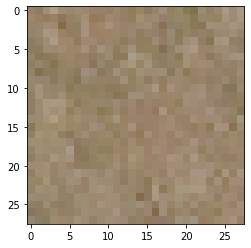

In [12]:
X_train_img = X_train.reshape([399999,28,28,4]).astype(float)
print (X_train_img.shape)

def imshow(ix):
    plt.imshow(np.squeeze(X_train_img[ix,:,:,0:3])) #Only seeing the RGB channels
    plt.show()
    
imshow(4)     

In [12]:
Y_train.rename(columns={"0": "barrenland", "0.1": "trees" , "0.2": "greenland" , "1": "other"}, inplace = 'True')

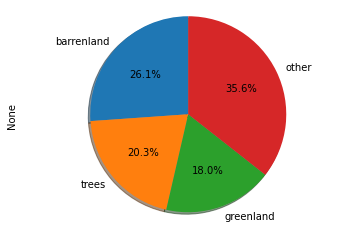

In [14]:
fig1, ax1 = plt.subplots()
Y_train.iloc[:,[0,1,2,3]].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

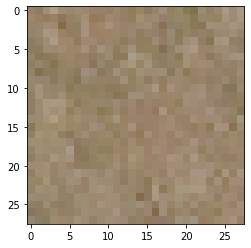

barrenland    1
trees         0
greenland     0
other         0
Name: 4, dtype: int64
barrenland


In [55]:
def visualizeLabel(idx):
    plt.imshow(np.squeeze(X_train[idx,:,:,0:3])) #Only seeing the RGB channels
    plt.show()
    
    Ytrain1 = Y_train.iloc[idx]
    print(Ytrain1)
    if Ytrain1[Ytrain1['barrenland'] == '1']:
        print('barrenland')
    elif Ytrain1[Ytrain1['trees'] == '1']:
        print('trees')
    elif Ytrain1[Ytrain1['greenland'] == '1']:
        print('greenland')
    else :
        print('other')    
    
visualizeLabel(4)  

In [14]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),       
                                            torchvision.transforms.ToTensor()])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),  
                                           torchvision.transforms.ToTensor()])


In [40]:
class MyDataset():
    def __init__(self ,X_train , Y_train, transforms=None):

        self.Y_train = Y_train
        self.X_train = X_train
        self.transforms = transforms

    def __getitem__(self,idx):
        label_df = self.Y_train.iloc[idx]
        label = torch.tensor(label_df[0:].tolist() , dtype=torch.long)

        image = Image.fromarray((self.X_train[idx,:,:,0:3] * 255).astype(np.uint8)).convert('RGB')
        
        
        if self.transforms is not None:
              image = self.transforms(image)
        return image, label
    
    def __len__(self):
        return len(self.Y_train)
    
dataset = MyDataset(X_train , Y_train, train_Aug)    

In [56]:
from torch.utils.data import Dataset, DataLoader ,random_split
valid_no = int(len(dataset)*0.7) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])

print(len(trainset), len(valset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

120000 279999


In [57]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.conv4 = nn.Conv2d(256, 512, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*10*10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        out = x.view(-1, 512*10*10)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


net = Model()

In [58]:
net

Model(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=51200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [59]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.to(device).parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [69]:
from sklearn.metrics import precision_score,f1_score
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0): 
        exp_lr_scheduler.step()
        
        for images, labels in trainloader:
                images = images.to(device) 
                labels = labels.to(device)
                
                optimizer_ft.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                loss.backward()
                optimizer_ft.step()
                
#                 _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
                preds = torch.sigmoid(outputs).data > 0.5
                preds = preds.to(torch.float32)
                
                correct += f1_score(labels.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * images.size(0)
                
                print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.item(), correct/total))
        
#         torch.save(net.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))

print('Finished Training')

Epoch 1/5, Loss: 0.541, Accuracy: 0.533
Epoch 1/5, Loss: 0.042, Accuracy: 0.650
Epoch 1/5, Loss: 0.622, Accuracy: 0.589
Epoch 1/5, Loss: 0.132, Accuracy: 0.625
Epoch 1/5, Loss: 0.074, Accuracy: 0.633
Epoch 1/5, Loss: 0.652, Accuracy: 0.628
Epoch 1/5, Loss: 0.136, Accuracy: 0.648
Epoch 1/5, Loss: 1.282, Accuracy: 0.642
Epoch 1/5, Loss: 0.489, Accuracy: 0.652
Epoch 1/5, Loss: 0.662, Accuracy: 0.650
Epoch 1/5, Loss: 0.734, Accuracy: 0.648
Epoch 1/5, Loss: 0.654, Accuracy: 0.642
Epoch 1/5, Loss: 0.442, Accuracy: 0.638
Epoch 1/5, Loss: 0.090, Accuracy: 0.648
Epoch 1/5, Loss: 0.165, Accuracy: 0.649
Epoch 1/5, Loss: 0.485, Accuracy: 0.646
Epoch 1/5, Loss: 0.116, Accuracy: 0.649
Epoch 1/5, Loss: 0.170, Accuracy: 0.656
Epoch 1/5, Loss: 0.947, Accuracy: 0.653
Epoch 1/5, Loss: 0.092, Accuracy: 0.657
Epoch 1/5, Loss: 0.025, Accuracy: 0.662
Epoch 1/5, Loss: 0.480, Accuracy: 0.664
Epoch 1/5, Loss: 0.343, Accuracy: 0.665
Epoch 1/5, Loss: 0.418, Accuracy: 0.662
Epoch 1/5, Loss: 1.403, Accuracy: 0.657


Epoch 1/5, Loss: 0.544, Accuracy: 0.686
Epoch 1/5, Loss: 0.128, Accuracy: 0.686
Epoch 1/5, Loss: 0.032, Accuracy: 0.686
Epoch 1/5, Loss: 0.453, Accuracy: 0.686
Epoch 1/5, Loss: 0.309, Accuracy: 0.686
Epoch 1/5, Loss: 0.041, Accuracy: 0.686
Epoch 1/5, Loss: 0.068, Accuracy: 0.686
Epoch 1/5, Loss: 0.900, Accuracy: 0.686
Epoch 1/5, Loss: 0.387, Accuracy: 0.685
Epoch 1/5, Loss: 0.233, Accuracy: 0.686
Epoch 1/5, Loss: 0.266, Accuracy: 0.685
Epoch 1/5, Loss: 0.099, Accuracy: 0.685
Epoch 1/5, Loss: 0.739, Accuracy: 0.685
Epoch 1/5, Loss: 0.158, Accuracy: 0.685
Epoch 1/5, Loss: 0.734, Accuracy: 0.685
Epoch 1/5, Loss: 0.482, Accuracy: 0.685
Epoch 1/5, Loss: 1.475, Accuracy: 0.685
Epoch 1/5, Loss: 0.333, Accuracy: 0.686
Epoch 1/5, Loss: 0.590, Accuracy: 0.685
Epoch 1/5, Loss: 0.116, Accuracy: 0.686
Epoch 1/5, Loss: 0.786, Accuracy: 0.685
Epoch 1/5, Loss: 0.396, Accuracy: 0.685
Epoch 1/5, Loss: 0.069, Accuracy: 0.685
Epoch 1/5, Loss: 0.241, Accuracy: 0.685
Epoch 1/5, Loss: 0.386, Accuracy: 0.684


Epoch 1/5, Loss: 0.265, Accuracy: 0.684
Epoch 1/5, Loss: 0.067, Accuracy: 0.684
Epoch 1/5, Loss: 0.083, Accuracy: 0.684
Epoch 1/5, Loss: 0.069, Accuracy: 0.684
Epoch 1/5, Loss: 0.833, Accuracy: 0.684
Epoch 1/5, Loss: 0.379, Accuracy: 0.684
Epoch 1/5, Loss: 0.110, Accuracy: 0.684
Epoch 1/5, Loss: 0.022, Accuracy: 0.684
Epoch 1/5, Loss: 0.162, Accuracy: 0.684
Epoch 1/5, Loss: 0.409, Accuracy: 0.684
Epoch 1/5, Loss: 0.196, Accuracy: 0.684
Epoch 1/5, Loss: 0.514, Accuracy: 0.684
Epoch 1/5, Loss: 1.464, Accuracy: 0.684
Epoch 1/5, Loss: 0.284, Accuracy: 0.684
Epoch 1/5, Loss: 0.073, Accuracy: 0.684
Epoch 1/5, Loss: 0.777, Accuracy: 0.684
Epoch 1/5, Loss: 0.464, Accuracy: 0.684
Epoch 1/5, Loss: 0.150, Accuracy: 0.684
Epoch 1/5, Loss: 0.206, Accuracy: 0.684
Epoch 1/5, Loss: 0.059, Accuracy: 0.684
Epoch 1/5, Loss: 0.128, Accuracy: 0.684
Epoch 1/5, Loss: 0.106, Accuracy: 0.684
Epoch 1/5, Loss: 1.548, Accuracy: 0.684
Epoch 1/5, Loss: 0.441, Accuracy: 0.684
Epoch 1/5, Loss: 0.272, Accuracy: 0.684


Epoch 1/5, Loss: 0.828, Accuracy: 0.679
Epoch 1/5, Loss: 0.133, Accuracy: 0.679
Epoch 1/5, Loss: 0.243, Accuracy: 0.679
Epoch 1/5, Loss: 0.474, Accuracy: 0.678
Epoch 1/5, Loss: 0.648, Accuracy: 0.678
Epoch 1/5, Loss: 0.623, Accuracy: 0.678
Epoch 1/5, Loss: 0.393, Accuracy: 0.678
Epoch 1/5, Loss: 0.526, Accuracy: 0.678
Epoch 1/5, Loss: 0.118, Accuracy: 0.679
Epoch 1/5, Loss: 0.739, Accuracy: 0.678
Epoch 1/5, Loss: 0.376, Accuracy: 0.678
Epoch 1/5, Loss: 0.399, Accuracy: 0.678
Epoch 1/5, Loss: 0.212, Accuracy: 0.678
Epoch 1/5, Loss: 0.162, Accuracy: 0.679
Epoch 1/5, Loss: 0.259, Accuracy: 0.679
Epoch 1/5, Loss: 0.439, Accuracy: 0.679
Epoch 1/5, Loss: 0.055, Accuracy: 0.679
Epoch 1/5, Loss: 0.642, Accuracy: 0.679
Epoch 1/5, Loss: 0.416, Accuracy: 0.679
Epoch 1/5, Loss: 0.124, Accuracy: 0.679
Epoch 1/5, Loss: 0.493, Accuracy: 0.679
Epoch 1/5, Loss: 0.199, Accuracy: 0.679
Epoch 1/5, Loss: 0.521, Accuracy: 0.679
Epoch 1/5, Loss: 0.993, Accuracy: 0.679
Epoch 1/5, Loss: 0.165, Accuracy: 0.679


Epoch 1/5, Loss: 0.086, Accuracy: 0.681
Epoch 1/5, Loss: 0.059, Accuracy: 0.682
Epoch 1/5, Loss: 0.134, Accuracy: 0.682
Epoch 1/5, Loss: 0.215, Accuracy: 0.682
Epoch 1/5, Loss: 0.095, Accuracy: 0.682
Epoch 1/5, Loss: 0.116, Accuracy: 0.682
Epoch 1/5, Loss: 0.821, Accuracy: 0.682
Epoch 1/5, Loss: 0.353, Accuracy: 0.682
Epoch 1/5, Loss: 0.882, Accuracy: 0.682
Epoch 1/5, Loss: 0.228, Accuracy: 0.682
Epoch 1/5, Loss: 0.192, Accuracy: 0.682
Epoch 1/5, Loss: 0.112, Accuracy: 0.683
Epoch 1/5, Loss: 0.042, Accuracy: 0.683
Epoch 1/5, Loss: 0.178, Accuracy: 0.683
Epoch 1/5, Loss: 0.143, Accuracy: 0.683
Epoch 1/5, Loss: 0.133, Accuracy: 0.683
Epoch 1/5, Loss: 0.164, Accuracy: 0.683
Epoch 1/5, Loss: 0.684, Accuracy: 0.683
Epoch 1/5, Loss: 0.392, Accuracy: 0.683
Epoch 1/5, Loss: 1.294, Accuracy: 0.683
Epoch 1/5, Loss: 0.198, Accuracy: 0.683
Epoch 1/5, Loss: 0.297, Accuracy: 0.683
Epoch 1/5, Loss: 0.434, Accuracy: 0.683
Epoch 1/5, Loss: 0.080, Accuracy: 0.683
Epoch 1/5, Loss: 1.267, Accuracy: 0.683


Epoch 1/5, Loss: 0.158, Accuracy: 0.686
Epoch 1/5, Loss: 0.047, Accuracy: 0.686
Epoch 1/5, Loss: 0.487, Accuracy: 0.686
Epoch 1/5, Loss: 0.703, Accuracy: 0.686
Epoch 1/5, Loss: 0.095, Accuracy: 0.686
Epoch 1/5, Loss: 0.076, Accuracy: 0.686
Epoch 1/5, Loss: 0.508, Accuracy: 0.686
Epoch 1/5, Loss: 0.061, Accuracy: 0.686
Epoch 1/5, Loss: 0.108, Accuracy: 0.686
Epoch 1/5, Loss: 0.167, Accuracy: 0.687
Epoch 1/5, Loss: 0.111, Accuracy: 0.687
Epoch 1/5, Loss: 0.967, Accuracy: 0.686
Epoch 1/5, Loss: 0.269, Accuracy: 0.686
Epoch 1/5, Loss: 0.169, Accuracy: 0.686
Epoch 1/5, Loss: 0.138, Accuracy: 0.686
Epoch 1/5, Loss: 0.167, Accuracy: 0.687
Epoch 1/5, Loss: 0.161, Accuracy: 0.687
Epoch 1/5, Loss: 0.255, Accuracy: 0.687
Epoch 1/5, Loss: 0.060, Accuracy: 0.687
Epoch 1/5, Loss: 0.489, Accuracy: 0.687
Epoch 1/5, Loss: 0.203, Accuracy: 0.687
Epoch 1/5, Loss: 0.176, Accuracy: 0.687
Epoch 1/5, Loss: 0.138, Accuracy: 0.687
Epoch 1/5, Loss: 0.225, Accuracy: 0.687
Epoch 1/5, Loss: 0.678, Accuracy: 0.687


Epoch 1/5, Loss: 0.180, Accuracy: 0.690
Epoch 1/5, Loss: 0.228, Accuracy: 0.690
Epoch 1/5, Loss: 1.442, Accuracy: 0.690
Epoch 1/5, Loss: 0.739, Accuracy: 0.690
Epoch 1/5, Loss: 0.073, Accuracy: 0.690
Epoch 1/5, Loss: 0.257, Accuracy: 0.690
Epoch 1/5, Loss: 0.221, Accuracy: 0.690
Epoch 1/5, Loss: 0.611, Accuracy: 0.690
Epoch 1/5, Loss: 0.119, Accuracy: 0.690
Epoch 1/5, Loss: 0.236, Accuracy: 0.690
Epoch 1/5, Loss: 0.269, Accuracy: 0.690
Epoch 1/5, Loss: 0.090, Accuracy: 0.690
Epoch 1/5, Loss: 0.447, Accuracy: 0.690
Epoch 1/5, Loss: 0.087, Accuracy: 0.690
Epoch 1/5, Loss: 0.218, Accuracy: 0.690
Epoch 1/5, Loss: 0.057, Accuracy: 0.691
Epoch 1/5, Loss: 0.537, Accuracy: 0.691
Epoch 1/5, Loss: 0.045, Accuracy: 0.691
Epoch 1/5, Loss: 0.048, Accuracy: 0.691
Epoch 1/5, Loss: 0.073, Accuracy: 0.691
Epoch 1/5, Loss: 0.245, Accuracy: 0.691
Epoch 1/5, Loss: 0.048, Accuracy: 0.691
Epoch 1/5, Loss: 0.196, Accuracy: 0.691
Epoch 1/5, Loss: 0.587, Accuracy: 0.691
Epoch 1/5, Loss: 0.022, Accuracy: 0.691


Epoch 1/5, Loss: 0.122, Accuracy: 0.693
Epoch 1/5, Loss: 0.242, Accuracy: 0.693
Epoch 1/5, Loss: 0.139, Accuracy: 0.693
Epoch 1/5, Loss: 0.249, Accuracy: 0.693
Epoch 1/5, Loss: 0.244, Accuracy: 0.693
Epoch 1/5, Loss: 0.308, Accuracy: 0.693
Epoch 1/5, Loss: 0.361, Accuracy: 0.693
Epoch 1/5, Loss: 0.342, Accuracy: 0.693
Epoch 1/5, Loss: 1.400, Accuracy: 0.693
Epoch 1/5, Loss: 0.302, Accuracy: 0.693
Epoch 1/5, Loss: 0.257, Accuracy: 0.693
Epoch 1/5, Loss: 0.517, Accuracy: 0.693
Epoch 1/5, Loss: 0.059, Accuracy: 0.693
Epoch 1/5, Loss: 0.272, Accuracy: 0.693
Epoch 1/5, Loss: 0.557, Accuracy: 0.693
Epoch 1/5, Loss: 0.790, Accuracy: 0.693
Epoch 1/5, Loss: 0.250, Accuracy: 0.693
Epoch 1/5, Loss: 0.026, Accuracy: 0.693
Epoch 1/5, Loss: 0.125, Accuracy: 0.693
Epoch 1/5, Loss: 0.153, Accuracy: 0.693
Epoch 1/5, Loss: 0.900, Accuracy: 0.693
Epoch 1/5, Loss: 0.357, Accuracy: 0.693
Epoch 1/5, Loss: 0.027, Accuracy: 0.693
Epoch 1/5, Loss: 0.203, Accuracy: 0.693
Epoch 1/5, Loss: 0.840, Accuracy: 0.693


Epoch 1/5, Loss: 0.289, Accuracy: 0.694
Epoch 1/5, Loss: 0.139, Accuracy: 0.694
Epoch 1/5, Loss: 0.315, Accuracy: 0.694
Epoch 1/5, Loss: 0.142, Accuracy: 0.694
Epoch 1/5, Loss: 0.134, Accuracy: 0.694
Epoch 1/5, Loss: 0.174, Accuracy: 0.694
Epoch 1/5, Loss: 0.405, Accuracy: 0.694
Epoch 1/5, Loss: 0.088, Accuracy: 0.694
Epoch 1/5, Loss: 0.318, Accuracy: 0.694
Epoch 1/5, Loss: 0.232, Accuracy: 0.694
Epoch 1/5, Loss: 0.258, Accuracy: 0.694
Epoch 1/5, Loss: 0.315, Accuracy: 0.694
Epoch 1/5, Loss: 0.374, Accuracy: 0.694
Epoch 1/5, Loss: 0.165, Accuracy: 0.694
Epoch 1/5, Loss: 0.309, Accuracy: 0.694
Epoch 1/5, Loss: 0.631, Accuracy: 0.694
Epoch 1/5, Loss: 0.166, Accuracy: 0.694
Epoch 1/5, Loss: 0.707, Accuracy: 0.694
Epoch 1/5, Loss: 0.159, Accuracy: 0.694
Epoch 1/5, Loss: 0.390, Accuracy: 0.694
Epoch 1/5, Loss: 0.194, Accuracy: 0.694
Epoch 1/5, Loss: 0.137, Accuracy: 0.694
Epoch 1/5, Loss: 0.088, Accuracy: 0.694
Epoch 1/5, Loss: 0.108, Accuracy: 0.694
Epoch 1/5, Loss: 0.704, Accuracy: 0.694


Epoch 1/5, Loss: 0.278, Accuracy: 0.697
Epoch 1/5, Loss: 0.255, Accuracy: 0.697
Epoch 1/5, Loss: 0.224, Accuracy: 0.697
Epoch 1/5, Loss: 0.064, Accuracy: 0.697
Epoch 1/5, Loss: 0.101, Accuracy: 0.697
Epoch 1/5, Loss: 0.139, Accuracy: 0.697
Epoch 1/5, Loss: 0.346, Accuracy: 0.697
Epoch 1/5, Loss: 0.238, Accuracy: 0.697
Epoch 1/5, Loss: 0.163, Accuracy: 0.697
Epoch 1/5, Loss: 0.435, Accuracy: 0.697
Epoch 1/5, Loss: 0.052, Accuracy: 0.697
Epoch 1/5, Loss: 0.179, Accuracy: 0.697
Epoch 1/5, Loss: 0.429, Accuracy: 0.697
Epoch 1/5, Loss: 1.308, Accuracy: 0.697
Epoch 1/5, Loss: 0.271, Accuracy: 0.697
Epoch 1/5, Loss: 0.068, Accuracy: 0.697
Epoch 1/5, Loss: 0.163, Accuracy: 0.697
Epoch 1/5, Loss: 0.497, Accuracy: 0.697
Epoch 1/5, Loss: 0.136, Accuracy: 0.697
Epoch 1/5, Loss: 0.075, Accuracy: 0.697
Epoch 1/5, Loss: 0.200, Accuracy: 0.697
Epoch 1/5, Loss: 0.218, Accuracy: 0.697
Epoch 1/5, Loss: 0.114, Accuracy: 0.697
Epoch 1/5, Loss: 0.037, Accuracy: 0.697
Epoch 1/5, Loss: 0.039, Accuracy: 0.697


Epoch 1/5, Loss: 0.144, Accuracy: 0.697
Epoch 1/5, Loss: 0.051, Accuracy: 0.697
Epoch 1/5, Loss: 0.326, Accuracy: 0.697
Epoch 1/5, Loss: 0.125, Accuracy: 0.697
Epoch 1/5, Loss: 0.375, Accuracy: 0.697
Epoch 1/5, Loss: 0.030, Accuracy: 0.697
Epoch 1/5, Loss: 0.431, Accuracy: 0.697
Epoch 1/5, Loss: 0.066, Accuracy: 0.697
Epoch 1/5, Loss: 0.026, Accuracy: 0.697
Epoch 1/5, Loss: 0.086, Accuracy: 0.697
Epoch 1/5, Loss: 0.036, Accuracy: 0.697
Epoch 1/5, Loss: 0.119, Accuracy: 0.697
Epoch 1/5, Loss: 1.322, Accuracy: 0.697
Epoch 1/5, Loss: 0.190, Accuracy: 0.697
Epoch 1/5, Loss: 1.411, Accuracy: 0.697
Epoch 1/5, Loss: 0.351, Accuracy: 0.697
Epoch 1/5, Loss: 0.242, Accuracy: 0.697
Epoch 1/5, Loss: 0.100, Accuracy: 0.697
Epoch 1/5, Loss: 0.200, Accuracy: 0.697
Epoch 1/5, Loss: 0.240, Accuracy: 0.697
Epoch 1/5, Loss: 0.628, Accuracy: 0.697
Epoch 1/5, Loss: 0.304, Accuracy: 0.697
Epoch 1/5, Loss: 0.062, Accuracy: 0.697
Epoch 1/5, Loss: 0.685, Accuracy: 0.697
Epoch 1/5, Loss: 1.242, Accuracy: 0.697


Epoch 1/5, Loss: 0.197, Accuracy: 0.698
Epoch 1/5, Loss: 0.123, Accuracy: 0.698
Epoch 1/5, Loss: 0.082, Accuracy: 0.698
Epoch 1/5, Loss: 0.214, Accuracy: 0.698
Epoch 1/5, Loss: 0.292, Accuracy: 0.698
Epoch 1/5, Loss: 0.437, Accuracy: 0.698
Epoch 1/5, Loss: 0.064, Accuracy: 0.698
Epoch 1/5, Loss: 0.750, Accuracy: 0.698
Epoch 1/5, Loss: 0.090, Accuracy: 0.698
Epoch 1/5, Loss: 0.343, Accuracy: 0.698
Epoch 1/5, Loss: 0.136, Accuracy: 0.698
Epoch 1/5, Loss: 0.218, Accuracy: 0.698
Epoch 1/5, Loss: 0.092, Accuracy: 0.698
Epoch 1/5, Loss: 0.047, Accuracy: 0.698
Epoch 1/5, Loss: 0.149, Accuracy: 0.698
Epoch 1/5, Loss: 0.174, Accuracy: 0.698
Epoch 1/5, Loss: 0.060, Accuracy: 0.698
Epoch 1/5, Loss: 0.221, Accuracy: 0.698
Epoch 1/5, Loss: 0.145, Accuracy: 0.698
Epoch 1/5, Loss: 0.027, Accuracy: 0.698
Epoch 1/5, Loss: 0.056, Accuracy: 0.698
Epoch 1/5, Loss: 0.227, Accuracy: 0.698
Epoch 1/5, Loss: 0.402, Accuracy: 0.698
Epoch 1/5, Loss: 0.034, Accuracy: 0.698
Epoch 1/5, Loss: 0.204, Accuracy: 0.698


Epoch 1/5, Loss: 0.820, Accuracy: 0.699
Epoch 1/5, Loss: 0.188, Accuracy: 0.699
Epoch 1/5, Loss: 0.057, Accuracy: 0.699
Epoch 1/5, Loss: 0.141, Accuracy: 0.699
Epoch 1/5, Loss: 0.238, Accuracy: 0.699
Epoch 1/5, Loss: 0.469, Accuracy: 0.699
Epoch 1/5, Loss: 0.178, Accuracy: 0.699
Epoch 1/5, Loss: 0.074, Accuracy: 0.699
Epoch 1/5, Loss: 0.052, Accuracy: 0.699
Epoch 1/5, Loss: 0.287, Accuracy: 0.699
Epoch 1/5, Loss: 0.324, Accuracy: 0.699
Epoch 1/5, Loss: 0.540, Accuracy: 0.699
Epoch 1/5, Loss: 0.709, Accuracy: 0.699
Epoch 1/5, Loss: 0.236, Accuracy: 0.699
Epoch 1/5, Loss: 2.613, Accuracy: 0.699
Epoch 1/5, Loss: 0.237, Accuracy: 0.699
Epoch 1/5, Loss: 0.361, Accuracy: 0.699
Epoch 1/5, Loss: 0.399, Accuracy: 0.699
Epoch 1/5, Loss: 0.114, Accuracy: 0.699
Epoch 1/5, Loss: 0.147, Accuracy: 0.699
Epoch 1/5, Loss: 0.321, Accuracy: 0.699
Epoch 1/5, Loss: 0.259, Accuracy: 0.699
Epoch 1/5, Loss: 0.210, Accuracy: 0.699
Epoch 1/5, Loss: 0.015, Accuracy: 0.699
Epoch 1/5, Loss: 0.075, Accuracy: 0.699


Epoch 1/5, Loss: 0.120, Accuracy: 0.700
Epoch 1/5, Loss: 0.130, Accuracy: 0.700
Epoch 1/5, Loss: 0.147, Accuracy: 0.700
Epoch 1/5, Loss: 0.090, Accuracy: 0.700
Epoch 1/5, Loss: 0.085, Accuracy: 0.700
Epoch 1/5, Loss: 0.747, Accuracy: 0.700
Epoch 1/5, Loss: 0.278, Accuracy: 0.700
Epoch 1/5, Loss: 0.629, Accuracy: 0.700
Epoch 1/5, Loss: 0.200, Accuracy: 0.700
Epoch 1/5, Loss: 0.054, Accuracy: 0.700
Epoch 1/5, Loss: 2.072, Accuracy: 0.700
Epoch 1/5, Loss: 0.232, Accuracy: 0.700
Epoch 1/5, Loss: 0.213, Accuracy: 0.700
Epoch 1/5, Loss: 0.069, Accuracy: 0.700
Epoch 1/5, Loss: 0.124, Accuracy: 0.700
Epoch 1/5, Loss: 0.176, Accuracy: 0.700
Epoch 1/5, Loss: 0.143, Accuracy: 0.700
Epoch 1/5, Loss: 0.311, Accuracy: 0.700
Epoch 1/5, Loss: 0.260, Accuracy: 0.700
Epoch 1/5, Loss: 0.097, Accuracy: 0.700
Epoch 1/5, Loss: 0.089, Accuracy: 0.700
Epoch 1/5, Loss: 0.026, Accuracy: 0.700
Epoch 1/5, Loss: 0.166, Accuracy: 0.700
Epoch 1/5, Loss: 0.165, Accuracy: 0.700
Epoch 1/5, Loss: 0.046, Accuracy: 0.700


Epoch 1/5, Loss: 0.039, Accuracy: 0.701
Epoch 1/5, Loss: 0.016, Accuracy: 0.701
Epoch 1/5, Loss: 0.841, Accuracy: 0.701
Epoch 1/5, Loss: 0.083, Accuracy: 0.701
Epoch 1/5, Loss: 0.914, Accuracy: 0.701
Epoch 1/5, Loss: 0.035, Accuracy: 0.701
Epoch 1/5, Loss: 0.156, Accuracy: 0.701
Epoch 1/5, Loss: 0.090, Accuracy: 0.701
Epoch 1/5, Loss: 0.381, Accuracy: 0.701
Epoch 1/5, Loss: 0.450, Accuracy: 0.701
Epoch 1/5, Loss: 0.364, Accuracy: 0.701
Epoch 1/5, Loss: 0.026, Accuracy: 0.701
Epoch 1/5, Loss: 0.342, Accuracy: 0.701
Epoch 1/5, Loss: 2.622, Accuracy: 0.701
Epoch 1/5, Loss: 0.184, Accuracy: 0.701
Epoch 1/5, Loss: 0.031, Accuracy: 0.701
Epoch 1/5, Loss: 0.109, Accuracy: 0.701
Epoch 1/5, Loss: 0.825, Accuracy: 0.701
Epoch 1/5, Loss: 0.233, Accuracy: 0.701
Epoch 1/5, Loss: 0.523, Accuracy: 0.701
Epoch 1/5, Loss: 0.279, Accuracy: 0.701
Epoch 1/5, Loss: 0.022, Accuracy: 0.701
Epoch 1/5, Loss: 0.758, Accuracy: 0.701
Epoch 1/5, Loss: 0.625, Accuracy: 0.701
Epoch 1/5, Loss: 0.658, Accuracy: 0.701


Epoch 1/5, Loss: 0.035, Accuracy: 0.700
Epoch 1/5, Loss: 0.060, Accuracy: 0.700
Epoch 1/5, Loss: 0.429, Accuracy: 0.700
Epoch 1/5, Loss: 0.146, Accuracy: 0.700
Epoch 1/5, Loss: 0.497, Accuracy: 0.700
Epoch 1/5, Loss: 0.092, Accuracy: 0.700
Epoch 1/5, Loss: 0.098, Accuracy: 0.700
Epoch 1/5, Loss: 0.215, Accuracy: 0.700
Epoch 1/5, Loss: 0.436, Accuracy: 0.700
Epoch 1/5, Loss: 0.072, Accuracy: 0.700
Epoch 1/5, Loss: 0.068, Accuracy: 0.700
Epoch 1/5, Loss: 0.121, Accuracy: 0.700
Epoch 1/5, Loss: 0.715, Accuracy: 0.700
Epoch 1/5, Loss: 0.061, Accuracy: 0.700
Epoch 1/5, Loss: 0.235, Accuracy: 0.700
Epoch 1/5, Loss: 0.062, Accuracy: 0.700
Epoch 1/5, Loss: 0.078, Accuracy: 0.700
Epoch 1/5, Loss: 0.029, Accuracy: 0.700
Epoch 1/5, Loss: 0.175, Accuracy: 0.700
Epoch 1/5, Loss: 0.048, Accuracy: 0.700
Epoch 1/5, Loss: 0.389, Accuracy: 0.700
Epoch 1/5, Loss: 0.353, Accuracy: 0.700
Epoch 1/5, Loss: 0.091, Accuracy: 0.700
Epoch 1/5, Loss: 0.115, Accuracy: 0.700
Epoch 1/5, Loss: 0.382, Accuracy: 0.700


Epoch 1/5, Loss: 0.085, Accuracy: 0.701
Epoch 1/5, Loss: 0.188, Accuracy: 0.701
Epoch 1/5, Loss: 0.476, Accuracy: 0.701
Epoch 1/5, Loss: 0.348, Accuracy: 0.701
Epoch 1/5, Loss: 1.012, Accuracy: 0.701
Epoch 1/5, Loss: 0.498, Accuracy: 0.701
Epoch 1/5, Loss: 0.210, Accuracy: 0.701
Epoch 1/5, Loss: 0.049, Accuracy: 0.701
Epoch 1/5, Loss: 0.113, Accuracy: 0.701
Epoch 1/5, Loss: 0.340, Accuracy: 0.701
Epoch 1/5, Loss: 0.585, Accuracy: 0.701
Epoch 1/5, Loss: 0.062, Accuracy: 0.701
Epoch 1/5, Loss: 0.235, Accuracy: 0.700
Epoch 1/5, Loss: 0.094, Accuracy: 0.700
Epoch 1/5, Loss: 0.287, Accuracy: 0.701
Epoch 1/5, Loss: 0.126, Accuracy: 0.701
Epoch 1/5, Loss: 0.299, Accuracy: 0.701
Epoch 1/5, Loss: 0.077, Accuracy: 0.700
Epoch 1/5, Loss: 0.743, Accuracy: 0.700
Epoch 1/5, Loss: 0.305, Accuracy: 0.700
Epoch 1/5, Loss: 0.032, Accuracy: 0.700
Epoch 1/5, Loss: 0.157, Accuracy: 0.700
Epoch 1/5, Loss: 0.081, Accuracy: 0.700
Epoch 1/5, Loss: 0.182, Accuracy: 0.700
Epoch 1/5, Loss: 0.241, Accuracy: 0.700


Epoch 1/5, Loss: 0.056, Accuracy: 0.701
Epoch 1/5, Loss: 0.003, Accuracy: 0.701
Epoch 1/5, Loss: 0.071, Accuracy: 0.702
Epoch 1/5, Loss: 0.394, Accuracy: 0.702
Epoch 1/5, Loss: 0.698, Accuracy: 0.702
Epoch 1/5, Loss: 0.541, Accuracy: 0.702
Epoch 1/5, Loss: 0.325, Accuracy: 0.702
Epoch 1/5, Loss: 0.587, Accuracy: 0.701
Epoch 1/5, Loss: 0.087, Accuracy: 0.701
Epoch 1/5, Loss: 0.423, Accuracy: 0.701
Epoch 1/5, Loss: 0.048, Accuracy: 0.701
Epoch 1/5, Loss: 0.680, Accuracy: 0.701
Epoch 1/5, Loss: 0.127, Accuracy: 0.701
Epoch 1/5, Loss: 0.443, Accuracy: 0.701
Epoch 1/5, Loss: 0.134, Accuracy: 0.701
Epoch 1/5, Loss: 0.164, Accuracy: 0.701
Epoch 1/5, Loss: 0.132, Accuracy: 0.701
Epoch 1/5, Loss: 0.237, Accuracy: 0.701
Epoch 1/5, Loss: 0.099, Accuracy: 0.701
Epoch 1/5, Loss: 0.075, Accuracy: 0.701
Epoch 1/5, Loss: 0.407, Accuracy: 0.701
Epoch 1/5, Loss: 0.393, Accuracy: 0.701
Epoch 1/5, Loss: 0.149, Accuracy: 0.701
Epoch 1/5, Loss: 0.885, Accuracy: 0.701
Epoch 1/5, Loss: 0.038, Accuracy: 0.701


Epoch 1/5, Loss: 0.332, Accuracy: 0.701
Epoch 1/5, Loss: 0.194, Accuracy: 0.701
Epoch 1/5, Loss: 0.232, Accuracy: 0.701
Epoch 1/5, Loss: 0.268, Accuracy: 0.701
Epoch 1/5, Loss: 1.101, Accuracy: 0.701
Epoch 1/5, Loss: 0.122, Accuracy: 0.701
Epoch 1/5, Loss: 0.026, Accuracy: 0.701
Epoch 1/5, Loss: 0.657, Accuracy: 0.701
Epoch 1/5, Loss: 0.083, Accuracy: 0.701
Epoch 1/5, Loss: 0.198, Accuracy: 0.701
Epoch 1/5, Loss: 0.080, Accuracy: 0.701
Epoch 1/5, Loss: 0.025, Accuracy: 0.701
Epoch 1/5, Loss: 0.130, Accuracy: 0.701
Epoch 1/5, Loss: 0.403, Accuracy: 0.701
Epoch 1/5, Loss: 0.125, Accuracy: 0.701
Epoch 1/5, Loss: 0.301, Accuracy: 0.701
Epoch 1/5, Loss: 0.464, Accuracy: 0.701
Epoch 1/5, Loss: 0.282, Accuracy: 0.701
Epoch 1/5, Loss: 0.160, Accuracy: 0.701
Epoch 1/5, Loss: 0.035, Accuracy: 0.701
Epoch 1/5, Loss: 0.086, Accuracy: 0.701
Epoch 1/5, Loss: 2.988, Accuracy: 0.701
Epoch 1/5, Loss: 0.153, Accuracy: 0.701
Epoch 1/5, Loss: 0.608, Accuracy: 0.701
Epoch 1/5, Loss: 0.075, Accuracy: 0.701


Epoch 1/5, Loss: 0.039, Accuracy: 0.701
Epoch 1/5, Loss: 0.608, Accuracy: 0.701
Epoch 1/5, Loss: 0.149, Accuracy: 0.701
Epoch 1/5, Loss: 0.153, Accuracy: 0.701
Epoch 1/5, Loss: 0.138, Accuracy: 0.701
Epoch 1/5, Loss: 0.059, Accuracy: 0.701
Epoch 1/5, Loss: 0.112, Accuracy: 0.701
Epoch 1/5, Loss: 0.036, Accuracy: 0.701
Epoch 1/5, Loss: 0.053, Accuracy: 0.701
Epoch 1/5, Loss: 0.301, Accuracy: 0.701
Epoch 1/5, Loss: 0.737, Accuracy: 0.701
Epoch 1/5, Loss: 0.059, Accuracy: 0.701
Epoch 1/5, Loss: 0.041, Accuracy: 0.701
Epoch 1/5, Loss: 0.139, Accuracy: 0.701
Epoch 1/5, Loss: 0.312, Accuracy: 0.701
Epoch 1/5, Loss: 0.844, Accuracy: 0.701
Epoch 1/5, Loss: 2.190, Accuracy: 0.701
Epoch 1/5, Loss: 0.015, Accuracy: 0.701
Epoch 1/5, Loss: 0.513, Accuracy: 0.701
Epoch 1/5, Loss: 0.609, Accuracy: 0.701
Epoch 1/5, Loss: 0.247, Accuracy: 0.701
Epoch 1/5, Loss: 0.113, Accuracy: 0.701
Epoch 1/5, Loss: 0.841, Accuracy: 0.701
Epoch 1/5, Loss: 0.215, Accuracy: 0.701
Epoch 1/5, Loss: 0.059, Accuracy: 0.701


Epoch 1/5, Loss: 1.007, Accuracy: 0.702
Epoch 1/5, Loss: 0.019, Accuracy: 0.702
Epoch 1/5, Loss: 0.067, Accuracy: 0.702
Epoch 1/5, Loss: 0.097, Accuracy: 0.702
Epoch 1/5, Loss: 0.188, Accuracy: 0.702
Epoch 1/5, Loss: 0.324, Accuracy: 0.702
Epoch 1/5, Loss: 1.349, Accuracy: 0.702
Epoch 1/5, Loss: 0.188, Accuracy: 0.702
Epoch 1/5, Loss: 0.013, Accuracy: 0.702
Epoch 1/5, Loss: 0.054, Accuracy: 0.702
Epoch 1/5, Loss: 0.446, Accuracy: 0.702
Epoch 1/5, Loss: 0.054, Accuracy: 0.702
Epoch 1/5, Loss: 0.965, Accuracy: 0.702
Epoch 1/5, Loss: 0.026, Accuracy: 0.702
Epoch 1/5, Loss: 0.837, Accuracy: 0.702
Epoch 1/5, Loss: 0.728, Accuracy: 0.702
Epoch 1/5, Loss: 0.385, Accuracy: 0.702
Epoch 1/5, Loss: 0.157, Accuracy: 0.702
Epoch 1/5, Loss: 0.070, Accuracy: 0.702
Epoch 1/5, Loss: 0.057, Accuracy: 0.702
Epoch 1/5, Loss: 1.122, Accuracy: 0.702
Epoch 1/5, Loss: 0.582, Accuracy: 0.702
Epoch 1/5, Loss: 0.132, Accuracy: 0.702
Epoch 1/5, Loss: 0.199, Accuracy: 0.702
Epoch 1/5, Loss: 0.016, Accuracy: 0.702


Epoch 1/5, Loss: 0.221, Accuracy: 0.701
Epoch 1/5, Loss: 0.970, Accuracy: 0.701
Epoch 1/5, Loss: 0.447, Accuracy: 0.701
Epoch 1/5, Loss: 0.277, Accuracy: 0.701
Epoch 1/5, Loss: 0.320, Accuracy: 0.701
Epoch 1/5, Loss: 0.195, Accuracy: 0.701
Epoch 1/5, Loss: 1.722, Accuracy: 0.701
Epoch 1/5, Loss: 0.824, Accuracy: 0.701
Epoch 1/5, Loss: 0.113, Accuracy: 0.701
Epoch 1/5, Loss: 0.270, Accuracy: 0.701
Epoch 1/5, Loss: 0.059, Accuracy: 0.701
Epoch 1/5, Loss: 0.125, Accuracy: 0.701
Epoch 1/5, Loss: 1.328, Accuracy: 0.701
Epoch 1/5, Loss: 0.197, Accuracy: 0.701
Epoch 1/5, Loss: 0.281, Accuracy: 0.701
Epoch 1/5, Loss: 0.120, Accuracy: 0.701
Epoch 1/5, Loss: 0.005, Accuracy: 0.701
Epoch 1/5, Loss: 0.362, Accuracy: 0.701
Epoch 1/5, Loss: 0.115, Accuracy: 0.701
Epoch 1/5, Loss: 0.195, Accuracy: 0.701
Epoch 1/5, Loss: 0.405, Accuracy: 0.701
Epoch 1/5, Loss: 0.133, Accuracy: 0.701
Epoch 1/5, Loss: 0.815, Accuracy: 0.701
Epoch 1/5, Loss: 0.344, Accuracy: 0.701
Epoch 1/5, Loss: 0.019, Accuracy: 0.701


Epoch 1/5, Loss: 0.088, Accuracy: 0.701
Epoch 1/5, Loss: 0.079, Accuracy: 0.701
Epoch 1/5, Loss: 0.119, Accuracy: 0.701
Epoch 1/5, Loss: 0.040, Accuracy: 0.701
Epoch 1/5, Loss: 0.318, Accuracy: 0.701
Epoch 1/5, Loss: 0.219, Accuracy: 0.701
Epoch 1/5, Loss: 0.223, Accuracy: 0.701
Epoch 1/5, Loss: 0.992, Accuracy: 0.701
Epoch 1/5, Loss: 0.210, Accuracy: 0.701
Epoch 1/5, Loss: 0.069, Accuracy: 0.701
Epoch 1/5, Loss: 0.935, Accuracy: 0.701
Epoch 1/5, Loss: 0.069, Accuracy: 0.701
Epoch 1/5, Loss: 0.187, Accuracy: 0.701
Epoch 1/5, Loss: 0.010, Accuracy: 0.701
Epoch 1/5, Loss: 0.119, Accuracy: 0.701
Epoch 1/5, Loss: 0.075, Accuracy: 0.701
Epoch 1/5, Loss: 0.125, Accuracy: 0.701
Epoch 1/5, Loss: 0.346, Accuracy: 0.701
Epoch 1/5, Loss: 0.964, Accuracy: 0.701
Epoch 1/5, Loss: 0.085, Accuracy: 0.701
Epoch 1/5, Loss: 0.285, Accuracy: 0.701
Epoch 1/5, Loss: 0.156, Accuracy: 0.701
Epoch 1/5, Loss: 0.038, Accuracy: 0.701
Epoch 1/5, Loss: 0.153, Accuracy: 0.701
Epoch 1/5, Loss: 0.684, Accuracy: 0.701


Epoch 1/5, Loss: 0.036, Accuracy: 0.701
Epoch 1/5, Loss: 0.076, Accuracy: 0.701
Epoch 1/5, Loss: 0.131, Accuracy: 0.701
Epoch 1/5, Loss: 0.132, Accuracy: 0.701
Epoch 1/5, Loss: 0.117, Accuracy: 0.701
Epoch 1/5, Loss: 0.128, Accuracy: 0.701
Epoch 1/5, Loss: 0.425, Accuracy: 0.701
Epoch 1/5, Loss: 0.290, Accuracy: 0.701
Epoch 1/5, Loss: 0.277, Accuracy: 0.701
Epoch 1/5, Loss: 0.105, Accuracy: 0.701
Epoch 1/5, Loss: 0.195, Accuracy: 0.701
Epoch 1/5, Loss: 0.330, Accuracy: 0.701
Epoch 1/5, Loss: 0.037, Accuracy: 0.701
Epoch 1/5, Loss: 0.028, Accuracy: 0.701
Epoch 1/5, Loss: 0.268, Accuracy: 0.701
Epoch 1/5, Loss: 0.142, Accuracy: 0.701
Epoch 1/5, Loss: 0.368, Accuracy: 0.701
Epoch 1/5, Loss: 0.445, Accuracy: 0.701
Epoch 1/5, Loss: 0.096, Accuracy: 0.701
Epoch 1/5, Loss: 0.196, Accuracy: 0.701
Epoch 1/5, Loss: 0.045, Accuracy: 0.701
Epoch 1/5, Loss: 0.256, Accuracy: 0.701
Epoch 1/5, Loss: 0.499, Accuracy: 0.701
Epoch 1/5, Loss: 0.026, Accuracy: 0.701
Epoch 1/5, Loss: 0.057, Accuracy: 0.701


Epoch 1/5, Loss: 0.015, Accuracy: 0.702
Epoch 1/5, Loss: 0.016, Accuracy: 0.702
Epoch 1/5, Loss: 0.024, Accuracy: 0.702
Epoch 1/5, Loss: 0.188, Accuracy: 0.702
Epoch 1/5, Loss: 0.244, Accuracy: 0.702
Epoch 1/5, Loss: 0.024, Accuracy: 0.702
Epoch 1/5, Loss: 0.248, Accuracy: 0.702
Epoch 1/5, Loss: 1.426, Accuracy: 0.702
Epoch 1/5, Loss: 0.163, Accuracy: 0.702
Epoch 1/5, Loss: 0.167, Accuracy: 0.702
Epoch 1/5, Loss: 0.037, Accuracy: 0.702
Epoch 1/5, Loss: 0.078, Accuracy: 0.702
Epoch 1/5, Loss: 0.155, Accuracy: 0.702
Epoch 1/5, Loss: 0.023, Accuracy: 0.702
Epoch 1/5, Loss: 0.181, Accuracy: 0.702
Epoch 1/5, Loss: 0.051, Accuracy: 0.702
Epoch 1/5, Loss: 0.187, Accuracy: 0.702
Epoch 1/5, Loss: 0.417, Accuracy: 0.702
Epoch 1/5, Loss: 0.036, Accuracy: 0.702
Epoch 1/5, Loss: 0.042, Accuracy: 0.702
Epoch 1/5, Loss: 0.771, Accuracy: 0.702
Epoch 1/5, Loss: 0.176, Accuracy: 0.702
Epoch 1/5, Loss: 0.160, Accuracy: 0.702
Epoch 1/5, Loss: 0.003, Accuracy: 0.702
Epoch 1/5, Loss: 0.335, Accuracy: 0.702


Epoch 1/5, Loss: 0.047, Accuracy: 0.703
Epoch 1/5, Loss: 0.181, Accuracy: 0.703
Epoch 1/5, Loss: 0.598, Accuracy: 0.703
Epoch 1/5, Loss: 0.049, Accuracy: 0.703
Epoch 1/5, Loss: 0.377, Accuracy: 0.703
Epoch 1/5, Loss: 0.141, Accuracy: 0.703
Epoch 1/5, Loss: 0.104, Accuracy: 0.703
Epoch 1/5, Loss: 0.114, Accuracy: 0.703
Epoch 1/5, Loss: 2.132, Accuracy: 0.703
Epoch 1/5, Loss: 0.838, Accuracy: 0.703
Epoch 1/5, Loss: 0.029, Accuracy: 0.703
Epoch 1/5, Loss: 0.067, Accuracy: 0.703
Epoch 1/5, Loss: 0.078, Accuracy: 0.703
Epoch 1/5, Loss: 0.004, Accuracy: 0.703
Epoch 1/5, Loss: 0.132, Accuracy: 0.703
Epoch 1/5, Loss: 0.185, Accuracy: 0.703
Epoch 1/5, Loss: 0.250, Accuracy: 0.703
Epoch 1/5, Loss: 0.897, Accuracy: 0.703
Epoch 1/5, Loss: 0.101, Accuracy: 0.703
Epoch 1/5, Loss: 0.047, Accuracy: 0.703
Epoch 1/5, Loss: 0.052, Accuracy: 0.703
Epoch 1/5, Loss: 0.107, Accuracy: 0.703
Epoch 1/5, Loss: 0.035, Accuracy: 0.703
Epoch 1/5, Loss: 0.275, Accuracy: 0.703
Epoch 1/5, Loss: 0.139, Accuracy: 0.703


Epoch 1/5, Loss: 0.210, Accuracy: 0.703
Epoch 1/5, Loss: 1.216, Accuracy: 0.703
Epoch 1/5, Loss: 0.271, Accuracy: 0.703
Epoch 1/5, Loss: 0.115, Accuracy: 0.703
Epoch 1/5, Loss: 0.137, Accuracy: 0.703
Epoch 1/5, Loss: 0.486, Accuracy: 0.703
Epoch 1/5, Loss: 0.080, Accuracy: 0.703
Epoch 1/5, Loss: 0.236, Accuracy: 0.704
Epoch 1/5, Loss: 0.122, Accuracy: 0.704
Epoch 1/5, Loss: 0.078, Accuracy: 0.704
Epoch 1/5, Loss: 0.939, Accuracy: 0.704
Epoch 1/5, Loss: 0.066, Accuracy: 0.704
Epoch 1/5, Loss: 0.624, Accuracy: 0.704
Epoch 1/5, Loss: 0.108, Accuracy: 0.704
Epoch 1/5, Loss: 0.055, Accuracy: 0.704
Epoch 1/5, Loss: 0.248, Accuracy: 0.704
Epoch 1/5, Loss: 0.041, Accuracy: 0.704
Epoch 1/5, Loss: 0.145, Accuracy: 0.704
Epoch 1/5, Loss: 0.169, Accuracy: 0.704
Epoch 1/5, Loss: 0.052, Accuracy: 0.704
Epoch 1/5, Loss: 0.069, Accuracy: 0.704
Epoch 1/5, Loss: 0.344, Accuracy: 0.704
Epoch 1/5, Loss: 0.233, Accuracy: 0.704
Epoch 1/5, Loss: 0.121, Accuracy: 0.704
Epoch 1/5, Loss: 0.891, Accuracy: 0.703


Epoch 1/5, Loss: 0.301, Accuracy: 0.704
Epoch 1/5, Loss: 0.270, Accuracy: 0.704
Epoch 1/5, Loss: 0.280, Accuracy: 0.704
Epoch 1/5, Loss: 0.050, Accuracy: 0.704
Epoch 1/5, Loss: 0.032, Accuracy: 0.704
Epoch 1/5, Loss: 0.074, Accuracy: 0.704
Epoch 1/5, Loss: 0.230, Accuracy: 0.704
Epoch 1/5, Loss: 0.019, Accuracy: 0.704
Epoch 1/5, Loss: 0.216, Accuracy: 0.704
Epoch 1/5, Loss: 0.105, Accuracy: 0.704
Epoch 1/5, Loss: 0.172, Accuracy: 0.704
Epoch 1/5, Loss: 0.003, Accuracy: 0.704
Epoch 1/5, Loss: 0.058, Accuracy: 0.704
Epoch 1/5, Loss: 0.107, Accuracy: 0.704
Epoch 1/5, Loss: 0.035, Accuracy: 0.704
Epoch 1/5, Loss: 0.902, Accuracy: 0.704
Epoch 1/5, Loss: 0.013, Accuracy: 0.704
Epoch 1/5, Loss: 0.033, Accuracy: 0.704
Epoch 1/5, Loss: 0.196, Accuracy: 0.704
Epoch 1/5, Loss: 0.016, Accuracy: 0.704
Epoch 1/5, Loss: 0.026, Accuracy: 0.704
Epoch 1/5, Loss: 0.397, Accuracy: 0.704
Epoch 1/5, Loss: 0.004, Accuracy: 0.704
Epoch 1/5, Loss: 0.038, Accuracy: 0.704
Epoch 1/5, Loss: 2.406, Accuracy: 0.704


Epoch 1/5, Loss: 0.069, Accuracy: 0.705
Epoch 1/5, Loss: 0.089, Accuracy: 0.705
Epoch 1/5, Loss: 0.046, Accuracy: 0.705
Epoch 1/5, Loss: 0.060, Accuracy: 0.705
Epoch 1/5, Loss: 0.252, Accuracy: 0.705
Epoch 1/5, Loss: 0.011, Accuracy: 0.705
Epoch 1/5, Loss: 0.763, Accuracy: 0.705
Epoch 1/5, Loss: 0.078, Accuracy: 0.705
Epoch 1/5, Loss: 0.186, Accuracy: 0.705
Epoch 1/5, Loss: 0.020, Accuracy: 0.705
Epoch 1/5, Loss: 0.196, Accuracy: 0.705
Epoch 1/5, Loss: 0.054, Accuracy: 0.705
Epoch 1/5, Loss: 0.864, Accuracy: 0.705
Epoch 1/5, Loss: 0.229, Accuracy: 0.705
Epoch 1/5, Loss: 0.033, Accuracy: 0.705
Epoch 1/5, Loss: 0.131, Accuracy: 0.705
Epoch 1/5, Loss: 0.756, Accuracy: 0.705
Epoch 1/5, Loss: 0.316, Accuracy: 0.705
Epoch 1/5, Loss: 0.015, Accuracy: 0.705
Epoch 1/5, Loss: 0.755, Accuracy: 0.705
Epoch 1/5, Loss: 0.063, Accuracy: 0.705
Epoch 1/5, Loss: 0.161, Accuracy: 0.705
Epoch 1/5, Loss: 0.563, Accuracy: 0.705
Epoch 1/5, Loss: 0.210, Accuracy: 0.705
Epoch 1/5, Loss: 0.927, Accuracy: 0.705


Epoch 1/5, Loss: 0.032, Accuracy: 0.706
Epoch 1/5, Loss: 0.111, Accuracy: 0.706
Epoch 1/5, Loss: 0.118, Accuracy: 0.706
Epoch 1/5, Loss: 0.416, Accuracy: 0.706
Epoch 1/5, Loss: 0.037, Accuracy: 0.706
Epoch 1/5, Loss: 0.115, Accuracy: 0.706
Epoch 1/5, Loss: 0.082, Accuracy: 0.706
Epoch 1/5, Loss: 0.234, Accuracy: 0.706
Epoch 1/5, Loss: 0.982, Accuracy: 0.706
Epoch 1/5, Loss: 0.549, Accuracy: 0.706
Epoch 1/5, Loss: 0.087, Accuracy: 0.706
Epoch 1/5, Loss: 0.093, Accuracy: 0.706
Epoch 1/5, Loss: 0.386, Accuracy: 0.706
Epoch 1/5, Loss: 0.137, Accuracy: 0.706
Epoch 1/5, Loss: 0.353, Accuracy: 0.706
Epoch 1/5, Loss: 0.097, Accuracy: 0.706
Epoch 1/5, Loss: 0.276, Accuracy: 0.706
Epoch 1/5, Loss: 0.163, Accuracy: 0.706
Epoch 1/5, Loss: 0.832, Accuracy: 0.706
Epoch 1/5, Loss: 0.024, Accuracy: 0.706
Epoch 1/5, Loss: 0.636, Accuracy: 0.706
Epoch 1/5, Loss: 0.533, Accuracy: 0.706
Epoch 1/5, Loss: 0.217, Accuracy: 0.706
Epoch 1/5, Loss: 0.041, Accuracy: 0.706
Epoch 1/5, Loss: 0.048, Accuracy: 0.706


Epoch 1/5, Loss: 0.022, Accuracy: 0.707
Epoch 1/5, Loss: 0.206, Accuracy: 0.707
Epoch 1/5, Loss: 0.795, Accuracy: 0.707
Epoch 1/5, Loss: 0.047, Accuracy: 0.707
Epoch 1/5, Loss: 0.043, Accuracy: 0.707
Epoch 1/5, Loss: 0.480, Accuracy: 0.707
Epoch 1/5, Loss: 0.071, Accuracy: 0.707
Epoch 1/5, Loss: 0.131, Accuracy: 0.707
Epoch 1/5, Loss: 0.268, Accuracy: 0.707
Epoch 1/5, Loss: 0.064, Accuracy: 0.707
Epoch 1/5, Loss: 0.015, Accuracy: 0.707
Epoch 1/5, Loss: 0.077, Accuracy: 0.707
Epoch 1/5, Loss: 0.640, Accuracy: 0.707
Epoch 1/5, Loss: 0.400, Accuracy: 0.707
Epoch 1/5, Loss: 0.588, Accuracy: 0.707
Epoch 1/5, Loss: 0.022, Accuracy: 0.707
Epoch 1/5, Loss: 0.359, Accuracy: 0.707
Epoch 1/5, Loss: 0.079, Accuracy: 0.707
Epoch 1/5, Loss: 0.353, Accuracy: 0.707
Epoch 1/5, Loss: 0.038, Accuracy: 0.707
Epoch 1/5, Loss: 0.028, Accuracy: 0.707
Epoch 1/5, Loss: 0.025, Accuracy: 0.707
Epoch 1/5, Loss: 0.144, Accuracy: 0.707
Epoch 1/5, Loss: 2.112, Accuracy: 0.707
Epoch 1/5, Loss: 0.109, Accuracy: 0.707


Epoch 1/5, Loss: 0.178, Accuracy: 0.707
Epoch 1/5, Loss: 0.210, Accuracy: 0.707
Epoch 1/5, Loss: 0.068, Accuracy: 0.707
Epoch 1/5, Loss: 0.138, Accuracy: 0.707
Epoch 1/5, Loss: 1.076, Accuracy: 0.707
Epoch 1/5, Loss: 1.015, Accuracy: 0.707
Epoch 1/5, Loss: 1.055, Accuracy: 0.707
Epoch 1/5, Loss: 0.159, Accuracy: 0.707
Epoch 1/5, Loss: 0.545, Accuracy: 0.707
Epoch 1/5, Loss: 0.016, Accuracy: 0.707
Epoch 1/5, Loss: 0.086, Accuracy: 0.707
Epoch 1/5, Loss: 0.057, Accuracy: 0.707
Epoch 1/5, Loss: 1.823, Accuracy: 0.707
Epoch 1/5, Loss: 0.085, Accuracy: 0.707
Epoch 1/5, Loss: 0.152, Accuracy: 0.707
Epoch 1/5, Loss: 0.919, Accuracy: 0.707
Epoch 1/5, Loss: 0.254, Accuracy: 0.707
Epoch 1/5, Loss: 0.029, Accuracy: 0.707
Epoch 1/5, Loss: 0.166, Accuracy: 0.707
Epoch 1/5, Loss: 0.372, Accuracy: 0.707
Epoch 1/5, Loss: 0.298, Accuracy: 0.707
Epoch 1/5, Loss: 0.022, Accuracy: 0.707
Epoch 1/5, Loss: 0.168, Accuracy: 0.707
Epoch 1/5, Loss: 0.839, Accuracy: 0.707
Epoch 1/5, Loss: 0.075, Accuracy: 0.707


Epoch 1/5, Loss: 0.192, Accuracy: 0.708
Epoch 1/5, Loss: 0.129, Accuracy: 0.708
Epoch 1/5, Loss: 0.165, Accuracy: 0.708
Epoch 1/5, Loss: 0.202, Accuracy: 0.708
Epoch 1/5, Loss: 0.337, Accuracy: 0.708
Epoch 1/5, Loss: 0.066, Accuracy: 0.708
Epoch 1/5, Loss: 0.167, Accuracy: 0.708
Epoch 1/5, Loss: 0.632, Accuracy: 0.708
Epoch 1/5, Loss: 0.048, Accuracy: 0.708
Epoch 1/5, Loss: 0.278, Accuracy: 0.708
Epoch 1/5, Loss: 0.178, Accuracy: 0.708
Epoch 1/5, Loss: 0.046, Accuracy: 0.708
Epoch 1/5, Loss: 0.360, Accuracy: 0.708
Epoch 1/5, Loss: 0.085, Accuracy: 0.708
Epoch 1/5, Loss: 1.427, Accuracy: 0.708
Epoch 1/5, Loss: 0.077, Accuracy: 0.708
Epoch 1/5, Loss: 0.084, Accuracy: 0.708
Epoch 1/5, Loss: 0.514, Accuracy: 0.708
Epoch 1/5, Loss: 0.108, Accuracy: 0.708
Epoch 1/5, Loss: 0.006, Accuracy: 0.708
Epoch 1/5, Loss: 0.035, Accuracy: 0.708
Epoch 1/5, Loss: 0.092, Accuracy: 0.708
Epoch 1/5, Loss: 0.150, Accuracy: 0.708
Epoch 1/5, Loss: 0.030, Accuracy: 0.708
Epoch 1/5, Loss: 0.096, Accuracy: 0.708


Epoch 1/5, Loss: 0.014, Accuracy: 0.709
Epoch 1/5, Loss: 0.842, Accuracy: 0.709
Epoch 1/5, Loss: 0.094, Accuracy: 0.709
Epoch 1/5, Loss: 0.015, Accuracy: 0.709
Epoch 1/5, Loss: 0.004, Accuracy: 0.709
Epoch 1/5, Loss: 0.095, Accuracy: 0.709
Epoch 1/5, Loss: 0.008, Accuracy: 0.709
Epoch 1/5, Loss: 0.016, Accuracy: 0.709
Epoch 1/5, Loss: 0.350, Accuracy: 0.709
Epoch 1/5, Loss: 0.354, Accuracy: 0.709
Epoch 1/5, Loss: 0.392, Accuracy: 0.709
Epoch 1/5, Loss: 0.014, Accuracy: 0.709
Epoch 1/5, Loss: 0.795, Accuracy: 0.709
Epoch 1/5, Loss: 0.019, Accuracy: 0.709
Epoch 1/5, Loss: 0.016, Accuracy: 0.709
Epoch 1/5, Loss: 0.466, Accuracy: 0.709
Epoch 1/5, Loss: 0.231, Accuracy: 0.709
Epoch 1/5, Loss: 0.006, Accuracy: 0.709
Epoch 1/5, Loss: 0.511, Accuracy: 0.709
Epoch 1/5, Loss: 0.003, Accuracy: 0.709
Epoch 1/5, Loss: 0.168, Accuracy: 0.709
Epoch 1/5, Loss: 0.081, Accuracy: 0.709
Epoch 1/5, Loss: 0.006, Accuracy: 0.709
Epoch 1/5, Loss: 0.100, Accuracy: 0.709
Epoch 1/5, Loss: 0.107, Accuracy: 0.709


Epoch 1/5, Loss: 0.112, Accuracy: 0.710
Epoch 1/5, Loss: 0.131, Accuracy: 0.710
Epoch 1/5, Loss: 0.059, Accuracy: 0.710
Epoch 1/5, Loss: 0.199, Accuracy: 0.710
Epoch 1/5, Loss: 0.264, Accuracy: 0.710
Epoch 1/5, Loss: 0.456, Accuracy: 0.710
Epoch 1/5, Loss: 0.327, Accuracy: 0.710
Epoch 1/5, Loss: 0.052, Accuracy: 0.710
Epoch 1/5, Loss: 0.118, Accuracy: 0.710
Epoch 1/5, Loss: 0.021, Accuracy: 0.710
Epoch 1/5, Loss: 0.539, Accuracy: 0.710
Epoch 1/5, Loss: 0.019, Accuracy: 0.710
Epoch 1/5, Loss: 1.370, Accuracy: 0.710
Epoch 1/5, Loss: 0.026, Accuracy: 0.710
Epoch 1/5, Loss: 0.070, Accuracy: 0.710
Epoch 1/5, Loss: 0.075, Accuracy: 0.710
Epoch 1/5, Loss: 0.378, Accuracy: 0.710
Epoch 1/5, Loss: 0.089, Accuracy: 0.710
Epoch 1/5, Loss: 0.023, Accuracy: 0.710
Epoch 1/5, Loss: 0.072, Accuracy: 0.710
Epoch 1/5, Loss: 0.434, Accuracy: 0.710
Epoch 1/5, Loss: 0.108, Accuracy: 0.710
Epoch 1/5, Loss: 0.086, Accuracy: 0.710
Epoch 1/5, Loss: 0.345, Accuracy: 0.710
Epoch 1/5, Loss: 0.046, Accuracy: 0.710


Epoch 1/5, Loss: 0.079, Accuracy: 0.710
Epoch 1/5, Loss: 0.137, Accuracy: 0.710
Epoch 1/5, Loss: 0.013, Accuracy: 0.710
Epoch 1/5, Loss: 0.612, Accuracy: 0.710
Epoch 1/5, Loss: 0.514, Accuracy: 0.710
Epoch 1/5, Loss: 0.444, Accuracy: 0.710
Epoch 1/5, Loss: 0.673, Accuracy: 0.710
Epoch 1/5, Loss: 0.036, Accuracy: 0.710
Epoch 1/5, Loss: 0.965, Accuracy: 0.710
Epoch 1/5, Loss: 0.142, Accuracy: 0.710
Epoch 1/5, Loss: 0.293, Accuracy: 0.710
Epoch 1/5, Loss: 0.113, Accuracy: 0.710
Epoch 1/5, Loss: 0.047, Accuracy: 0.710
Epoch 1/5, Loss: 0.205, Accuracy: 0.710
Epoch 1/5, Loss: 0.608, Accuracy: 0.710
Epoch 1/5, Loss: 0.468, Accuracy: 0.710
Epoch 1/5, Loss: 0.227, Accuracy: 0.710
Epoch 1/5, Loss: 0.114, Accuracy: 0.710
Epoch 1/5, Loss: 0.131, Accuracy: 0.710
Epoch 1/5, Loss: 0.491, Accuracy: 0.710
Epoch 1/5, Loss: 0.208, Accuracy: 0.710
Epoch 1/5, Loss: 0.039, Accuracy: 0.710
Epoch 1/5, Loss: 0.032, Accuracy: 0.710
Epoch 1/5, Loss: 0.444, Accuracy: 0.710
Epoch 1/5, Loss: 0.006, Accuracy: 0.710


Epoch 1/5, Loss: 0.250, Accuracy: 0.710
Epoch 1/5, Loss: 0.475, Accuracy: 0.710
Epoch 1/5, Loss: 0.373, Accuracy: 0.710
Epoch 1/5, Loss: 0.141, Accuracy: 0.710
Epoch 1/5, Loss: 0.057, Accuracy: 0.710
Epoch 1/5, Loss: 0.063, Accuracy: 0.710
Epoch 1/5, Loss: 0.835, Accuracy: 0.710
Epoch 1/5, Loss: 0.081, Accuracy: 0.710
Epoch 1/5, Loss: 0.951, Accuracy: 0.710
Epoch 1/5, Loss: 0.368, Accuracy: 0.710
Epoch 1/5, Loss: 0.129, Accuracy: 0.710
Epoch 1/5, Loss: 0.093, Accuracy: 0.710
Epoch 1/5, Loss: 1.435, Accuracy: 0.710
Epoch 1/5, Loss: 0.109, Accuracy: 0.710
Epoch 1/5, Loss: 0.120, Accuracy: 0.710
Epoch 1/5, Loss: 0.208, Accuracy: 0.710
Epoch 1/5, Loss: 0.658, Accuracy: 0.710
Epoch 1/5, Loss: 0.321, Accuracy: 0.710
Epoch 1/5, Loss: 0.519, Accuracy: 0.710
Epoch 1/5, Loss: 0.032, Accuracy: 0.710
Epoch 1/5, Loss: 0.005, Accuracy: 0.710
Epoch 1/5, Loss: 0.316, Accuracy: 0.710
Epoch 1/5, Loss: 0.026, Accuracy: 0.710
Epoch 1/5, Loss: 0.365, Accuracy: 0.710
Epoch 1/5, Loss: 0.251, Accuracy: 0.710


Epoch 1/5, Loss: 0.393, Accuracy: 0.711
Epoch 1/5, Loss: 0.268, Accuracy: 0.711
Epoch 1/5, Loss: 0.057, Accuracy: 0.711
Epoch 1/5, Loss: 0.166, Accuracy: 0.711
Epoch 1/5, Loss: 0.464, Accuracy: 0.711
Epoch 1/5, Loss: 0.079, Accuracy: 0.711
Epoch 1/5, Loss: 0.026, Accuracy: 0.711
Epoch 1/5, Loss: 0.740, Accuracy: 0.711
Epoch 1/5, Loss: 0.236, Accuracy: 0.711
Epoch 1/5, Loss: 0.027, Accuracy: 0.711
Epoch 1/5, Loss: 0.133, Accuracy: 0.711
Epoch 1/5, Loss: 0.118, Accuracy: 0.711
Epoch 1/5, Loss: 0.051, Accuracy: 0.711
Epoch 1/5, Loss: 0.069, Accuracy: 0.711
Epoch 1/5, Loss: 0.270, Accuracy: 0.711
Epoch 1/5, Loss: 0.095, Accuracy: 0.711
Epoch 1/5, Loss: 0.009, Accuracy: 0.711
Epoch 1/5, Loss: 1.171, Accuracy: 0.711
Epoch 1/5, Loss: 0.908, Accuracy: 0.711
Epoch 1/5, Loss: 0.211, Accuracy: 0.711
Epoch 1/5, Loss: 0.153, Accuracy: 0.711
Epoch 1/5, Loss: 0.053, Accuracy: 0.711
Epoch 1/5, Loss: 0.093, Accuracy: 0.711
Epoch 1/5, Loss: 0.213, Accuracy: 0.711
Epoch 1/5, Loss: 0.063, Accuracy: 0.711


Epoch 1/5, Loss: 0.049, Accuracy: 0.712
Epoch 1/5, Loss: 0.057, Accuracy: 0.712
Epoch 1/5, Loss: 0.358, Accuracy: 0.712
Epoch 1/5, Loss: 1.068, Accuracy: 0.712
Epoch 1/5, Loss: 0.285, Accuracy: 0.712
Epoch 1/5, Loss: 0.216, Accuracy: 0.712
Epoch 1/5, Loss: 0.558, Accuracy: 0.712
Epoch 1/5, Loss: 0.056, Accuracy: 0.712
Epoch 1/5, Loss: 0.144, Accuracy: 0.712
Epoch 1/5, Loss: 0.083, Accuracy: 0.712
Epoch 1/5, Loss: 0.750, Accuracy: 0.712
Epoch 1/5, Loss: 0.586, Accuracy: 0.712
Epoch 1/5, Loss: 0.014, Accuracy: 0.712
Epoch 1/5, Loss: 0.403, Accuracy: 0.712
Epoch 1/5, Loss: 0.156, Accuracy: 0.712
Epoch 1/5, Loss: 0.139, Accuracy: 0.712
Epoch 1/5, Loss: 0.052, Accuracy: 0.712
Epoch 1/5, Loss: 0.043, Accuracy: 0.712
Epoch 1/5, Loss: 0.547, Accuracy: 0.712
Epoch 1/5, Loss: 0.418, Accuracy: 0.712
Epoch 1/5, Loss: 0.078, Accuracy: 0.712
Epoch 1/5, Loss: 0.041, Accuracy: 0.712
Epoch 1/5, Loss: 0.086, Accuracy: 0.712
Epoch 1/5, Loss: 0.140, Accuracy: 0.712
Epoch 1/5, Loss: 0.288, Accuracy: 0.712


Epoch 1/5, Loss: 0.260, Accuracy: 0.712
Epoch 1/5, Loss: 0.305, Accuracy: 0.712
Epoch 1/5, Loss: 0.343, Accuracy: 0.712
Epoch 1/5, Loss: 0.156, Accuracy: 0.712
Epoch 1/5, Loss: 0.569, Accuracy: 0.712
Epoch 1/5, Loss: 1.043, Accuracy: 0.712
Epoch 1/5, Loss: 0.103, Accuracy: 0.712
Epoch 1/5, Loss: 0.169, Accuracy: 0.712
Epoch 1/5, Loss: 0.180, Accuracy: 0.712
Epoch 1/5, Loss: 0.220, Accuracy: 0.712
Epoch 1/5, Loss: 0.392, Accuracy: 0.712
Epoch 1/5, Loss: 0.040, Accuracy: 0.712
Epoch 1/5, Loss: 0.053, Accuracy: 0.712
Epoch 1/5, Loss: 0.030, Accuracy: 0.712
Epoch 1/5, Loss: 0.047, Accuracy: 0.712
Epoch 1/5, Loss: 0.418, Accuracy: 0.712
Epoch 1/5, Loss: 1.323, Accuracy: 0.712
Epoch 1/5, Loss: 0.021, Accuracy: 0.712
Epoch 1/5, Loss: 0.172, Accuracy: 0.712
Epoch 1/5, Loss: 0.072, Accuracy: 0.712
Epoch 1/5, Loss: 0.046, Accuracy: 0.712
Epoch 1/5, Loss: 0.079, Accuracy: 0.712
Epoch 1/5, Loss: 0.223, Accuracy: 0.712
Epoch 1/5, Loss: 0.431, Accuracy: 0.712
Epoch 1/5, Loss: 0.029, Accuracy: 0.712


Epoch 1/5, Loss: 0.080, Accuracy: 0.713
Epoch 1/5, Loss: 0.299, Accuracy: 0.713
Epoch 1/5, Loss: 0.052, Accuracy: 0.713
Epoch 1/5, Loss: 0.025, Accuracy: 0.713
Epoch 1/5, Loss: 0.075, Accuracy: 0.713
Epoch 1/5, Loss: 0.037, Accuracy: 0.713
Epoch 1/5, Loss: 0.025, Accuracy: 0.713
Epoch 1/5, Loss: 0.052, Accuracy: 0.713
Epoch 1/5, Loss: 0.954, Accuracy: 0.713
Epoch 1/5, Loss: 0.068, Accuracy: 0.713
Epoch 1/5, Loss: 0.012, Accuracy: 0.713
Epoch 1/5, Loss: 0.743, Accuracy: 0.713
Epoch 1/5, Loss: 0.352, Accuracy: 0.713
Epoch 1/5, Loss: 0.025, Accuracy: 0.713
Epoch 1/5, Loss: 0.078, Accuracy: 0.713
Epoch 1/5, Loss: 0.118, Accuracy: 0.713
Epoch 1/5, Loss: 0.981, Accuracy: 0.713
Epoch 1/5, Loss: 0.157, Accuracy: 0.713
Epoch 1/5, Loss: 0.099, Accuracy: 0.713
Epoch 1/5, Loss: 0.200, Accuracy: 0.713
Epoch 1/5, Loss: 0.009, Accuracy: 0.713
Epoch 1/5, Loss: 0.130, Accuracy: 0.713
Epoch 1/5, Loss: 0.014, Accuracy: 0.713
Epoch 1/5, Loss: 0.029, Accuracy: 0.713
Epoch 1/5, Loss: 0.018, Accuracy: 0.713


Epoch 1/5, Loss: 0.025, Accuracy: 0.713
Epoch 1/5, Loss: 0.257, Accuracy: 0.713
Epoch 1/5, Loss: 0.128, Accuracy: 0.713
Epoch 1/5, Loss: 0.077, Accuracy: 0.713
Epoch 1/5, Loss: 0.002, Accuracy: 0.713
Epoch 1/5, Loss: 0.066, Accuracy: 0.713
Epoch 1/5, Loss: 0.080, Accuracy: 0.713
Epoch 1/5, Loss: 0.072, Accuracy: 0.713
Epoch 1/5, Loss: 0.405, Accuracy: 0.713
Epoch 1/5, Loss: 0.396, Accuracy: 0.713
Epoch 1/5, Loss: 0.057, Accuracy: 0.713
Epoch 1/5, Loss: 0.200, Accuracy: 0.713
Epoch 1/5, Loss: 0.236, Accuracy: 0.713
Epoch 1/5, Loss: 0.309, Accuracy: 0.713
Epoch 1/5, Loss: 0.043, Accuracy: 0.713
Epoch 1/5, Loss: 0.227, Accuracy: 0.713
Epoch 1/5, Loss: 0.035, Accuracy: 0.713
Epoch 1/5, Loss: 0.024, Accuracy: 0.713
Epoch 1/5, Loss: 0.059, Accuracy: 0.713
Epoch 1/5, Loss: 0.605, Accuracy: 0.713
Epoch 1/5, Loss: 0.540, Accuracy: 0.713
Epoch 1/5, Loss: 0.582, Accuracy: 0.713
Epoch 1/5, Loss: 0.041, Accuracy: 0.713
Epoch 1/5, Loss: 0.246, Accuracy: 0.713
Epoch 1/5, Loss: 0.071, Accuracy: 0.713


Epoch 1/5, Loss: 0.033, Accuracy: 0.714
Epoch 1/5, Loss: 0.060, Accuracy: 0.714
Epoch 1/5, Loss: 0.090, Accuracy: 0.714
Epoch 1/5, Loss: 0.314, Accuracy: 0.714
Epoch 1/5, Loss: 0.031, Accuracy: 0.714
Epoch 1/5, Loss: 0.151, Accuracy: 0.714
Epoch 1/5, Loss: 0.178, Accuracy: 0.714
Epoch 1/5, Loss: 0.051, Accuracy: 0.714
Epoch 1/5, Loss: 0.009, Accuracy: 0.714
Epoch 1/5, Loss: 0.098, Accuracy: 0.714
Epoch 1/5, Loss: 0.046, Accuracy: 0.714
Epoch 1/5, Loss: 0.045, Accuracy: 0.714
Epoch 1/5, Loss: 0.065, Accuracy: 0.714
Epoch 1/5, Loss: 0.094, Accuracy: 0.714
Epoch 1/5, Loss: 0.125, Accuracy: 0.714
Epoch 1/5, Loss: 0.563, Accuracy: 0.714
Epoch 1/5, Loss: 0.016, Accuracy: 0.714
Epoch 1/5, Loss: 0.148, Accuracy: 0.714
Epoch 1/5, Loss: 0.020, Accuracy: 0.714
Epoch 1/5, Loss: 1.275, Accuracy: 0.714
Epoch 1/5, Loss: 0.035, Accuracy: 0.714
Epoch 1/5, Loss: 0.710, Accuracy: 0.714
Epoch 1/5, Loss: 0.016, Accuracy: 0.714
Epoch 1/5, Loss: 0.024, Accuracy: 0.714
Epoch 1/5, Loss: 0.021, Accuracy: 0.714


Epoch 1/5, Loss: 0.021, Accuracy: 0.714
Epoch 1/5, Loss: 0.025, Accuracy: 0.714
Epoch 1/5, Loss: 0.032, Accuracy: 0.714
Epoch 1/5, Loss: 0.199, Accuracy: 0.714
Epoch 1/5, Loss: 0.069, Accuracy: 0.714
Epoch 1/5, Loss: 0.196, Accuracy: 0.714
Epoch 1/5, Loss: 0.157, Accuracy: 0.714
Epoch 1/5, Loss: 0.255, Accuracy: 0.714
Epoch 1/5, Loss: 0.163, Accuracy: 0.714
Epoch 1/5, Loss: 0.078, Accuracy: 0.714
Epoch 1/5, Loss: 0.115, Accuracy: 0.714
Epoch 1/5, Loss: 0.359, Accuracy: 0.714
Epoch 1/5, Loss: 0.054, Accuracy: 0.714
Epoch 1/5, Loss: 1.451, Accuracy: 0.714
Epoch 1/5, Loss: 0.220, Accuracy: 0.714
Epoch 1/5, Loss: 0.261, Accuracy: 0.714
Epoch 1/5, Loss: 0.036, Accuracy: 0.714
Epoch 1/5, Loss: 0.034, Accuracy: 0.714
Epoch 1/5, Loss: 0.268, Accuracy: 0.714
Epoch 1/5, Loss: 0.467, Accuracy: 0.714
Epoch 1/5, Loss: 0.203, Accuracy: 0.714
Epoch 1/5, Loss: 0.150, Accuracy: 0.714
Epoch 1/5, Loss: 0.049, Accuracy: 0.714
Epoch 1/5, Loss: 0.097, Accuracy: 0.714
Epoch 1/5, Loss: 0.538, Accuracy: 0.714


Epoch 1/5, Loss: 0.127, Accuracy: 0.715
Epoch 1/5, Loss: 0.046, Accuracy: 0.715
Epoch 1/5, Loss: 0.169, Accuracy: 0.715
Epoch 1/5, Loss: 0.012, Accuracy: 0.715
Epoch 1/5, Loss: 0.515, Accuracy: 0.715
Epoch 1/5, Loss: 1.965, Accuracy: 0.715
Epoch 1/5, Loss: 0.254, Accuracy: 0.715
Epoch 1/5, Loss: 0.114, Accuracy: 0.715
Epoch 1/5, Loss: 0.017, Accuracy: 0.715
Epoch 1/5, Loss: 0.040, Accuracy: 0.715
Epoch 1/5, Loss: 0.511, Accuracy: 0.715
Epoch 1/5, Loss: 0.777, Accuracy: 0.715
Epoch 1/5, Loss: 0.908, Accuracy: 0.715
Epoch 1/5, Loss: 0.266, Accuracy: 0.715
Epoch 1/5, Loss: 0.545, Accuracy: 0.715
Epoch 1/5, Loss: 0.003, Accuracy: 0.715
Epoch 1/5, Loss: 0.317, Accuracy: 0.715
Epoch 1/5, Loss: 0.200, Accuracy: 0.715
Epoch 1/5, Loss: 0.022, Accuracy: 0.715
Epoch 1/5, Loss: 0.222, Accuracy: 0.715
Epoch 1/5, Loss: 0.120, Accuracy: 0.715
Epoch 1/5, Loss: 0.866, Accuracy: 0.715
Epoch 1/5, Loss: 0.053, Accuracy: 0.715
Epoch 1/5, Loss: 0.847, Accuracy: 0.715
Epoch 1/5, Loss: 0.147, Accuracy: 0.715


Epoch 1/5, Loss: 0.007, Accuracy: 0.715
Epoch 1/5, Loss: 0.314, Accuracy: 0.715
Epoch 1/5, Loss: 0.029, Accuracy: 0.715
Epoch 1/5, Loss: 0.049, Accuracy: 0.715
Epoch 1/5, Loss: 1.237, Accuracy: 0.715
Epoch 1/5, Loss: 0.151, Accuracy: 0.715
Epoch 1/5, Loss: 0.287, Accuracy: 0.715
Epoch 1/5, Loss: 0.140, Accuracy: 0.715
Epoch 1/5, Loss: 0.078, Accuracy: 0.715
Epoch 1/5, Loss: 0.015, Accuracy: 0.715
Epoch 1/5, Loss: 0.195, Accuracy: 0.715
Epoch 1/5, Loss: 0.090, Accuracy: 0.715
Epoch 1/5, Loss: 0.024, Accuracy: 0.715
Epoch 1/5, Loss: 0.228, Accuracy: 0.715
Epoch 1/5, Loss: 0.246, Accuracy: 0.715
Epoch 1/5, Loss: 0.196, Accuracy: 0.715
Epoch 1/5, Loss: 0.008, Accuracy: 0.715
Epoch 1/5, Loss: 0.004, Accuracy: 0.715
Epoch 1/5, Loss: 0.091, Accuracy: 0.715
Epoch 1/5, Loss: 0.010, Accuracy: 0.715
Epoch 1/5, Loss: 0.021, Accuracy: 0.715
Epoch 1/5, Loss: 0.012, Accuracy: 0.715
Epoch 1/5, Loss: 0.079, Accuracy: 0.715
Epoch 1/5, Loss: 0.154, Accuracy: 0.715
Epoch 1/5, Loss: 0.183, Accuracy: 0.715


Epoch 1/5, Loss: 0.005, Accuracy: 0.715
Epoch 1/5, Loss: 0.020, Accuracy: 0.715
Epoch 1/5, Loss: 0.029, Accuracy: 0.715
Epoch 1/5, Loss: 0.038, Accuracy: 0.715
Epoch 1/5, Loss: 0.026, Accuracy: 0.715
Epoch 1/5, Loss: 0.134, Accuracy: 0.715
Epoch 1/5, Loss: 0.370, Accuracy: 0.715
Epoch 1/5, Loss: 0.363, Accuracy: 0.715
Epoch 1/5, Loss: 0.337, Accuracy: 0.715
Epoch 1/5, Loss: 0.018, Accuracy: 0.715
Epoch 1/5, Loss: 0.054, Accuracy: 0.715
Epoch 1/5, Loss: 0.242, Accuracy: 0.715
Epoch 1/5, Loss: 0.962, Accuracy: 0.715
Epoch 1/5, Loss: 0.089, Accuracy: 0.715
Epoch 1/5, Loss: 0.121, Accuracy: 0.715
Epoch 1/5, Loss: 0.528, Accuracy: 0.715
Epoch 1/5, Loss: 0.083, Accuracy: 0.715
Epoch 1/5, Loss: 0.088, Accuracy: 0.715
Epoch 1/5, Loss: 0.248, Accuracy: 0.715
Epoch 1/5, Loss: 0.554, Accuracy: 0.715
Epoch 1/5, Loss: 0.515, Accuracy: 0.715
Epoch 1/5, Loss: 0.090, Accuracy: 0.715
Epoch 1/5, Loss: 0.012, Accuracy: 0.715
Epoch 1/5, Loss: 0.005, Accuracy: 0.715
Epoch 1/5, Loss: 0.788, Accuracy: 0.715


Epoch 1/5, Loss: 0.216, Accuracy: 0.715
Epoch 1/5, Loss: 0.032, Accuracy: 0.715
Epoch 1/5, Loss: 0.084, Accuracy: 0.715
Epoch 1/5, Loss: 0.030, Accuracy: 0.715
Epoch 1/5, Loss: 0.033, Accuracy: 0.715
Epoch 1/5, Loss: 0.069, Accuracy: 0.715
Epoch 1/5, Loss: 0.106, Accuracy: 0.715
Epoch 1/5, Loss: 0.162, Accuracy: 0.715
Epoch 1/5, Loss: 0.128, Accuracy: 0.715
Epoch 1/5, Loss: 0.090, Accuracy: 0.715
Epoch 1/5, Loss: 0.017, Accuracy: 0.715
Epoch 1/5, Loss: 0.045, Accuracy: 0.715
Epoch 1/5, Loss: 0.041, Accuracy: 0.715
Epoch 1/5, Loss: 0.123, Accuracy: 0.715
Epoch 1/5, Loss: 0.257, Accuracy: 0.715
Epoch 1/5, Loss: 0.090, Accuracy: 0.715
Epoch 1/5, Loss: 0.307, Accuracy: 0.715
Epoch 1/5, Loss: 0.017, Accuracy: 0.715
Epoch 1/5, Loss: 0.309, Accuracy: 0.715
Epoch 1/5, Loss: 0.205, Accuracy: 0.715
Epoch 1/5, Loss: 0.138, Accuracy: 0.715
Epoch 1/5, Loss: 0.109, Accuracy: 0.715
Epoch 1/5, Loss: 0.054, Accuracy: 0.715
Epoch 1/5, Loss: 0.085, Accuracy: 0.715
Epoch 1/5, Loss: 0.209, Accuracy: 0.715


Epoch 1/5, Loss: 0.157, Accuracy: 0.716
Epoch 1/5, Loss: 0.012, Accuracy: 0.716
Epoch 1/5, Loss: 0.067, Accuracy: 0.716
Epoch 1/5, Loss: 0.100, Accuracy: 0.716
Epoch 1/5, Loss: 0.024, Accuracy: 0.716
Epoch 1/5, Loss: 0.585, Accuracy: 0.716
Epoch 1/5, Loss: 0.103, Accuracy: 0.716
Epoch 1/5, Loss: 0.951, Accuracy: 0.716
Epoch 1/5, Loss: 0.165, Accuracy: 0.716
Epoch 1/5, Loss: 0.624, Accuracy: 0.716
Epoch 1/5, Loss: 0.173, Accuracy: 0.716
Epoch 1/5, Loss: 0.141, Accuracy: 0.716
Epoch 1/5, Loss: 0.299, Accuracy: 0.716
Epoch 1/5, Loss: 0.285, Accuracy: 0.716
Epoch 1/5, Loss: 0.086, Accuracy: 0.716
Epoch 1/5, Loss: 0.828, Accuracy: 0.716
Epoch 1/5, Loss: 0.029, Accuracy: 0.716
Epoch 1/5, Loss: 1.068, Accuracy: 0.716
Epoch 1/5, Loss: 0.089, Accuracy: 0.716
Epoch 1/5, Loss: 0.107, Accuracy: 0.716
Epoch 1/5, Loss: 0.044, Accuracy: 0.716
Epoch 1/5, Loss: 0.011, Accuracy: 0.716
Epoch 1/5, Loss: 0.026, Accuracy: 0.716
Epoch 1/5, Loss: 0.518, Accuracy: 0.716
Epoch 1/5, Loss: 0.054, Accuracy: 0.716


Epoch 1/5, Loss: 0.080, Accuracy: 0.716
Epoch 1/5, Loss: 0.030, Accuracy: 0.716
Epoch 1/5, Loss: 0.353, Accuracy: 0.716
Epoch 1/5, Loss: 0.441, Accuracy: 0.716
Epoch 1/5, Loss: 0.066, Accuracy: 0.716
Epoch 1/5, Loss: 0.976, Accuracy: 0.716
Epoch 1/5, Loss: 0.224, Accuracy: 0.716
Epoch 1/5, Loss: 0.701, Accuracy: 0.716
Epoch 1/5, Loss: 0.078, Accuracy: 0.716
Epoch 1/5, Loss: 0.046, Accuracy: 0.716
Epoch 1/5, Loss: 0.599, Accuracy: 0.716
Epoch 1/5, Loss: 0.066, Accuracy: 0.716
Epoch 1/5, Loss: 0.046, Accuracy: 0.716
Epoch 1/5, Loss: 0.204, Accuracy: 0.716
Epoch 1/5, Loss: 0.195, Accuracy: 0.716
Epoch 1/5, Loss: 0.458, Accuracy: 0.716
Epoch 1/5, Loss: 0.459, Accuracy: 0.716
Epoch 1/5, Loss: 0.041, Accuracy: 0.716
Epoch 1/5, Loss: 0.096, Accuracy: 0.716
Epoch 1/5, Loss: 0.050, Accuracy: 0.716
Epoch 1/5, Loss: 0.019, Accuracy: 0.716
Epoch 1/5, Loss: 0.047, Accuracy: 0.716
Epoch 1/5, Loss: 0.067, Accuracy: 0.716
Epoch 1/5, Loss: 0.008, Accuracy: 0.716
Epoch 1/5, Loss: 0.542, Accuracy: 0.716


Epoch 1/5, Loss: 0.021, Accuracy: 0.716
Epoch 1/5, Loss: 0.359, Accuracy: 0.716
Epoch 1/5, Loss: 0.808, Accuracy: 0.716
Epoch 1/5, Loss: 0.012, Accuracy: 0.716
Epoch 1/5, Loss: 0.034, Accuracy: 0.716
Epoch 1/5, Loss: 0.012, Accuracy: 0.716
Epoch 1/5, Loss: 0.007, Accuracy: 0.716
Epoch 1/5, Loss: 0.937, Accuracy: 0.716
Epoch 1/5, Loss: 0.042, Accuracy: 0.716
Epoch 1/5, Loss: 0.240, Accuracy: 0.716
Epoch 1/5, Loss: 0.013, Accuracy: 0.716
Epoch 1/5, Loss: 0.099, Accuracy: 0.716
Epoch 1/5, Loss: 0.037, Accuracy: 0.716
Epoch 1/5, Loss: 0.308, Accuracy: 0.716
Epoch 1/5, Loss: 0.409, Accuracy: 0.716
Epoch 1/5, Loss: 0.357, Accuracy: 0.716
Epoch 1/5, Loss: 0.047, Accuracy: 0.716
Epoch 1/5, Loss: 0.075, Accuracy: 0.716
Epoch 1/5, Loss: 0.011, Accuracy: 0.716
Epoch 1/5, Loss: 0.525, Accuracy: 0.716
Epoch 1/5, Loss: 0.343, Accuracy: 0.716
Epoch 1/5, Loss: 0.028, Accuracy: 0.716
Epoch 1/5, Loss: 0.403, Accuracy: 0.716
Epoch 1/5, Loss: 0.082, Accuracy: 0.716
Epoch 1/5, Loss: 0.472, Accuracy: 0.716


Epoch 1/5, Loss: 1.909, Accuracy: 0.716
Epoch 1/5, Loss: 0.014, Accuracy: 0.716
Epoch 1/5, Loss: 0.033, Accuracy: 0.716
Epoch 1/5, Loss: 0.089, Accuracy: 0.716
Epoch 1/5, Loss: 0.041, Accuracy: 0.716
Epoch 1/5, Loss: 0.010, Accuracy: 0.716
Epoch 1/5, Loss: 0.170, Accuracy: 0.716
Epoch 1/5, Loss: 0.069, Accuracy: 0.716
Epoch 1/5, Loss: 0.015, Accuracy: 0.716
Epoch 1/5, Loss: 0.066, Accuracy: 0.716
Epoch 1/5, Loss: 0.036, Accuracy: 0.716
Epoch 1/5, Loss: 0.068, Accuracy: 0.716
Epoch 1/5, Loss: 0.152, Accuracy: 0.716
Epoch 1/5, Loss: 0.521, Accuracy: 0.716
Epoch 1/5, Loss: 0.095, Accuracy: 0.716
Epoch 1/5, Loss: 0.543, Accuracy: 0.716
Epoch 1/5, Loss: 0.297, Accuracy: 0.716
Epoch 1/5, Loss: 0.027, Accuracy: 0.716
Epoch 1/5, Loss: 0.186, Accuracy: 0.716
Epoch 1/5, Loss: 0.082, Accuracy: 0.716
Epoch 1/5, Loss: 0.050, Accuracy: 0.716
Epoch 1/5, Loss: 0.036, Accuracy: 0.716
Epoch 1/5, Loss: 0.340, Accuracy: 0.716
Epoch 1/5, Loss: 0.228, Accuracy: 0.716
Epoch 1/5, Loss: 0.050, Accuracy: 0.716


Epoch 1/5, Loss: 1.538, Accuracy: 0.716
Epoch 1/5, Loss: 0.068, Accuracy: 0.716
Epoch 1/5, Loss: 0.055, Accuracy: 0.716
Epoch 1/5, Loss: 0.211, Accuracy: 0.716
Epoch 1/5, Loss: 0.008, Accuracy: 0.716
Epoch 1/5, Loss: 0.875, Accuracy: 0.716
Epoch 1/5, Loss: 0.021, Accuracy: 0.716
Epoch 1/5, Loss: 0.329, Accuracy: 0.716
Epoch 1/5, Loss: 0.159, Accuracy: 0.716
Epoch 1/5, Loss: 0.638, Accuracy: 0.716
Epoch 1/5, Loss: 0.124, Accuracy: 0.716
Epoch 1/5, Loss: 1.324, Accuracy: 0.716
Epoch 1/5, Loss: 0.258, Accuracy: 0.716
Epoch 1/5, Loss: 0.168, Accuracy: 0.716
Epoch 1/5, Loss: 0.097, Accuracy: 0.716
Epoch 1/5, Loss: 1.981, Accuracy: 0.716
Epoch 1/5, Loss: 0.076, Accuracy: 0.716
Epoch 1/5, Loss: 0.063, Accuracy: 0.716
Epoch 1/5, Loss: 0.196, Accuracy: 0.716
Epoch 1/5, Loss: 0.388, Accuracy: 0.716
Epoch 1/5, Loss: 0.375, Accuracy: 0.716
Epoch 1/5, Loss: 0.026, Accuracy: 0.716
Epoch 1/5, Loss: 0.032, Accuracy: 0.716
Epoch 1/5, Loss: 0.043, Accuracy: 0.716
Epoch 1/5, Loss: 0.501, Accuracy: 0.716


Epoch 1/5, Loss: 0.034, Accuracy: 0.716
Epoch 1/5, Loss: 0.256, Accuracy: 0.716
Epoch 1/5, Loss: 0.117, Accuracy: 0.716
Epoch 1/5, Loss: 0.035, Accuracy: 0.716
Epoch 1/5, Loss: 0.205, Accuracy: 0.716
Epoch 1/5, Loss: 0.133, Accuracy: 0.716
Epoch 1/5, Loss: 0.034, Accuracy: 0.716
Epoch 1/5, Loss: 0.027, Accuracy: 0.716
Epoch 1/5, Loss: 0.145, Accuracy: 0.716
Epoch 1/5, Loss: 0.061, Accuracy: 0.716
Epoch 1/5, Loss: 0.728, Accuracy: 0.716
Epoch 1/5, Loss: 0.173, Accuracy: 0.716
Epoch 1/5, Loss: 0.090, Accuracy: 0.716
Epoch 1/5, Loss: 0.089, Accuracy: 0.716
Epoch 1/5, Loss: 0.438, Accuracy: 0.716
Epoch 1/5, Loss: 0.118, Accuracy: 0.716
Epoch 1/5, Loss: 2.259, Accuracy: 0.716
Epoch 1/5, Loss: 0.036, Accuracy: 0.716
Epoch 1/5, Loss: 0.202, Accuracy: 0.716
Epoch 1/5, Loss: 0.022, Accuracy: 0.716
Epoch 1/5, Loss: 0.069, Accuracy: 0.716
Epoch 1/5, Loss: 0.057, Accuracy: 0.716
Epoch 1/5, Loss: 0.327, Accuracy: 0.716
Epoch 1/5, Loss: 0.303, Accuracy: 0.716
Epoch 1/5, Loss: 0.208, Accuracy: 0.716


Epoch 1/5, Loss: 0.073, Accuracy: 0.716
Epoch 1/5, Loss: 0.091, Accuracy: 0.716
Epoch 1/5, Loss: 0.243, Accuracy: 0.716
Epoch 1/5, Loss: 1.006, Accuracy: 0.716
Epoch 1/5, Loss: 0.302, Accuracy: 0.716
Epoch 1/5, Loss: 0.627, Accuracy: 0.716
Epoch 1/5, Loss: 0.047, Accuracy: 0.716
Epoch 1/5, Loss: 0.048, Accuracy: 0.716
Epoch 1/5, Loss: 0.330, Accuracy: 0.716
Epoch 1/5, Loss: 0.097, Accuracy: 0.716
Epoch 1/5, Loss: 0.010, Accuracy: 0.716
Epoch 1/5, Loss: 0.024, Accuracy: 0.716
Epoch 1/5, Loss: 0.053, Accuracy: 0.716
Epoch 1/5, Loss: 0.416, Accuracy: 0.716
Epoch 1/5, Loss: 0.173, Accuracy: 0.716
Epoch 1/5, Loss: 0.006, Accuracy: 0.716
Epoch 1/5, Loss: 0.298, Accuracy: 0.716
Epoch 1/5, Loss: 0.027, Accuracy: 0.716
Epoch 1/5, Loss: 0.824, Accuracy: 0.716
Epoch 1/5, Loss: 1.009, Accuracy: 0.716
Epoch 1/5, Loss: 1.156, Accuracy: 0.716
Epoch 1/5, Loss: 0.040, Accuracy: 0.716
Epoch 1/5, Loss: 0.048, Accuracy: 0.716
Epoch 1/5, Loss: 0.151, Accuracy: 0.716
Epoch 1/5, Loss: 0.015, Accuracy: 0.716


Epoch 1/5, Loss: 0.363, Accuracy: 0.717
Epoch 1/5, Loss: 0.066, Accuracy: 0.717
Epoch 1/5, Loss: 0.034, Accuracy: 0.717
Epoch 1/5, Loss: 0.345, Accuracy: 0.717
Epoch 1/5, Loss: 0.249, Accuracy: 0.717
Epoch 1/5, Loss: 0.886, Accuracy: 0.717
Epoch 1/5, Loss: 0.069, Accuracy: 0.717
Epoch 1/5, Loss: 0.300, Accuracy: 0.717
Epoch 1/5, Loss: 0.014, Accuracy: 0.717
Epoch 1/5, Loss: 0.373, Accuracy: 0.717
Epoch 1/5, Loss: 0.359, Accuracy: 0.717
Epoch 1/5, Loss: 0.078, Accuracy: 0.717
Epoch 1/5, Loss: 0.120, Accuracy: 0.717
Epoch 1/5, Loss: 0.155, Accuracy: 0.717
Epoch 1/5, Loss: 0.012, Accuracy: 0.717
Epoch 1/5, Loss: 0.300, Accuracy: 0.717
Epoch 1/5, Loss: 0.706, Accuracy: 0.717
Epoch 1/5, Loss: 0.033, Accuracy: 0.717
Epoch 1/5, Loss: 0.206, Accuracy: 0.717
Epoch 1/5, Loss: 0.146, Accuracy: 0.717
Epoch 1/5, Loss: 0.159, Accuracy: 0.717
Epoch 1/5, Loss: 0.059, Accuracy: 0.717
Epoch 1/5, Loss: 0.071, Accuracy: 0.717
Epoch 1/5, Loss: 0.020, Accuracy: 0.717
Epoch 1/5, Loss: 0.351, Accuracy: 0.717


Epoch 1/5, Loss: 0.232, Accuracy: 0.718
Epoch 1/5, Loss: 0.422, Accuracy: 0.718
Epoch 1/5, Loss: 0.307, Accuracy: 0.718
Epoch 1/5, Loss: 0.358, Accuracy: 0.718
Epoch 1/5, Loss: 0.025, Accuracy: 0.718
Epoch 1/5, Loss: 0.046, Accuracy: 0.718
Epoch 1/5, Loss: 0.117, Accuracy: 0.718
Epoch 1/5, Loss: 0.504, Accuracy: 0.718
Epoch 1/5, Loss: 0.065, Accuracy: 0.718
Epoch 1/5, Loss: 1.184, Accuracy: 0.718
Epoch 1/5, Loss: 0.174, Accuracy: 0.718
Epoch 1/5, Loss: 0.533, Accuracy: 0.718
Epoch 1/5, Loss: 0.163, Accuracy: 0.718
Epoch 1/5, Loss: 0.172, Accuracy: 0.718
Epoch 1/5, Loss: 0.035, Accuracy: 0.718
Epoch 1/5, Loss: 0.383, Accuracy: 0.718
Epoch 1/5, Loss: 0.402, Accuracy: 0.718
Epoch 1/5, Loss: 0.089, Accuracy: 0.718
Epoch 1/5, Loss: 0.366, Accuracy: 0.718
Epoch 1/5, Loss: 0.015, Accuracy: 0.718
Epoch 1/5, Loss: 0.480, Accuracy: 0.718
Epoch 1/5, Loss: 0.387, Accuracy: 0.718
Epoch 1/5, Loss: 0.391, Accuracy: 0.718
Epoch 1/5, Loss: 0.340, Accuracy: 0.718
Epoch 1/5, Loss: 1.682, Accuracy: 0.718


Epoch 1/5, Loss: 1.582, Accuracy: 0.718
Epoch 1/5, Loss: 0.157, Accuracy: 0.718
Epoch 1/5, Loss: 0.157, Accuracy: 0.718
Epoch 1/5, Loss: 0.035, Accuracy: 0.718
Epoch 1/5, Loss: 0.051, Accuracy: 0.718
Epoch 1/5, Loss: 0.052, Accuracy: 0.718
Epoch 1/5, Loss: 0.392, Accuracy: 0.718
Epoch 1/5, Loss: 0.180, Accuracy: 0.718
Epoch 1/5, Loss: 0.244, Accuracy: 0.718
Epoch 1/5, Loss: 0.122, Accuracy: 0.718
Epoch 1/5, Loss: 0.053, Accuracy: 0.718
Epoch 1/5, Loss: 0.266, Accuracy: 0.718
Epoch 1/5, Loss: 0.135, Accuracy: 0.718
Epoch 1/5, Loss: 0.288, Accuracy: 0.718
Epoch 1/5, Loss: 0.058, Accuracy: 0.718
Epoch 1/5, Loss: 0.288, Accuracy: 0.718
Epoch 1/5, Loss: 0.056, Accuracy: 0.718
Epoch 1/5, Loss: 0.088, Accuracy: 0.718
Epoch 1/5, Loss: 0.123, Accuracy: 0.718
Epoch 1/5, Loss: 0.125, Accuracy: 0.718
Epoch 1/5, Loss: 0.033, Accuracy: 0.718
Epoch 1/5, Loss: 1.116, Accuracy: 0.718
Epoch 1/5, Loss: 0.053, Accuracy: 0.718
Epoch 1/5, Loss: 0.023, Accuracy: 0.718
Epoch 1/5, Loss: 0.488, Accuracy: 0.718


Epoch 1/5, Loss: 0.850, Accuracy: 0.719
Epoch 1/5, Loss: 0.100, Accuracy: 0.719
Epoch 1/5, Loss: 0.155, Accuracy: 0.719
Epoch 1/5, Loss: 0.087, Accuracy: 0.719
Epoch 1/5, Loss: 0.034, Accuracy: 0.719
Epoch 1/5, Loss: 0.160, Accuracy: 0.719
Epoch 1/5, Loss: 0.038, Accuracy: 0.719
Epoch 1/5, Loss: 0.165, Accuracy: 0.719
Epoch 1/5, Loss: 0.086, Accuracy: 0.719
Epoch 1/5, Loss: 0.423, Accuracy: 0.719
Epoch 1/5, Loss: 0.122, Accuracy: 0.719
Epoch 1/5, Loss: 0.635, Accuracy: 0.719
Epoch 1/5, Loss: 0.347, Accuracy: 0.719
Epoch 1/5, Loss: 0.009, Accuracy: 0.719
Epoch 1/5, Loss: 0.024, Accuracy: 0.719
Epoch 1/5, Loss: 0.232, Accuracy: 0.719
Epoch 1/5, Loss: 0.086, Accuracy: 0.719
Epoch 1/5, Loss: 0.867, Accuracy: 0.719
Epoch 1/5, Loss: 0.254, Accuracy: 0.719
Epoch 1/5, Loss: 0.021, Accuracy: 0.719
Epoch 1/5, Loss: 0.027, Accuracy: 0.719
Epoch 1/5, Loss: 0.031, Accuracy: 0.719
Epoch 1/5, Loss: 0.261, Accuracy: 0.719
Epoch 1/5, Loss: 0.494, Accuracy: 0.719
Epoch 1/5, Loss: 0.475, Accuracy: 0.719


Epoch 1/5, Loss: 0.116, Accuracy: 0.719
Epoch 1/5, Loss: 0.112, Accuracy: 0.719
Epoch 1/5, Loss: 0.082, Accuracy: 0.719
Epoch 1/5, Loss: 0.083, Accuracy: 0.719
Epoch 1/5, Loss: 0.185, Accuracy: 0.719
Epoch 1/5, Loss: 0.048, Accuracy: 0.719
Epoch 1/5, Loss: 0.291, Accuracy: 0.719
Epoch 1/5, Loss: 0.178, Accuracy: 0.719
Epoch 1/5, Loss: 0.062, Accuracy: 0.719
Epoch 1/5, Loss: 0.007, Accuracy: 0.719
Epoch 1/5, Loss: 0.157, Accuracy: 0.719
Epoch 1/5, Loss: 0.317, Accuracy: 0.719
Epoch 1/5, Loss: 0.114, Accuracy: 0.719
Epoch 1/5, Loss: 0.044, Accuracy: 0.719
Epoch 1/5, Loss: 0.050, Accuracy: 0.719
Epoch 1/5, Loss: 0.489, Accuracy: 0.719
Epoch 1/5, Loss: 0.281, Accuracy: 0.719
Epoch 1/5, Loss: 0.165, Accuracy: 0.719
Epoch 1/5, Loss: 0.113, Accuracy: 0.719
Epoch 1/5, Loss: 0.075, Accuracy: 0.719
Epoch 1/5, Loss: 0.091, Accuracy: 0.719
Epoch 1/5, Loss: 0.455, Accuracy: 0.719
Epoch 1/5, Loss: 0.102, Accuracy: 0.719
Epoch 1/5, Loss: 0.052, Accuracy: 0.719
Epoch 1/5, Loss: 0.840, Accuracy: 0.719


Epoch 1/5, Loss: 0.165, Accuracy: 0.719
Epoch 1/5, Loss: 0.045, Accuracy: 0.719
Epoch 1/5, Loss: 0.408, Accuracy: 0.719
Epoch 1/5, Loss: 0.461, Accuracy: 0.719
Epoch 1/5, Loss: 0.376, Accuracy: 0.719
Epoch 1/5, Loss: 0.047, Accuracy: 0.719
Epoch 1/5, Loss: 0.428, Accuracy: 0.719
Epoch 1/5, Loss: 0.499, Accuracy: 0.719
Epoch 1/5, Loss: 0.025, Accuracy: 0.719
Epoch 1/5, Loss: 0.550, Accuracy: 0.719
Epoch 1/5, Loss: 0.041, Accuracy: 0.719
Epoch 1/5, Loss: 0.132, Accuracy: 0.719
Epoch 1/5, Loss: 0.038, Accuracy: 0.719
Epoch 1/5, Loss: 0.139, Accuracy: 0.719
Epoch 1/5, Loss: 0.059, Accuracy: 0.719
Epoch 1/5, Loss: 0.059, Accuracy: 0.719
Epoch 1/5, Loss: 0.098, Accuracy: 0.719
Epoch 1/5, Loss: 0.055, Accuracy: 0.719
Epoch 1/5, Loss: 0.105, Accuracy: 0.719
Epoch 1/5, Loss: 0.260, Accuracy: 0.719
Epoch 1/5, Loss: 0.224, Accuracy: 0.719
Epoch 1/5, Loss: 0.333, Accuracy: 0.719
Epoch 1/5, Loss: 0.085, Accuracy: 0.719
Epoch 1/5, Loss: 0.184, Accuracy: 0.719
Epoch 1/5, Loss: 0.248, Accuracy: 0.719


Epoch 1/5, Loss: 0.034, Accuracy: 0.720
Epoch 1/5, Loss: 0.171, Accuracy: 0.720
Epoch 1/5, Loss: 0.176, Accuracy: 0.720
Epoch 1/5, Loss: 0.460, Accuracy: 0.720
Epoch 1/5, Loss: 0.487, Accuracy: 0.720
Epoch 1/5, Loss: 0.126, Accuracy: 0.720
Epoch 1/5, Loss: 0.023, Accuracy: 0.720
Epoch 1/5, Loss: 0.353, Accuracy: 0.720
Epoch 1/5, Loss: 0.024, Accuracy: 0.720
Epoch 1/5, Loss: 0.366, Accuracy: 0.720
Epoch 1/5, Loss: 0.061, Accuracy: 0.720
Epoch 1/5, Loss: 0.038, Accuracy: 0.720
Epoch 1/5, Loss: 0.265, Accuracy: 0.720
Epoch 1/5, Loss: 0.042, Accuracy: 0.720
Epoch 1/5, Loss: 0.009, Accuracy: 0.720
Epoch 1/5, Loss: 0.089, Accuracy: 0.720
Epoch 1/5, Loss: 0.118, Accuracy: 0.720
Epoch 1/5, Loss: 0.003, Accuracy: 0.720
Epoch 1/5, Loss: 0.746, Accuracy: 0.720
Epoch 1/5, Loss: 0.239, Accuracy: 0.720
Epoch 1/5, Loss: 0.095, Accuracy: 0.720
Epoch 1/5, Loss: 0.012, Accuracy: 0.720
Epoch 1/5, Loss: 0.035, Accuracy: 0.720
Epoch 1/5, Loss: 0.272, Accuracy: 0.720
Epoch 1/5, Loss: 0.032, Accuracy: 0.720


Epoch 1/5, Loss: 0.707, Accuracy: 0.721
Epoch 1/5, Loss: 0.091, Accuracy: 0.721
Epoch 1/5, Loss: 0.063, Accuracy: 0.721
Epoch 1/5, Loss: 0.081, Accuracy: 0.721
Epoch 1/5, Loss: 0.013, Accuracy: 0.721
Epoch 1/5, Loss: 0.014, Accuracy: 0.721
Epoch 1/5, Loss: 0.323, Accuracy: 0.721
Epoch 1/5, Loss: 0.034, Accuracy: 0.721
Epoch 1/5, Loss: 0.008, Accuracy: 0.721
Epoch 1/5, Loss: 0.030, Accuracy: 0.721
Epoch 1/5, Loss: 0.843, Accuracy: 0.721
Epoch 1/5, Loss: 2.034, Accuracy: 0.721
Epoch 1/5, Loss: 0.025, Accuracy: 0.721
Epoch 1/5, Loss: 0.022, Accuracy: 0.721
Epoch 1/5, Loss: 0.448, Accuracy: 0.721
Epoch 1/5, Loss: 0.087, Accuracy: 0.721
Epoch 1/5, Loss: 0.051, Accuracy: 0.721
Epoch 1/5, Loss: 0.732, Accuracy: 0.721
Epoch 1/5, Loss: 0.473, Accuracy: 0.721
Epoch 1/5, Loss: 0.009, Accuracy: 0.721
Epoch 1/5, Loss: 0.385, Accuracy: 0.721
Epoch 1/5, Loss: 0.092, Accuracy: 0.721
Epoch 1/5, Loss: 1.874, Accuracy: 0.721
Epoch 1/5, Loss: 0.103, Accuracy: 0.721
Epoch 1/5, Loss: 0.536, Accuracy: 0.721


Epoch 1/5, Loss: 0.033, Accuracy: 0.721
Epoch 1/5, Loss: 0.047, Accuracy: 0.721
Epoch 1/5, Loss: 0.698, Accuracy: 0.721
Epoch 1/5, Loss: 0.610, Accuracy: 0.721
Epoch 1/5, Loss: 0.097, Accuracy: 0.721
Epoch 1/5, Loss: 0.014, Accuracy: 0.721
Epoch 1/5, Loss: 0.037, Accuracy: 0.721
Epoch 1/5, Loss: 0.010, Accuracy: 0.721
Epoch 1/5, Loss: 0.059, Accuracy: 0.721
Epoch 1/5, Loss: 0.044, Accuracy: 0.721
Epoch 1/5, Loss: 0.154, Accuracy: 0.721
Epoch 1/5, Loss: 0.125, Accuracy: 0.721
Epoch 1/5, Loss: 0.014, Accuracy: 0.721
Epoch 1/5, Loss: 0.580, Accuracy: 0.721
Epoch 1/5, Loss: 0.706, Accuracy: 0.721
Epoch 1/5, Loss: 0.119, Accuracy: 0.721
Epoch 1/5, Loss: 0.157, Accuracy: 0.721
Epoch 1/5, Loss: 0.115, Accuracy: 0.721
Epoch 1/5, Loss: 0.021, Accuracy: 0.721
Epoch 1/5, Loss: 0.054, Accuracy: 0.721
Epoch 1/5, Loss: 0.263, Accuracy: 0.721
Epoch 1/5, Loss: 0.030, Accuracy: 0.721
Epoch 1/5, Loss: 0.123, Accuracy: 0.721
Epoch 1/5, Loss: 0.004, Accuracy: 0.721
Epoch 1/5, Loss: 0.123, Accuracy: 0.721


Epoch 1/5, Loss: 0.058, Accuracy: 0.722
Epoch 1/5, Loss: 0.015, Accuracy: 0.722
Epoch 1/5, Loss: 0.365, Accuracy: 0.722
Epoch 1/5, Loss: 0.142, Accuracy: 0.722
Epoch 1/5, Loss: 0.006, Accuracy: 0.722
Epoch 1/5, Loss: 0.110, Accuracy: 0.722
Epoch 1/5, Loss: 0.003, Accuracy: 0.722
Epoch 1/5, Loss: 0.059, Accuracy: 0.722
Epoch 1/5, Loss: 0.153, Accuracy: 0.722
Epoch 1/5, Loss: 0.235, Accuracy: 0.722
Epoch 1/5, Loss: 0.476, Accuracy: 0.722
Epoch 1/5, Loss: 0.436, Accuracy: 0.722
Epoch 1/5, Loss: 0.087, Accuracy: 0.722
Epoch 1/5, Loss: 0.383, Accuracy: 0.722
Epoch 1/5, Loss: 1.010, Accuracy: 0.722
Epoch 1/5, Loss: 0.150, Accuracy: 0.722
Epoch 1/5, Loss: 0.004, Accuracy: 0.722
Epoch 1/5, Loss: 0.023, Accuracy: 0.722
Epoch 1/5, Loss: 0.155, Accuracy: 0.722
Epoch 1/5, Loss: 0.003, Accuracy: 0.722
Epoch 1/5, Loss: 0.307, Accuracy: 0.722
Epoch 1/5, Loss: 0.032, Accuracy: 0.722
Epoch 1/5, Loss: 0.061, Accuracy: 0.722
Epoch 1/5, Loss: 1.189, Accuracy: 0.722
Epoch 1/5, Loss: 0.694, Accuracy: 0.722


Epoch 1/5, Loss: 0.095, Accuracy: 0.722
Epoch 1/5, Loss: 0.257, Accuracy: 0.722
Epoch 1/5, Loss: 0.011, Accuracy: 0.722
Epoch 1/5, Loss: 0.036, Accuracy: 0.722
Epoch 1/5, Loss: 0.626, Accuracy: 0.722
Epoch 1/5, Loss: 0.494, Accuracy: 0.722
Epoch 1/5, Loss: 0.022, Accuracy: 0.722
Epoch 1/5, Loss: 0.007, Accuracy: 0.722
Epoch 1/5, Loss: 0.075, Accuracy: 0.722
Epoch 1/5, Loss: 0.008, Accuracy: 0.722
Epoch 1/5, Loss: 0.089, Accuracy: 0.722
Epoch 1/5, Loss: 0.718, Accuracy: 0.722
Epoch 1/5, Loss: 0.128, Accuracy: 0.722
Epoch 1/5, Loss: 0.047, Accuracy: 0.722
Epoch 1/5, Loss: 0.002, Accuracy: 0.722
Epoch 1/5, Loss: 0.240, Accuracy: 0.722
Epoch 1/5, Loss: 0.089, Accuracy: 0.722
Epoch 1/5, Loss: 0.055, Accuracy: 0.722
Epoch 1/5, Loss: 0.592, Accuracy: 0.722
Epoch 1/5, Loss: 0.493, Accuracy: 0.722
Epoch 1/5, Loss: 0.209, Accuracy: 0.722
Epoch 1/5, Loss: 0.011, Accuracy: 0.722
Epoch 1/5, Loss: 0.025, Accuracy: 0.722
Epoch 1/5, Loss: 0.057, Accuracy: 0.722
Epoch 1/5, Loss: 0.047, Accuracy: 0.722


Epoch 1/5, Loss: 0.106, Accuracy: 0.722
Epoch 1/5, Loss: 0.017, Accuracy: 0.722
Epoch 1/5, Loss: 0.207, Accuracy: 0.722
Epoch 1/5, Loss: 0.059, Accuracy: 0.722
Epoch 1/5, Loss: 0.069, Accuracy: 0.722
Epoch 1/5, Loss: 0.045, Accuracy: 0.722
Epoch 1/5, Loss: 0.439, Accuracy: 0.722
Epoch 1/5, Loss: 0.476, Accuracy: 0.722
Epoch 1/5, Loss: 0.977, Accuracy: 0.722
Epoch 1/5, Loss: 0.464, Accuracy: 0.722
Epoch 1/5, Loss: 0.127, Accuracy: 0.722
Epoch 1/5, Loss: 0.036, Accuracy: 0.722
Epoch 1/5, Loss: 0.171, Accuracy: 0.722
Epoch 1/5, Loss: 0.018, Accuracy: 0.722
Epoch 1/5, Loss: 0.468, Accuracy: 0.722
Epoch 1/5, Loss: 0.153, Accuracy: 0.722
Epoch 1/5, Loss: 0.018, Accuracy: 0.722
Epoch 1/5, Loss: 0.039, Accuracy: 0.722
Epoch 1/5, Loss: 0.085, Accuracy: 0.722
Epoch 1/5, Loss: 0.347, Accuracy: 0.722
Epoch 1/5, Loss: 0.163, Accuracy: 0.722
Epoch 1/5, Loss: 0.234, Accuracy: 0.722
Epoch 1/5, Loss: 0.056, Accuracy: 0.722
Epoch 1/5, Loss: 0.023, Accuracy: 0.722
Epoch 1/5, Loss: 0.018, Accuracy: 0.722


Epoch 1/5, Loss: 2.276, Accuracy: 0.723
Epoch 1/5, Loss: 0.058, Accuracy: 0.723
Epoch 1/5, Loss: 0.087, Accuracy: 0.723
Epoch 1/5, Loss: 0.117, Accuracy: 0.723
Epoch 1/5, Loss: 1.151, Accuracy: 0.723
Epoch 1/5, Loss: 0.024, Accuracy: 0.723
Epoch 1/5, Loss: 0.414, Accuracy: 0.723
Epoch 1/5, Loss: 0.065, Accuracy: 0.723
Epoch 1/5, Loss: 0.045, Accuracy: 0.723
Epoch 1/5, Loss: 0.042, Accuracy: 0.723
Epoch 1/5, Loss: 0.009, Accuracy: 0.723
Epoch 1/5, Loss: 0.009, Accuracy: 0.723
Epoch 1/5, Loss: 0.778, Accuracy: 0.723
Epoch 1/5, Loss: 0.006, Accuracy: 0.723
Epoch 1/5, Loss: 0.027, Accuracy: 0.723
Epoch 1/5, Loss: 0.001, Accuracy: 0.723
Epoch 1/5, Loss: 0.929, Accuracy: 0.723
Epoch 1/5, Loss: 0.180, Accuracy: 0.723
Epoch 1/5, Loss: 0.326, Accuracy: 0.723
Epoch 1/5, Loss: 0.566, Accuracy: 0.723
Epoch 1/5, Loss: 0.611, Accuracy: 0.723
Epoch 1/5, Loss: 0.089, Accuracy: 0.723
Epoch 1/5, Loss: 0.007, Accuracy: 0.723
Epoch 1/5, Loss: 0.182, Accuracy: 0.723
Epoch 1/5, Loss: 0.006, Accuracy: 0.723


Epoch 1/5, Loss: 0.014, Accuracy: 0.723
Epoch 1/5, Loss: 0.703, Accuracy: 0.723
Epoch 1/5, Loss: 0.288, Accuracy: 0.723
Epoch 1/5, Loss: 0.009, Accuracy: 0.723
Epoch 1/5, Loss: 0.432, Accuracy: 0.723
Epoch 1/5, Loss: 0.557, Accuracy: 0.723
Epoch 1/5, Loss: 0.055, Accuracy: 0.723
Epoch 1/5, Loss: 0.128, Accuracy: 0.723
Epoch 1/5, Loss: 0.388, Accuracy: 0.723
Epoch 1/5, Loss: 0.364, Accuracy: 0.723
Epoch 1/5, Loss: 0.052, Accuracy: 0.723
Epoch 1/5, Loss: 0.004, Accuracy: 0.723
Epoch 1/5, Loss: 0.013, Accuracy: 0.723
Epoch 1/5, Loss: 0.081, Accuracy: 0.723
Epoch 1/5, Loss: 0.029, Accuracy: 0.723
Epoch 1/5, Loss: 0.161, Accuracy: 0.723
Epoch 1/5, Loss: 0.362, Accuracy: 0.723
Epoch 1/5, Loss: 0.011, Accuracy: 0.723
Epoch 1/5, Loss: 0.026, Accuracy: 0.723
Epoch 1/5, Loss: 0.092, Accuracy: 0.723
Epoch 1/5, Loss: 0.116, Accuracy: 0.723
Epoch 1/5, Loss: 0.078, Accuracy: 0.723
Epoch 1/5, Loss: 0.424, Accuracy: 0.723
Epoch 1/5, Loss: 0.615, Accuracy: 0.723
Epoch 1/5, Loss: 0.046, Accuracy: 0.723


Epoch 1/5, Loss: 0.023, Accuracy: 0.724
Epoch 1/5, Loss: 0.122, Accuracy: 0.724
Epoch 1/5, Loss: 0.773, Accuracy: 0.724
Epoch 1/5, Loss: 0.067, Accuracy: 0.724
Epoch 1/5, Loss: 0.058, Accuracy: 0.724
Epoch 1/5, Loss: 0.023, Accuracy: 0.724
Epoch 1/5, Loss: 0.068, Accuracy: 0.724
Epoch 1/5, Loss: 0.007, Accuracy: 0.724
Epoch 1/5, Loss: 1.003, Accuracy: 0.724
Epoch 1/5, Loss: 0.135, Accuracy: 0.724
Epoch 1/5, Loss: 0.009, Accuracy: 0.724
Epoch 1/5, Loss: 0.104, Accuracy: 0.724
Epoch 1/5, Loss: 0.026, Accuracy: 0.724
Epoch 1/5, Loss: 0.138, Accuracy: 0.724
Epoch 1/5, Loss: 0.384, Accuracy: 0.724
Epoch 1/5, Loss: 0.010, Accuracy: 0.724
Epoch 1/5, Loss: 0.428, Accuracy: 0.724
Epoch 1/5, Loss: 0.176, Accuracy: 0.724
Epoch 1/5, Loss: 0.046, Accuracy: 0.724
Epoch 1/5, Loss: 0.030, Accuracy: 0.724
Epoch 1/5, Loss: 0.715, Accuracy: 0.724
Epoch 1/5, Loss: 0.041, Accuracy: 0.724
Epoch 1/5, Loss: 0.084, Accuracy: 0.724
Epoch 1/5, Loss: 0.158, Accuracy: 0.724
Epoch 1/5, Loss: 0.044, Accuracy: 0.724


Epoch 1/5, Loss: 0.107, Accuracy: 0.724
Epoch 1/5, Loss: 0.094, Accuracy: 0.724
Epoch 1/5, Loss: 0.022, Accuracy: 0.724
Epoch 1/5, Loss: 0.253, Accuracy: 0.724
Epoch 1/5, Loss: 0.040, Accuracy: 0.724
Epoch 1/5, Loss: 0.023, Accuracy: 0.724
Epoch 1/5, Loss: 2.064, Accuracy: 0.724
Epoch 1/5, Loss: 0.429, Accuracy: 0.724
Epoch 1/5, Loss: 0.163, Accuracy: 0.724
Epoch 1/5, Loss: 0.024, Accuracy: 0.724
Epoch 1/5, Loss: 0.006, Accuracy: 0.724
Epoch 1/5, Loss: 0.024, Accuracy: 0.724
Epoch 1/5, Loss: 0.011, Accuracy: 0.724
Epoch 1/5, Loss: 0.107, Accuracy: 0.724
Epoch 1/5, Loss: 0.085, Accuracy: 0.724
Epoch 1/5, Loss: 0.577, Accuracy: 0.724
Epoch 1/5, Loss: 2.456, Accuracy: 0.724
Epoch 1/5, Loss: 0.263, Accuracy: 0.724
Epoch 1/5, Loss: 0.908, Accuracy: 0.724
Epoch 1/5, Loss: 0.708, Accuracy: 0.724
Epoch 1/5, Loss: 0.168, Accuracy: 0.724
Epoch 1/5, Loss: 0.278, Accuracy: 0.724
Epoch 1/5, Loss: 1.715, Accuracy: 0.724
Epoch 1/5, Loss: 0.166, Accuracy: 0.724
Epoch 1/5, Loss: 0.016, Accuracy: 0.724


Epoch 1/5, Loss: 0.420, Accuracy: 0.725
Epoch 1/5, Loss: 0.226, Accuracy: 0.725
Epoch 1/5, Loss: 0.273, Accuracy: 0.725
Epoch 1/5, Loss: 0.803, Accuracy: 0.725
Epoch 1/5, Loss: 0.200, Accuracy: 0.725
Epoch 1/5, Loss: 1.311, Accuracy: 0.725
Epoch 1/5, Loss: 0.004, Accuracy: 0.725
Epoch 1/5, Loss: 0.014, Accuracy: 0.725
Epoch 1/5, Loss: 0.139, Accuracy: 0.725
Epoch 1/5, Loss: 0.019, Accuracy: 0.725
Epoch 1/5, Loss: 0.147, Accuracy: 0.725
Epoch 1/5, Loss: 0.218, Accuracy: 0.725
Epoch 1/5, Loss: 0.005, Accuracy: 0.725
Epoch 1/5, Loss: 0.680, Accuracy: 0.725
Epoch 1/5, Loss: 1.105, Accuracy: 0.725
Epoch 1/5, Loss: 0.385, Accuracy: 0.725
Epoch 1/5, Loss: 0.341, Accuracy: 0.725
Epoch 1/5, Loss: 0.759, Accuracy: 0.725
Epoch 1/5, Loss: 0.318, Accuracy: 0.725
Epoch 1/5, Loss: 0.151, Accuracy: 0.725
Epoch 1/5, Loss: 0.624, Accuracy: 0.725
Epoch 1/5, Loss: 0.013, Accuracy: 0.725
Epoch 1/5, Loss: 0.047, Accuracy: 0.725
Epoch 1/5, Loss: 0.103, Accuracy: 0.725
Epoch 1/5, Loss: 0.455, Accuracy: 0.725


Epoch 1/5, Loss: 0.098, Accuracy: 0.725
Epoch 1/5, Loss: 1.303, Accuracy: 0.725
Epoch 1/5, Loss: 0.007, Accuracy: 0.725
Epoch 1/5, Loss: 0.040, Accuracy: 0.725
Epoch 1/5, Loss: 0.073, Accuracy: 0.725
Epoch 1/5, Loss: 0.023, Accuracy: 0.725
Epoch 1/5, Loss: 1.055, Accuracy: 0.725
Epoch 1/5, Loss: 0.111, Accuracy: 0.725
Epoch 1/5, Loss: 0.091, Accuracy: 0.725
Epoch 1/5, Loss: 0.107, Accuracy: 0.725
Epoch 1/5, Loss: 0.091, Accuracy: 0.725
Epoch 1/5, Loss: 0.066, Accuracy: 0.725
Epoch 1/5, Loss: 0.085, Accuracy: 0.725
Epoch 1/5, Loss: 0.011, Accuracy: 0.725
Epoch 1/5, Loss: 0.281, Accuracy: 0.725
Epoch 1/5, Loss: 0.147, Accuracy: 0.725
Epoch 1/5, Loss: 0.164, Accuracy: 0.725
Epoch 1/5, Loss: 0.218, Accuracy: 0.725
Epoch 1/5, Loss: 0.015, Accuracy: 0.725
Epoch 1/5, Loss: 0.022, Accuracy: 0.725
Epoch 1/5, Loss: 0.075, Accuracy: 0.725
Epoch 1/5, Loss: 0.092, Accuracy: 0.725
Epoch 1/5, Loss: 1.214, Accuracy: 0.725
Epoch 1/5, Loss: 0.660, Accuracy: 0.725
Epoch 1/5, Loss: 0.010, Accuracy: 0.725


Epoch 1/5, Loss: 0.038, Accuracy: 0.725
Epoch 1/5, Loss: 0.314, Accuracy: 0.725
Epoch 1/5, Loss: 0.007, Accuracy: 0.725
Epoch 1/5, Loss: 0.049, Accuracy: 0.725
Epoch 1/5, Loss: 0.002, Accuracy: 0.725
Epoch 1/5, Loss: 0.240, Accuracy: 0.725
Epoch 1/5, Loss: 2.394, Accuracy: 0.725
Epoch 1/5, Loss: 0.246, Accuracy: 0.725
Epoch 1/5, Loss: 0.022, Accuracy: 0.725
Epoch 1/5, Loss: 0.195, Accuracy: 0.725
Epoch 1/5, Loss: 0.072, Accuracy: 0.725
Epoch 1/5, Loss: 0.015, Accuracy: 0.725
Epoch 1/5, Loss: 0.017, Accuracy: 0.725
Epoch 1/5, Loss: 1.179, Accuracy: 0.725
Epoch 1/5, Loss: 0.913, Accuracy: 0.725
Epoch 1/5, Loss: 0.026, Accuracy: 0.725
Epoch 1/5, Loss: 0.010, Accuracy: 0.725
Epoch 1/5, Loss: 0.316, Accuracy: 0.725
Epoch 1/5, Loss: 0.661, Accuracy: 0.725
Epoch 1/5, Loss: 0.360, Accuracy: 0.725
Epoch 1/5, Loss: 0.013, Accuracy: 0.725
Epoch 1/5, Loss: 0.461, Accuracy: 0.725
Epoch 1/5, Loss: 0.378, Accuracy: 0.725
Epoch 1/5, Loss: 0.239, Accuracy: 0.725
Epoch 1/5, Loss: 0.134, Accuracy: 0.725


Epoch 1/5, Loss: 0.046, Accuracy: 0.726
Epoch 1/5, Loss: 0.015, Accuracy: 0.726
Epoch 1/5, Loss: 0.047, Accuracy: 0.726
Epoch 1/5, Loss: 0.042, Accuracy: 0.726
Epoch 1/5, Loss: 0.181, Accuracy: 0.726
Epoch 1/5, Loss: 0.081, Accuracy: 0.726
Epoch 1/5, Loss: 0.118, Accuracy: 0.726
Epoch 1/5, Loss: 0.139, Accuracy: 0.726
Epoch 1/5, Loss: 0.014, Accuracy: 0.726
Epoch 1/5, Loss: 0.214, Accuracy: 0.726
Epoch 1/5, Loss: 0.188, Accuracy: 0.726
Epoch 1/5, Loss: 0.099, Accuracy: 0.726
Epoch 1/5, Loss: 0.012, Accuracy: 0.726
Epoch 1/5, Loss: 0.188, Accuracy: 0.726
Epoch 1/5, Loss: 0.309, Accuracy: 0.726
Epoch 1/5, Loss: 0.055, Accuracy: 0.726
Epoch 1/5, Loss: 0.006, Accuracy: 0.726
Epoch 1/5, Loss: 0.122, Accuracy: 0.726
Epoch 1/5, Loss: 0.250, Accuracy: 0.726
Epoch 1/5, Loss: 0.012, Accuracy: 0.726
Epoch 1/5, Loss: 0.118, Accuracy: 0.726
Epoch 1/5, Loss: 0.911, Accuracy: 0.726
Epoch 1/5, Loss: 0.015, Accuracy: 0.726
Epoch 1/5, Loss: 0.018, Accuracy: 0.726
Epoch 1/5, Loss: 0.078, Accuracy: 0.726


Epoch 1/5, Loss: 0.043, Accuracy: 0.726
Epoch 1/5, Loss: 0.002, Accuracy: 0.726
Epoch 1/5, Loss: 0.082, Accuracy: 0.726
Epoch 1/5, Loss: 0.153, Accuracy: 0.726
Epoch 1/5, Loss: 0.034, Accuracy: 0.726
Epoch 1/5, Loss: 0.112, Accuracy: 0.726
Epoch 1/5, Loss: 0.073, Accuracy: 0.726
Epoch 1/5, Loss: 0.333, Accuracy: 0.726
Epoch 1/5, Loss: 0.004, Accuracy: 0.726
Epoch 1/5, Loss: 0.126, Accuracy: 0.726
Epoch 1/5, Loss: 0.056, Accuracy: 0.726
Epoch 1/5, Loss: 0.012, Accuracy: 0.726
Epoch 1/5, Loss: 0.013, Accuracy: 0.726
Epoch 1/5, Loss: 0.095, Accuracy: 0.726
Epoch 1/5, Loss: 0.218, Accuracy: 0.726
Epoch 1/5, Loss: 0.020, Accuracy: 0.726
Epoch 1/5, Loss: 0.041, Accuracy: 0.726
Epoch 1/5, Loss: 0.028, Accuracy: 0.726
Epoch 1/5, Loss: 0.016, Accuracy: 0.726
Epoch 1/5, Loss: 0.588, Accuracy: 0.726
Epoch 1/5, Loss: 0.005, Accuracy: 0.726
Epoch 1/5, Loss: 0.021, Accuracy: 0.726
Epoch 1/5, Loss: 0.038, Accuracy: 0.726
Epoch 1/5, Loss: 0.123, Accuracy: 0.726
Epoch 1/5, Loss: 0.123, Accuracy: 0.726


Epoch 1/5, Loss: 0.002, Accuracy: 0.726
Epoch 1/5, Loss: 0.005, Accuracy: 0.727
Epoch 1/5, Loss: 0.004, Accuracy: 0.727
Epoch 1/5, Loss: 0.948, Accuracy: 0.727
Epoch 1/5, Loss: 0.041, Accuracy: 0.727
Epoch 1/5, Loss: 0.149, Accuracy: 0.727
Epoch 1/5, Loss: 2.208, Accuracy: 0.726
Epoch 1/5, Loss: 0.372, Accuracy: 0.727
Epoch 1/5, Loss: 0.056, Accuracy: 0.727
Epoch 1/5, Loss: 0.027, Accuracy: 0.727
Epoch 1/5, Loss: 0.057, Accuracy: 0.727
Epoch 1/5, Loss: 0.028, Accuracy: 0.727
Epoch 1/5, Loss: 0.223, Accuracy: 0.727
Epoch 1/5, Loss: 0.017, Accuracy: 0.727
Epoch 1/5, Loss: 0.129, Accuracy: 0.727
Epoch 1/5, Loss: 0.170, Accuracy: 0.727
Epoch 1/5, Loss: 0.011, Accuracy: 0.727
Epoch 1/5, Loss: 0.049, Accuracy: 0.727
Epoch 1/5, Loss: 0.585, Accuracy: 0.727
Epoch 1/5, Loss: 0.277, Accuracy: 0.727
Epoch 1/5, Loss: 1.089, Accuracy: 0.727
Epoch 1/5, Loss: 0.029, Accuracy: 0.727
Epoch 1/5, Loss: 0.465, Accuracy: 0.727
Epoch 1/5, Loss: 0.013, Accuracy: 0.727
Epoch 1/5, Loss: 0.098, Accuracy: 0.727


Epoch 1/5, Loss: 0.274, Accuracy: 0.727
Epoch 1/5, Loss: 0.027, Accuracy: 0.727
Epoch 1/5, Loss: 0.042, Accuracy: 0.727
Epoch 1/5, Loss: 0.075, Accuracy: 0.727
Epoch 1/5, Loss: 0.041, Accuracy: 0.727
Epoch 1/5, Loss: 0.698, Accuracy: 0.727
Epoch 1/5, Loss: 0.065, Accuracy: 0.727
Epoch 1/5, Loss: 0.055, Accuracy: 0.727
Epoch 1/5, Loss: 0.074, Accuracy: 0.727
Epoch 1/5, Loss: 0.313, Accuracy: 0.727
Epoch 1/5, Loss: 0.081, Accuracy: 0.727
Epoch 1/5, Loss: 0.052, Accuracy: 0.727
Epoch 1/5, Loss: 0.036, Accuracy: 0.727
Epoch 1/5, Loss: 0.023, Accuracy: 0.727
Epoch 1/5, Loss: 0.015, Accuracy: 0.727
Epoch 1/5, Loss: 0.143, Accuracy: 0.727
Epoch 1/5, Loss: 0.120, Accuracy: 0.727
Epoch 1/5, Loss: 0.101, Accuracy: 0.727
Epoch 1/5, Loss: 0.234, Accuracy: 0.727
Epoch 1/5, Loss: 0.027, Accuracy: 0.727
Epoch 1/5, Loss: 0.006, Accuracy: 0.727
Epoch 1/5, Loss: 0.439, Accuracy: 0.727
Epoch 1/5, Loss: 0.098, Accuracy: 0.727
Epoch 1/5, Loss: 0.059, Accuracy: 0.727
Epoch 1/5, Loss: 0.674, Accuracy: 0.727


Epoch 1/5, Loss: 0.028, Accuracy: 0.727
Epoch 1/5, Loss: 1.353, Accuracy: 0.727
Epoch 1/5, Loss: 0.008, Accuracy: 0.727
Epoch 1/5, Loss: 0.292, Accuracy: 0.727
Epoch 1/5, Loss: 0.629, Accuracy: 0.727
Epoch 1/5, Loss: 0.045, Accuracy: 0.727
Epoch 1/5, Loss: 0.069, Accuracy: 0.727
Epoch 1/5, Loss: 0.017, Accuracy: 0.727
Epoch 1/5, Loss: 0.072, Accuracy: 0.727
Epoch 1/5, Loss: 0.021, Accuracy: 0.727
Epoch 1/5, Loss: 0.191, Accuracy: 0.727
Epoch 1/5, Loss: 0.012, Accuracy: 0.727
Epoch 1/5, Loss: 0.751, Accuracy: 0.727
Epoch 1/5, Loss: 0.041, Accuracy: 0.727
Epoch 1/5, Loss: 0.169, Accuracy: 0.727
Epoch 1/5, Loss: 0.052, Accuracy: 0.727
Epoch 1/5, Loss: 0.068, Accuracy: 0.727
Epoch 1/5, Loss: 0.017, Accuracy: 0.727
Epoch 1/5, Loss: 0.017, Accuracy: 0.727
Epoch 1/5, Loss: 0.272, Accuracy: 0.727
Epoch 1/5, Loss: 0.521, Accuracy: 0.727
Epoch 1/5, Loss: 1.084, Accuracy: 0.727
Epoch 1/5, Loss: 0.007, Accuracy: 0.727
Epoch 1/5, Loss: 0.247, Accuracy: 0.727
Epoch 1/5, Loss: 0.068, Accuracy: 0.727


Epoch 1/5, Loss: 0.776, Accuracy: 0.727
Epoch 1/5, Loss: 0.149, Accuracy: 0.727
Epoch 1/5, Loss: 0.293, Accuracy: 0.727
Epoch 1/5, Loss: 0.002, Accuracy: 0.727
Epoch 1/5, Loss: 0.004, Accuracy: 0.727
Epoch 1/5, Loss: 0.105, Accuracy: 0.727
Epoch 1/5, Loss: 0.022, Accuracy: 0.727
Epoch 1/5, Loss: 0.080, Accuracy: 0.727
Epoch 1/5, Loss: 0.037, Accuracy: 0.727
Epoch 1/5, Loss: 0.096, Accuracy: 0.727
Epoch 1/5, Loss: 0.036, Accuracy: 0.727
Epoch 1/5, Loss: 0.320, Accuracy: 0.727
Epoch 1/5, Loss: 0.344, Accuracy: 0.727
Epoch 1/5, Loss: 0.013, Accuracy: 0.727
Epoch 1/5, Loss: 0.153, Accuracy: 0.727
Epoch 1/5, Loss: 0.043, Accuracy: 0.727
Epoch 1/5, Loss: 0.054, Accuracy: 0.727
Epoch 1/5, Loss: 0.240, Accuracy: 0.727
Epoch 1/5, Loss: 1.783, Accuracy: 0.727
Epoch 1/5, Loss: 0.154, Accuracy: 0.727
Epoch 1/5, Loss: 0.251, Accuracy: 0.727
Epoch 1/5, Loss: 0.299, Accuracy: 0.727
Epoch 1/5, Loss: 0.203, Accuracy: 0.727
Epoch 1/5, Loss: 0.011, Accuracy: 0.727
Epoch 1/5, Loss: 0.032, Accuracy: 0.727


Epoch 1/5, Loss: 0.160, Accuracy: 0.728
Epoch 1/5, Loss: 1.531, Accuracy: 0.728
Epoch 1/5, Loss: 0.508, Accuracy: 0.728
Epoch 1/5, Loss: 0.080, Accuracy: 0.728
Epoch 1/5, Loss: 0.086, Accuracy: 0.728
Epoch 1/5, Loss: 0.182, Accuracy: 0.728
Epoch 1/5, Loss: 0.132, Accuracy: 0.728
Epoch 1/5, Loss: 0.108, Accuracy: 0.728
Epoch 1/5, Loss: 0.161, Accuracy: 0.728
Epoch 1/5, Loss: 0.030, Accuracy: 0.728
Epoch 1/5, Loss: 0.045, Accuracy: 0.728
Epoch 1/5, Loss: 0.046, Accuracy: 0.728
Epoch 1/5, Loss: 0.241, Accuracy: 0.728
Epoch 1/5, Loss: 0.410, Accuracy: 0.728
Epoch 1/5, Loss: 0.252, Accuracy: 0.728
Epoch 1/5, Loss: 0.048, Accuracy: 0.728
Epoch 1/5, Loss: 0.156, Accuracy: 0.728
Epoch 1/5, Loss: 0.052, Accuracy: 0.728
Epoch 1/5, Loss: 0.156, Accuracy: 0.728
Epoch 1/5, Loss: 0.015, Accuracy: 0.728
Epoch 1/5, Loss: 0.525, Accuracy: 0.728
Epoch 1/5, Loss: 0.052, Accuracy: 0.728
Epoch 1/5, Loss: 0.029, Accuracy: 0.728
Epoch 1/5, Loss: 0.005, Accuracy: 0.728
Epoch 1/5, Loss: 0.114, Accuracy: 0.728


Epoch 1/5, Loss: 0.030, Accuracy: 0.728
Epoch 1/5, Loss: 0.148, Accuracy: 0.728
Epoch 1/5, Loss: 0.522, Accuracy: 0.728
Epoch 1/5, Loss: 0.009, Accuracy: 0.728
Epoch 1/5, Loss: 0.284, Accuracy: 0.728
Epoch 1/5, Loss: 0.046, Accuracy: 0.728
Epoch 1/5, Loss: 0.014, Accuracy: 0.728
Epoch 1/5, Loss: 0.015, Accuracy: 0.728
Epoch 1/5, Loss: 0.918, Accuracy: 0.728
Epoch 1/5, Loss: 0.356, Accuracy: 0.728
Epoch 1/5, Loss: 0.106, Accuracy: 0.728
Epoch 1/5, Loss: 0.015, Accuracy: 0.728
Epoch 1/5, Loss: 0.372, Accuracy: 0.728
Epoch 1/5, Loss: 0.472, Accuracy: 0.728
Epoch 1/5, Loss: 0.450, Accuracy: 0.728
Epoch 1/5, Loss: 0.052, Accuracy: 0.728
Epoch 1/5, Loss: 0.062, Accuracy: 0.728
Epoch 1/5, Loss: 0.899, Accuracy: 0.728
Epoch 1/5, Loss: 0.024, Accuracy: 0.728
Epoch 1/5, Loss: 0.043, Accuracy: 0.728
Epoch 1/5, Loss: 0.311, Accuracy: 0.728
Epoch 1/5, Loss: 0.275, Accuracy: 0.728
Epoch 1/5, Loss: 0.028, Accuracy: 0.728
Epoch 1/5, Loss: 0.652, Accuracy: 0.728
Epoch 1/5, Loss: 0.122, Accuracy: 0.728


Epoch 1/5, Loss: 0.053, Accuracy: 0.728
Epoch 1/5, Loss: 0.170, Accuracy: 0.728
Epoch 1/5, Loss: 0.005, Accuracy: 0.728
Epoch 1/5, Loss: 0.548, Accuracy: 0.728
Epoch 1/5, Loss: 0.013, Accuracy: 0.728
Epoch 1/5, Loss: 0.522, Accuracy: 0.728
Epoch 1/5, Loss: 0.074, Accuracy: 0.728
Epoch 1/5, Loss: 0.029, Accuracy: 0.728
Epoch 1/5, Loss: 0.154, Accuracy: 0.728
Epoch 1/5, Loss: 0.104, Accuracy: 0.728
Epoch 1/5, Loss: 0.009, Accuracy: 0.728
Epoch 1/5, Loss: 0.036, Accuracy: 0.728
Epoch 1/5, Loss: 0.014, Accuracy: 0.728
Epoch 1/5, Loss: 0.066, Accuracy: 0.728
Epoch 1/5, Loss: 0.027, Accuracy: 0.728
Epoch 1/5, Loss: 0.056, Accuracy: 0.728
Epoch 1/5, Loss: 0.038, Accuracy: 0.728
Epoch 1/5, Loss: 0.938, Accuracy: 0.728
Epoch 1/5, Loss: 0.358, Accuracy: 0.728
Epoch 1/5, Loss: 0.456, Accuracy: 0.728
Epoch 1/5, Loss: 0.024, Accuracy: 0.728
Epoch 1/5, Loss: 0.175, Accuracy: 0.728
Epoch 1/5, Loss: 0.435, Accuracy: 0.728
Epoch 1/5, Loss: 0.175, Accuracy: 0.728
Epoch 1/5, Loss: 0.086, Accuracy: 0.728


Epoch 1/5, Loss: 0.160, Accuracy: 0.728
Epoch 1/5, Loss: 0.014, Accuracy: 0.728
Epoch 1/5, Loss: 0.013, Accuracy: 0.728
Epoch 1/5, Loss: 0.008, Accuracy: 0.728
Epoch 1/5, Loss: 0.017, Accuracy: 0.728
Epoch 1/5, Loss: 0.253, Accuracy: 0.728
Epoch 1/5, Loss: 0.703, Accuracy: 0.728
Epoch 1/5, Loss: 0.049, Accuracy: 0.728
Epoch 1/5, Loss: 0.044, Accuracy: 0.728
Epoch 1/5, Loss: 0.090, Accuracy: 0.728
Epoch 1/5, Loss: 0.093, Accuracy: 0.728
Epoch 1/5, Loss: 0.048, Accuracy: 0.728
Epoch 1/5, Loss: 0.189, Accuracy: 0.728
Epoch 1/5, Loss: 0.059, Accuracy: 0.728
Epoch 1/5, Loss: 0.009, Accuracy: 0.728
Epoch 1/5, Loss: 0.071, Accuracy: 0.728
Epoch 1/5, Loss: 0.036, Accuracy: 0.728
Epoch 1/5, Loss: 0.011, Accuracy: 0.728
Epoch 1/5, Loss: 0.374, Accuracy: 0.728
Epoch 1/5, Loss: 0.108, Accuracy: 0.728
Epoch 1/5, Loss: 0.032, Accuracy: 0.728
Epoch 1/5, Loss: 0.016, Accuracy: 0.728
Epoch 1/5, Loss: 0.100, Accuracy: 0.728
Epoch 1/5, Loss: 0.051, Accuracy: 0.728
Epoch 1/5, Loss: 0.197, Accuracy: 0.728


Epoch 1/5, Loss: 0.345, Accuracy: 0.728
Epoch 1/5, Loss: 0.238, Accuracy: 0.728
Epoch 1/5, Loss: 0.240, Accuracy: 0.728
Epoch 1/5, Loss: 0.805, Accuracy: 0.728
Epoch 1/5, Loss: 0.080, Accuracy: 0.728
Epoch 1/5, Loss: 0.185, Accuracy: 0.728
Epoch 1/5, Loss: 0.088, Accuracy: 0.728
Epoch 1/5, Loss: 0.383, Accuracy: 0.728
Epoch 1/5, Loss: 0.076, Accuracy: 0.728
Epoch 1/5, Loss: 0.258, Accuracy: 0.728
Epoch 1/5, Loss: 0.324, Accuracy: 0.728
Epoch 1/5, Loss: 0.012, Accuracy: 0.728
Epoch 1/5, Loss: 0.043, Accuracy: 0.728
Epoch 1/5, Loss: 0.082, Accuracy: 0.728
Epoch 1/5, Loss: 0.683, Accuracy: 0.728
Epoch 1/5, Loss: 0.064, Accuracy: 0.728
Epoch 1/5, Loss: 0.171, Accuracy: 0.728
Epoch 1/5, Loss: 0.047, Accuracy: 0.728
Epoch 1/5, Loss: 0.034, Accuracy: 0.728
Epoch 1/5, Loss: 0.063, Accuracy: 0.728
Epoch 1/5, Loss: 0.044, Accuracy: 0.728
Epoch 1/5, Loss: 0.069, Accuracy: 0.728
Epoch 1/5, Loss: 0.408, Accuracy: 0.728
Epoch 1/5, Loss: 0.358, Accuracy: 0.728
Epoch 1/5, Loss: 0.020, Accuracy: 0.728


Epoch 1/5, Loss: 0.023, Accuracy: 0.728
Epoch 1/5, Loss: 0.278, Accuracy: 0.728
Epoch 1/5, Loss: 0.007, Accuracy: 0.728
Epoch 1/5, Loss: 0.137, Accuracy: 0.728
Epoch 1/5, Loss: 0.070, Accuracy: 0.728
Epoch 1/5, Loss: 0.561, Accuracy: 0.728
Epoch 1/5, Loss: 0.039, Accuracy: 0.728
Epoch 1/5, Loss: 0.036, Accuracy: 0.728
Epoch 1/5, Loss: 0.033, Accuracy: 0.728
Epoch 1/5, Loss: 0.264, Accuracy: 0.728
Epoch 1/5, Loss: 0.098, Accuracy: 0.728
Epoch 1/5, Loss: 0.483, Accuracy: 0.728
Epoch 1/5, Loss: 0.204, Accuracy: 0.728
Epoch 1/5, Loss: 0.121, Accuracy: 0.728
Epoch 1/5, Loss: 0.116, Accuracy: 0.728
Epoch 1/5, Loss: 0.049, Accuracy: 0.728
Epoch 1/5, Loss: 0.039, Accuracy: 0.728
Epoch 1/5, Loss: 0.058, Accuracy: 0.728
Epoch 1/5, Loss: 0.340, Accuracy: 0.728
Epoch 1/5, Loss: 0.481, Accuracy: 0.728
Epoch 1/5, Loss: 0.012, Accuracy: 0.728
Epoch 1/5, Loss: 0.147, Accuracy: 0.728
Epoch 1/5, Loss: 0.021, Accuracy: 0.728
Epoch 1/5, Loss: 0.026, Accuracy: 0.728
Epoch 1/5, Loss: 0.133, Accuracy: 0.728


Epoch 1/5, Loss: 0.913, Accuracy: 0.729
Epoch 1/5, Loss: 0.016, Accuracy: 0.729
Epoch 1/5, Loss: 0.014, Accuracy: 0.729
Epoch 1/5, Loss: 0.024, Accuracy: 0.729
Epoch 1/5, Loss: 0.020, Accuracy: 0.729
Epoch 1/5, Loss: 0.025, Accuracy: 0.729
Epoch 1/5, Loss: 0.295, Accuracy: 0.729
Epoch 1/5, Loss: 0.028, Accuracy: 0.729
Epoch 1/5, Loss: 0.048, Accuracy: 0.729
Epoch 1/5, Loss: 0.028, Accuracy: 0.729
Epoch 1/5, Loss: 0.066, Accuracy: 0.729
Epoch 1/5, Loss: 0.020, Accuracy: 0.729
Epoch 1/5, Loss: 0.345, Accuracy: 0.729
Epoch 1/5, Loss: 0.352, Accuracy: 0.729
Epoch 1/5, Loss: 0.528, Accuracy: 0.729
Epoch 1/5, Loss: 0.005, Accuracy: 0.729
Epoch 1/5, Loss: 0.003, Accuracy: 0.729
Epoch 1/5, Loss: 0.022, Accuracy: 0.729
Epoch 1/5, Loss: 0.542, Accuracy: 0.729
Epoch 1/5, Loss: 0.248, Accuracy: 0.729
Epoch 1/5, Loss: 0.023, Accuracy: 0.729
Epoch 1/5, Loss: 0.014, Accuracy: 0.729
Epoch 1/5, Loss: 0.019, Accuracy: 0.729
Epoch 1/5, Loss: 0.205, Accuracy: 0.729
Epoch 1/5, Loss: 0.043, Accuracy: 0.729


Epoch 1/5, Loss: 0.282, Accuracy: 0.729
Epoch 1/5, Loss: 0.047, Accuracy: 0.729
Epoch 1/5, Loss: 0.121, Accuracy: 0.729
Epoch 1/5, Loss: 0.004, Accuracy: 0.729
Epoch 1/5, Loss: 0.128, Accuracy: 0.729
Epoch 1/5, Loss: 0.011, Accuracy: 0.729
Epoch 1/5, Loss: 0.074, Accuracy: 0.729
Epoch 1/5, Loss: 0.074, Accuracy: 0.729
Epoch 1/5, Loss: 0.250, Accuracy: 0.729
Epoch 1/5, Loss: 0.060, Accuracy: 0.729
Epoch 1/5, Loss: 0.005, Accuracy: 0.729
Epoch 1/5, Loss: 0.064, Accuracy: 0.729
Epoch 1/5, Loss: 0.042, Accuracy: 0.729
Epoch 1/5, Loss: 0.116, Accuracy: 0.729
Epoch 1/5, Loss: 0.010, Accuracy: 0.729
Epoch 1/5, Loss: 0.027, Accuracy: 0.729
Epoch 1/5, Loss: 0.781, Accuracy: 0.729
Epoch 1/5, Loss: 0.004, Accuracy: 0.729
Epoch 1/5, Loss: 0.008, Accuracy: 0.729
Epoch 1/5, Loss: 0.094, Accuracy: 0.729
Epoch 1/5, Loss: 1.408, Accuracy: 0.729
Epoch 1/5, Loss: 0.091, Accuracy: 0.729
Epoch 1/5, Loss: 0.160, Accuracy: 0.729
Epoch 1/5, Loss: 0.101, Accuracy: 0.729
Epoch 1/5, Loss: 0.118, Accuracy: 0.729


Epoch 1/5, Loss: 0.043, Accuracy: 0.729
Epoch 1/5, Loss: 0.040, Accuracy: 0.729
Epoch 1/5, Loss: 0.178, Accuracy: 0.729
Epoch 1/5, Loss: 0.103, Accuracy: 0.729
Epoch 1/5, Loss: 0.072, Accuracy: 0.729
Epoch 1/5, Loss: 0.978, Accuracy: 0.729
Epoch 1/5, Loss: 0.047, Accuracy: 0.729
Epoch 1/5, Loss: 0.022, Accuracy: 0.729
Epoch 1/5, Loss: 1.582, Accuracy: 0.729
Epoch 1/5, Loss: 0.075, Accuracy: 0.729
Epoch 1/5, Loss: 0.106, Accuracy: 0.729
Epoch 1/5, Loss: 0.042, Accuracy: 0.729
Epoch 1/5, Loss: 0.131, Accuracy: 0.729
Epoch 1/5, Loss: 0.019, Accuracy: 0.729
Epoch 1/5, Loss: 0.005, Accuracy: 0.729
Epoch 1/5, Loss: 0.485, Accuracy: 0.729
Epoch 1/5, Loss: 0.158, Accuracy: 0.729
Epoch 1/5, Loss: 0.288, Accuracy: 0.729
Epoch 1/5, Loss: 0.042, Accuracy: 0.729
Epoch 1/5, Loss: 0.354, Accuracy: 0.729
Epoch 1/5, Loss: 0.187, Accuracy: 0.729
Epoch 1/5, Loss: 0.527, Accuracy: 0.729
Epoch 1/5, Loss: 0.012, Accuracy: 0.729
Epoch 1/5, Loss: 0.011, Accuracy: 0.729
Epoch 1/5, Loss: 0.060, Accuracy: 0.729


Epoch 1/5, Loss: 0.057, Accuracy: 0.729
Epoch 1/5, Loss: 0.125, Accuracy: 0.729
Epoch 1/5, Loss: 0.116, Accuracy: 0.729
Epoch 1/5, Loss: 0.176, Accuracy: 0.729
Epoch 1/5, Loss: 0.354, Accuracy: 0.729
Epoch 1/5, Loss: 0.119, Accuracy: 0.729
Epoch 1/5, Loss: 0.039, Accuracy: 0.729
Epoch 1/5, Loss: 0.089, Accuracy: 0.729
Epoch 1/5, Loss: 0.215, Accuracy: 0.729
Epoch 1/5, Loss: 0.029, Accuracy: 0.729
Epoch 1/5, Loss: 0.043, Accuracy: 0.729
Epoch 1/5, Loss: 0.031, Accuracy: 0.730
Epoch 1/5, Loss: 1.680, Accuracy: 0.729
Epoch 1/5, Loss: 0.570, Accuracy: 0.729
Epoch 1/5, Loss: 0.303, Accuracy: 0.730
Epoch 1/5, Loss: 0.093, Accuracy: 0.730
Epoch 1/5, Loss: 0.064, Accuracy: 0.730
Epoch 1/5, Loss: 0.029, Accuracy: 0.730
Epoch 1/5, Loss: 0.019, Accuracy: 0.730
Epoch 1/5, Loss: 0.138, Accuracy: 0.730
Epoch 1/5, Loss: 0.919, Accuracy: 0.730
Epoch 1/5, Loss: 0.664, Accuracy: 0.730
Epoch 1/5, Loss: 0.047, Accuracy: 0.730
Epoch 1/5, Loss: 0.207, Accuracy: 0.730
Epoch 1/5, Loss: 0.020, Accuracy: 0.730


Epoch 1/5, Loss: 0.004, Accuracy: 0.730
Epoch 1/5, Loss: 0.252, Accuracy: 0.730
Epoch 1/5, Loss: 0.211, Accuracy: 0.730
Epoch 1/5, Loss: 0.003, Accuracy: 0.730
Epoch 1/5, Loss: 0.034, Accuracy: 0.730
Epoch 1/5, Loss: 0.062, Accuracy: 0.730
Epoch 1/5, Loss: 0.148, Accuracy: 0.730
Epoch 1/5, Loss: 0.040, Accuracy: 0.730
Epoch 1/5, Loss: 0.007, Accuracy: 0.730
Epoch 1/5, Loss: 0.003, Accuracy: 0.730
Epoch 1/5, Loss: 0.015, Accuracy: 0.730
Epoch 1/5, Loss: 0.827, Accuracy: 0.730
Epoch 1/5, Loss: 0.065, Accuracy: 0.730
Epoch 1/5, Loss: 0.642, Accuracy: 0.730
Epoch 1/5, Loss: 0.007, Accuracy: 0.730
Epoch 1/5, Loss: 0.319, Accuracy: 0.730
Epoch 1/5, Loss: 0.129, Accuracy: 0.730
Epoch 1/5, Loss: 0.008, Accuracy: 0.730
Epoch 1/5, Loss: 0.547, Accuracy: 0.730
Epoch 1/5, Loss: 0.402, Accuracy: 0.730
Epoch 1/5, Loss: 0.144, Accuracy: 0.730
Epoch 1/5, Loss: 0.004, Accuracy: 0.730
Epoch 1/5, Loss: 0.791, Accuracy: 0.730
Epoch 1/5, Loss: 0.532, Accuracy: 0.730
Epoch 1/5, Loss: 0.195, Accuracy: 0.730


Epoch 1/5, Loss: 0.163, Accuracy: 0.730
Epoch 1/5, Loss: 0.037, Accuracy: 0.730
Epoch 1/5, Loss: 0.097, Accuracy: 0.730
Epoch 1/5, Loss: 0.114, Accuracy: 0.730
Epoch 1/5, Loss: 0.025, Accuracy: 0.730
Epoch 1/5, Loss: 0.018, Accuracy: 0.730
Epoch 1/5, Loss: 1.525, Accuracy: 0.730
Epoch 1/5, Loss: 0.013, Accuracy: 0.730
Epoch 1/5, Loss: 0.107, Accuracy: 0.730
Epoch 1/5, Loss: 0.006, Accuracy: 0.730
Epoch 1/5, Loss: 0.028, Accuracy: 0.730
Epoch 1/5, Loss: 0.013, Accuracy: 0.730
Epoch 1/5, Loss: 0.268, Accuracy: 0.730
Epoch 1/5, Loss: 0.013, Accuracy: 0.730
Epoch 1/5, Loss: 0.044, Accuracy: 0.730
Epoch 1/5, Loss: 0.040, Accuracy: 0.730
Epoch 1/5, Loss: 0.293, Accuracy: 0.730
Epoch 1/5, Loss: 0.024, Accuracy: 0.730
Epoch 1/5, Loss: 0.017, Accuracy: 0.730
Epoch 1/5, Loss: 0.399, Accuracy: 0.730
Epoch 1/5, Loss: 0.031, Accuracy: 0.730
Epoch 1/5, Loss: 0.349, Accuracy: 0.730
Epoch 1/5, Loss: 0.062, Accuracy: 0.730
Epoch 1/5, Loss: 0.058, Accuracy: 0.730
Epoch 1/5, Loss: 0.012, Accuracy: 0.730


Epoch 1/5, Loss: 0.002, Accuracy: 0.730
Epoch 1/5, Loss: 0.505, Accuracy: 0.730
Epoch 1/5, Loss: 0.034, Accuracy: 0.730
Epoch 1/5, Loss: 0.163, Accuracy: 0.730
Epoch 1/5, Loss: 0.050, Accuracy: 0.730
Epoch 1/5, Loss: 0.038, Accuracy: 0.730
Epoch 1/5, Loss: 0.224, Accuracy: 0.730
Epoch 1/5, Loss: 0.133, Accuracy: 0.730
Epoch 1/5, Loss: 0.476, Accuracy: 0.730
Epoch 1/5, Loss: 0.002, Accuracy: 0.730
Epoch 1/5, Loss: 0.098, Accuracy: 0.730
Epoch 1/5, Loss: 0.053, Accuracy: 0.730
Epoch 1/5, Loss: 0.056, Accuracy: 0.730
Epoch 1/5, Loss: 0.004, Accuracy: 0.730
Epoch 1/5, Loss: 0.086, Accuracy: 0.730
Epoch 1/5, Loss: 0.097, Accuracy: 0.730
Epoch 1/5, Loss: 0.005, Accuracy: 0.730
Epoch 1/5, Loss: 0.068, Accuracy: 0.730
Epoch 1/5, Loss: 0.020, Accuracy: 0.730
Epoch 1/5, Loss: 0.075, Accuracy: 0.730
Epoch 1/5, Loss: 0.095, Accuracy: 0.730
Epoch 1/5, Loss: 1.136, Accuracy: 0.730
Epoch 1/5, Loss: 0.028, Accuracy: 0.730
Epoch 1/5, Loss: 0.036, Accuracy: 0.730
Epoch 1/5, Loss: 0.028, Accuracy: 0.730


Epoch 1/5, Loss: 0.014, Accuracy: 0.731
Epoch 1/5, Loss: 0.059, Accuracy: 0.731
Epoch 1/5, Loss: 1.211, Accuracy: 0.731
Epoch 1/5, Loss: 0.206, Accuracy: 0.731
Epoch 1/5, Loss: 0.024, Accuracy: 0.731
Epoch 1/5, Loss: 0.178, Accuracy: 0.731
Epoch 1/5, Loss: 0.049, Accuracy: 0.731
Epoch 1/5, Loss: 0.033, Accuracy: 0.731
Epoch 1/5, Loss: 0.040, Accuracy: 0.731
Epoch 1/5, Loss: 0.019, Accuracy: 0.731
Epoch 1/5, Loss: 0.505, Accuracy: 0.731
Epoch 1/5, Loss: 0.141, Accuracy: 0.731
Epoch 1/5, Loss: 0.019, Accuracy: 0.731
Epoch 1/5, Loss: 0.880, Accuracy: 0.731
Epoch 1/5, Loss: 0.046, Accuracy: 0.731
Epoch 1/5, Loss: 0.029, Accuracy: 0.731
Epoch 1/5, Loss: 0.076, Accuracy: 0.731
Epoch 1/5, Loss: 1.172, Accuracy: 0.731
Epoch 1/5, Loss: 0.088, Accuracy: 0.731
Epoch 1/5, Loss: 0.002, Accuracy: 0.731
Epoch 1/5, Loss: 0.628, Accuracy: 0.731
Epoch 1/5, Loss: 0.160, Accuracy: 0.731
Epoch 1/5, Loss: 0.067, Accuracy: 0.731
Epoch 1/5, Loss: 0.036, Accuracy: 0.731
Epoch 1/5, Loss: 0.066, Accuracy: 0.731


Epoch 1/5, Loss: 0.867, Accuracy: 0.731
Epoch 1/5, Loss: 0.010, Accuracy: 0.731
Epoch 1/5, Loss: 0.070, Accuracy: 0.731
Epoch 1/5, Loss: 0.246, Accuracy: 0.731
Epoch 1/5, Loss: 1.424, Accuracy: 0.731
Epoch 1/5, Loss: 0.003, Accuracy: 0.731
Epoch 1/5, Loss: 0.047, Accuracy: 0.731
Epoch 1/5, Loss: 0.031, Accuracy: 0.731
Epoch 1/5, Loss: 0.050, Accuracy: 0.731
Epoch 1/5, Loss: 0.640, Accuracy: 0.731
Epoch 1/5, Loss: 0.447, Accuracy: 0.731
Epoch 1/5, Loss: 0.380, Accuracy: 0.731
Epoch 1/5, Loss: 0.024, Accuracy: 0.731
Epoch 1/5, Loss: 0.533, Accuracy: 0.731
Epoch 1/5, Loss: 0.010, Accuracy: 0.731
Epoch 1/5, Loss: 0.014, Accuracy: 0.731
Epoch 1/5, Loss: 0.470, Accuracy: 0.731
Epoch 1/5, Loss: 0.299, Accuracy: 0.731
Epoch 1/5, Loss: 0.167, Accuracy: 0.731
Epoch 1/5, Loss: 0.003, Accuracy: 0.731
Epoch 1/5, Loss: 0.085, Accuracy: 0.731
Epoch 1/5, Loss: 0.248, Accuracy: 0.731
Epoch 1/5, Loss: 0.010, Accuracy: 0.731
Epoch 1/5, Loss: 0.200, Accuracy: 0.731
Epoch 1/5, Loss: 0.128, Accuracy: 0.731


Epoch 1/5, Loss: 0.112, Accuracy: 0.731
Epoch 1/5, Loss: 0.455, Accuracy: 0.731
Epoch 1/5, Loss: 0.008, Accuracy: 0.731
Epoch 1/5, Loss: 0.005, Accuracy: 0.731
Epoch 1/5, Loss: 0.069, Accuracy: 0.731
Epoch 1/5, Loss: 0.008, Accuracy: 0.731
Epoch 1/5, Loss: 0.138, Accuracy: 0.731
Epoch 1/5, Loss: 0.044, Accuracy: 0.731
Epoch 1/5, Loss: 0.023, Accuracy: 0.731
Epoch 1/5, Loss: 0.034, Accuracy: 0.731
Epoch 1/5, Loss: 0.905, Accuracy: 0.731
Epoch 1/5, Loss: 0.039, Accuracy: 0.731
Epoch 1/5, Loss: 0.075, Accuracy: 0.731
Epoch 1/5, Loss: 0.017, Accuracy: 0.731
Epoch 1/5, Loss: 0.041, Accuracy: 0.731
Epoch 1/5, Loss: 0.040, Accuracy: 0.731
Epoch 1/5, Loss: 0.297, Accuracy: 0.731
Epoch 1/5, Loss: 0.212, Accuracy: 0.731
Epoch 1/5, Loss: 0.056, Accuracy: 0.731
Epoch 1/5, Loss: 0.120, Accuracy: 0.731
Epoch 1/5, Loss: 0.136, Accuracy: 0.731
Epoch 1/5, Loss: 0.003, Accuracy: 0.731
Epoch 1/5, Loss: 0.025, Accuracy: 0.731
Epoch 1/5, Loss: 0.114, Accuracy: 0.731
Epoch 1/5, Loss: 1.114, Accuracy: 0.731


Epoch 1/5, Loss: 0.049, Accuracy: 0.731
Epoch 1/5, Loss: 0.985, Accuracy: 0.731
Epoch 1/5, Loss: 0.006, Accuracy: 0.731
Epoch 1/5, Loss: 0.019, Accuracy: 0.731
Epoch 1/5, Loss: 0.631, Accuracy: 0.731
Epoch 1/5, Loss: 0.035, Accuracy: 0.731
Epoch 1/5, Loss: 0.042, Accuracy: 0.731
Epoch 1/5, Loss: 0.015, Accuracy: 0.731
Epoch 1/5, Loss: 0.593, Accuracy: 0.731
Epoch 1/5, Loss: 0.074, Accuracy: 0.731
Epoch 1/5, Loss: 0.005, Accuracy: 0.731
Epoch 1/5, Loss: 0.003, Accuracy: 0.731
Epoch 1/5, Loss: 0.043, Accuracy: 0.731
Epoch 1/5, Loss: 0.006, Accuracy: 0.731
Epoch 1/5, Loss: 0.419, Accuracy: 0.731
Epoch 1/5, Loss: 0.074, Accuracy: 0.731
Epoch 1/5, Loss: 0.651, Accuracy: 0.731
Epoch 1/5, Loss: 0.014, Accuracy: 0.731
Epoch 1/5, Loss: 0.444, Accuracy: 0.731
Epoch 1/5, Loss: 0.045, Accuracy: 0.731
Epoch 1/5, Loss: 0.033, Accuracy: 0.731
Epoch 1/5, Loss: 0.082, Accuracy: 0.731
Epoch 1/5, Loss: 0.013, Accuracy: 0.731
Epoch 1/5, Loss: 0.147, Accuracy: 0.731
Epoch 1/5, Loss: 0.321, Accuracy: 0.731


Epoch 1/5, Loss: 0.377, Accuracy: 0.732
Epoch 1/5, Loss: 0.006, Accuracy: 0.732
Epoch 1/5, Loss: 0.005, Accuracy: 0.732
Epoch 1/5, Loss: 0.001, Accuracy: 0.732
Epoch 1/5, Loss: 0.192, Accuracy: 0.732
Epoch 1/5, Loss: 0.012, Accuracy: 0.732
Epoch 1/5, Loss: 0.164, Accuracy: 0.732
Epoch 1/5, Loss: 0.647, Accuracy: 0.732
Epoch 1/5, Loss: 0.432, Accuracy: 0.732
Epoch 1/5, Loss: 0.356, Accuracy: 0.732
Epoch 1/5, Loss: 0.446, Accuracy: 0.732
Epoch 1/5, Loss: 0.002, Accuracy: 0.732
Epoch 1/5, Loss: 0.202, Accuracy: 0.732
Epoch 1/5, Loss: 0.168, Accuracy: 0.732
Epoch 1/5, Loss: 0.127, Accuracy: 0.732
Epoch 1/5, Loss: 0.260, Accuracy: 0.732
Epoch 1/5, Loss: 0.067, Accuracy: 0.732
Epoch 1/5, Loss: 2.047, Accuracy: 0.732
Epoch 1/5, Loss: 0.944, Accuracy: 0.732
Epoch 1/5, Loss: 0.024, Accuracy: 0.732
Epoch 1/5, Loss: 0.261, Accuracy: 0.732
Epoch 1/5, Loss: 0.063, Accuracy: 0.732
Epoch 1/5, Loss: 0.609, Accuracy: 0.732
Epoch 1/5, Loss: 0.031, Accuracy: 0.732
Epoch 1/5, Loss: 0.033, Accuracy: 0.732


Epoch 1/5, Loss: 0.001, Accuracy: 0.732
Epoch 1/5, Loss: 0.283, Accuracy: 0.732
Epoch 1/5, Loss: 0.003, Accuracy: 0.732
Epoch 1/5, Loss: 0.123, Accuracy: 0.732
Epoch 1/5, Loss: 0.024, Accuracy: 0.732
Epoch 1/5, Loss: 0.028, Accuracy: 0.732
Epoch 1/5, Loss: 0.089, Accuracy: 0.732
Epoch 1/5, Loss: 0.170, Accuracy: 0.732
Epoch 1/5, Loss: 0.013, Accuracy: 0.732
Epoch 1/5, Loss: 0.038, Accuracy: 0.732
Epoch 1/5, Loss: 0.008, Accuracy: 0.732
Epoch 1/5, Loss: 0.315, Accuracy: 0.732
Epoch 1/5, Loss: 0.026, Accuracy: 0.732
Epoch 1/5, Loss: 0.042, Accuracy: 0.732
Epoch 1/5, Loss: 0.029, Accuracy: 0.732
Epoch 1/5, Loss: 0.116, Accuracy: 0.732
Epoch 1/5, Loss: 0.009, Accuracy: 0.732
Epoch 1/5, Loss: 0.578, Accuracy: 0.732
Epoch 1/5, Loss: 0.050, Accuracy: 0.732
Epoch 1/5, Loss: 0.013, Accuracy: 0.732
Epoch 1/5, Loss: 0.016, Accuracy: 0.732
Epoch 1/5, Loss: 0.006, Accuracy: 0.732
Epoch 1/5, Loss: 0.036, Accuracy: 0.732
Epoch 1/5, Loss: 0.017, Accuracy: 0.732
Epoch 1/5, Loss: 0.031, Accuracy: 0.732


Epoch 1/5, Loss: 0.026, Accuracy: 0.732
Epoch 1/5, Loss: 0.068, Accuracy: 0.732
Epoch 1/5, Loss: 0.005, Accuracy: 0.732
Epoch 1/5, Loss: 0.018, Accuracy: 0.732
Epoch 1/5, Loss: 0.029, Accuracy: 0.732
Epoch 1/5, Loss: 0.110, Accuracy: 0.732
Epoch 1/5, Loss: 0.373, Accuracy: 0.732
Epoch 1/5, Loss: 0.065, Accuracy: 0.732
Epoch 1/5, Loss: 0.087, Accuracy: 0.732
Epoch 1/5, Loss: 0.200, Accuracy: 0.732
Epoch 1/5, Loss: 0.347, Accuracy: 0.732
Epoch 1/5, Loss: 0.004, Accuracy: 0.732
Epoch 1/5, Loss: 0.454, Accuracy: 0.732
Epoch 1/5, Loss: 0.006, Accuracy: 0.732
Epoch 1/5, Loss: 0.018, Accuracy: 0.732
Epoch 1/5, Loss: 0.593, Accuracy: 0.732
Epoch 1/5, Loss: 0.199, Accuracy: 0.732
Epoch 1/5, Loss: 0.555, Accuracy: 0.732
Epoch 1/5, Loss: 0.007, Accuracy: 0.732
Epoch 1/5, Loss: 0.005, Accuracy: 0.732
Epoch 1/5, Loss: 0.009, Accuracy: 0.732
Epoch 1/5, Loss: 0.011, Accuracy: 0.732
Epoch 1/5, Loss: 0.015, Accuracy: 0.732
Epoch 1/5, Loss: 0.153, Accuracy: 0.732
Epoch 1/5, Loss: 0.023, Accuracy: 0.732


Epoch 1/5, Loss: 0.021, Accuracy: 0.732
Epoch 1/5, Loss: 0.005, Accuracy: 0.732
Epoch 1/5, Loss: 0.131, Accuracy: 0.732
Epoch 1/5, Loss: 0.291, Accuracy: 0.732
Epoch 1/5, Loss: 0.003, Accuracy: 0.732
Epoch 1/5, Loss: 0.003, Accuracy: 0.732
Epoch 1/5, Loss: 0.268, Accuracy: 0.732
Epoch 1/5, Loss: 0.027, Accuracy: 0.732
Epoch 1/5, Loss: 0.637, Accuracy: 0.732
Epoch 1/5, Loss: 0.247, Accuracy: 0.732
Epoch 1/5, Loss: 0.341, Accuracy: 0.732
Epoch 1/5, Loss: 0.038, Accuracy: 0.732
Epoch 1/5, Loss: 0.017, Accuracy: 0.732
Epoch 1/5, Loss: 0.130, Accuracy: 0.732
Epoch 1/5, Loss: 0.094, Accuracy: 0.732
Epoch 1/5, Loss: 0.007, Accuracy: 0.732
Epoch 1/5, Loss: 0.004, Accuracy: 0.732
Epoch 1/5, Loss: 0.041, Accuracy: 0.732
Epoch 1/5, Loss: 0.051, Accuracy: 0.732
Epoch 1/5, Loss: 0.678, Accuracy: 0.732
Epoch 1/5, Loss: 0.167, Accuracy: 0.732
Epoch 1/5, Loss: 0.024, Accuracy: 0.732
Epoch 1/5, Loss: 0.415, Accuracy: 0.732
Epoch 1/5, Loss: 0.049, Accuracy: 0.732
Epoch 1/5, Loss: 0.007, Accuracy: 0.732


Epoch 1/5, Loss: 0.122, Accuracy: 0.733
Epoch 1/5, Loss: 0.009, Accuracy: 0.733
Epoch 1/5, Loss: 0.813, Accuracy: 0.733
Epoch 1/5, Loss: 0.052, Accuracy: 0.733
Epoch 1/5, Loss: 0.017, Accuracy: 0.733
Epoch 1/5, Loss: 0.022, Accuracy: 0.733
Epoch 1/5, Loss: 0.086, Accuracy: 0.733
Epoch 1/5, Loss: 0.007, Accuracy: 0.733
Epoch 1/5, Loss: 1.528, Accuracy: 0.733
Epoch 1/5, Loss: 0.712, Accuracy: 0.733
Epoch 1/5, Loss: 0.008, Accuracy: 0.733
Epoch 1/5, Loss: 0.025, Accuracy: 0.733
Epoch 1/5, Loss: 0.039, Accuracy: 0.733
Epoch 1/5, Loss: 0.020, Accuracy: 0.733
Epoch 1/5, Loss: 0.531, Accuracy: 0.733
Epoch 1/5, Loss: 0.046, Accuracy: 0.733
Epoch 1/5, Loss: 0.067, Accuracy: 0.733
Epoch 1/5, Loss: 0.724, Accuracy: 0.733
Epoch 1/5, Loss: 0.184, Accuracy: 0.733
Epoch 1/5, Loss: 0.012, Accuracy: 0.733
Epoch 1/5, Loss: 0.134, Accuracy: 0.733
Epoch 1/5, Loss: 0.006, Accuracy: 0.733
Epoch 1/5, Loss: 0.239, Accuracy: 0.733
Epoch 1/5, Loss: 0.077, Accuracy: 0.733
Epoch 1/5, Loss: 0.009, Accuracy: 0.733


Epoch 1/5, Loss: 0.498, Accuracy: 0.733
Epoch 1/5, Loss: 0.030, Accuracy: 0.733
Epoch 1/5, Loss: 0.153, Accuracy: 0.733
Epoch 1/5, Loss: 0.109, Accuracy: 0.733
Epoch 1/5, Loss: 0.189, Accuracy: 0.733
Epoch 1/5, Loss: 0.056, Accuracy: 0.733
Epoch 1/5, Loss: 0.126, Accuracy: 0.733
Epoch 1/5, Loss: 0.029, Accuracy: 0.733
Epoch 1/5, Loss: 0.034, Accuracy: 0.733
Epoch 1/5, Loss: 0.275, Accuracy: 0.733
Epoch 1/5, Loss: 0.581, Accuracy: 0.733
Epoch 1/5, Loss: 0.164, Accuracy: 0.733
Epoch 1/5, Loss: 0.411, Accuracy: 0.733
Epoch 1/5, Loss: 0.142, Accuracy: 0.733
Epoch 1/5, Loss: 0.037, Accuracy: 0.733
Epoch 1/5, Loss: 0.099, Accuracy: 0.733
Epoch 1/5, Loss: 0.008, Accuracy: 0.733
Epoch 1/5, Loss: 0.011, Accuracy: 0.733
Epoch 1/5, Loss: 0.005, Accuracy: 0.733
Epoch 1/5, Loss: 0.009, Accuracy: 0.733
Epoch 1/5, Loss: 1.267, Accuracy: 0.733
Epoch 1/5, Loss: 0.123, Accuracy: 0.733
Epoch 1/5, Loss: 0.347, Accuracy: 0.733
Epoch 1/5, Loss: 0.437, Accuracy: 0.733
Epoch 1/5, Loss: 0.414, Accuracy: 0.733


Epoch 1/5, Loss: 0.062, Accuracy: 0.733
Epoch 1/5, Loss: 0.049, Accuracy: 0.733
Epoch 1/5, Loss: 0.054, Accuracy: 0.733
Epoch 1/5, Loss: 0.010, Accuracy: 0.733
Epoch 1/5, Loss: 0.003, Accuracy: 0.733
Epoch 1/5, Loss: 0.342, Accuracy: 0.733
Epoch 1/5, Loss: 0.097, Accuracy: 0.733
Epoch 1/5, Loss: 0.110, Accuracy: 0.733
Epoch 1/5, Loss: 0.023, Accuracy: 0.733
Epoch 1/5, Loss: 0.425, Accuracy: 0.733
Epoch 1/5, Loss: 0.650, Accuracy: 0.733
Epoch 1/5, Loss: 0.007, Accuracy: 0.733
Epoch 1/5, Loss: 0.128, Accuracy: 0.733
Epoch 1/5, Loss: 0.126, Accuracy: 0.733
Epoch 1/5, Loss: 0.330, Accuracy: 0.733
Epoch 1/5, Loss: 0.068, Accuracy: 0.733
Epoch 1/5, Loss: 0.889, Accuracy: 0.733
Epoch 1/5, Loss: 0.022, Accuracy: 0.733
Epoch 1/5, Loss: 0.010, Accuracy: 0.733
Epoch 1/5, Loss: 0.052, Accuracy: 0.733
Epoch 1/5, Loss: 0.025, Accuracy: 0.733
Epoch 1/5, Loss: 0.610, Accuracy: 0.733
Epoch 1/5, Loss: 0.162, Accuracy: 0.733
Epoch 1/5, Loss: 0.016, Accuracy: 0.733
Epoch 1/5, Loss: 0.020, Accuracy: 0.733


Epoch 1/5, Loss: 0.092, Accuracy: 0.733
Epoch 1/5, Loss: 0.058, Accuracy: 0.733
Epoch 1/5, Loss: 0.241, Accuracy: 0.733
Epoch 1/5, Loss: 0.010, Accuracy: 0.733
Epoch 1/5, Loss: 0.007, Accuracy: 0.733
Epoch 1/5, Loss: 0.138, Accuracy: 0.733
Epoch 1/5, Loss: 0.161, Accuracy: 0.733
Epoch 1/5, Loss: 0.055, Accuracy: 0.733
Epoch 1/5, Loss: 0.186, Accuracy: 0.733
Epoch 1/5, Loss: 0.383, Accuracy: 0.733
Epoch 1/5, Loss: 0.032, Accuracy: 0.733
Epoch 1/5, Loss: 0.136, Accuracy: 0.733
Epoch 1/5, Loss: 0.355, Accuracy: 0.733
Epoch 1/5, Loss: 0.030, Accuracy: 0.733
Epoch 1/5, Loss: 0.426, Accuracy: 0.733
Epoch 1/5, Loss: 0.016, Accuracy: 0.733
Epoch 1/5, Loss: 0.119, Accuracy: 0.733
Epoch 1/5, Loss: 0.641, Accuracy: 0.733
Epoch 1/5, Loss: 0.155, Accuracy: 0.733
Epoch 1/5, Loss: 0.034, Accuracy: 0.733
Epoch 1/5, Loss: 0.031, Accuracy: 0.733
Epoch 1/5, Loss: 0.007, Accuracy: 0.733
Epoch 1/5, Loss: 0.046, Accuracy: 0.733
Epoch 1/5, Loss: 0.011, Accuracy: 0.733
Epoch 1/5, Loss: 0.016, Accuracy: 0.733


Epoch 1/5, Loss: 0.408, Accuracy: 0.734
Epoch 1/5, Loss: 0.398, Accuracy: 0.734
Epoch 1/5, Loss: 0.074, Accuracy: 0.734
Epoch 1/5, Loss: 0.303, Accuracy: 0.734
Epoch 1/5, Loss: 0.006, Accuracy: 0.734
Epoch 1/5, Loss: 0.037, Accuracy: 0.734
Epoch 1/5, Loss: 0.004, Accuracy: 0.734
Epoch 1/5, Loss: 0.008, Accuracy: 0.734
Epoch 1/5, Loss: 0.009, Accuracy: 0.734
Epoch 1/5, Loss: 0.019, Accuracy: 0.734
Epoch 1/5, Loss: 0.078, Accuracy: 0.734
Epoch 1/5, Loss: 0.111, Accuracy: 0.734
Epoch 1/5, Loss: 0.017, Accuracy: 0.734
Epoch 1/5, Loss: 0.760, Accuracy: 0.734
Epoch 1/5, Loss: 0.006, Accuracy: 0.734
Epoch 1/5, Loss: 0.007, Accuracy: 0.734
Epoch 1/5, Loss: 0.004, Accuracy: 0.734
Epoch 1/5, Loss: 0.212, Accuracy: 0.734
Epoch 1/5, Loss: 0.227, Accuracy: 0.734
Epoch 1/5, Loss: 0.080, Accuracy: 0.734
Epoch 1/5, Loss: 0.015, Accuracy: 0.734
Epoch 1/5, Loss: 0.135, Accuracy: 0.734
Epoch 1/5, Loss: 0.780, Accuracy: 0.734
Epoch 1/5, Loss: 0.035, Accuracy: 0.734
Epoch 1/5, Loss: 0.261, Accuracy: 0.734


Epoch 1/5, Loss: 0.088, Accuracy: 0.734
Epoch 1/5, Loss: 0.071, Accuracy: 0.734
Epoch 1/5, Loss: 0.018, Accuracy: 0.734
Epoch 1/5, Loss: 0.085, Accuracy: 0.734
Epoch 1/5, Loss: 0.026, Accuracy: 0.734
Epoch 1/5, Loss: 0.027, Accuracy: 0.734
Epoch 1/5, Loss: 0.182, Accuracy: 0.734
Epoch 1/5, Loss: 0.021, Accuracy: 0.734
Epoch 1/5, Loss: 0.165, Accuracy: 0.734
Epoch 1/5, Loss: 0.583, Accuracy: 0.734
Epoch 1/5, Loss: 0.486, Accuracy: 0.734
Epoch 1/5, Loss: 0.045, Accuracy: 0.734
Epoch 1/5, Loss: 0.013, Accuracy: 0.734
Epoch 1/5, Loss: 0.192, Accuracy: 0.734
Epoch 1/5, Loss: 0.031, Accuracy: 0.734
Epoch 1/5, Loss: 0.049, Accuracy: 0.734
Epoch 1/5, Loss: 0.011, Accuracy: 0.734
Epoch 1/5, Loss: 0.144, Accuracy: 0.734
Epoch 1/5, Loss: 0.002, Accuracy: 0.734
Epoch 1/5, Loss: 0.135, Accuracy: 0.734
Epoch 1/5, Loss: 1.099, Accuracy: 0.734
Epoch 1/5, Loss: 0.009, Accuracy: 0.734
Epoch 1/5, Loss: 0.006, Accuracy: 0.734
Epoch 1/5, Loss: 0.168, Accuracy: 0.734
Epoch 1/5, Loss: 0.005, Accuracy: 0.734


Epoch 1/5, Loss: 0.034, Accuracy: 0.734
Epoch 1/5, Loss: 0.030, Accuracy: 0.734
Epoch 1/5, Loss: 0.002, Accuracy: 0.734
Epoch 1/5, Loss: 0.862, Accuracy: 0.734
Epoch 1/5, Loss: 0.002, Accuracy: 0.734
Epoch 1/5, Loss: 0.216, Accuracy: 0.734
Epoch 1/5, Loss: 0.070, Accuracy: 0.734
Epoch 1/5, Loss: 0.322, Accuracy: 0.734
Epoch 1/5, Loss: 0.005, Accuracy: 0.734
Epoch 1/5, Loss: 0.653, Accuracy: 0.734
Epoch 1/5, Loss: 0.675, Accuracy: 0.734
Epoch 1/5, Loss: 0.051, Accuracy: 0.734
Epoch 1/5, Loss: 0.151, Accuracy: 0.734
Epoch 1/5, Loss: 0.054, Accuracy: 0.734
Epoch 1/5, Loss: 0.146, Accuracy: 0.734
Epoch 1/5, Loss: 0.184, Accuracy: 0.734
Epoch 1/5, Loss: 0.037, Accuracy: 0.734
Epoch 1/5, Loss: 1.206, Accuracy: 0.734
Epoch 1/5, Loss: 0.051, Accuracy: 0.734
Epoch 1/5, Loss: 0.050, Accuracy: 0.734
Epoch 1/5, Loss: 0.002, Accuracy: 0.734
Epoch 1/5, Loss: 0.021, Accuracy: 0.734
Epoch 1/5, Loss: 0.069, Accuracy: 0.734
Epoch 1/5, Loss: 0.094, Accuracy: 0.734
Epoch 1/5, Loss: 0.232, Accuracy: 0.734


Epoch 1/5, Loss: 0.065, Accuracy: 0.735
Epoch 1/5, Loss: 0.042, Accuracy: 0.735
Epoch 1/5, Loss: 0.014, Accuracy: 0.735
Epoch 1/5, Loss: 0.014, Accuracy: 0.735
Epoch 1/5, Loss: 0.144, Accuracy: 0.735
Epoch 1/5, Loss: 0.409, Accuracy: 0.735
Epoch 1/5, Loss: 0.938, Accuracy: 0.735
Epoch 1/5, Loss: 0.095, Accuracy: 0.735
Epoch 1/5, Loss: 0.139, Accuracy: 0.735
Epoch 1/5, Loss: 0.030, Accuracy: 0.735
Epoch 1/5, Loss: 0.073, Accuracy: 0.735
Epoch 1/5, Loss: 0.049, Accuracy: 0.735
Epoch 1/5, Loss: 0.220, Accuracy: 0.735
Epoch 1/5, Loss: 0.407, Accuracy: 0.735
Epoch 1/5, Loss: 0.051, Accuracy: 0.735
Epoch 1/5, Loss: 0.269, Accuracy: 0.735
Epoch 1/5, Loss: 0.472, Accuracy: 0.735
Epoch 1/5, Loss: 0.060, Accuracy: 0.735
Epoch 1/5, Loss: 0.052, Accuracy: 0.735
Epoch 1/5, Loss: 0.006, Accuracy: 0.735
Epoch 1/5, Loss: 0.048, Accuracy: 0.735
Epoch 1/5, Loss: 0.539, Accuracy: 0.735
Epoch 1/5, Loss: 0.685, Accuracy: 0.735
Epoch 1/5, Loss: 1.104, Accuracy: 0.735
Epoch 1/5, Loss: 0.163, Accuracy: 0.735


Epoch 1/5, Loss: 0.049, Accuracy: 0.735
Epoch 1/5, Loss: 0.085, Accuracy: 0.735
Epoch 1/5, Loss: 0.004, Accuracy: 0.735
Epoch 1/5, Loss: 0.085, Accuracy: 0.735
Epoch 1/5, Loss: 0.098, Accuracy: 0.735
Epoch 1/5, Loss: 0.055, Accuracy: 0.735
Epoch 1/5, Loss: 0.350, Accuracy: 0.735
Epoch 1/5, Loss: 0.393, Accuracy: 0.735
Epoch 1/5, Loss: 0.458, Accuracy: 0.735
Epoch 1/5, Loss: 0.001, Accuracy: 0.735
Epoch 1/5, Loss: 0.007, Accuracy: 0.735
Epoch 1/5, Loss: 0.181, Accuracy: 0.735
Epoch 1/5, Loss: 1.325, Accuracy: 0.735
Epoch 1/5, Loss: 0.004, Accuracy: 0.735
Epoch 1/5, Loss: 0.303, Accuracy: 0.735
Epoch 1/5, Loss: 0.173, Accuracy: 0.735
Epoch 1/5, Loss: 0.003, Accuracy: 0.735
Epoch 1/5, Loss: 0.008, Accuracy: 0.735
Epoch 1/5, Loss: 0.569, Accuracy: 0.735
Epoch 1/5, Loss: 0.072, Accuracy: 0.735
Epoch 1/5, Loss: 0.722, Accuracy: 0.735
Epoch 1/5, Loss: 0.092, Accuracy: 0.735
Epoch 1/5, Loss: 0.008, Accuracy: 0.735
Epoch 1/5, Loss: 0.543, Accuracy: 0.735
Epoch 1/5, Loss: 0.143, Accuracy: 0.735


Epoch 1/5, Loss: 0.127, Accuracy: 0.735
Epoch 1/5, Loss: 0.397, Accuracy: 0.735
Epoch 1/5, Loss: 0.018, Accuracy: 0.735
Epoch 1/5, Loss: 0.094, Accuracy: 0.735
Epoch 1/5, Loss: 0.086, Accuracy: 0.735
Epoch 1/5, Loss: 0.037, Accuracy: 0.735
Epoch 1/5, Loss: 0.016, Accuracy: 0.735
Epoch 1/5, Loss: 0.060, Accuracy: 0.735
Epoch 1/5, Loss: 0.087, Accuracy: 0.735
Epoch 1/5, Loss: 0.028, Accuracy: 0.735
Epoch 1/5, Loss: 0.118, Accuracy: 0.735
Epoch 1/5, Loss: 0.046, Accuracy: 0.735
Epoch 1/5, Loss: 0.108, Accuracy: 0.735
Epoch 1/5, Loss: 0.084, Accuracy: 0.735
Epoch 1/5, Loss: 0.064, Accuracy: 0.735
Epoch 1/5, Loss: 0.015, Accuracy: 0.735
Epoch 1/5, Loss: 0.037, Accuracy: 0.735
Epoch 1/5, Loss: 0.062, Accuracy: 0.735
Epoch 1/5, Loss: 0.040, Accuracy: 0.735
Epoch 1/5, Loss: 0.087, Accuracy: 0.735
Epoch 1/5, Loss: 0.046, Accuracy: 0.735
Epoch 1/5, Loss: 0.107, Accuracy: 0.735
Epoch 1/5, Loss: 0.745, Accuracy: 0.735
Epoch 1/5, Loss: 0.007, Accuracy: 0.735
Epoch 1/5, Loss: 0.023, Accuracy: 0.735


Epoch 1/5, Loss: 0.032, Accuracy: 0.735
Epoch 1/5, Loss: 0.058, Accuracy: 0.735
Epoch 1/5, Loss: 0.010, Accuracy: 0.735
Epoch 1/5, Loss: 0.014, Accuracy: 0.735
Epoch 1/5, Loss: 1.298, Accuracy: 0.735
Epoch 1/5, Loss: 0.058, Accuracy: 0.735
Epoch 1/5, Loss: 0.002, Accuracy: 0.735
Epoch 1/5, Loss: 0.003, Accuracy: 0.735
Epoch 1/5, Loss: 0.083, Accuracy: 0.735
Epoch 1/5, Loss: 0.007, Accuracy: 0.735
Epoch 1/5, Loss: 0.012, Accuracy: 0.735
Epoch 1/5, Loss: 0.096, Accuracy: 0.735
Epoch 1/5, Loss: 0.113, Accuracy: 0.735
Epoch 1/5, Loss: 0.433, Accuracy: 0.735
Epoch 1/5, Loss: 0.513, Accuracy: 0.735
Epoch 1/5, Loss: 0.137, Accuracy: 0.735
Epoch 1/5, Loss: 0.124, Accuracy: 0.735
Epoch 1/5, Loss: 0.029, Accuracy: 0.735
Epoch 1/5, Loss: 0.120, Accuracy: 0.735
Epoch 1/5, Loss: 0.418, Accuracy: 0.735
Epoch 1/5, Loss: 0.026, Accuracy: 0.735
Epoch 1/5, Loss: 1.567, Accuracy: 0.735
Epoch 1/5, Loss: 0.024, Accuracy: 0.735
Epoch 1/5, Loss: 0.021, Accuracy: 0.735
Epoch 1/5, Loss: 0.033, Accuracy: 0.735


Epoch 1/5, Loss: 0.155, Accuracy: 0.735
Epoch 1/5, Loss: 0.177, Accuracy: 0.735
Epoch 1/5, Loss: 0.044, Accuracy: 0.735
Epoch 1/5, Loss: 0.003, Accuracy: 0.735
Epoch 1/5, Loss: 0.048, Accuracy: 0.735
Epoch 1/5, Loss: 0.106, Accuracy: 0.735
Epoch 1/5, Loss: 0.892, Accuracy: 0.735
Epoch 1/5, Loss: 0.062, Accuracy: 0.735
Epoch 1/5, Loss: 0.071, Accuracy: 0.735
Epoch 1/5, Loss: 1.381, Accuracy: 0.735
Epoch 1/5, Loss: 0.019, Accuracy: 0.735
Epoch 1/5, Loss: 0.006, Accuracy: 0.735
Epoch 1/5, Loss: 0.125, Accuracy: 0.735
Epoch 1/5, Loss: 0.093, Accuracy: 0.735
Epoch 1/5, Loss: 0.107, Accuracy: 0.735
Epoch 1/5, Loss: 0.212, Accuracy: 0.735
Epoch 1/5, Loss: 0.002, Accuracy: 0.735
Epoch 1/5, Loss: 1.193, Accuracy: 0.735
Epoch 1/5, Loss: 0.064, Accuracy: 0.735
Epoch 1/5, Loss: 0.062, Accuracy: 0.735
Epoch 1/5, Loss: 0.032, Accuracy: 0.735
Epoch 1/5, Loss: 0.330, Accuracy: 0.735
Epoch 1/5, Loss: 0.083, Accuracy: 0.735
Epoch 1/5, Loss: 0.953, Accuracy: 0.735
Epoch 1/5, Loss: 0.211, Accuracy: 0.735


Epoch 1/5, Loss: 0.037, Accuracy: 0.736
Epoch 1/5, Loss: 0.116, Accuracy: 0.736
Epoch 1/5, Loss: 0.236, Accuracy: 0.736
Epoch 1/5, Loss: 0.021, Accuracy: 0.736
Epoch 1/5, Loss: 0.044, Accuracy: 0.736
Epoch 1/5, Loss: 0.021, Accuracy: 0.736
Epoch 1/5, Loss: 0.009, Accuracy: 0.736
Epoch 1/5, Loss: 0.028, Accuracy: 0.736
Epoch 1/5, Loss: 0.795, Accuracy: 0.736
Epoch 1/5, Loss: 0.210, Accuracy: 0.736
Epoch 1/5, Loss: 0.068, Accuracy: 0.736
Epoch 1/5, Loss: 0.253, Accuracy: 0.736
Epoch 1/5, Loss: 0.138, Accuracy: 0.736
Epoch 1/5, Loss: 0.134, Accuracy: 0.736
Epoch 1/5, Loss: 0.308, Accuracy: 0.736
Epoch 1/5, Loss: 0.491, Accuracy: 0.736
Epoch 1/5, Loss: 0.282, Accuracy: 0.736
Epoch 1/5, Loss: 0.026, Accuracy: 0.736
Epoch 1/5, Loss: 0.148, Accuracy: 0.736
Epoch 1/5, Loss: 0.269, Accuracy: 0.736
Epoch 1/5, Loss: 0.840, Accuracy: 0.736
Epoch 1/5, Loss: 0.479, Accuracy: 0.736
Epoch 1/5, Loss: 0.173, Accuracy: 0.736
Epoch 1/5, Loss: 0.042, Accuracy: 0.736
Epoch 1/5, Loss: 0.278, Accuracy: 0.736


Epoch 1/5, Loss: 0.034, Accuracy: 0.736
Epoch 1/5, Loss: 0.195, Accuracy: 0.736
Epoch 1/5, Loss: 0.112, Accuracy: 0.736
Epoch 1/5, Loss: 0.013, Accuracy: 0.736
Epoch 1/5, Loss: 0.004, Accuracy: 0.736
Epoch 1/5, Loss: 0.061, Accuracy: 0.736
Epoch 1/5, Loss: 0.063, Accuracy: 0.736
Epoch 1/5, Loss: 0.289, Accuracy: 0.736
Epoch 1/5, Loss: 0.303, Accuracy: 0.736
Epoch 1/5, Loss: 2.121, Accuracy: 0.736
Epoch 1/5, Loss: 0.062, Accuracy: 0.736
Epoch 1/5, Loss: 0.024, Accuracy: 0.736
Epoch 1/5, Loss: 0.088, Accuracy: 0.736
Epoch 1/5, Loss: 0.013, Accuracy: 0.736
Epoch 1/5, Loss: 0.026, Accuracy: 0.736
Epoch 1/5, Loss: 0.519, Accuracy: 0.736
Epoch 1/5, Loss: 0.007, Accuracy: 0.736
Epoch 1/5, Loss: 0.014, Accuracy: 0.736
Epoch 1/5, Loss: 0.074, Accuracy: 0.736
Epoch 1/5, Loss: 0.059, Accuracy: 0.736
Epoch 1/5, Loss: 0.448, Accuracy: 0.736
Epoch 1/5, Loss: 0.089, Accuracy: 0.736
Epoch 1/5, Loss: 0.068, Accuracy: 0.736
Epoch 1/5, Loss: 0.003, Accuracy: 0.736
Epoch 1/5, Loss: 0.960, Accuracy: 0.736


Epoch 1/5, Loss: 0.005, Accuracy: 0.736
Epoch 1/5, Loss: 0.319, Accuracy: 0.736
Epoch 1/5, Loss: 0.016, Accuracy: 0.736
Epoch 1/5, Loss: 0.006, Accuracy: 0.736
Epoch 1/5, Loss: 0.220, Accuracy: 0.736
Epoch 1/5, Loss: 0.982, Accuracy: 0.736
Epoch 1/5, Loss: 0.017, Accuracy: 0.736
Epoch 1/5, Loss: 1.820, Accuracy: 0.736
Epoch 1/5, Loss: 0.171, Accuracy: 0.736
Epoch 1/5, Loss: 0.013, Accuracy: 0.736
Epoch 1/5, Loss: 0.008, Accuracy: 0.736
Epoch 1/5, Loss: 0.011, Accuracy: 0.736
Epoch 1/5, Loss: 0.009, Accuracy: 0.736
Epoch 1/5, Loss: 0.108, Accuracy: 0.736
Epoch 1/5, Loss: 0.305, Accuracy: 0.736
Epoch 1/5, Loss: 0.003, Accuracy: 0.736
Epoch 1/5, Loss: 0.014, Accuracy: 0.736
Epoch 1/5, Loss: 0.003, Accuracy: 0.736
Epoch 1/5, Loss: 0.398, Accuracy: 0.736
Epoch 1/5, Loss: 0.509, Accuracy: 0.736
Epoch 1/5, Loss: 0.035, Accuracy: 0.736
Epoch 1/5, Loss: 0.803, Accuracy: 0.736
Epoch 1/5, Loss: 0.019, Accuracy: 0.736
Epoch 1/5, Loss: 0.014, Accuracy: 0.736
Epoch 1/5, Loss: 0.039, Accuracy: 0.736


Epoch 1/5, Loss: 0.001, Accuracy: 0.737
Epoch 1/5, Loss: 0.227, Accuracy: 0.737
Epoch 1/5, Loss: 0.498, Accuracy: 0.737
Epoch 1/5, Loss: 0.120, Accuracy: 0.737
Epoch 1/5, Loss: 0.005, Accuracy: 0.737
Epoch 1/5, Loss: 0.047, Accuracy: 0.737
Epoch 1/5, Loss: 0.365, Accuracy: 0.737
Epoch 1/5, Loss: 0.020, Accuracy: 0.737
Epoch 1/5, Loss: 0.337, Accuracy: 0.737
Epoch 1/5, Loss: 0.017, Accuracy: 0.737
Epoch 1/5, Loss: 1.799, Accuracy: 0.737
Epoch 1/5, Loss: 0.012, Accuracy: 0.737
Epoch 1/5, Loss: 0.150, Accuracy: 0.737
Epoch 1/5, Loss: 0.016, Accuracy: 0.737
Epoch 1/5, Loss: 0.083, Accuracy: 0.737
Epoch 1/5, Loss: 0.025, Accuracy: 0.737
Epoch 1/5, Loss: 0.085, Accuracy: 0.737
Epoch 1/5, Loss: 0.022, Accuracy: 0.737
Epoch 1/5, Loss: 0.005, Accuracy: 0.737
Epoch 1/5, Loss: 0.018, Accuracy: 0.737
Epoch 1/5, Loss: 0.002, Accuracy: 0.737
Epoch 1/5, Loss: 0.335, Accuracy: 0.737
Epoch 1/5, Loss: 0.233, Accuracy: 0.737
Epoch 1/5, Loss: 0.018, Accuracy: 0.737
Epoch 1/5, Loss: 0.011, Accuracy: 0.737


Epoch 1/5, Loss: 0.059, Accuracy: 0.737
Epoch 1/5, Loss: 1.105, Accuracy: 0.737
Epoch 1/5, Loss: 0.054, Accuracy: 0.737
Epoch 1/5, Loss: 0.536, Accuracy: 0.737
Epoch 1/5, Loss: 0.294, Accuracy: 0.737
Epoch 1/5, Loss: 0.003, Accuracy: 0.737
Epoch 1/5, Loss: 0.011, Accuracy: 0.737
Epoch 1/5, Loss: 0.339, Accuracy: 0.737
Epoch 1/5, Loss: 0.395, Accuracy: 0.737
Epoch 1/5, Loss: 0.025, Accuracy: 0.737
Epoch 1/5, Loss: 0.009, Accuracy: 0.737
Epoch 1/5, Loss: 0.426, Accuracy: 0.737
Epoch 1/5, Loss: 0.009, Accuracy: 0.737
Epoch 1/5, Loss: 0.005, Accuracy: 0.737
Epoch 1/5, Loss: 0.011, Accuracy: 0.737
Epoch 1/5, Loss: 0.306, Accuracy: 0.737
Epoch 1/5, Loss: 0.099, Accuracy: 0.737
Epoch 1/5, Loss: 0.057, Accuracy: 0.737
Epoch 1/5, Loss: 0.020, Accuracy: 0.737
Epoch 1/5, Loss: 1.027, Accuracy: 0.737
Epoch 1/5, Loss: 0.005, Accuracy: 0.737
Epoch 1/5, Loss: 0.011, Accuracy: 0.737
Epoch 1/5, Loss: 0.004, Accuracy: 0.737
Epoch 1/5, Loss: 0.045, Accuracy: 0.737
Epoch 1/5, Loss: 0.011, Accuracy: 0.737


Epoch 1/5, Loss: 0.115, Accuracy: 0.737
Epoch 1/5, Loss: 0.120, Accuracy: 0.737
Epoch 1/5, Loss: 0.021, Accuracy: 0.737
Epoch 1/5, Loss: 0.748, Accuracy: 0.737
Epoch 1/5, Loss: 0.065, Accuracy: 0.737
Epoch 1/5, Loss: 0.036, Accuracy: 0.737
Epoch 1/5, Loss: 0.040, Accuracy: 0.737
Epoch 1/5, Loss: 0.015, Accuracy: 0.737
Epoch 1/5, Loss: 0.004, Accuracy: 0.737
Epoch 1/5, Loss: 0.069, Accuracy: 0.737
Epoch 1/5, Loss: 0.003, Accuracy: 0.737
Epoch 1/5, Loss: 0.064, Accuracy: 0.737
Epoch 1/5, Loss: 0.833, Accuracy: 0.737
Epoch 1/5, Loss: 0.089, Accuracy: 0.737
Epoch 1/5, Loss: 0.024, Accuracy: 0.737
Epoch 1/5, Loss: 0.007, Accuracy: 0.737
Epoch 1/5, Loss: 0.004, Accuracy: 0.737
Epoch 1/5, Loss: 0.016, Accuracy: 0.737
Epoch 1/5, Loss: 0.068, Accuracy: 0.737
Epoch 1/5, Loss: 0.009, Accuracy: 0.737
Epoch 1/5, Loss: 0.075, Accuracy: 0.737
Epoch 1/5, Loss: 0.060, Accuracy: 0.737
Epoch 1/5, Loss: 1.191, Accuracy: 0.737
Epoch 1/5, Loss: 0.017, Accuracy: 0.737
Epoch 1/5, Loss: 0.010, Accuracy: 0.737


Epoch 1/5, Loss: 2.634, Accuracy: 0.737
Epoch 1/5, Loss: 0.082, Accuracy: 0.737
Epoch 1/5, Loss: 0.002, Accuracy: 0.737
Epoch 1/5, Loss: 0.633, Accuracy: 0.737
Epoch 1/5, Loss: 0.078, Accuracy: 0.737
Epoch 1/5, Loss: 0.005, Accuracy: 0.737
Epoch 1/5, Loss: 0.093, Accuracy: 0.737
Epoch 1/5, Loss: 0.109, Accuracy: 0.737
Epoch 1/5, Loss: 0.013, Accuracy: 0.737
Epoch 1/5, Loss: 0.002, Accuracy: 0.737
Epoch 1/5, Loss: 0.014, Accuracy: 0.737
Epoch 1/5, Loss: 0.074, Accuracy: 0.737
Epoch 1/5, Loss: 0.133, Accuracy: 0.737
Epoch 1/5, Loss: 0.002, Accuracy: 0.737
Epoch 1/5, Loss: 0.121, Accuracy: 0.737
Epoch 1/5, Loss: 0.032, Accuracy: 0.737
Epoch 1/5, Loss: 0.949, Accuracy: 0.737
Epoch 1/5, Loss: 0.005, Accuracy: 0.737
Epoch 1/5, Loss: 0.305, Accuracy: 0.737
Epoch 1/5, Loss: 0.035, Accuracy: 0.737
Epoch 1/5, Loss: 0.057, Accuracy: 0.737
Epoch 1/5, Loss: 0.073, Accuracy: 0.737
Epoch 1/5, Loss: 0.063, Accuracy: 0.737
Epoch 1/5, Loss: 0.039, Accuracy: 0.737
Epoch 1/5, Loss: 0.037, Accuracy: 0.737


Epoch 1/5, Loss: 0.041, Accuracy: 0.738
Epoch 1/5, Loss: 0.025, Accuracy: 0.738
Epoch 1/5, Loss: 0.001, Accuracy: 0.738
Epoch 1/5, Loss: 0.001, Accuracy: 0.738
Epoch 1/5, Loss: 0.030, Accuracy: 0.738
Epoch 1/5, Loss: 0.124, Accuracy: 0.738
Epoch 1/5, Loss: 0.005, Accuracy: 0.738
Epoch 1/5, Loss: 0.017, Accuracy: 0.738
Epoch 1/5, Loss: 0.007, Accuracy: 0.738
Epoch 1/5, Loss: 0.431, Accuracy: 0.738
Epoch 1/5, Loss: 0.096, Accuracy: 0.738
Epoch 1/5, Loss: 0.342, Accuracy: 0.738
Epoch 1/5, Loss: 0.068, Accuracy: 0.738
Epoch 1/5, Loss: 0.046, Accuracy: 0.738
Epoch 1/5, Loss: 0.002, Accuracy: 0.738
Epoch 1/5, Loss: 0.008, Accuracy: 0.738
Epoch 1/5, Loss: 0.013, Accuracy: 0.738
Epoch 1/5, Loss: 0.132, Accuracy: 0.738
Epoch 1/5, Loss: 0.025, Accuracy: 0.738
Epoch 1/5, Loss: 0.022, Accuracy: 0.738
Epoch 1/5, Loss: 0.001, Accuracy: 0.738
Epoch 1/5, Loss: 0.034, Accuracy: 0.738
Epoch 1/5, Loss: 0.481, Accuracy: 0.738
Epoch 1/5, Loss: 0.156, Accuracy: 0.738
Epoch 1/5, Loss: 0.120, Accuracy: 0.738


Epoch 1/5, Loss: 0.007, Accuracy: 0.738
Epoch 1/5, Loss: 0.166, Accuracy: 0.738
Epoch 1/5, Loss: 0.014, Accuracy: 0.738
Epoch 1/5, Loss: 0.077, Accuracy: 0.738
Epoch 1/5, Loss: 0.013, Accuracy: 0.738
Epoch 1/5, Loss: 0.051, Accuracy: 0.738
Epoch 1/5, Loss: 0.228, Accuracy: 0.738
Epoch 1/5, Loss: 0.007, Accuracy: 0.738
Epoch 1/5, Loss: 0.013, Accuracy: 0.738
Epoch 1/5, Loss: 0.009, Accuracy: 0.738
Epoch 1/5, Loss: 2.294, Accuracy: 0.738
Epoch 1/5, Loss: 0.003, Accuracy: 0.738
Epoch 1/5, Loss: 0.472, Accuracy: 0.738
Epoch 1/5, Loss: 0.010, Accuracy: 0.738
Epoch 1/5, Loss: 0.019, Accuracy: 0.738
Epoch 1/5, Loss: 0.017, Accuracy: 0.738
Epoch 1/5, Loss: 0.003, Accuracy: 0.738
Epoch 1/5, Loss: 0.004, Accuracy: 0.738
Epoch 1/5, Loss: 0.004, Accuracy: 0.738
Epoch 1/5, Loss: 0.146, Accuracy: 0.738
Epoch 1/5, Loss: 0.843, Accuracy: 0.738
Epoch 1/5, Loss: 0.002, Accuracy: 0.738
Epoch 1/5, Loss: 0.001, Accuracy: 0.738
Epoch 1/5, Loss: 0.650, Accuracy: 0.738
Epoch 1/5, Loss: 0.004, Accuracy: 0.738


Epoch 1/5, Loss: 0.056, Accuracy: 0.739
Epoch 1/5, Loss: 0.382, Accuracy: 0.739
Epoch 1/5, Loss: 0.072, Accuracy: 0.739
Epoch 1/5, Loss: 0.258, Accuracy: 0.739
Epoch 1/5, Loss: 0.148, Accuracy: 0.739
Epoch 1/5, Loss: 0.589, Accuracy: 0.739
Epoch 1/5, Loss: 0.419, Accuracy: 0.739
Epoch 1/5, Loss: 0.016, Accuracy: 0.739
Epoch 1/5, Loss: 0.483, Accuracy: 0.739
Epoch 1/5, Loss: 0.107, Accuracy: 0.739
Epoch 1/5, Loss: 0.437, Accuracy: 0.739
Epoch 1/5, Loss: 0.016, Accuracy: 0.739
Epoch 1/5, Loss: 0.032, Accuracy: 0.739
Epoch 1/5, Loss: 0.073, Accuracy: 0.739
Epoch 1/5, Loss: 0.628, Accuracy: 0.739
Epoch 1/5, Loss: 1.608, Accuracy: 0.739
Epoch 1/5, Loss: 0.046, Accuracy: 0.739
Epoch 1/5, Loss: 0.013, Accuracy: 0.739
Epoch 1/5, Loss: 0.556, Accuracy: 0.739
Epoch 1/5, Loss: 0.256, Accuracy: 0.739
Epoch 1/5, Loss: 0.255, Accuracy: 0.739
Epoch 1/5, Loss: 0.012, Accuracy: 0.739
Epoch 1/5, Loss: 3.259, Accuracy: 0.739
Epoch 1/5, Loss: 0.260, Accuracy: 0.739
Epoch 1/5, Loss: 0.099, Accuracy: 0.739


Epoch 1/5, Loss: 0.237, Accuracy: 0.739
Epoch 1/5, Loss: 0.009, Accuracy: 0.739
Epoch 1/5, Loss: 0.631, Accuracy: 0.739
Epoch 1/5, Loss: 0.076, Accuracy: 0.739
Epoch 1/5, Loss: 0.122, Accuracy: 0.739
Epoch 1/5, Loss: 0.330, Accuracy: 0.739
Epoch 1/5, Loss: 0.064, Accuracy: 0.739
Epoch 1/5, Loss: 0.022, Accuracy: 0.739
Epoch 1/5, Loss: 0.043, Accuracy: 0.739
Epoch 1/5, Loss: 0.054, Accuracy: 0.739
Epoch 1/5, Loss: 0.039, Accuracy: 0.739
Epoch 1/5, Loss: 0.055, Accuracy: 0.739
Epoch 1/5, Loss: 0.137, Accuracy: 0.739
Epoch 1/5, Loss: 0.502, Accuracy: 0.739
Epoch 1/5, Loss: 0.771, Accuracy: 0.739
Epoch 1/5, Loss: 0.103, Accuracy: 0.739
Epoch 1/5, Loss: 0.660, Accuracy: 0.739
Epoch 1/5, Loss: 0.009, Accuracy: 0.739
Epoch 1/5, Loss: 0.015, Accuracy: 0.739
Epoch 1/5, Loss: 0.133, Accuracy: 0.739
Epoch 1/5, Loss: 0.001, Accuracy: 0.739
Epoch 1/5, Loss: 0.112, Accuracy: 0.739
Epoch 1/5, Loss: 0.055, Accuracy: 0.739
Epoch 1/5, Loss: 0.150, Accuracy: 0.739
Epoch 1/5, Loss: 0.021, Accuracy: 0.739


Epoch 1/5, Loss: 0.009, Accuracy: 0.739
Epoch 1/5, Loss: 0.101, Accuracy: 0.739
Epoch 1/5, Loss: 0.470, Accuracy: 0.739
Epoch 1/5, Loss: 0.071, Accuracy: 0.739
Epoch 1/5, Loss: 0.015, Accuracy: 0.739
Epoch 1/5, Loss: 0.104, Accuracy: 0.739
Epoch 1/5, Loss: 0.596, Accuracy: 0.739
Epoch 1/5, Loss: 0.013, Accuracy: 0.739
Epoch 1/5, Loss: 0.379, Accuracy: 0.739
Epoch 1/5, Loss: 0.006, Accuracy: 0.739
Epoch 1/5, Loss: 0.583, Accuracy: 0.739
Epoch 1/5, Loss: 0.545, Accuracy: 0.739
Epoch 1/5, Loss: 0.488, Accuracy: 0.739
Epoch 1/5, Loss: 0.002, Accuracy: 0.739
Epoch 1/5, Loss: 0.968, Accuracy: 0.739
Epoch 1/5, Loss: 0.055, Accuracy: 0.739
Epoch 1/5, Loss: 0.126, Accuracy: 0.739
Epoch 1/5, Loss: 0.045, Accuracy: 0.739
Epoch 1/5, Loss: 0.485, Accuracy: 0.739
Epoch 1/5, Loss: 0.078, Accuracy: 0.739
Epoch 1/5, Loss: 0.006, Accuracy: 0.739
Epoch 1/5, Loss: 0.015, Accuracy: 0.739
Epoch 1/5, Loss: 0.302, Accuracy: 0.739
Epoch 1/5, Loss: 1.216, Accuracy: 0.739
Epoch 1/5, Loss: 0.066, Accuracy: 0.739


Epoch 1/5, Loss: 0.443, Accuracy: 0.739
Epoch 1/5, Loss: 0.014, Accuracy: 0.739
Epoch 1/5, Loss: 0.062, Accuracy: 0.739
Epoch 1/5, Loss: 0.171, Accuracy: 0.739
Epoch 1/5, Loss: 0.016, Accuracy: 0.739
Epoch 1/5, Loss: 0.017, Accuracy: 0.739
Epoch 1/5, Loss: 0.033, Accuracy: 0.739
Epoch 1/5, Loss: 0.386, Accuracy: 0.739
Epoch 1/5, Loss: 0.021, Accuracy: 0.739
Epoch 1/5, Loss: 0.453, Accuracy: 0.739
Epoch 1/5, Loss: 0.052, Accuracy: 0.739
Epoch 1/5, Loss: 0.029, Accuracy: 0.739
Epoch 1/5, Loss: 0.133, Accuracy: 0.739
Epoch 1/5, Loss: 0.002, Accuracy: 0.739
Epoch 1/5, Loss: 0.320, Accuracy: 0.739
Epoch 1/5, Loss: 0.949, Accuracy: 0.739
Epoch 1/5, Loss: 0.268, Accuracy: 0.739
Epoch 1/5, Loss: 0.304, Accuracy: 0.739
Epoch 1/5, Loss: 0.222, Accuracy: 0.739
Epoch 1/5, Loss: 0.139, Accuracy: 0.739
Epoch 1/5, Loss: 0.024, Accuracy: 0.739
Epoch 1/5, Loss: 0.286, Accuracy: 0.739
Epoch 1/5, Loss: 0.011, Accuracy: 0.739
Epoch 1/5, Loss: 0.040, Accuracy: 0.739
Epoch 1/5, Loss: 0.021, Accuracy: 0.739


Epoch 1/5, Loss: 0.032, Accuracy: 0.739
Epoch 1/5, Loss: 0.372, Accuracy: 0.739
Epoch 1/5, Loss: 0.004, Accuracy: 0.739
Epoch 1/5, Loss: 0.003, Accuracy: 0.739
Epoch 1/5, Loss: 0.005, Accuracy: 0.739
Epoch 1/5, Loss: 0.183, Accuracy: 0.739
Epoch 1/5, Loss: 0.139, Accuracy: 0.739
Epoch 1/5, Loss: 0.055, Accuracy: 0.739
Epoch 1/5, Loss: 0.001, Accuracy: 0.739
Epoch 1/5, Loss: 0.041, Accuracy: 0.739
Epoch 1/5, Loss: 0.024, Accuracy: 0.739
Epoch 1/5, Loss: 0.026, Accuracy: 0.739
Epoch 1/5, Loss: 0.073, Accuracy: 0.739
Epoch 1/5, Loss: 0.347, Accuracy: 0.739
Epoch 1/5, Loss: 0.245, Accuracy: 0.739
Epoch 1/5, Loss: 0.038, Accuracy: 0.739
Epoch 1/5, Loss: 0.019, Accuracy: 0.739
Epoch 1/5, Loss: 0.229, Accuracy: 0.739
Epoch 1/5, Loss: 0.001, Accuracy: 0.739
Epoch 1/5, Loss: 0.091, Accuracy: 0.739
Epoch 1/5, Loss: 0.005, Accuracy: 0.739
Epoch 1/5, Loss: 0.001, Accuracy: 0.739
Epoch 1/5, Loss: 0.111, Accuracy: 0.739
Epoch 1/5, Loss: 0.002, Accuracy: 0.739
Epoch 1/5, Loss: 0.021, Accuracy: 0.739


Epoch 1/5, Loss: 0.226, Accuracy: 0.739
Epoch 1/5, Loss: 0.011, Accuracy: 0.739
Epoch 1/5, Loss: 0.011, Accuracy: 0.739
Epoch 1/5, Loss: 0.246, Accuracy: 0.739
Epoch 1/5, Loss: 0.455, Accuracy: 0.739
Epoch 1/5, Loss: 0.009, Accuracy: 0.739
Epoch 1/5, Loss: 0.034, Accuracy: 0.739
Epoch 1/5, Loss: 0.006, Accuracy: 0.739
Epoch 1/5, Loss: 0.433, Accuracy: 0.739
Epoch 1/5, Loss: 0.022, Accuracy: 0.739
Epoch 1/5, Loss: 0.071, Accuracy: 0.739
Epoch 1/5, Loss: 0.072, Accuracy: 0.739
Epoch 1/5, Loss: 0.011, Accuracy: 0.739
Epoch 1/5, Loss: 0.012, Accuracy: 0.739
Epoch 1/5, Loss: 0.004, Accuracy: 0.739
Epoch 1/5, Loss: 0.001, Accuracy: 0.739
Epoch 1/5, Loss: 0.030, Accuracy: 0.739
Epoch 1/5, Loss: 0.040, Accuracy: 0.739
Epoch 1/5, Loss: 0.221, Accuracy: 0.739
Epoch 1/5, Loss: 0.015, Accuracy: 0.739
Epoch 1/5, Loss: 0.006, Accuracy: 0.739
Epoch 1/5, Loss: 0.188, Accuracy: 0.739
Epoch 1/5, Loss: 0.002, Accuracy: 0.739
Epoch 1/5, Loss: 0.009, Accuracy: 0.739
Epoch 1/5, Loss: 0.104, Accuracy: 0.739


Epoch 1/5, Loss: 0.018, Accuracy: 0.740
Epoch 1/5, Loss: 1.043, Accuracy: 0.740
Epoch 1/5, Loss: 0.022, Accuracy: 0.740
Epoch 1/5, Loss: 0.067, Accuracy: 0.740
Epoch 1/5, Loss: 0.129, Accuracy: 0.740
Epoch 1/5, Loss: 0.063, Accuracy: 0.740
Epoch 1/5, Loss: 0.014, Accuracy: 0.740
Epoch 1/5, Loss: 0.054, Accuracy: 0.740
Epoch 1/5, Loss: 0.144, Accuracy: 0.740
Epoch 1/5, Loss: 0.034, Accuracy: 0.740
Epoch 1/5, Loss: 0.048, Accuracy: 0.740
Epoch 1/5, Loss: 0.239, Accuracy: 0.740
Epoch 1/5, Loss: 0.003, Accuracy: 0.740
Epoch 1/5, Loss: 0.175, Accuracy: 0.740
Epoch 1/5, Loss: 0.007, Accuracy: 0.740
Epoch 1/5, Loss: 0.171, Accuracy: 0.740
Epoch 1/5, Loss: 0.304, Accuracy: 0.740
Epoch 1/5, Loss: 0.005, Accuracy: 0.740
Epoch 1/5, Loss: 0.284, Accuracy: 0.740
Epoch 1/5, Loss: 0.005, Accuracy: 0.740
Epoch 1/5, Loss: 0.012, Accuracy: 0.740
Epoch 1/5, Loss: 0.157, Accuracy: 0.740
Epoch 1/5, Loss: 0.040, Accuracy: 0.740
Epoch 1/5, Loss: 0.134, Accuracy: 0.740
Epoch 1/5, Loss: 0.329, Accuracy: 0.740


Epoch 1/5, Loss: 0.370, Accuracy: 0.740
Epoch 1/5, Loss: 0.302, Accuracy: 0.740
Epoch 1/5, Loss: 0.060, Accuracy: 0.740
Epoch 1/5, Loss: 0.042, Accuracy: 0.740
Epoch 1/5, Loss: 0.014, Accuracy: 0.740
Epoch 1/5, Loss: 0.335, Accuracy: 0.740
Epoch 1/5, Loss: 0.001, Accuracy: 0.740
Epoch 1/5, Loss: 0.209, Accuracy: 0.740
Epoch 1/5, Loss: 0.077, Accuracy: 0.740
Epoch 1/5, Loss: 0.012, Accuracy: 0.740
Epoch 1/5, Loss: 0.875, Accuracy: 0.740
Epoch 1/5, Loss: 0.494, Accuracy: 0.740
Epoch 1/5, Loss: 0.101, Accuracy: 0.740
Epoch 1/5, Loss: 1.466, Accuracy: 0.740
Epoch 1/5, Loss: 0.087, Accuracy: 0.740
Epoch 1/5, Loss: 0.062, Accuracy: 0.740
Epoch 1/5, Loss: 0.004, Accuracy: 0.740
Epoch 1/5, Loss: 0.089, Accuracy: 0.740
Epoch 1/5, Loss: 0.078, Accuracy: 0.740
Epoch 1/5, Loss: 0.056, Accuracy: 0.740
Epoch 1/5, Loss: 0.218, Accuracy: 0.740
Epoch 1/5, Loss: 0.022, Accuracy: 0.740
Epoch 1/5, Loss: 0.034, Accuracy: 0.740
Epoch 1/5, Loss: 0.083, Accuracy: 0.740
Epoch 1/5, Loss: 1.625, Accuracy: 0.740


Epoch 1/5, Loss: 0.003, Accuracy: 0.740
Epoch 1/5, Loss: 0.015, Accuracy: 0.740
Epoch 1/5, Loss: 0.017, Accuracy: 0.740
Epoch 1/5, Loss: 0.376, Accuracy: 0.740
Epoch 1/5, Loss: 0.617, Accuracy: 0.740
Epoch 1/5, Loss: 0.081, Accuracy: 0.740
Epoch 1/5, Loss: 0.138, Accuracy: 0.740
Epoch 1/5, Loss: 0.142, Accuracy: 0.740
Epoch 1/5, Loss: 0.008, Accuracy: 0.740
Epoch 1/5, Loss: 0.031, Accuracy: 0.740
Epoch 1/5, Loss: 0.413, Accuracy: 0.740
Epoch 1/5, Loss: 0.006, Accuracy: 0.740
Epoch 1/5, Loss: 0.049, Accuracy: 0.740
Epoch 1/5, Loss: 0.503, Accuracy: 0.740
Epoch 1/5, Loss: 0.055, Accuracy: 0.740
Epoch 1/5, Loss: 0.032, Accuracy: 0.740
Epoch 1/5, Loss: 0.002, Accuracy: 0.740
Epoch 1/5, Loss: 0.172, Accuracy: 0.740
Epoch 1/5, Loss: 0.042, Accuracy: 0.740
Epoch 1/5, Loss: 1.202, Accuracy: 0.740
Epoch 1/5, Loss: 1.610, Accuracy: 0.740
Epoch 1/5, Loss: 0.157, Accuracy: 0.740
Epoch 1/5, Loss: 0.266, Accuracy: 0.740
Epoch 1/5, Loss: 0.022, Accuracy: 0.740
Epoch 1/5, Loss: 0.095, Accuracy: 0.740


Epoch 1/5, Loss: 0.016, Accuracy: 0.740
Epoch 1/5, Loss: 0.002, Accuracy: 0.740
Epoch 1/5, Loss: 1.242, Accuracy: 0.740
Epoch 1/5, Loss: 0.035, Accuracy: 0.740
Epoch 1/5, Loss: 0.026, Accuracy: 0.740
Epoch 1/5, Loss: 0.043, Accuracy: 0.740
Epoch 1/5, Loss: 0.064, Accuracy: 0.740
Epoch 1/5, Loss: 0.642, Accuracy: 0.740
Epoch 1/5, Loss: 0.152, Accuracy: 0.740
Epoch 1/5, Loss: 0.253, Accuracy: 0.740
Epoch 1/5, Loss: 0.023, Accuracy: 0.740
Epoch 1/5, Loss: 0.008, Accuracy: 0.740
Epoch 1/5, Loss: 0.061, Accuracy: 0.740
Epoch 1/5, Loss: 0.025, Accuracy: 0.740
Epoch 1/5, Loss: 0.210, Accuracy: 0.740
Epoch 1/5, Loss: 0.241, Accuracy: 0.740
Epoch 1/5, Loss: 0.552, Accuracy: 0.740
Epoch 1/5, Loss: 0.186, Accuracy: 0.740
Epoch 1/5, Loss: 0.045, Accuracy: 0.740
Epoch 1/5, Loss: 0.129, Accuracy: 0.740
Epoch 1/5, Loss: 0.036, Accuracy: 0.740
Epoch 1/5, Loss: 0.041, Accuracy: 0.740
Epoch 1/5, Loss: 0.042, Accuracy: 0.740
Epoch 1/5, Loss: 0.331, Accuracy: 0.740
Epoch 1/5, Loss: 0.047, Accuracy: 0.740


Epoch 1/5, Loss: 0.293, Accuracy: 0.740
Epoch 1/5, Loss: 0.042, Accuracy: 0.740
Epoch 1/5, Loss: 0.151, Accuracy: 0.740
Epoch 1/5, Loss: 0.022, Accuracy: 0.740
Epoch 1/5, Loss: 0.007, Accuracy: 0.740
Epoch 1/5, Loss: 0.033, Accuracy: 0.740
Epoch 1/5, Loss: 0.003, Accuracy: 0.740
Epoch 1/5, Loss: 0.033, Accuracy: 0.740
Epoch 1/5, Loss: 0.028, Accuracy: 0.740
Epoch 1/5, Loss: 0.050, Accuracy: 0.740
Epoch 1/5, Loss: 0.155, Accuracy: 0.740
Epoch 1/5, Loss: 0.181, Accuracy: 0.740
Epoch 1/5, Loss: 0.003, Accuracy: 0.740
Epoch 1/5, Loss: 0.076, Accuracy: 0.740
Epoch 1/5, Loss: 0.003, Accuracy: 0.740
Epoch 1/5, Loss: 0.001, Accuracy: 0.740
Epoch 1/5, Loss: 0.048, Accuracy: 0.740
Epoch 1/5, Loss: 1.655, Accuracy: 0.740
Epoch 1/5, Loss: 0.011, Accuracy: 0.740
Epoch 1/5, Loss: 0.022, Accuracy: 0.740
Epoch 1/5, Loss: 0.309, Accuracy: 0.740
Epoch 1/5, Loss: 0.047, Accuracy: 0.740
Epoch 1/5, Loss: 0.003, Accuracy: 0.740
Epoch 1/5, Loss: 0.070, Accuracy: 0.740
Epoch 1/5, Loss: 0.045, Accuracy: 0.740


Epoch 1/5, Loss: 0.045, Accuracy: 0.740
Epoch 1/5, Loss: 0.019, Accuracy: 0.740
Epoch 1/5, Loss: 0.028, Accuracy: 0.740
Epoch 1/5, Loss: 0.027, Accuracy: 0.740
Epoch 1/5, Loss: 0.015, Accuracy: 0.740
Epoch 1/5, Loss: 0.026, Accuracy: 0.740
Epoch 1/5, Loss: 0.007, Accuracy: 0.740
Epoch 1/5, Loss: 0.134, Accuracy: 0.740
Epoch 1/5, Loss: 1.549, Accuracy: 0.740
Epoch 1/5, Loss: 0.178, Accuracy: 0.740
Epoch 1/5, Loss: 0.005, Accuracy: 0.740
Epoch 1/5, Loss: 0.018, Accuracy: 0.740
Epoch 1/5, Loss: 0.092, Accuracy: 0.740
Epoch 1/5, Loss: 0.941, Accuracy: 0.740
Epoch 1/5, Loss: 0.628, Accuracy: 0.740
Epoch 1/5, Loss: 0.176, Accuracy: 0.740
Epoch 1/5, Loss: 0.015, Accuracy: 0.740
Epoch 1/5, Loss: 0.085, Accuracy: 0.740
Epoch 1/5, Loss: 0.143, Accuracy: 0.740
Epoch 1/5, Loss: 0.021, Accuracy: 0.740
Epoch 1/5, Loss: 0.077, Accuracy: 0.740
Epoch 1/5, Loss: 0.002, Accuracy: 0.740
Epoch 1/5, Loss: 0.021, Accuracy: 0.740
Epoch 1/5, Loss: 0.025, Accuracy: 0.740
Epoch 1/5, Loss: 0.133, Accuracy: 0.740


Epoch 1/5, Loss: 0.023, Accuracy: 0.741
Epoch 1/5, Loss: 0.063, Accuracy: 0.741
Epoch 1/5, Loss: 0.010, Accuracy: 0.741
Epoch 1/5, Loss: 0.044, Accuracy: 0.741
Epoch 1/5, Loss: 0.061, Accuracy: 0.741
Epoch 1/5, Loss: 0.132, Accuracy: 0.741
Epoch 1/5, Loss: 0.371, Accuracy: 0.741
Epoch 1/5, Loss: 0.091, Accuracy: 0.741
Epoch 1/5, Loss: 0.032, Accuracy: 0.741
Epoch 1/5, Loss: 0.032, Accuracy: 0.741
Epoch 1/5, Loss: 0.018, Accuracy: 0.741
Epoch 1/5, Loss: 0.008, Accuracy: 0.741
Epoch 1/5, Loss: 0.004, Accuracy: 0.741
Epoch 1/5, Loss: 0.032, Accuracy: 0.741
Epoch 1/5, Loss: 0.002, Accuracy: 0.741
Epoch 1/5, Loss: 0.024, Accuracy: 0.741
Epoch 1/5, Loss: 0.003, Accuracy: 0.741
Epoch 1/5, Loss: 0.059, Accuracy: 0.741
Epoch 1/5, Loss: 0.008, Accuracy: 0.741
Epoch 1/5, Loss: 0.262, Accuracy: 0.741
Epoch 1/5, Loss: 0.020, Accuracy: 0.741
Epoch 1/5, Loss: 0.084, Accuracy: 0.741
Epoch 1/5, Loss: 0.157, Accuracy: 0.741
Epoch 1/5, Loss: 0.024, Accuracy: 0.741
Epoch 1/5, Loss: 0.017, Accuracy: 0.741


Epoch 1/5, Loss: 0.058, Accuracy: 0.741
Epoch 1/5, Loss: 0.054, Accuracy: 0.741
Epoch 1/5, Loss: 0.021, Accuracy: 0.741
Epoch 1/5, Loss: 0.227, Accuracy: 0.741
Epoch 1/5, Loss: 0.103, Accuracy: 0.741
Epoch 1/5, Loss: 0.004, Accuracy: 0.741
Epoch 1/5, Loss: 0.020, Accuracy: 0.741
Epoch 1/5, Loss: 0.019, Accuracy: 0.741
Epoch 1/5, Loss: 0.019, Accuracy: 0.741
Epoch 1/5, Loss: 0.058, Accuracy: 0.741
Epoch 1/5, Loss: 0.104, Accuracy: 0.741
Epoch 1/5, Loss: 0.181, Accuracy: 0.741
Epoch 1/5, Loss: 0.028, Accuracy: 0.741
Epoch 1/5, Loss: 0.008, Accuracy: 0.741
Epoch 1/5, Loss: 0.017, Accuracy: 0.741
Epoch 1/5, Loss: 0.055, Accuracy: 0.741
Epoch 1/5, Loss: 0.022, Accuracy: 0.741
Epoch 1/5, Loss: 0.002, Accuracy: 0.741
Epoch 1/5, Loss: 0.023, Accuracy: 0.741
Epoch 1/5, Loss: 0.005, Accuracy: 0.741
Epoch 1/5, Loss: 0.011, Accuracy: 0.741
Epoch 1/5, Loss: 0.040, Accuracy: 0.741
Epoch 1/5, Loss: 0.097, Accuracy: 0.741
Epoch 1/5, Loss: 0.362, Accuracy: 0.741
Epoch 1/5, Loss: 0.360, Accuracy: 0.741


Epoch 1/5, Loss: 0.003, Accuracy: 0.741
Epoch 1/5, Loss: 0.131, Accuracy: 0.741
Epoch 1/5, Loss: 0.005, Accuracy: 0.741
Epoch 1/5, Loss: 0.092, Accuracy: 0.741
Epoch 1/5, Loss: 0.080, Accuracy: 0.741
Epoch 1/5, Loss: 0.004, Accuracy: 0.741
Epoch 1/5, Loss: 0.144, Accuracy: 0.741
Epoch 1/5, Loss: 0.065, Accuracy: 0.741
Epoch 1/5, Loss: 0.028, Accuracy: 0.741
Epoch 1/5, Loss: 0.021, Accuracy: 0.741
Epoch 1/5, Loss: 0.567, Accuracy: 0.741
Epoch 1/5, Loss: 0.136, Accuracy: 0.741
Epoch 1/5, Loss: 0.030, Accuracy: 0.741
Epoch 1/5, Loss: 0.429, Accuracy: 0.741
Epoch 1/5, Loss: 0.022, Accuracy: 0.741
Epoch 1/5, Loss: 0.224, Accuracy: 0.741
Epoch 1/5, Loss: 0.019, Accuracy: 0.741
Epoch 1/5, Loss: 0.814, Accuracy: 0.741
Epoch 1/5, Loss: 0.002, Accuracy: 0.741
Epoch 1/5, Loss: 0.122, Accuracy: 0.741
Epoch 1/5, Loss: 0.001, Accuracy: 0.741
Epoch 1/5, Loss: 0.012, Accuracy: 0.741
Epoch 1/5, Loss: 0.039, Accuracy: 0.741
Epoch 1/5, Loss: 0.014, Accuracy: 0.741
Epoch 1/5, Loss: 0.055, Accuracy: 0.741


Epoch 1/5, Loss: 0.015, Accuracy: 0.741
Epoch 1/5, Loss: 0.018, Accuracy: 0.741
Epoch 1/5, Loss: 0.004, Accuracy: 0.741
Epoch 1/5, Loss: 0.830, Accuracy: 0.741
Epoch 1/5, Loss: 0.010, Accuracy: 0.741
Epoch 1/5, Loss: 0.086, Accuracy: 0.741
Epoch 1/5, Loss: 0.543, Accuracy: 0.741
Epoch 1/5, Loss: 0.303, Accuracy: 0.741
Epoch 1/5, Loss: 0.805, Accuracy: 0.741
Epoch 1/5, Loss: 0.015, Accuracy: 0.741
Epoch 1/5, Loss: 0.002, Accuracy: 0.741
Epoch 1/5, Loss: 0.005, Accuracy: 0.741
Epoch 1/5, Loss: 0.008, Accuracy: 0.741
Epoch 1/5, Loss: 0.053, Accuracy: 0.741
Epoch 1/5, Loss: 0.007, Accuracy: 0.741
Epoch 1/5, Loss: 0.004, Accuracy: 0.741
Epoch 1/5, Loss: 0.591, Accuracy: 0.741
Epoch 1/5, Loss: 0.037, Accuracy: 0.741
Epoch 1/5, Loss: 0.007, Accuracy: 0.741
Epoch 1/5, Loss: 0.091, Accuracy: 0.741
Epoch 1/5, Loss: 0.062, Accuracy: 0.741
Epoch 1/5, Loss: 0.086, Accuracy: 0.741
Epoch 1/5, Loss: 0.002, Accuracy: 0.741
Epoch 1/5, Loss: 0.342, Accuracy: 0.741
Epoch 1/5, Loss: 0.009, Accuracy: 0.741


Epoch 1/5, Loss: 0.002, Accuracy: 0.741
Epoch 1/5, Loss: 0.855, Accuracy: 0.741
Epoch 1/5, Loss: 0.007, Accuracy: 0.741
Epoch 1/5, Loss: 0.093, Accuracy: 0.741
Epoch 1/5, Loss: 0.019, Accuracy: 0.741
Epoch 1/5, Loss: 0.017, Accuracy: 0.741
Epoch 1/5, Loss: 0.111, Accuracy: 0.741
Epoch 1/5, Loss: 0.028, Accuracy: 0.741
Epoch 1/5, Loss: 0.137, Accuracy: 0.741
Epoch 1/5, Loss: 0.076, Accuracy: 0.741
Epoch 1/5, Loss: 0.066, Accuracy: 0.741
Epoch 1/5, Loss: 0.028, Accuracy: 0.741
Epoch 1/5, Loss: 0.038, Accuracy: 0.741
Epoch 1/5, Loss: 0.026, Accuracy: 0.741
Epoch 1/5, Loss: 0.378, Accuracy: 0.741
Epoch 1/5, Loss: 0.007, Accuracy: 0.741
Epoch 1/5, Loss: 0.051, Accuracy: 0.741
Epoch 1/5, Loss: 0.013, Accuracy: 0.741
Epoch 1/5, Loss: 0.121, Accuracy: 0.741
Epoch 1/5, Loss: 0.007, Accuracy: 0.741
Epoch 1/5, Loss: 0.022, Accuracy: 0.741
Epoch 1/5, Loss: 0.285, Accuracy: 0.741
Epoch 1/5, Loss: 0.048, Accuracy: 0.741
Epoch 1/5, Loss: 0.010, Accuracy: 0.741
Epoch 1/5, Loss: 0.078, Accuracy: 0.741


Epoch 1/5, Loss: 0.089, Accuracy: 0.742
Epoch 1/5, Loss: 1.341, Accuracy: 0.742
Epoch 1/5, Loss: 0.119, Accuracy: 0.742
Epoch 1/5, Loss: 0.048, Accuracy: 0.742
Epoch 1/5, Loss: 0.435, Accuracy: 0.742
Epoch 1/5, Loss: 0.020, Accuracy: 0.742
Epoch 1/5, Loss: 0.041, Accuracy: 0.742
Epoch 1/5, Loss: 1.271, Accuracy: 0.742
Epoch 1/5, Loss: 0.114, Accuracy: 0.742
Epoch 1/5, Loss: 0.049, Accuracy: 0.742
Epoch 1/5, Loss: 0.059, Accuracy: 0.742
Epoch 1/5, Loss: 0.080, Accuracy: 0.742
Epoch 1/5, Loss: 0.413, Accuracy: 0.742
Epoch 1/5, Loss: 0.022, Accuracy: 0.742
Epoch 1/5, Loss: 0.629, Accuracy: 0.742
Epoch 1/5, Loss: 0.187, Accuracy: 0.742
Epoch 1/5, Loss: 0.255, Accuracy: 0.742
Epoch 1/5, Loss: 0.018, Accuracy: 0.742
Epoch 1/5, Loss: 0.048, Accuracy: 0.742
Epoch 1/5, Loss: 0.027, Accuracy: 0.742
Epoch 1/5, Loss: 0.236, Accuracy: 0.742
Epoch 1/5, Loss: 0.032, Accuracy: 0.742
Epoch 1/5, Loss: 0.254, Accuracy: 0.742
Epoch 1/5, Loss: 0.043, Accuracy: 0.742
Epoch 1/5, Loss: 0.039, Accuracy: 0.742


Epoch 1/5, Loss: 0.000, Accuracy: 0.742
Epoch 1/5, Loss: 0.016, Accuracy: 0.742
Epoch 1/5, Loss: 0.004, Accuracy: 0.742
Epoch 1/5, Loss: 0.044, Accuracy: 0.742
Epoch 1/5, Loss: 0.002, Accuracy: 0.742
Epoch 1/5, Loss: 0.059, Accuracy: 0.742
Epoch 1/5, Loss: 0.003, Accuracy: 0.742
Epoch 1/5, Loss: 0.001, Accuracy: 0.742
Epoch 1/5, Loss: 0.068, Accuracy: 0.742
Epoch 1/5, Loss: 0.156, Accuracy: 0.742
Epoch 1/5, Loss: 0.072, Accuracy: 0.742
Epoch 1/5, Loss: 0.002, Accuracy: 0.742
Epoch 1/5, Loss: 0.008, Accuracy: 0.742
Epoch 1/5, Loss: 0.024, Accuracy: 0.742
Epoch 1/5, Loss: 1.187, Accuracy: 0.742
Epoch 1/5, Loss: 0.017, Accuracy: 0.742
Epoch 1/5, Loss: 0.107, Accuracy: 0.742
Epoch 1/5, Loss: 0.001, Accuracy: 0.742
Epoch 1/5, Loss: 0.008, Accuracy: 0.742
Epoch 1/5, Loss: 0.009, Accuracy: 0.742
Epoch 1/5, Loss: 0.441, Accuracy: 0.742
Epoch 1/5, Loss: 0.884, Accuracy: 0.742
Epoch 1/5, Loss: 0.077, Accuracy: 0.742
Epoch 1/5, Loss: 0.197, Accuracy: 0.742
Epoch 1/5, Loss: 0.021, Accuracy: 0.742


Epoch 1/5, Loss: 0.556, Accuracy: 0.742
Epoch 1/5, Loss: 0.239, Accuracy: 0.742
Epoch 1/5, Loss: 0.064, Accuracy: 0.742
Epoch 1/5, Loss: 0.436, Accuracy: 0.742
Epoch 1/5, Loss: 0.258, Accuracy: 0.742
Epoch 1/5, Loss: 0.060, Accuracy: 0.742
Epoch 1/5, Loss: 0.264, Accuracy: 0.742
Epoch 1/5, Loss: 0.007, Accuracy: 0.742
Epoch 1/5, Loss: 0.158, Accuracy: 0.742
Epoch 1/5, Loss: 0.108, Accuracy: 0.742
Epoch 1/5, Loss: 0.069, Accuracy: 0.742
Epoch 1/5, Loss: 0.078, Accuracy: 0.742
Epoch 1/5, Loss: 0.003, Accuracy: 0.742
Epoch 1/5, Loss: 0.026, Accuracy: 0.742
Epoch 1/5, Loss: 0.247, Accuracy: 0.742
Epoch 1/5, Loss: 0.167, Accuracy: 0.742
Epoch 1/5, Loss: 0.047, Accuracy: 0.742
Epoch 1/5, Loss: 0.012, Accuracy: 0.742
Epoch 1/5, Loss: 0.001, Accuracy: 0.742
Epoch 1/5, Loss: 0.016, Accuracy: 0.742
Epoch 1/5, Loss: 0.004, Accuracy: 0.742
Epoch 1/5, Loss: 0.015, Accuracy: 0.742
Epoch 1/5, Loss: 0.008, Accuracy: 0.742
Epoch 1/5, Loss: 0.010, Accuracy: 0.742
Epoch 1/5, Loss: 1.147, Accuracy: 0.742


Epoch 1/5, Loss: 0.012, Accuracy: 0.743
Epoch 1/5, Loss: 0.084, Accuracy: 0.743
Epoch 1/5, Loss: 1.471, Accuracy: 0.743
Epoch 1/5, Loss: 0.077, Accuracy: 0.743
Epoch 1/5, Loss: 0.144, Accuracy: 0.743
Epoch 1/5, Loss: 0.044, Accuracy: 0.743
Epoch 1/5, Loss: 0.397, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.009, Accuracy: 0.743
Epoch 1/5, Loss: 0.011, Accuracy: 0.743
Epoch 1/5, Loss: 0.222, Accuracy: 0.743
Epoch 1/5, Loss: 0.051, Accuracy: 0.743
Epoch 1/5, Loss: 0.076, Accuracy: 0.743
Epoch 1/5, Loss: 0.146, Accuracy: 0.743
Epoch 1/5, Loss: 0.305, Accuracy: 0.743
Epoch 1/5, Loss: 3.017, Accuracy: 0.743
Epoch 1/5, Loss: 0.063, Accuracy: 0.743
Epoch 1/5, Loss: 0.001, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.010, Accuracy: 0.743
Epoch 1/5, Loss: 0.076, Accuracy: 0.743
Epoch 1/5, Loss: 0.111, Accuracy: 0.743
Epoch 1/5, Loss: 0.024, Accuracy: 0.743
Epoch 1/5, Loss: 0.047, Accuracy: 0.743
Epoch 1/5, Loss: 0.490, Accuracy: 0.743


Epoch 1/5, Loss: 0.056, Accuracy: 0.743
Epoch 1/5, Loss: 0.014, Accuracy: 0.743
Epoch 1/5, Loss: 0.038, Accuracy: 0.743
Epoch 1/5, Loss: 0.051, Accuracy: 0.743
Epoch 1/5, Loss: 0.037, Accuracy: 0.743
Epoch 1/5, Loss: 0.006, Accuracy: 0.743
Epoch 1/5, Loss: 0.023, Accuracy: 0.743
Epoch 1/5, Loss: 0.129, Accuracy: 0.743
Epoch 1/5, Loss: 0.033, Accuracy: 0.743
Epoch 1/5, Loss: 0.567, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.014, Accuracy: 0.743
Epoch 1/5, Loss: 0.102, Accuracy: 0.743
Epoch 1/5, Loss: 0.041, Accuracy: 0.743
Epoch 1/5, Loss: 0.194, Accuracy: 0.743
Epoch 1/5, Loss: 0.226, Accuracy: 0.743
Epoch 1/5, Loss: 0.067, Accuracy: 0.743
Epoch 1/5, Loss: 0.023, Accuracy: 0.743
Epoch 1/5, Loss: 0.059, Accuracy: 0.743
Epoch 1/5, Loss: 0.009, Accuracy: 0.743
Epoch 1/5, Loss: 0.364, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.012, Accuracy: 0.743
Epoch 1/5, Loss: 0.122, Accuracy: 0.743
Epoch 1/5, Loss: 0.061, Accuracy: 0.743


Epoch 1/5, Loss: 0.019, Accuracy: 0.743
Epoch 1/5, Loss: 0.178, Accuracy: 0.743
Epoch 1/5, Loss: 0.227, Accuracy: 0.743
Epoch 1/5, Loss: 0.012, Accuracy: 0.743
Epoch 1/5, Loss: 0.914, Accuracy: 0.743
Epoch 1/5, Loss: 0.529, Accuracy: 0.743
Epoch 1/5, Loss: 0.049, Accuracy: 0.743
Epoch 1/5, Loss: 0.476, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.374, Accuracy: 0.743
Epoch 1/5, Loss: 0.010, Accuracy: 0.743
Epoch 1/5, Loss: 0.295, Accuracy: 0.743
Epoch 1/5, Loss: 0.025, Accuracy: 0.743
Epoch 1/5, Loss: 0.032, Accuracy: 0.743
Epoch 1/5, Loss: 0.058, Accuracy: 0.743
Epoch 1/5, Loss: 0.083, Accuracy: 0.743
Epoch 1/5, Loss: 0.078, Accuracy: 0.743
Epoch 1/5, Loss: 0.189, Accuracy: 0.743
Epoch 1/5, Loss: 0.041, Accuracy: 0.743
Epoch 1/5, Loss: 0.268, Accuracy: 0.743
Epoch 1/5, Loss: 0.068, Accuracy: 0.743
Epoch 1/5, Loss: 0.057, Accuracy: 0.743
Epoch 1/5, Loss: 0.011, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.050, Accuracy: 0.743


Epoch 1/5, Loss: 0.355, Accuracy: 0.743
Epoch 1/5, Loss: 0.520, Accuracy: 0.743
Epoch 1/5, Loss: 0.237, Accuracy: 0.743
Epoch 1/5, Loss: 0.557, Accuracy: 0.743
Epoch 1/5, Loss: 0.061, Accuracy: 0.743
Epoch 1/5, Loss: 0.003, Accuracy: 0.743
Epoch 1/5, Loss: 0.077, Accuracy: 0.743
Epoch 1/5, Loss: 0.042, Accuracy: 0.743
Epoch 1/5, Loss: 0.099, Accuracy: 0.743
Epoch 1/5, Loss: 1.039, Accuracy: 0.743
Epoch 1/5, Loss: 0.006, Accuracy: 0.743
Epoch 1/5, Loss: 0.356, Accuracy: 0.743
Epoch 1/5, Loss: 0.035, Accuracy: 0.743
Epoch 1/5, Loss: 0.176, Accuracy: 0.743
Epoch 1/5, Loss: 0.017, Accuracy: 0.743
Epoch 1/5, Loss: 0.058, Accuracy: 0.743
Epoch 1/5, Loss: 0.192, Accuracy: 0.743
Epoch 1/5, Loss: 0.039, Accuracy: 0.743
Epoch 1/5, Loss: 0.563, Accuracy: 0.743
Epoch 1/5, Loss: 0.000, Accuracy: 0.743
Epoch 1/5, Loss: 0.134, Accuracy: 0.743
Epoch 1/5, Loss: 0.139, Accuracy: 0.743
Epoch 1/5, Loss: 0.007, Accuracy: 0.743
Epoch 1/5, Loss: 0.001, Accuracy: 0.743
Epoch 1/5, Loss: 0.003, Accuracy: 0.743


Epoch 1/5, Loss: 0.025, Accuracy: 0.743
Epoch 1/5, Loss: 0.146, Accuracy: 0.743
Epoch 1/5, Loss: 0.444, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.020, Accuracy: 0.743
Epoch 1/5, Loss: 0.004, Accuracy: 0.743
Epoch 1/5, Loss: 0.064, Accuracy: 0.743
Epoch 1/5, Loss: 0.023, Accuracy: 0.743
Epoch 1/5, Loss: 0.038, Accuracy: 0.743
Epoch 1/5, Loss: 0.194, Accuracy: 0.743
Epoch 1/5, Loss: 0.384, Accuracy: 0.743
Epoch 1/5, Loss: 0.032, Accuracy: 0.743
Epoch 1/5, Loss: 0.166, Accuracy: 0.743
Epoch 1/5, Loss: 0.144, Accuracy: 0.743
Epoch 1/5, Loss: 0.458, Accuracy: 0.743
Epoch 1/5, Loss: 0.032, Accuracy: 0.743
Epoch 1/5, Loss: 0.001, Accuracy: 0.743
Epoch 1/5, Loss: 0.029, Accuracy: 0.743
Epoch 1/5, Loss: 0.012, Accuracy: 0.743
Epoch 1/5, Loss: 0.027, Accuracy: 0.743
Epoch 1/5, Loss: 0.009, Accuracy: 0.743
Epoch 1/5, Loss: 0.013, Accuracy: 0.743
Epoch 1/5, Loss: 0.017, Accuracy: 0.743
Epoch 1/5, Loss: 0.106, Accuracy: 0.743
Epoch 1/5, Loss: 0.018, Accuracy: 0.743


Epoch 1/5, Loss: 0.012, Accuracy: 0.743
Epoch 1/5, Loss: 0.072, Accuracy: 0.743
Epoch 1/5, Loss: 0.114, Accuracy: 0.743
Epoch 1/5, Loss: 0.012, Accuracy: 0.743
Epoch 1/5, Loss: 0.051, Accuracy: 0.743
Epoch 1/5, Loss: 0.030, Accuracy: 0.743
Epoch 1/5, Loss: 0.168, Accuracy: 0.743
Epoch 1/5, Loss: 0.018, Accuracy: 0.743
Epoch 1/5, Loss: 0.008, Accuracy: 0.743
Epoch 1/5, Loss: 0.096, Accuracy: 0.743
Epoch 1/5, Loss: 0.403, Accuracy: 0.743
Epoch 1/5, Loss: 0.617, Accuracy: 0.743
Epoch 1/5, Loss: 0.005, Accuracy: 0.743
Epoch 1/5, Loss: 0.039, Accuracy: 0.743
Epoch 1/5, Loss: 0.091, Accuracy: 0.743
Epoch 1/5, Loss: 0.018, Accuracy: 0.743
Epoch 1/5, Loss: 0.006, Accuracy: 0.743
Epoch 1/5, Loss: 0.003, Accuracy: 0.743
Epoch 1/5, Loss: 0.013, Accuracy: 0.743
Epoch 1/5, Loss: 0.071, Accuracy: 0.743
Epoch 1/5, Loss: 0.061, Accuracy: 0.743
Epoch 1/5, Loss: 0.006, Accuracy: 0.743
Epoch 1/5, Loss: 0.024, Accuracy: 0.743
Epoch 1/5, Loss: 0.061, Accuracy: 0.743
Epoch 1/5, Loss: 0.013, Accuracy: 0.743


Epoch 1/5, Loss: 0.350, Accuracy: 0.743
Epoch 1/5, Loss: 0.031, Accuracy: 0.743
Epoch 1/5, Loss: 0.076, Accuracy: 0.743
Epoch 1/5, Loss: 0.009, Accuracy: 0.743
Epoch 1/5, Loss: 0.019, Accuracy: 0.743
Epoch 1/5, Loss: 0.009, Accuracy: 0.743
Epoch 1/5, Loss: 1.855, Accuracy: 0.743
Epoch 1/5, Loss: 0.279, Accuracy: 0.743
Epoch 1/5, Loss: 0.070, Accuracy: 0.743
Epoch 1/5, Loss: 0.573, Accuracy: 0.743
Epoch 1/5, Loss: 0.050, Accuracy: 0.743
Epoch 1/5, Loss: 0.058, Accuracy: 0.743
Epoch 1/5, Loss: 0.026, Accuracy: 0.743
Epoch 1/5, Loss: 0.256, Accuracy: 0.743
Epoch 1/5, Loss: 0.184, Accuracy: 0.743
Epoch 1/5, Loss: 0.010, Accuracy: 0.743
Epoch 1/5, Loss: 0.513, Accuracy: 0.743
Epoch 1/5, Loss: 0.114, Accuracy: 0.743
Epoch 1/5, Loss: 0.030, Accuracy: 0.743
Epoch 1/5, Loss: 0.243, Accuracy: 0.743
Epoch 1/5, Loss: 0.007, Accuracy: 0.743
Epoch 1/5, Loss: 0.004, Accuracy: 0.743
Epoch 1/5, Loss: 0.155, Accuracy: 0.743
Epoch 1/5, Loss: 0.024, Accuracy: 0.743
Epoch 1/5, Loss: 0.092, Accuracy: 0.743


Epoch 1/5, Loss: 0.367, Accuracy: 0.744
Epoch 1/5, Loss: 0.232, Accuracy: 0.744
Epoch 1/5, Loss: 0.016, Accuracy: 0.744
Epoch 1/5, Loss: 0.048, Accuracy: 0.744
Epoch 1/5, Loss: 0.301, Accuracy: 0.744
Epoch 1/5, Loss: 0.001, Accuracy: 0.744
Epoch 1/5, Loss: 0.006, Accuracy: 0.744
Epoch 1/5, Loss: 0.131, Accuracy: 0.744
Epoch 1/5, Loss: 0.006, Accuracy: 0.744
Epoch 1/5, Loss: 0.007, Accuracy: 0.744
Epoch 1/5, Loss: 0.140, Accuracy: 0.744
Epoch 1/5, Loss: 0.025, Accuracy: 0.744
Epoch 1/5, Loss: 0.054, Accuracy: 0.744
Epoch 1/5, Loss: 0.107, Accuracy: 0.744
Epoch 1/5, Loss: 0.393, Accuracy: 0.744
Epoch 1/5, Loss: 0.419, Accuracy: 0.744
Epoch 1/5, Loss: 0.698, Accuracy: 0.744
Epoch 1/5, Loss: 0.082, Accuracy: 0.744
Epoch 1/5, Loss: 0.037, Accuracy: 0.744
Epoch 1/5, Loss: 0.018, Accuracy: 0.744
Epoch 1/5, Loss: 0.004, Accuracy: 0.744
Epoch 1/5, Loss: 0.030, Accuracy: 0.744
Epoch 1/5, Loss: 0.204, Accuracy: 0.744
Epoch 1/5, Loss: 0.017, Accuracy: 0.744
Epoch 1/5, Loss: 0.059, Accuracy: 0.744


Epoch 1/5, Loss: 0.062, Accuracy: 0.744
Epoch 1/5, Loss: 0.011, Accuracy: 0.744
Epoch 1/5, Loss: 0.007, Accuracy: 0.744
Epoch 1/5, Loss: 0.060, Accuracy: 0.744
Epoch 1/5, Loss: 0.390, Accuracy: 0.744
Epoch 1/5, Loss: 0.048, Accuracy: 0.744
Epoch 1/5, Loss: 0.012, Accuracy: 0.744
Epoch 1/5, Loss: 0.008, Accuracy: 0.744
Epoch 1/5, Loss: 0.006, Accuracy: 0.744
Epoch 1/5, Loss: 0.002, Accuracy: 0.744
Epoch 1/5, Loss: 0.037, Accuracy: 0.744
Epoch 1/5, Loss: 0.181, Accuracy: 0.744
Epoch 1/5, Loss: 0.034, Accuracy: 0.744
Epoch 1/5, Loss: 0.030, Accuracy: 0.744
Epoch 1/5, Loss: 0.037, Accuracy: 0.744
Epoch 1/5, Loss: 0.133, Accuracy: 0.744
Epoch 1/5, Loss: 0.056, Accuracy: 0.744
Epoch 1/5, Loss: 0.108, Accuracy: 0.744
Epoch 1/5, Loss: 0.057, Accuracy: 0.744
Epoch 1/5, Loss: 0.036, Accuracy: 0.744
Epoch 1/5, Loss: 0.072, Accuracy: 0.744
Epoch 1/5, Loss: 0.009, Accuracy: 0.744
Epoch 1/5, Loss: 0.083, Accuracy: 0.744
Epoch 1/5, Loss: 0.009, Accuracy: 0.744
Epoch 1/5, Loss: 0.006, Accuracy: 0.744


Epoch 1/5, Loss: 0.568, Accuracy: 0.744
Epoch 1/5, Loss: 0.017, Accuracy: 0.744
Epoch 1/5, Loss: 0.057, Accuracy: 0.744
Epoch 1/5, Loss: 0.006, Accuracy: 0.744
Epoch 1/5, Loss: 0.002, Accuracy: 0.744
Epoch 1/5, Loss: 0.133, Accuracy: 0.744
Epoch 1/5, Loss: 0.438, Accuracy: 0.744
Epoch 1/5, Loss: 0.011, Accuracy: 0.744
Epoch 1/5, Loss: 0.050, Accuracy: 0.744
Epoch 1/5, Loss: 0.016, Accuracy: 0.744
Epoch 1/5, Loss: 0.207, Accuracy: 0.744
Epoch 1/5, Loss: 0.006, Accuracy: 0.744
Epoch 1/5, Loss: 1.333, Accuracy: 0.744
Epoch 1/5, Loss: 0.003, Accuracy: 0.744
Epoch 1/5, Loss: 0.016, Accuracy: 0.744
Epoch 1/5, Loss: 0.058, Accuracy: 0.744
Epoch 1/5, Loss: 0.010, Accuracy: 0.744
Epoch 1/5, Loss: 0.418, Accuracy: 0.744
Epoch 1/5, Loss: 0.368, Accuracy: 0.744
Epoch 1/5, Loss: 0.172, Accuracy: 0.744
Epoch 1/5, Loss: 0.025, Accuracy: 0.744
Epoch 1/5, Loss: 0.036, Accuracy: 0.744
Epoch 1/5, Loss: 0.169, Accuracy: 0.744
Epoch 1/5, Loss: 0.067, Accuracy: 0.744
Epoch 1/5, Loss: 0.072, Accuracy: 0.744


Epoch 1/5, Loss: 0.201, Accuracy: 0.744
Epoch 1/5, Loss: 0.778, Accuracy: 0.744
Epoch 1/5, Loss: 0.009, Accuracy: 0.744
Epoch 1/5, Loss: 0.043, Accuracy: 0.744
Epoch 1/5, Loss: 0.001, Accuracy: 0.744
Epoch 1/5, Loss: 0.066, Accuracy: 0.744
Epoch 1/5, Loss: 0.004, Accuracy: 0.744
Epoch 1/5, Loss: 0.274, Accuracy: 0.744
Epoch 1/5, Loss: 0.134, Accuracy: 0.744
Epoch 1/5, Loss: 0.122, Accuracy: 0.744
Epoch 1/5, Loss: 0.034, Accuracy: 0.744
Epoch 1/5, Loss: 0.017, Accuracy: 0.744
Epoch 1/5, Loss: 0.022, Accuracy: 0.744
Epoch 1/5, Loss: 0.051, Accuracy: 0.744
Epoch 1/5, Loss: 0.003, Accuracy: 0.744
Epoch 1/5, Loss: 0.060, Accuracy: 0.744
Epoch 1/5, Loss: 0.023, Accuracy: 0.744
Epoch 1/5, Loss: 0.017, Accuracy: 0.744
Epoch 1/5, Loss: 0.008, Accuracy: 0.744
Epoch 1/5, Loss: 0.541, Accuracy: 0.744
Epoch 1/5, Loss: 0.116, Accuracy: 0.744
Epoch 1/5, Loss: 0.033, Accuracy: 0.744
Epoch 1/5, Loss: 0.053, Accuracy: 0.744
Epoch 1/5, Loss: 0.212, Accuracy: 0.744
Epoch 1/5, Loss: 0.003, Accuracy: 0.744


Epoch 1/5, Loss: 0.016, Accuracy: 0.744
Epoch 1/5, Loss: 0.092, Accuracy: 0.744
Epoch 1/5, Loss: 0.147, Accuracy: 0.744
Epoch 1/5, Loss: 0.026, Accuracy: 0.744
Epoch 1/5, Loss: 0.003, Accuracy: 0.744
Epoch 1/5, Loss: 0.027, Accuracy: 0.744
Epoch 1/5, Loss: 0.004, Accuracy: 0.744
Epoch 1/5, Loss: 0.105, Accuracy: 0.744
Epoch 1/5, Loss: 0.864, Accuracy: 0.744
Epoch 1/5, Loss: 0.008, Accuracy: 0.744
Epoch 1/5, Loss: 0.060, Accuracy: 0.744
Epoch 1/5, Loss: 0.157, Accuracy: 0.744
Epoch 1/5, Loss: 0.015, Accuracy: 0.744
Epoch 1/5, Loss: 0.004, Accuracy: 0.744
Epoch 1/5, Loss: 0.005, Accuracy: 0.744
Epoch 1/5, Loss: 0.136, Accuracy: 0.744
Epoch 1/5, Loss: 0.568, Accuracy: 0.744
Epoch 1/5, Loss: 0.007, Accuracy: 0.744
Epoch 1/5, Loss: 0.008, Accuracy: 0.744
Epoch 1/5, Loss: 0.217, Accuracy: 0.744
Epoch 1/5, Loss: 0.605, Accuracy: 0.744
Epoch 1/5, Loss: 0.072, Accuracy: 0.744
Epoch 1/5, Loss: 0.002, Accuracy: 0.744
Epoch 1/5, Loss: 0.039, Accuracy: 0.744
Epoch 1/5, Loss: 0.007, Accuracy: 0.744


Epoch 1/5, Loss: 0.030, Accuracy: 0.745
Epoch 1/5, Loss: 0.006, Accuracy: 0.745
Epoch 1/5, Loss: 0.026, Accuracy: 0.745
Epoch 1/5, Loss: 0.040, Accuracy: 0.745
Epoch 1/5, Loss: 0.014, Accuracy: 0.745
Epoch 1/5, Loss: 0.006, Accuracy: 0.745
Epoch 1/5, Loss: 0.017, Accuracy: 0.745
Epoch 1/5, Loss: 0.218, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.033, Accuracy: 0.745
Epoch 1/5, Loss: 0.043, Accuracy: 0.745
Epoch 1/5, Loss: 0.284, Accuracy: 0.745
Epoch 1/5, Loss: 0.091, Accuracy: 0.745
Epoch 1/5, Loss: 0.188, Accuracy: 0.745
Epoch 1/5, Loss: 0.003, Accuracy: 0.745
Epoch 1/5, Loss: 0.044, Accuracy: 0.745
Epoch 1/5, Loss: 0.059, Accuracy: 0.745
Epoch 1/5, Loss: 0.221, Accuracy: 0.745
Epoch 1/5, Loss: 0.061, Accuracy: 0.745
Epoch 1/5, Loss: 0.004, Accuracy: 0.745
Epoch 1/5, Loss: 0.034, Accuracy: 0.745
Epoch 1/5, Loss: 0.019, Accuracy: 0.745
Epoch 1/5, Loss: 0.032, Accuracy: 0.745
Epoch 1/5, Loss: 0.387, Accuracy: 0.745
Epoch 1/5, Loss: 0.031, Accuracy: 0.745


Epoch 1/5, Loss: 0.001, Accuracy: 0.745
Epoch 1/5, Loss: 0.007, Accuracy: 0.745
Epoch 1/5, Loss: 0.001, Accuracy: 0.745
Epoch 1/5, Loss: 0.010, Accuracy: 0.745
Epoch 1/5, Loss: 0.369, Accuracy: 0.745
Epoch 1/5, Loss: 0.297, Accuracy: 0.745
Epoch 1/5, Loss: 0.045, Accuracy: 0.745
Epoch 1/5, Loss: 0.013, Accuracy: 0.745
Epoch 1/5, Loss: 0.153, Accuracy: 0.745
Epoch 1/5, Loss: 0.037, Accuracy: 0.745
Epoch 1/5, Loss: 0.052, Accuracy: 0.745
Epoch 1/5, Loss: 0.127, Accuracy: 0.745
Epoch 1/5, Loss: 0.024, Accuracy: 0.745
Epoch 1/5, Loss: 0.150, Accuracy: 0.745
Epoch 1/5, Loss: 0.002, Accuracy: 0.745
Epoch 1/5, Loss: 0.001, Accuracy: 0.745
Epoch 1/5, Loss: 0.014, Accuracy: 0.745
Epoch 1/5, Loss: 0.024, Accuracy: 0.745
Epoch 1/5, Loss: 0.183, Accuracy: 0.745
Epoch 1/5, Loss: 0.013, Accuracy: 0.745
Epoch 1/5, Loss: 0.016, Accuracy: 0.745
Epoch 1/5, Loss: 0.004, Accuracy: 0.745
Epoch 1/5, Loss: 0.155, Accuracy: 0.745
Epoch 1/5, Loss: 0.146, Accuracy: 0.745
Epoch 1/5, Loss: 0.017, Accuracy: 0.745


Epoch 1/5, Loss: 0.047, Accuracy: 0.745
Epoch 1/5, Loss: 0.035, Accuracy: 0.745
Epoch 1/5, Loss: 0.093, Accuracy: 0.745
Epoch 1/5, Loss: 0.217, Accuracy: 0.745
Epoch 1/5, Loss: 0.044, Accuracy: 0.745
Epoch 1/5, Loss: 0.466, Accuracy: 0.745
Epoch 1/5, Loss: 0.007, Accuracy: 0.745
Epoch 1/5, Loss: 0.005, Accuracy: 0.745
Epoch 1/5, Loss: 0.009, Accuracy: 0.745
Epoch 1/5, Loss: 0.198, Accuracy: 0.745
Epoch 1/5, Loss: 0.046, Accuracy: 0.745
Epoch 1/5, Loss: 0.009, Accuracy: 0.745
Epoch 1/5, Loss: 0.044, Accuracy: 0.745
Epoch 1/5, Loss: 0.006, Accuracy: 0.745
Epoch 1/5, Loss: 0.262, Accuracy: 0.745
Epoch 1/5, Loss: 0.016, Accuracy: 0.745
Epoch 1/5, Loss: 0.001, Accuracy: 0.745
Epoch 1/5, Loss: 0.207, Accuracy: 0.745
Epoch 1/5, Loss: 0.581, Accuracy: 0.745
Epoch 1/5, Loss: 0.237, Accuracy: 0.745
Epoch 1/5, Loss: 0.009, Accuracy: 0.745
Epoch 1/5, Loss: 1.902, Accuracy: 0.745
Epoch 1/5, Loss: 0.162, Accuracy: 0.745
Epoch 1/5, Loss: 0.057, Accuracy: 0.745
Epoch 1/5, Loss: 0.002, Accuracy: 0.745


Epoch 1/5, Loss: 0.319, Accuracy: 0.745
Epoch 1/5, Loss: 0.105, Accuracy: 0.745
Epoch 1/5, Loss: 0.003, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.181, Accuracy: 0.745
Epoch 1/5, Loss: 0.048, Accuracy: 0.745
Epoch 1/5, Loss: 0.004, Accuracy: 0.745
Epoch 1/5, Loss: 0.024, Accuracy: 0.745
Epoch 1/5, Loss: 0.036, Accuracy: 0.745
Epoch 1/5, Loss: 0.010, Accuracy: 0.745
Epoch 1/5, Loss: 0.018, Accuracy: 0.745
Epoch 1/5, Loss: 0.003, Accuracy: 0.745
Epoch 1/5, Loss: 0.291, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.176, Accuracy: 0.745
Epoch 1/5, Loss: 0.034, Accuracy: 0.745
Epoch 1/5, Loss: 0.016, Accuracy: 0.745
Epoch 1/5, Loss: 0.115, Accuracy: 0.745
Epoch 1/5, Loss: 0.371, Accuracy: 0.745
Epoch 1/5, Loss: 0.007, Accuracy: 0.745
Epoch 1/5, Loss: 0.002, Accuracy: 0.745
Epoch 1/5, Loss: 0.005, Accuracy: 0.745
Epoch 1/5, Loss: 0.002, Accuracy: 0.745
Epoch 1/5, Loss: 0.029, Accuracy: 0.745
Epoch 1/5, Loss: 0.197, Accuracy: 0.745


Epoch 1/5, Loss: 0.012, Accuracy: 0.745
Epoch 1/5, Loss: 0.027, Accuracy: 0.745
Epoch 1/5, Loss: 0.033, Accuracy: 0.745
Epoch 1/5, Loss: 0.067, Accuracy: 0.745
Epoch 1/5, Loss: 0.017, Accuracy: 0.745
Epoch 1/5, Loss: 0.081, Accuracy: 0.745
Epoch 1/5, Loss: 0.003, Accuracy: 0.745
Epoch 1/5, Loss: 0.458, Accuracy: 0.745
Epoch 1/5, Loss: 0.013, Accuracy: 0.745
Epoch 1/5, Loss: 0.035, Accuracy: 0.745
Epoch 1/5, Loss: 0.028, Accuracy: 0.745
Epoch 1/5, Loss: 0.001, Accuracy: 0.745
Epoch 1/5, Loss: 0.012, Accuracy: 0.745
Epoch 1/5, Loss: 0.090, Accuracy: 0.745
Epoch 1/5, Loss: 0.037, Accuracy: 0.745
Epoch 1/5, Loss: 0.686, Accuracy: 0.745
Epoch 1/5, Loss: 0.168, Accuracy: 0.745
Epoch 1/5, Loss: 0.142, Accuracy: 0.745
Epoch 1/5, Loss: 0.265, Accuracy: 0.745
Epoch 1/5, Loss: 0.002, Accuracy: 0.745
Epoch 1/5, Loss: 0.003, Accuracy: 0.745
Epoch 1/5, Loss: 0.058, Accuracy: 0.745
Epoch 1/5, Loss: 0.015, Accuracy: 0.745
Epoch 1/5, Loss: 0.014, Accuracy: 0.745
Epoch 1/5, Loss: 0.001, Accuracy: 0.745


Epoch 1/5, Loss: 0.018, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.041, Accuracy: 0.745
Epoch 1/5, Loss: 0.992, Accuracy: 0.745
Epoch 1/5, Loss: 0.024, Accuracy: 0.745
Epoch 1/5, Loss: 0.033, Accuracy: 0.745
Epoch 1/5, Loss: 2.365, Accuracy: 0.745
Epoch 1/5, Loss: 0.090, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.038, Accuracy: 0.745
Epoch 1/5, Loss: 0.030, Accuracy: 0.745
Epoch 1/5, Loss: 0.107, Accuracy: 0.745
Epoch 1/5, Loss: 0.018, Accuracy: 0.745
Epoch 1/5, Loss: 0.008, Accuracy: 0.745
Epoch 1/5, Loss: 0.064, Accuracy: 0.745
Epoch 1/5, Loss: 0.070, Accuracy: 0.745
Epoch 1/5, Loss: 0.062, Accuracy: 0.745
Epoch 1/5, Loss: 0.015, Accuracy: 0.745
Epoch 1/5, Loss: 0.005, Accuracy: 0.745
Epoch 1/5, Loss: 0.007, Accuracy: 0.745
Epoch 1/5, Loss: 0.091, Accuracy: 0.745
Epoch 1/5, Loss: 0.015, Accuracy: 0.745
Epoch 1/5, Loss: 0.110, Accuracy: 0.745
Epoch 1/5, Loss: 0.172, Accuracy: 0.745


Epoch 1/5, Loss: 0.004, Accuracy: 0.745
Epoch 1/5, Loss: 0.088, Accuracy: 0.746
Epoch 1/5, Loss: 0.291, Accuracy: 0.746
Epoch 1/5, Loss: 0.054, Accuracy: 0.746
Epoch 1/5, Loss: 0.003, Accuracy: 0.746
Epoch 1/5, Loss: 0.021, Accuracy: 0.746
Epoch 1/5, Loss: 0.037, Accuracy: 0.745
Epoch 1/5, Loss: 0.005, Accuracy: 0.745
Epoch 1/5, Loss: 0.444, Accuracy: 0.745
Epoch 1/5, Loss: 0.011, Accuracy: 0.745
Epoch 1/5, Loss: 0.011, Accuracy: 0.745
Epoch 1/5, Loss: 0.004, Accuracy: 0.745
Epoch 1/5, Loss: 0.046, Accuracy: 0.745
Epoch 1/5, Loss: 0.005, Accuracy: 0.745
Epoch 1/5, Loss: 0.106, Accuracy: 0.745
Epoch 1/5, Loss: 0.416, Accuracy: 0.745
Epoch 1/5, Loss: 0.097, Accuracy: 0.745
Epoch 1/5, Loss: 0.612, Accuracy: 0.746
Epoch 1/5, Loss: 0.178, Accuracy: 0.745
Epoch 1/5, Loss: 0.014, Accuracy: 0.745
Epoch 1/5, Loss: 0.198, Accuracy: 0.745
Epoch 1/5, Loss: 0.009, Accuracy: 0.745
Epoch 1/5, Loss: 0.028, Accuracy: 0.745
Epoch 1/5, Loss: 0.028, Accuracy: 0.745
Epoch 1/5, Loss: 0.005, Accuracy: 0.745


Epoch 1/5, Loss: 0.294, Accuracy: 0.746
Epoch 1/5, Loss: 0.295, Accuracy: 0.746
Epoch 1/5, Loss: 0.009, Accuracy: 0.746
Epoch 1/5, Loss: 0.047, Accuracy: 0.746
Epoch 1/5, Loss: 0.029, Accuracy: 0.746
Epoch 1/5, Loss: 0.008, Accuracy: 0.746
Epoch 1/5, Loss: 1.678, Accuracy: 0.746
Epoch 1/5, Loss: 0.100, Accuracy: 0.746
Epoch 1/5, Loss: 0.001, Accuracy: 0.746
Epoch 1/5, Loss: 0.017, Accuracy: 0.746
Epoch 1/5, Loss: 0.073, Accuracy: 0.746
Epoch 1/5, Loss: 1.039, Accuracy: 0.746
Epoch 1/5, Loss: 0.026, Accuracy: 0.746
Epoch 1/5, Loss: 0.606, Accuracy: 0.746
Epoch 1/5, Loss: 0.509, Accuracy: 0.746
Epoch 1/5, Loss: 0.026, Accuracy: 0.746
Epoch 1/5, Loss: 0.048, Accuracy: 0.746
Epoch 1/5, Loss: 0.068, Accuracy: 0.746
Epoch 1/5, Loss: 0.376, Accuracy: 0.746
Epoch 1/5, Loss: 0.000, Accuracy: 0.746
Epoch 1/5, Loss: 0.052, Accuracy: 0.746
Epoch 1/5, Loss: 0.009, Accuracy: 0.746
Epoch 1/5, Loss: 0.024, Accuracy: 0.746
Epoch 1/5, Loss: 0.027, Accuracy: 0.746
Epoch 1/5, Loss: 0.065, Accuracy: 0.746


Epoch 1/5, Loss: 0.002, Accuracy: 0.746
Epoch 1/5, Loss: 0.567, Accuracy: 0.746
Epoch 1/5, Loss: 0.015, Accuracy: 0.746
Epoch 1/5, Loss: 0.006, Accuracy: 0.746
Epoch 1/5, Loss: 0.015, Accuracy: 0.746
Epoch 1/5, Loss: 0.380, Accuracy: 0.746
Epoch 1/5, Loss: 0.512, Accuracy: 0.746
Epoch 1/5, Loss: 0.585, Accuracy: 0.746
Epoch 1/5, Loss: 0.041, Accuracy: 0.746
Epoch 1/5, Loss: 0.004, Accuracy: 0.746
Epoch 1/5, Loss: 0.003, Accuracy: 0.746
Epoch 1/5, Loss: 0.057, Accuracy: 0.746
Epoch 1/5, Loss: 0.022, Accuracy: 0.746
Epoch 1/5, Loss: 0.062, Accuracy: 0.746
Epoch 1/5, Loss: 0.034, Accuracy: 0.746
Epoch 1/5, Loss: 0.010, Accuracy: 0.746
Epoch 1/5, Loss: 0.304, Accuracy: 0.746
Epoch 1/5, Loss: 0.126, Accuracy: 0.746
Epoch 1/5, Loss: 0.015, Accuracy: 0.746
Epoch 1/5, Loss: 0.028, Accuracy: 0.746
Epoch 1/5, Loss: 0.016, Accuracy: 0.746
Epoch 1/5, Loss: 0.383, Accuracy: 0.746
Epoch 1/5, Loss: 0.006, Accuracy: 0.746
Epoch 1/5, Loss: 0.003, Accuracy: 0.746
Epoch 1/5, Loss: 0.005, Accuracy: 0.746


Epoch 1/5, Loss: 0.004, Accuracy: 0.746
Epoch 1/5, Loss: 0.236, Accuracy: 0.746
Epoch 1/5, Loss: 0.012, Accuracy: 0.746
Epoch 1/5, Loss: 0.152, Accuracy: 0.746
Epoch 1/5, Loss: 0.003, Accuracy: 0.746
Epoch 1/5, Loss: 0.006, Accuracy: 0.746
Epoch 1/5, Loss: 0.007, Accuracy: 0.746
Epoch 1/5, Loss: 0.003, Accuracy: 0.746
Epoch 1/5, Loss: 0.097, Accuracy: 0.746
Epoch 1/5, Loss: 0.022, Accuracy: 0.746
Epoch 1/5, Loss: 0.010, Accuracy: 0.746
Epoch 1/5, Loss: 0.011, Accuracy: 0.746
Epoch 1/5, Loss: 0.008, Accuracy: 0.746
Epoch 1/5, Loss: 0.324, Accuracy: 0.746
Epoch 1/5, Loss: 0.895, Accuracy: 0.746
Epoch 1/5, Loss: 0.001, Accuracy: 0.746
Epoch 1/5, Loss: 0.214, Accuracy: 0.746
Epoch 1/5, Loss: 0.001, Accuracy: 0.746
Epoch 1/5, Loss: 0.000, Accuracy: 0.746
Epoch 1/5, Loss: 0.002, Accuracy: 0.746
Epoch 1/5, Loss: 0.018, Accuracy: 0.746
Epoch 1/5, Loss: 1.079, Accuracy: 0.746
Epoch 1/5, Loss: 0.156, Accuracy: 0.746
Epoch 1/5, Loss: 0.062, Accuracy: 0.746
Epoch 1/5, Loss: 0.004, Accuracy: 0.746


Epoch 1/5, Loss: 0.105, Accuracy: 0.746
Epoch 1/5, Loss: 0.007, Accuracy: 0.746
Epoch 1/5, Loss: 0.004, Accuracy: 0.746
Epoch 1/5, Loss: 0.021, Accuracy: 0.746
Epoch 1/5, Loss: 0.166, Accuracy: 0.746
Epoch 1/5, Loss: 0.034, Accuracy: 0.746
Epoch 1/5, Loss: 0.008, Accuracy: 0.746
Epoch 1/5, Loss: 0.140, Accuracy: 0.746
Epoch 1/5, Loss: 0.004, Accuracy: 0.746
Epoch 1/5, Loss: 0.054, Accuracy: 0.746
Epoch 1/5, Loss: 0.178, Accuracy: 0.746
Epoch 1/5, Loss: 0.030, Accuracy: 0.746
Epoch 1/5, Loss: 0.031, Accuracy: 0.746
Epoch 1/5, Loss: 0.335, Accuracy: 0.746
Epoch 1/5, Loss: 0.237, Accuracy: 0.746
Epoch 1/5, Loss: 0.005, Accuracy: 0.746
Epoch 1/5, Loss: 0.060, Accuracy: 0.746
Epoch 1/5, Loss: 0.009, Accuracy: 0.746
Epoch 1/5, Loss: 0.035, Accuracy: 0.746
Epoch 1/5, Loss: 0.226, Accuracy: 0.746
Epoch 1/5, Loss: 0.004, Accuracy: 0.746
Epoch 1/5, Loss: 0.036, Accuracy: 0.746
Epoch 1/5, Loss: 0.003, Accuracy: 0.746
Epoch 1/5, Loss: 0.303, Accuracy: 0.746
Epoch 1/5, Loss: 0.005, Accuracy: 0.746


Epoch 1/5, Loss: 0.475, Accuracy: 0.746
Epoch 1/5, Loss: 0.159, Accuracy: 0.746
Epoch 1/5, Loss: 0.009, Accuracy: 0.746
Epoch 1/5, Loss: 0.007, Accuracy: 0.746
Epoch 1/5, Loss: 0.033, Accuracy: 0.746
Epoch 1/5, Loss: 0.612, Accuracy: 0.746
Epoch 1/5, Loss: 0.253, Accuracy: 0.746
Epoch 1/5, Loss: 0.197, Accuracy: 0.746
Epoch 1/5, Loss: 0.103, Accuracy: 0.746
Epoch 1/5, Loss: 0.779, Accuracy: 0.746
Epoch 1/5, Loss: 0.010, Accuracy: 0.746
Epoch 1/5, Loss: 0.133, Accuracy: 0.746
Epoch 1/5, Loss: 0.040, Accuracy: 0.746
Epoch 1/5, Loss: 0.112, Accuracy: 0.746
Epoch 1/5, Loss: 0.000, Accuracy: 0.746
Epoch 1/5, Loss: 0.527, Accuracy: 0.746
Epoch 1/5, Loss: 0.042, Accuracy: 0.746
Epoch 1/5, Loss: 0.051, Accuracy: 0.746
Epoch 1/5, Loss: 0.035, Accuracy: 0.746
Epoch 1/5, Loss: 0.039, Accuracy: 0.746
Epoch 1/5, Loss: 0.251, Accuracy: 0.746
Epoch 1/5, Loss: 0.316, Accuracy: 0.746
Epoch 1/5, Loss: 0.069, Accuracy: 0.746
Epoch 1/5, Loss: 0.929, Accuracy: 0.746
Epoch 1/5, Loss: 0.682, Accuracy: 0.746


Epoch 1/5, Loss: 0.702, Accuracy: 0.747
Epoch 1/5, Loss: 0.274, Accuracy: 0.747
Epoch 1/5, Loss: 0.014, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.010, Accuracy: 0.747
Epoch 1/5, Loss: 0.019, Accuracy: 0.747
Epoch 1/5, Loss: 0.022, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.018, Accuracy: 0.747
Epoch 1/5, Loss: 0.010, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.006, Accuracy: 0.747
Epoch 1/5, Loss: 0.255, Accuracy: 0.747
Epoch 1/5, Loss: 0.025, Accuracy: 0.747
Epoch 1/5, Loss: 0.015, Accuracy: 0.747
Epoch 1/5, Loss: 0.007, Accuracy: 0.747
Epoch 1/5, Loss: 0.353, Accuracy: 0.747
Epoch 1/5, Loss: 0.010, Accuracy: 0.747
Epoch 1/5, Loss: 0.217, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.003, Accuracy: 0.747
Epoch 1/5, Loss: 0.050, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.010, Accuracy: 0.747
Epoch 1/5, Loss: 0.051, Accuracy: 0.747


Epoch 1/5, Loss: 0.048, Accuracy: 0.747
Epoch 1/5, Loss: 0.024, Accuracy: 0.747
Epoch 1/5, Loss: 0.187, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.578, Accuracy: 0.747
Epoch 1/5, Loss: 0.211, Accuracy: 0.747
Epoch 1/5, Loss: 0.348, Accuracy: 0.747
Epoch 1/5, Loss: 0.844, Accuracy: 0.747
Epoch 1/5, Loss: 0.009, Accuracy: 0.747
Epoch 1/5, Loss: 0.130, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 0.075, Accuracy: 0.747
Epoch 1/5, Loss: 0.072, Accuracy: 0.747
Epoch 1/5, Loss: 0.494, Accuracy: 0.747
Epoch 1/5, Loss: 0.160, Accuracy: 0.747
Epoch 1/5, Loss: 0.011, Accuracy: 0.747
Epoch 1/5, Loss: 0.087, Accuracy: 0.747
Epoch 1/5, Loss: 0.247, Accuracy: 0.747
Epoch 1/5, Loss: 0.211, Accuracy: 0.747
Epoch 1/5, Loss: 0.005, Accuracy: 0.747
Epoch 1/5, Loss: 0.004, Accuracy: 0.747
Epoch 1/5, Loss: 0.293, Accuracy: 0.747
Epoch 1/5, Loss: 0.137, Accuracy: 0.747
Epoch 1/5, Loss: 0.346, Accuracy: 0.747


Epoch 1/5, Loss: 0.087, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 0.030, Accuracy: 0.747
Epoch 1/5, Loss: 0.054, Accuracy: 0.747
Epoch 1/5, Loss: 0.071, Accuracy: 0.747
Epoch 1/5, Loss: 0.591, Accuracy: 0.747
Epoch 1/5, Loss: 0.196, Accuracy: 0.747
Epoch 1/5, Loss: 0.054, Accuracy: 0.747
Epoch 1/5, Loss: 0.725, Accuracy: 0.747
Epoch 1/5, Loss: 0.153, Accuracy: 0.747
Epoch 1/5, Loss: 0.006, Accuracy: 0.747
Epoch 1/5, Loss: 0.205, Accuracy: 0.747
Epoch 1/5, Loss: 0.159, Accuracy: 0.747
Epoch 1/5, Loss: 0.039, Accuracy: 0.747
Epoch 1/5, Loss: 0.457, Accuracy: 0.747
Epoch 1/5, Loss: 0.660, Accuracy: 0.747
Epoch 1/5, Loss: 0.038, Accuracy: 0.747
Epoch 1/5, Loss: 0.011, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.017, Accuracy: 0.747
Epoch 1/5, Loss: 0.303, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.046, Accuracy: 0.747
Epoch 1/5, Loss: 0.180, Accuracy: 0.747
Epoch 1/5, Loss: 0.130, Accuracy: 0.747


Epoch 1/5, Loss: 0.004, Accuracy: 0.747
Epoch 1/5, Loss: 0.010, Accuracy: 0.747
Epoch 1/5, Loss: 0.011, Accuracy: 0.747
Epoch 1/5, Loss: 0.120, Accuracy: 0.747
Epoch 1/5, Loss: 0.028, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.222, Accuracy: 0.747
Epoch 1/5, Loss: 0.206, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 1.158, Accuracy: 0.747
Epoch 1/5, Loss: 0.257, Accuracy: 0.747
Epoch 1/5, Loss: 0.003, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.134, Accuracy: 0.747
Epoch 1/5, Loss: 0.023, Accuracy: 0.747
Epoch 1/5, Loss: 0.225, Accuracy: 0.747
Epoch 1/5, Loss: 0.046, Accuracy: 0.747
Epoch 1/5, Loss: 0.017, Accuracy: 0.747
Epoch 1/5, Loss: 0.818, Accuracy: 0.747
Epoch 1/5, Loss: 0.464, Accuracy: 0.747
Epoch 1/5, Loss: 0.009, Accuracy: 0.747
Epoch 1/5, Loss: 0.013, Accuracy: 0.747
Epoch 1/5, Loss: 0.203, Accuracy: 0.747
Epoch 1/5, Loss: 0.037, Accuracy: 0.747
Epoch 1/5, Loss: 0.117, Accuracy: 0.747


Epoch 1/5, Loss: 0.004, Accuracy: 0.747
Epoch 1/5, Loss: 0.019, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.117, Accuracy: 0.747
Epoch 1/5, Loss: 0.106, Accuracy: 0.747
Epoch 1/5, Loss: 0.046, Accuracy: 0.747
Epoch 1/5, Loss: 0.067, Accuracy: 0.747
Epoch 1/5, Loss: 0.009, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 0.233, Accuracy: 0.747
Epoch 1/5, Loss: 0.129, Accuracy: 0.747
Epoch 1/5, Loss: 0.338, Accuracy: 0.747
Epoch 1/5, Loss: 0.029, Accuracy: 0.747
Epoch 1/5, Loss: 0.109, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 0.143, Accuracy: 0.747
Epoch 1/5, Loss: 0.338, Accuracy: 0.747
Epoch 1/5, Loss: 0.116, Accuracy: 0.747
Epoch 1/5, Loss: 0.011, Accuracy: 0.747
Epoch 1/5, Loss: 0.037, Accuracy: 0.747
Epoch 1/5, Loss: 0.026, Accuracy: 0.747
Epoch 1/5, Loss: 0.003, Accuracy: 0.747
Epoch 1/5, Loss: 0.050, Accuracy: 0.747
Epoch 1/5, Loss: 0.043, Accuracy: 0.747
Epoch 1/5, Loss: 0.174, Accuracy: 0.747


Epoch 1/5, Loss: 0.009, Accuracy: 0.747
Epoch 1/5, Loss: 0.040, Accuracy: 0.747
Epoch 1/5, Loss: 0.021, Accuracy: 0.747
Epoch 1/5, Loss: 0.001, Accuracy: 0.747
Epoch 1/5, Loss: 0.010, Accuracy: 0.747
Epoch 1/5, Loss: 0.014, Accuracy: 0.747
Epoch 1/5, Loss: 0.002, Accuracy: 0.747
Epoch 1/5, Loss: 0.915, Accuracy: 0.747
Epoch 1/5, Loss: 0.057, Accuracy: 0.747
Epoch 1/5, Loss: 0.024, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.640, Accuracy: 0.747
Epoch 1/5, Loss: 0.094, Accuracy: 0.747
Epoch 1/5, Loss: 0.021, Accuracy: 0.747
Epoch 1/5, Loss: 0.006, Accuracy: 0.747
Epoch 1/5, Loss: 0.411, Accuracy: 0.747
Epoch 1/5, Loss: 0.021, Accuracy: 0.747
Epoch 1/5, Loss: 0.410, Accuracy: 0.747
Epoch 1/5, Loss: 0.005, Accuracy: 0.747
Epoch 1/5, Loss: 0.031, Accuracy: 0.747
Epoch 1/5, Loss: 0.179, Accuracy: 0.747
Epoch 1/5, Loss: 0.445, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.221, Accuracy: 0.747
Epoch 1/5, Loss: 0.006, Accuracy: 0.747


Epoch 1/5, Loss: 0.093, Accuracy: 0.747
Epoch 1/5, Loss: 0.019, Accuracy: 0.747
Epoch 1/5, Loss: 0.150, Accuracy: 0.747
Epoch 1/5, Loss: 0.026, Accuracy: 0.747
Epoch 1/5, Loss: 0.003, Accuracy: 0.747
Epoch 1/5, Loss: 0.083, Accuracy: 0.747
Epoch 1/5, Loss: 0.072, Accuracy: 0.747
Epoch 1/5, Loss: 1.116, Accuracy: 0.747
Epoch 1/5, Loss: 0.008, Accuracy: 0.747
Epoch 1/5, Loss: 0.184, Accuracy: 0.747
Epoch 1/5, Loss: 0.152, Accuracy: 0.747
Epoch 1/5, Loss: 0.000, Accuracy: 0.747
Epoch 1/5, Loss: 0.031, Accuracy: 0.747
Epoch 1/5, Loss: 0.038, Accuracy: 0.747
Epoch 1/5, Loss: 0.011, Accuracy: 0.747
Epoch 1/5, Loss: 0.018, Accuracy: 0.747
Epoch 1/5, Loss: 0.072, Accuracy: 0.747
Epoch 1/5, Loss: 0.013, Accuracy: 0.747
Epoch 1/5, Loss: 0.070, Accuracy: 0.747
Epoch 1/5, Loss: 0.006, Accuracy: 0.747
Epoch 1/5, Loss: 0.119, Accuracy: 0.747
Epoch 1/5, Loss: 0.137, Accuracy: 0.747
Epoch 1/5, Loss: 0.012, Accuracy: 0.747
Epoch 1/5, Loss: 0.045, Accuracy: 0.747
Epoch 1/5, Loss: 0.732, Accuracy: 0.747


Epoch 1/5, Loss: 0.030, Accuracy: 0.748
Epoch 1/5, Loss: 0.005, Accuracy: 0.748
Epoch 1/5, Loss: 0.019, Accuracy: 0.748
Epoch 1/5, Loss: 0.038, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.008, Accuracy: 0.748
Epoch 1/5, Loss: 0.146, Accuracy: 0.748
Epoch 1/5, Loss: 0.048, Accuracy: 0.748
Epoch 1/5, Loss: 0.122, Accuracy: 0.748
Epoch 1/5, Loss: 0.078, Accuracy: 0.748
Epoch 1/5, Loss: 0.005, Accuracy: 0.748
Epoch 1/5, Loss: 0.371, Accuracy: 0.748
Epoch 1/5, Loss: 0.039, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.111, Accuracy: 0.748
Epoch 1/5, Loss: 0.049, Accuracy: 0.748
Epoch 1/5, Loss: 0.586, Accuracy: 0.748
Epoch 1/5, Loss: 0.280, Accuracy: 0.748
Epoch 1/5, Loss: 0.125, Accuracy: 0.748
Epoch 1/5, Loss: 0.033, Accuracy: 0.748
Epoch 1/5, Loss: 0.001, Accuracy: 0.748
Epoch 1/5, Loss: 0.008, Accuracy: 0.748
Epoch 1/5, Loss: 0.659, Accuracy: 0.748
Epoch 1/5, Loss: 0.335, Accuracy: 0.748


Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.022, Accuracy: 0.748
Epoch 1/5, Loss: 0.024, Accuracy: 0.748
Epoch 1/5, Loss: 0.039, Accuracy: 0.748
Epoch 1/5, Loss: 0.030, Accuracy: 0.748
Epoch 1/5, Loss: 0.002, Accuracy: 0.748
Epoch 1/5, Loss: 0.907, Accuracy: 0.748
Epoch 1/5, Loss: 0.243, Accuracy: 0.748
Epoch 1/5, Loss: 0.002, Accuracy: 0.748
Epoch 1/5, Loss: 0.010, Accuracy: 0.748
Epoch 1/5, Loss: 0.038, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.383, Accuracy: 0.748
Epoch 1/5, Loss: 0.006, Accuracy: 0.748
Epoch 1/5, Loss: 0.005, Accuracy: 0.748
Epoch 1/5, Loss: 0.005, Accuracy: 0.748
Epoch 1/5, Loss: 0.303, Accuracy: 0.748
Epoch 1/5, Loss: 0.007, Accuracy: 0.748
Epoch 1/5, Loss: 0.409, Accuracy: 0.748
Epoch 1/5, Loss: 0.012, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 1.502, Accuracy: 0.748
Epoch 1/5, Loss: 0.202, Accuracy: 0.748
Epoch 1/5, Loss: 0.007, Accuracy: 0.748
Epoch 1/5, Loss: 0.032, Accuracy: 0.748


Epoch 1/5, Loss: 0.029, Accuracy: 0.748
Epoch 1/5, Loss: 0.151, Accuracy: 0.748
Epoch 1/5, Loss: 0.263, Accuracy: 0.748
Epoch 1/5, Loss: 0.005, Accuracy: 0.748
Epoch 1/5, Loss: 0.008, Accuracy: 0.748
Epoch 1/5, Loss: 0.013, Accuracy: 0.748
Epoch 1/5, Loss: 0.009, Accuracy: 0.748
Epoch 1/5, Loss: 0.007, Accuracy: 0.748
Epoch 1/5, Loss: 0.002, Accuracy: 0.748
Epoch 1/5, Loss: 0.018, Accuracy: 0.748
Epoch 1/5, Loss: 0.485, Accuracy: 0.748
Epoch 1/5, Loss: 0.116, Accuracy: 0.748
Epoch 1/5, Loss: 0.364, Accuracy: 0.748
Epoch 1/5, Loss: 0.014, Accuracy: 0.748
Epoch 1/5, Loss: 0.797, Accuracy: 0.748
Epoch 1/5, Loss: 0.152, Accuracy: 0.748
Epoch 1/5, Loss: 0.049, Accuracy: 0.748
Epoch 1/5, Loss: 0.032, Accuracy: 0.748
Epoch 1/5, Loss: 0.018, Accuracy: 0.748
Epoch 1/5, Loss: 0.003, Accuracy: 0.748
Epoch 1/5, Loss: 0.455, Accuracy: 0.748
Epoch 1/5, Loss: 1.363, Accuracy: 0.748
Epoch 1/5, Loss: 1.275, Accuracy: 0.748
Epoch 1/5, Loss: 0.097, Accuracy: 0.748
Epoch 1/5, Loss: 0.002, Accuracy: 0.748


Epoch 1/5, Loss: 0.165, Accuracy: 0.748
Epoch 1/5, Loss: 0.142, Accuracy: 0.748
Epoch 1/5, Loss: 0.178, Accuracy: 0.748
Epoch 1/5, Loss: 0.048, Accuracy: 0.748
Epoch 1/5, Loss: 0.008, Accuracy: 0.748
Epoch 1/5, Loss: 0.203, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.060, Accuracy: 0.748
Epoch 1/5, Loss: 0.050, Accuracy: 0.748
Epoch 1/5, Loss: 0.041, Accuracy: 0.748
Epoch 1/5, Loss: 0.113, Accuracy: 0.748
Epoch 1/5, Loss: 0.017, Accuracy: 0.748
Epoch 1/5, Loss: 0.036, Accuracy: 0.748
Epoch 1/5, Loss: 0.185, Accuracy: 0.748
Epoch 1/5, Loss: 0.020, Accuracy: 0.748
Epoch 1/5, Loss: 0.185, Accuracy: 0.748
Epoch 1/5, Loss: 0.050, Accuracy: 0.748
Epoch 1/5, Loss: 0.014, Accuracy: 0.748
Epoch 1/5, Loss: 0.063, Accuracy: 0.748
Epoch 1/5, Loss: 0.054, Accuracy: 0.748
Epoch 1/5, Loss: 0.046, Accuracy: 0.748
Epoch 1/5, Loss: 0.001, Accuracy: 0.748
Epoch 1/5, Loss: 0.210, Accuracy: 0.748
Epoch 1/5, Loss: 0.035, Accuracy: 0.748
Epoch 1/5, Loss: 0.041, Accuracy: 0.748


Epoch 1/5, Loss: 0.092, Accuracy: 0.748
Epoch 1/5, Loss: 0.001, Accuracy: 0.748
Epoch 1/5, Loss: 0.158, Accuracy: 0.748
Epoch 1/5, Loss: 0.120, Accuracy: 0.748
Epoch 1/5, Loss: 0.003, Accuracy: 0.748
Epoch 1/5, Loss: 0.013, Accuracy: 0.748
Epoch 1/5, Loss: 0.010, Accuracy: 0.748
Epoch 1/5, Loss: 0.446, Accuracy: 0.748
Epoch 1/5, Loss: 0.192, Accuracy: 0.748
Epoch 1/5, Loss: 0.057, Accuracy: 0.748
Epoch 1/5, Loss: 0.021, Accuracy: 0.748
Epoch 1/5, Loss: 0.044, Accuracy: 0.748
Epoch 1/5, Loss: 0.001, Accuracy: 0.748
Epoch 1/5, Loss: 0.039, Accuracy: 0.748
Epoch 1/5, Loss: 0.007, Accuracy: 0.748
Epoch 1/5, Loss: 0.001, Accuracy: 0.748
Epoch 1/5, Loss: 0.007, Accuracy: 0.748
Epoch 1/5, Loss: 0.007, Accuracy: 0.748
Epoch 1/5, Loss: 0.106, Accuracy: 0.748
Epoch 1/5, Loss: 0.394, Accuracy: 0.748
Epoch 1/5, Loss: 0.067, Accuracy: 0.748
Epoch 1/5, Loss: 0.003, Accuracy: 0.748
Epoch 1/5, Loss: 0.004, Accuracy: 0.748
Epoch 1/5, Loss: 0.001, Accuracy: 0.748
Epoch 1/5, Loss: 0.006, Accuracy: 0.748


Epoch 1/5, Loss: 0.166, Accuracy: 0.749
Epoch 1/5, Loss: 0.013, Accuracy: 0.749
Epoch 1/5, Loss: 0.001, Accuracy: 0.749
Epoch 1/5, Loss: 0.792, Accuracy: 0.749
Epoch 1/5, Loss: 0.037, Accuracy: 0.749
Epoch 1/5, Loss: 0.004, Accuracy: 0.749
Epoch 1/5, Loss: 0.090, Accuracy: 0.749
Epoch 1/5, Loss: 0.155, Accuracy: 0.749
Epoch 1/5, Loss: 0.000, Accuracy: 0.749
Epoch 1/5, Loss: 0.105, Accuracy: 0.749
Epoch 1/5, Loss: 0.003, Accuracy: 0.749
Epoch 1/5, Loss: 0.026, Accuracy: 0.749
Epoch 1/5, Loss: 0.003, Accuracy: 0.749
Epoch 1/5, Loss: 0.014, Accuracy: 0.749
Epoch 1/5, Loss: 0.329, Accuracy: 0.749
Epoch 1/5, Loss: 0.479, Accuracy: 0.749
Epoch 1/5, Loss: 0.305, Accuracy: 0.749
Epoch 1/5, Loss: 0.009, Accuracy: 0.749
Epoch 1/5, Loss: 0.006, Accuracy: 0.749
Epoch 1/5, Loss: 0.066, Accuracy: 0.749
Epoch 1/5, Loss: 0.002, Accuracy: 0.749
Epoch 1/5, Loss: 0.095, Accuracy: 0.749
Epoch 1/5, Loss: 0.895, Accuracy: 0.749
Epoch 1/5, Loss: 0.239, Accuracy: 0.749
Epoch 1/5, Loss: 0.072, Accuracy: 0.749


Epoch 1/5, Loss: 0.021, Accuracy: 0.749
Epoch 1/5, Loss: 0.010, Accuracy: 0.749
Epoch 1/5, Loss: 0.010, Accuracy: 0.749
Epoch 1/5, Loss: 0.033, Accuracy: 0.749
Epoch 1/5, Loss: 0.118, Accuracy: 0.749
Epoch 1/5, Loss: 0.007, Accuracy: 0.749
Epoch 1/5, Loss: 0.027, Accuracy: 0.749
Epoch 1/5, Loss: 0.045, Accuracy: 0.749
Epoch 1/5, Loss: 0.030, Accuracy: 0.749
Epoch 1/5, Loss: 0.398, Accuracy: 0.749
Epoch 1/5, Loss: 0.243, Accuracy: 0.749
Epoch 1/5, Loss: 0.198, Accuracy: 0.749
Epoch 1/5, Loss: 0.660, Accuracy: 0.749
Epoch 1/5, Loss: 0.021, Accuracy: 0.749
Epoch 1/5, Loss: 0.060, Accuracy: 0.749
Epoch 1/5, Loss: 0.037, Accuracy: 0.749
Epoch 1/5, Loss: 0.007, Accuracy: 0.749
Epoch 1/5, Loss: 0.028, Accuracy: 0.749
Epoch 1/5, Loss: 0.015, Accuracy: 0.749
Epoch 1/5, Loss: 0.179, Accuracy: 0.749
Epoch 1/5, Loss: 0.013, Accuracy: 0.749
Epoch 1/5, Loss: 1.015, Accuracy: 0.749
Epoch 1/5, Loss: 0.019, Accuracy: 0.749
Epoch 1/5, Loss: 0.059, Accuracy: 0.749
Epoch 1/5, Loss: 0.010, Accuracy: 0.749


Epoch 1/5, Loss: 0.097, Accuracy: 0.749
Epoch 1/5, Loss: 0.002, Accuracy: 0.749
Epoch 1/5, Loss: 1.178, Accuracy: 0.749
Epoch 1/5, Loss: 0.112, Accuracy: 0.749
Epoch 1/5, Loss: 0.124, Accuracy: 0.749
Epoch 1/5, Loss: 0.681, Accuracy: 0.749
Epoch 1/5, Loss: 0.003, Accuracy: 0.749
Epoch 1/5, Loss: 0.007, Accuracy: 0.749
Epoch 1/5, Loss: 0.007, Accuracy: 0.749
Epoch 1/5, Loss: 0.021, Accuracy: 0.749
Epoch 1/5, Loss: 0.011, Accuracy: 0.749
Epoch 1/5, Loss: 0.095, Accuracy: 0.749
Epoch 1/5, Loss: 0.827, Accuracy: 0.749
Epoch 1/5, Loss: 0.144, Accuracy: 0.749
Epoch 1/5, Loss: 0.012, Accuracy: 0.749
Epoch 1/5, Loss: 1.116, Accuracy: 0.749
Epoch 1/5, Loss: 0.029, Accuracy: 0.749
Epoch 1/5, Loss: 0.313, Accuracy: 0.749
Epoch 1/5, Loss: 0.005, Accuracy: 0.749
Epoch 1/5, Loss: 0.003, Accuracy: 0.749
Epoch 1/5, Loss: 0.036, Accuracy: 0.749
Epoch 1/5, Loss: 0.044, Accuracy: 0.749
Epoch 1/5, Loss: 0.002, Accuracy: 0.749
Epoch 1/5, Loss: 1.415, Accuracy: 0.749
Epoch 1/5, Loss: 0.001, Accuracy: 0.749


Epoch 1/5, Loss: 0.351, Accuracy: 0.749
Epoch 1/5, Loss: 0.151, Accuracy: 0.749
Epoch 1/5, Loss: 0.002, Accuracy: 0.749
Epoch 1/5, Loss: 0.010, Accuracy: 0.749
Epoch 1/5, Loss: 0.120, Accuracy: 0.749
Epoch 1/5, Loss: 0.007, Accuracy: 0.749
Epoch 1/5, Loss: 0.011, Accuracy: 0.749
Epoch 1/5, Loss: 0.365, Accuracy: 0.749
Epoch 1/5, Loss: 1.405, Accuracy: 0.749
Epoch 1/5, Loss: 0.004, Accuracy: 0.749
Epoch 1/5, Loss: 0.001, Accuracy: 0.749
Epoch 1/5, Loss: 0.194, Accuracy: 0.749
Epoch 1/5, Loss: 0.154, Accuracy: 0.749
Epoch 1/5, Loss: 0.342, Accuracy: 0.749
Epoch 1/5, Loss: 0.119, Accuracy: 0.749
Epoch 1/5, Loss: 0.056, Accuracy: 0.749
Epoch 1/5, Loss: 0.004, Accuracy: 0.749
Epoch 1/5, Loss: 0.003, Accuracy: 0.749
Epoch 1/5, Loss: 0.019, Accuracy: 0.749
Epoch 1/5, Loss: 0.064, Accuracy: 0.749
Epoch 1/5, Loss: 0.017, Accuracy: 0.749
Epoch 1/5, Loss: 0.249, Accuracy: 0.749
Epoch 1/5, Loss: 0.021, Accuracy: 0.749
Epoch 1/5, Loss: 0.001, Accuracy: 0.749
Epoch 1/5, Loss: 0.005, Accuracy: 0.749


Epoch 1/5, Loss: 0.005, Accuracy: 0.749
Epoch 1/5, Loss: 0.020, Accuracy: 0.749
Epoch 1/5, Loss: 0.086, Accuracy: 0.749
Epoch 1/5, Loss: 0.012, Accuracy: 0.749
Epoch 1/5, Loss: 0.450, Accuracy: 0.749
Epoch 1/5, Loss: 0.406, Accuracy: 0.749
Epoch 1/5, Loss: 0.030, Accuracy: 0.749
Epoch 1/5, Loss: 0.043, Accuracy: 0.749
Epoch 1/5, Loss: 0.026, Accuracy: 0.749
Epoch 1/5, Loss: 0.012, Accuracy: 0.749
Epoch 1/5, Loss: 0.026, Accuracy: 0.749
Epoch 1/5, Loss: 0.005, Accuracy: 0.749
Epoch 1/5, Loss: 0.017, Accuracy: 0.749
Epoch 1/5, Loss: 0.029, Accuracy: 0.749
Epoch 1/5, Loss: 0.045, Accuracy: 0.749
Epoch 1/5, Loss: 0.506, Accuracy: 0.749
Epoch 1/5, Loss: 0.023, Accuracy: 0.749
Epoch 1/5, Loss: 0.354, Accuracy: 0.749
Epoch 1/5, Loss: 0.240, Accuracy: 0.749
Epoch 1/5, Loss: 0.653, Accuracy: 0.749
Epoch 1/5, Loss: 0.014, Accuracy: 0.749
Epoch 1/5, Loss: 0.007, Accuracy: 0.749
Epoch 1/5, Loss: 0.010, Accuracy: 0.749
Epoch 1/5, Loss: 0.005, Accuracy: 0.749
Epoch 1/5, Loss: 0.489, Accuracy: 0.749


Epoch 1/5, Loss: 0.108, Accuracy: 0.750
Epoch 1/5, Loss: 0.014, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750
Epoch 1/5, Loss: 0.060, Accuracy: 0.750
Epoch 1/5, Loss: 0.026, Accuracy: 0.750
Epoch 1/5, Loss: 0.032, Accuracy: 0.750
Epoch 1/5, Loss: 0.135, Accuracy: 0.750
Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.009, Accuracy: 0.750
Epoch 1/5, Loss: 0.097, Accuracy: 0.750
Epoch 1/5, Loss: 0.139, Accuracy: 0.750
Epoch 1/5, Loss: 0.138, Accuracy: 0.750
Epoch 1/5, Loss: 5.246, Accuracy: 0.750
Epoch 1/5, Loss: 0.083, Accuracy: 0.750
Epoch 1/5, Loss: 0.037, Accuracy: 0.750
Epoch 1/5, Loss: 0.055, Accuracy: 0.750
Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.082, Accuracy: 0.750
Epoch 1/5, Loss: 0.335, Accuracy: 0.750
Epoch 1/5, Loss: 0.122, Accuracy: 0.750
Epoch 1/5, Loss: 0.016, Accuracy: 0.750
Epoch 1/5, Loss: 0.077, Accuracy: 0.750
Epoch 1/5, Loss: 0.083, Accuracy: 0.750
Epoch 1/5, Loss: 0.077, Accuracy: 0.750
Epoch 1/5, Loss: 0.087, Accuracy: 0.750


Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.077, Accuracy: 0.750
Epoch 1/5, Loss: 0.230, Accuracy: 0.750
Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.019, Accuracy: 0.750
Epoch 1/5, Loss: 0.064, Accuracy: 0.750
Epoch 1/5, Loss: 0.006, Accuracy: 0.750
Epoch 1/5, Loss: 0.110, Accuracy: 0.750
Epoch 1/5, Loss: 0.014, Accuracy: 0.750
Epoch 1/5, Loss: 0.843, Accuracy: 0.750
Epoch 1/5, Loss: 0.393, Accuracy: 0.750
Epoch 1/5, Loss: 0.030, Accuracy: 0.750
Epoch 1/5, Loss: 0.018, Accuracy: 0.750
Epoch 1/5, Loss: 0.008, Accuracy: 0.750
Epoch 1/5, Loss: 0.239, Accuracy: 0.750
Epoch 1/5, Loss: 0.008, Accuracy: 0.750
Epoch 1/5, Loss: 0.186, Accuracy: 0.750
Epoch 1/5, Loss: 0.015, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750
Epoch 1/5, Loss: 0.054, Accuracy: 0.750
Epoch 1/5, Loss: 0.197, Accuracy: 0.750
Epoch 1/5, Loss: 0.025, Accuracy: 0.750
Epoch 1/5, Loss: 0.001, Accuracy: 0.750
Epoch 1/5, Loss: 0.006, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750


Epoch 1/5, Loss: 0.047, Accuracy: 0.750
Epoch 1/5, Loss: 0.002, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750
Epoch 1/5, Loss: 0.177, Accuracy: 0.750
Epoch 1/5, Loss: 0.127, Accuracy: 0.750
Epoch 1/5, Loss: 0.022, Accuracy: 0.750
Epoch 1/5, Loss: 0.035, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750
Epoch 1/5, Loss: 0.009, Accuracy: 0.750
Epoch 1/5, Loss: 0.084, Accuracy: 0.750
Epoch 1/5, Loss: 0.027, Accuracy: 0.750
Epoch 1/5, Loss: 0.100, Accuracy: 0.750
Epoch 1/5, Loss: 0.086, Accuracy: 0.750
Epoch 1/5, Loss: 0.034, Accuracy: 0.750
Epoch 1/5, Loss: 0.163, Accuracy: 0.750
Epoch 1/5, Loss: 0.077, Accuracy: 0.750
Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.016, Accuracy: 0.750
Epoch 1/5, Loss: 0.017, Accuracy: 0.750
Epoch 1/5, Loss: 0.117, Accuracy: 0.750
Epoch 1/5, Loss: 0.030, Accuracy: 0.750
Epoch 1/5, Loss: 0.007, Accuracy: 0.750
Epoch 1/5, Loss: 0.001, Accuracy: 0.750
Epoch 1/5, Loss: 0.262, Accuracy: 0.750


Epoch 1/5, Loss: 0.020, Accuracy: 0.750
Epoch 1/5, Loss: 0.028, Accuracy: 0.750
Epoch 1/5, Loss: 0.017, Accuracy: 0.750
Epoch 1/5, Loss: 0.006, Accuracy: 0.750
Epoch 1/5, Loss: 0.029, Accuracy: 0.750
Epoch 1/5, Loss: 0.065, Accuracy: 0.750
Epoch 1/5, Loss: 0.075, Accuracy: 0.750
Epoch 1/5, Loss: 0.002, Accuracy: 0.750
Epoch 1/5, Loss: 0.131, Accuracy: 0.750
Epoch 1/5, Loss: 0.018, Accuracy: 0.750
Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.021, Accuracy: 0.750
Epoch 1/5, Loss: 0.004, Accuracy: 0.750
Epoch 1/5, Loss: 0.003, Accuracy: 0.750
Epoch 1/5, Loss: 0.376, Accuracy: 0.750
Epoch 1/5, Loss: 0.001, Accuracy: 0.750
Epoch 1/5, Loss: 0.078, Accuracy: 0.750
Epoch 1/5, Loss: 0.029, Accuracy: 0.750
Epoch 1/5, Loss: 0.065, Accuracy: 0.750
Epoch 1/5, Loss: 0.022, Accuracy: 0.750
Epoch 1/5, Loss: 0.108, Accuracy: 0.750
Epoch 1/5, Loss: 0.012, Accuracy: 0.750
Epoch 1/5, Loss: 0.012, Accuracy: 0.750
Epoch 1/5, Loss: 0.180, Accuracy: 0.750
Epoch 1/5, Loss: 0.135, Accuracy: 0.750


Epoch 1/5, Loss: 0.054, Accuracy: 0.751
Epoch 1/5, Loss: 0.001, Accuracy: 0.751
Epoch 1/5, Loss: 0.482, Accuracy: 0.751
Epoch 1/5, Loss: 0.118, Accuracy: 0.751
Epoch 1/5, Loss: 0.726, Accuracy: 0.751
Epoch 1/5, Loss: 0.042, Accuracy: 0.751
Epoch 1/5, Loss: 0.024, Accuracy: 0.751
Epoch 1/5, Loss: 0.007, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.630, Accuracy: 0.751
Epoch 1/5, Loss: 0.130, Accuracy: 0.751
Epoch 1/5, Loss: 0.136, Accuracy: 0.751
Epoch 1/5, Loss: 0.114, Accuracy: 0.751
Epoch 1/5, Loss: 0.007, Accuracy: 0.751
Epoch 1/5, Loss: 0.017, Accuracy: 0.751
Epoch 1/5, Loss: 0.596, Accuracy: 0.751
Epoch 1/5, Loss: 0.035, Accuracy: 0.751
Epoch 1/5, Loss: 0.692, Accuracy: 0.751
Epoch 1/5, Loss: 0.005, Accuracy: 0.751
Epoch 1/5, Loss: 0.050, Accuracy: 0.751
Epoch 1/5, Loss: 0.268, Accuracy: 0.751
Epoch 1/5, Loss: 0.027, Accuracy: 0.751
Epoch 1/5, Loss: 1.221, Accuracy: 0.751
Epoch 1/5, Loss: 0.009, Accuracy: 0.751


Epoch 1/5, Loss: 0.135, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.107, Accuracy: 0.751
Epoch 1/5, Loss: 0.599, Accuracy: 0.751
Epoch 1/5, Loss: 0.023, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.026, Accuracy: 0.751
Epoch 1/5, Loss: 0.062, Accuracy: 0.751
Epoch 1/5, Loss: 0.001, Accuracy: 0.751
Epoch 1/5, Loss: 0.210, Accuracy: 0.751
Epoch 1/5, Loss: 0.010, Accuracy: 0.751
Epoch 1/5, Loss: 0.068, Accuracy: 0.751
Epoch 1/5, Loss: 0.054, Accuracy: 0.751
Epoch 1/5, Loss: 0.152, Accuracy: 0.751
Epoch 1/5, Loss: 0.196, Accuracy: 0.751
Epoch 1/5, Loss: 0.358, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.036, Accuracy: 0.751
Epoch 1/5, Loss: 0.001, Accuracy: 0.751
Epoch 1/5, Loss: 0.016, Accuracy: 0.751
Epoch 1/5, Loss: 0.013, Accuracy: 0.751
Epoch 1/5, Loss: 0.004, Accuracy: 0.751
Epoch 1/5, Loss: 0.229, Accuracy: 0.751
Epoch 1/5, Loss: 0.009, Accuracy: 0.751


Epoch 1/5, Loss: 0.319, Accuracy: 0.751
Epoch 1/5, Loss: 0.121, Accuracy: 0.751
Epoch 1/5, Loss: 0.932, Accuracy: 0.751
Epoch 1/5, Loss: 0.004, Accuracy: 0.751
Epoch 1/5, Loss: 0.005, Accuracy: 0.751
Epoch 1/5, Loss: 0.027, Accuracy: 0.751
Epoch 1/5, Loss: 0.533, Accuracy: 0.751
Epoch 1/5, Loss: 0.065, Accuracy: 0.751
Epoch 1/5, Loss: 0.016, Accuracy: 0.751
Epoch 1/5, Loss: 0.240, Accuracy: 0.751
Epoch 1/5, Loss: 0.013, Accuracy: 0.751
Epoch 1/5, Loss: 0.532, Accuracy: 0.751
Epoch 1/5, Loss: 0.029, Accuracy: 0.751
Epoch 1/5, Loss: 0.247, Accuracy: 0.751
Epoch 1/5, Loss: 0.412, Accuracy: 0.751
Epoch 1/5, Loss: 0.100, Accuracy: 0.751
Epoch 1/5, Loss: 0.017, Accuracy: 0.751
Epoch 1/5, Loss: 0.413, Accuracy: 0.751
Epoch 1/5, Loss: 0.149, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.186, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.089, Accuracy: 0.751
Epoch 1/5, Loss: 0.044, Accuracy: 0.751
Epoch 1/5, Loss: 0.122, Accuracy: 0.751


Epoch 1/5, Loss: 0.009, Accuracy: 0.751
Epoch 1/5, Loss: 0.061, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.028, Accuracy: 0.751
Epoch 1/5, Loss: 0.157, Accuracy: 0.751
Epoch 1/5, Loss: 0.294, Accuracy: 0.751
Epoch 1/5, Loss: 0.044, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.029, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.030, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.005, Accuracy: 0.751
Epoch 1/5, Loss: 0.374, Accuracy: 0.751
Epoch 1/5, Loss: 0.411, Accuracy: 0.751
Epoch 1/5, Loss: 0.016, Accuracy: 0.751
Epoch 1/5, Loss: 0.353, Accuracy: 0.751
Epoch 1/5, Loss: 0.286, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.046, Accuracy: 0.751
Epoch 1/5, Loss: 0.001, Accuracy: 0.751
Epoch 1/5, Loss: 0.188, Accuracy: 0.751
Epoch 1/5, Loss: 0.802, Accuracy: 0.751
Epoch 1/5, Loss: 0.014, Accuracy: 0.751


Epoch 1/5, Loss: 0.016, Accuracy: 0.751
Epoch 1/5, Loss: 0.041, Accuracy: 0.751
Epoch 1/5, Loss: 0.018, Accuracy: 0.751
Epoch 1/5, Loss: 0.022, Accuracy: 0.751
Epoch 1/5, Loss: 0.074, Accuracy: 0.751
Epoch 1/5, Loss: 0.004, Accuracy: 0.751
Epoch 1/5, Loss: 0.030, Accuracy: 0.751
Epoch 1/5, Loss: 0.009, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.014, Accuracy: 0.751
Epoch 1/5, Loss: 0.028, Accuracy: 0.751
Epoch 1/5, Loss: 0.033, Accuracy: 0.751
Epoch 1/5, Loss: 0.007, Accuracy: 0.751
Epoch 1/5, Loss: 0.023, Accuracy: 0.751
Epoch 1/5, Loss: 0.014, Accuracy: 0.751
Epoch 1/5, Loss: 0.009, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.187, Accuracy: 0.751
Epoch 1/5, Loss: 0.083, Accuracy: 0.751
Epoch 1/5, Loss: 0.017, Accuracy: 0.751
Epoch 1/5, Loss: 0.008, Accuracy: 0.751
Epoch 1/5, Loss: 0.012, Accuracy: 0.751
Epoch 1/5, Loss: 0.010, Accuracy: 0.751
Epoch 1/5, Loss: 0.015, Accuracy: 0.751
Epoch 1/5, Loss: 0.720, Accuracy: 0.751


Epoch 1/5, Loss: 0.158, Accuracy: 0.751
Epoch 1/5, Loss: 0.326, Accuracy: 0.751
Epoch 1/5, Loss: 1.428, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.856, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.050, Accuracy: 0.751
Epoch 1/5, Loss: 0.309, Accuracy: 0.751
Epoch 1/5, Loss: 0.057, Accuracy: 0.751
Epoch 1/5, Loss: 0.040, Accuracy: 0.751
Epoch 1/5, Loss: 0.148, Accuracy: 0.751
Epoch 1/5, Loss: 0.042, Accuracy: 0.751
Epoch 1/5, Loss: 0.282, Accuracy: 0.751
Epoch 1/5, Loss: 0.147, Accuracy: 0.751
Epoch 1/5, Loss: 1.225, Accuracy: 0.751
Epoch 1/5, Loss: 1.688, Accuracy: 0.751
Epoch 1/5, Loss: 0.033, Accuracy: 0.751
Epoch 1/5, Loss: 0.141, Accuracy: 0.751
Epoch 1/5, Loss: 0.103, Accuracy: 0.751
Epoch 1/5, Loss: 0.553, Accuracy: 0.751
Epoch 1/5, Loss: 0.004, Accuracy: 0.751
Epoch 1/5, Loss: 0.006, Accuracy: 0.751
Epoch 1/5, Loss: 0.066, Accuracy: 0.751
Epoch 1/5, Loss: 0.017, Accuracy: 0.751
Epoch 1/5, Loss: 0.155, Accuracy: 0.751


Epoch 1/5, Loss: 0.465, Accuracy: 0.751
Epoch 1/5, Loss: 0.004, Accuracy: 0.751
Epoch 1/5, Loss: 0.237, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.034, Accuracy: 0.751
Epoch 1/5, Loss: 0.027, Accuracy: 0.751
Epoch 1/5, Loss: 0.015, Accuracy: 0.751
Epoch 1/5, Loss: 0.002, Accuracy: 0.751
Epoch 1/5, Loss: 0.103, Accuracy: 0.751
Epoch 1/5, Loss: 0.004, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.193, Accuracy: 0.751
Epoch 1/5, Loss: 0.005, Accuracy: 0.751
Epoch 1/5, Loss: 0.575, Accuracy: 0.751
Epoch 1/5, Loss: 0.838, Accuracy: 0.751
Epoch 1/5, Loss: 0.138, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751
Epoch 1/5, Loss: 0.010, Accuracy: 0.751
Epoch 1/5, Loss: 0.011, Accuracy: 0.751
Epoch 1/5, Loss: 0.012, Accuracy: 0.751
Epoch 1/5, Loss: 0.000, Accuracy: 0.751
Epoch 1/5, Loss: 0.089, Accuracy: 0.751
Epoch 1/5, Loss: 0.810, Accuracy: 0.751
Epoch 1/5, Loss: 0.087, Accuracy: 0.751
Epoch 1/5, Loss: 0.003, Accuracy: 0.751


Epoch 1/5, Loss: 0.081, Accuracy: 0.752
Epoch 1/5, Loss: 0.174, Accuracy: 0.752
Epoch 1/5, Loss: 0.005, Accuracy: 0.752
Epoch 1/5, Loss: 0.405, Accuracy: 0.752
Epoch 1/5, Loss: 0.003, Accuracy: 0.752
Epoch 1/5, Loss: 0.019, Accuracy: 0.752
Epoch 1/5, Loss: 0.005, Accuracy: 0.752
Epoch 1/5, Loss: 0.001, Accuracy: 0.752
Epoch 1/5, Loss: 0.091, Accuracy: 0.752
Epoch 1/5, Loss: 0.006, Accuracy: 0.752
Epoch 1/5, Loss: 0.082, Accuracy: 0.752
Epoch 1/5, Loss: 0.032, Accuracy: 0.752
Epoch 1/5, Loss: 0.011, Accuracy: 0.752
Epoch 1/5, Loss: 0.029, Accuracy: 0.752
Epoch 1/5, Loss: 0.638, Accuracy: 0.752
Epoch 1/5, Loss: 0.001, Accuracy: 0.752
Epoch 1/5, Loss: 0.007, Accuracy: 0.752
Epoch 1/5, Loss: 0.334, Accuracy: 0.752
Epoch 1/5, Loss: 0.007, Accuracy: 0.752
Epoch 1/5, Loss: 0.188, Accuracy: 0.752
Epoch 1/5, Loss: 0.221, Accuracy: 0.752
Epoch 1/5, Loss: 0.210, Accuracy: 0.752
Epoch 1/5, Loss: 0.002, Accuracy: 0.752
Epoch 1/5, Loss: 0.020, Accuracy: 0.752
Epoch 1/5, Loss: 0.630, Accuracy: 0.752


Epoch 1/5, Loss: 0.119, Accuracy: 0.752
Epoch 1/5, Loss: 0.022, Accuracy: 0.752
Epoch 1/5, Loss: 0.083, Accuracy: 0.752
Epoch 1/5, Loss: 0.025, Accuracy: 0.752
Epoch 1/5, Loss: 0.018, Accuracy: 0.752
Epoch 1/5, Loss: 0.331, Accuracy: 0.752
Epoch 1/5, Loss: 0.007, Accuracy: 0.752
Epoch 1/5, Loss: 0.010, Accuracy: 0.752
Epoch 1/5, Loss: 0.334, Accuracy: 0.752
Epoch 1/5, Loss: 0.010, Accuracy: 0.752
Epoch 1/5, Loss: 0.010, Accuracy: 0.752
Epoch 1/5, Loss: 0.001, Accuracy: 0.752
Epoch 1/5, Loss: 0.010, Accuracy: 0.752
Epoch 1/5, Loss: 0.270, Accuracy: 0.752
Epoch 1/5, Loss: 0.141, Accuracy: 0.752
Epoch 1/5, Loss: 0.021, Accuracy: 0.752
Epoch 1/5, Loss: 0.068, Accuracy: 0.752
Epoch 1/5, Loss: 0.003, Accuracy: 0.752
Epoch 1/5, Loss: 0.003, Accuracy: 0.752
Epoch 1/5, Loss: 0.007, Accuracy: 0.752
Epoch 1/5, Loss: 0.048, Accuracy: 0.752
Epoch 1/5, Loss: 0.258, Accuracy: 0.752
Epoch 1/5, Loss: 0.002, Accuracy: 0.752
Epoch 1/5, Loss: 0.001, Accuracy: 0.752
Epoch 1/5, Loss: 0.101, Accuracy: 0.752


Epoch 1/5, Loss: 0.007, Accuracy: 0.752
Epoch 1/5, Loss: 0.004, Accuracy: 0.752
Epoch 1/5, Loss: 0.123, Accuracy: 0.752
Epoch 1/5, Loss: 0.603, Accuracy: 0.752
Epoch 1/5, Loss: 0.239, Accuracy: 0.752
Epoch 1/5, Loss: 0.015, Accuracy: 0.752
Epoch 1/5, Loss: 0.046, Accuracy: 0.752
Epoch 1/5, Loss: 0.018, Accuracy: 0.752
Epoch 1/5, Loss: 0.055, Accuracy: 0.752
Epoch 1/5, Loss: 0.004, Accuracy: 0.752
Epoch 1/5, Loss: 0.249, Accuracy: 0.752
Epoch 1/5, Loss: 0.021, Accuracy: 0.752
Epoch 1/5, Loss: 0.019, Accuracy: 0.752
Epoch 1/5, Loss: 0.001, Accuracy: 0.752
Epoch 1/5, Loss: 0.031, Accuracy: 0.752
Epoch 1/5, Loss: 0.022, Accuracy: 0.752
Epoch 1/5, Loss: 0.153, Accuracy: 0.752
Epoch 1/5, Loss: 0.005, Accuracy: 0.752
Epoch 1/5, Loss: 0.585, Accuracy: 0.752
Epoch 1/5, Loss: 0.030, Accuracy: 0.752
Epoch 1/5, Loss: 0.107, Accuracy: 0.752
Epoch 1/5, Loss: 0.046, Accuracy: 0.752
Epoch 1/5, Loss: 0.001, Accuracy: 0.752
Epoch 1/5, Loss: 0.004, Accuracy: 0.752
Epoch 1/5, Loss: 0.017, Accuracy: 0.752


Epoch 1/5, Loss: 0.085, Accuracy: 0.752
Epoch 1/5, Loss: 0.046, Accuracy: 0.752
Epoch 1/5, Loss: 0.189, Accuracy: 0.752
Epoch 1/5, Loss: 0.039, Accuracy: 0.752
Epoch 1/5, Loss: 0.023, Accuracy: 0.752
Epoch 1/5, Loss: 0.006, Accuracy: 0.752
Epoch 1/5, Loss: 0.019, Accuracy: 0.752
Epoch 1/5, Loss: 0.658, Accuracy: 0.752
Epoch 1/5, Loss: 0.002, Accuracy: 0.752
Epoch 1/5, Loss: 0.146, Accuracy: 0.752
Epoch 1/5, Loss: 0.067, Accuracy: 0.752
Epoch 1/5, Loss: 0.008, Accuracy: 0.752
Epoch 1/5, Loss: 0.005, Accuracy: 0.752
Epoch 1/5, Loss: 1.532, Accuracy: 0.752
Epoch 1/5, Loss: 0.033, Accuracy: 0.752
Epoch 1/5, Loss: 0.155, Accuracy: 0.752
Epoch 1/5, Loss: 0.052, Accuracy: 0.752
Epoch 1/5, Loss: 0.147, Accuracy: 0.752
Epoch 1/5, Loss: 0.075, Accuracy: 0.752
Epoch 1/5, Loss: 0.033, Accuracy: 0.752
Epoch 1/5, Loss: 0.197, Accuracy: 0.752
Epoch 1/5, Loss: 0.443, Accuracy: 0.752
Epoch 1/5, Loss: 0.002, Accuracy: 0.752
Epoch 1/5, Loss: 0.066, Accuracy: 0.752
Epoch 1/5, Loss: 0.026, Accuracy: 0.752


Epoch 1/5, Loss: 0.146, Accuracy: 0.753
Epoch 1/5, Loss: 0.026, Accuracy: 0.753
Epoch 1/5, Loss: 0.011, Accuracy: 0.753
Epoch 1/5, Loss: 0.007, Accuracy: 0.753
Epoch 1/5, Loss: 0.036, Accuracy: 0.753
Epoch 1/5, Loss: 0.058, Accuracy: 0.753
Epoch 1/5, Loss: 0.011, Accuracy: 0.753
Epoch 1/5, Loss: 0.023, Accuracy: 0.753
Epoch 1/5, Loss: 0.374, Accuracy: 0.753
Epoch 1/5, Loss: 0.082, Accuracy: 0.753
Epoch 1/5, Loss: 0.022, Accuracy: 0.753
Epoch 1/5, Loss: 0.185, Accuracy: 0.753
Epoch 1/5, Loss: 0.578, Accuracy: 0.753
Epoch 1/5, Loss: 0.605, Accuracy: 0.753
Epoch 1/5, Loss: 0.558, Accuracy: 0.753
Epoch 1/5, Loss: 0.006, Accuracy: 0.753
Epoch 1/5, Loss: 0.013, Accuracy: 0.753
Epoch 1/5, Loss: 0.115, Accuracy: 0.753
Epoch 1/5, Loss: 0.018, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.020, Accuracy: 0.753
Epoch 1/5, Loss: 0.010, Accuracy: 0.753
Epoch 1/5, Loss: 0.066, Accuracy: 0.753
Epoch 1/5, Loss: 0.039, Accuracy: 0.753
Epoch 1/5, Loss: 0.019, Accuracy: 0.753


Epoch 1/5, Loss: 0.014, Accuracy: 0.753
Epoch 1/5, Loss: 0.064, Accuracy: 0.753
Epoch 1/5, Loss: 0.676, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.381, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.092, Accuracy: 0.753
Epoch 1/5, Loss: 1.247, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.161, Accuracy: 0.753
Epoch 1/5, Loss: 0.034, Accuracy: 0.753
Epoch 1/5, Loss: 0.319, Accuracy: 0.753
Epoch 1/5, Loss: 0.023, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.140, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.547, Accuracy: 0.753
Epoch 1/5, Loss: 0.102, Accuracy: 0.753
Epoch 1/5, Loss: 0.298, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.001, Accuracy: 0.753
Epoch 1/5, Loss: 1.790, Accuracy: 0.753
Epoch 1/5, Loss: 0.864, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753


Epoch 1/5, Loss: 0.040, Accuracy: 0.753
Epoch 1/5, Loss: 0.030, Accuracy: 0.753
Epoch 1/5, Loss: 0.013, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.175, Accuracy: 0.753
Epoch 1/5, Loss: 0.222, Accuracy: 0.753
Epoch 1/5, Loss: 0.111, Accuracy: 0.753
Epoch 1/5, Loss: 0.018, Accuracy: 0.753
Epoch 1/5, Loss: 0.012, Accuracy: 0.753
Epoch 1/5, Loss: 0.041, Accuracy: 0.753
Epoch 1/5, Loss: 0.018, Accuracy: 0.753
Epoch 1/5, Loss: 0.007, Accuracy: 0.753
Epoch 1/5, Loss: 0.135, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 1.094, Accuracy: 0.753
Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.038, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.010, Accuracy: 0.753
Epoch 1/5, Loss: 1.145, Accuracy: 0.753
Epoch 1/5, Loss: 0.082, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753


Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.008, Accuracy: 0.753
Epoch 1/5, Loss: 0.453, Accuracy: 0.753
Epoch 1/5, Loss: 0.029, Accuracy: 0.753
Epoch 1/5, Loss: 0.055, Accuracy: 0.753
Epoch 1/5, Loss: 0.016, Accuracy: 0.753
Epoch 1/5, Loss: 0.663, Accuracy: 0.753
Epoch 1/5, Loss: 0.006, Accuracy: 0.753
Epoch 1/5, Loss: 0.026, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.001, Accuracy: 0.753
Epoch 1/5, Loss: 0.213, Accuracy: 0.753
Epoch 1/5, Loss: 0.607, Accuracy: 0.753
Epoch 1/5, Loss: 0.189, Accuracy: 0.753
Epoch 1/5, Loss: 0.012, Accuracy: 0.753
Epoch 1/5, Loss: 0.066, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.614, Accuracy: 0.753
Epoch 1/5, Loss: 0.028, Accuracy: 0.753
Epoch 1/5, Loss: 0.050, Accuracy: 0.753
Epoch 1/5, Loss: 0.103, Accuracy: 0.753
Epoch 1/5, Loss: 0.000, Accuracy: 0.753
Epoch 1/5, Loss: 0.011, Accuracy: 0.753
Epoch 1/5, Loss: 0.001, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753


Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.045, Accuracy: 0.753
Epoch 1/5, Loss: 0.006, Accuracy: 0.753
Epoch 1/5, Loss: 0.031, Accuracy: 0.753
Epoch 1/5, Loss: 0.034, Accuracy: 0.753
Epoch 1/5, Loss: 0.088, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.031, Accuracy: 0.753
Epoch 1/5, Loss: 0.207, Accuracy: 0.753
Epoch 1/5, Loss: 0.007, Accuracy: 0.753
Epoch 1/5, Loss: 0.067, Accuracy: 0.753
Epoch 1/5, Loss: 0.023, Accuracy: 0.753
Epoch 1/5, Loss: 0.204, Accuracy: 0.753
Epoch 1/5, Loss: 0.253, Accuracy: 0.753
Epoch 1/5, Loss: 0.176, Accuracy: 0.753
Epoch 1/5, Loss: 0.007, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.075, Accuracy: 0.753
Epoch 1/5, Loss: 1.753, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.102, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.009, Accuracy: 0.753
Epoch 1/5, Loss: 0.080, Accuracy: 0.753


Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.038, Accuracy: 0.753
Epoch 1/5, Loss: 0.113, Accuracy: 0.753
Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.058, Accuracy: 0.753
Epoch 1/5, Loss: 0.008, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.007, Accuracy: 0.753
Epoch 1/5, Loss: 0.019, Accuracy: 0.753
Epoch 1/5, Loss: 0.091, Accuracy: 0.753
Epoch 1/5, Loss: 0.034, Accuracy: 0.753
Epoch 1/5, Loss: 0.017, Accuracy: 0.753
Epoch 1/5, Loss: 0.099, Accuracy: 0.753
Epoch 1/5, Loss: 0.016, Accuracy: 0.753
Epoch 1/5, Loss: 0.013, Accuracy: 0.753
Epoch 1/5, Loss: 0.033, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.009, Accuracy: 0.753
Epoch 1/5, Loss: 0.169, Accuracy: 0.753
Epoch 1/5, Loss: 0.013, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.424, Accuracy: 0.753
Epoch 1/5, Loss: 0.030, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.001, Accuracy: 0.753


Epoch 1/5, Loss: 0.001, Accuracy: 0.753
Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.060, Accuracy: 0.753
Epoch 1/5, Loss: 0.012, Accuracy: 0.753
Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.002, Accuracy: 0.753
Epoch 1/5, Loss: 0.114, Accuracy: 0.753
Epoch 1/5, Loss: 0.081, Accuracy: 0.753
Epoch 1/5, Loss: 0.044, Accuracy: 0.753
Epoch 1/5, Loss: 0.113, Accuracy: 0.753
Epoch 1/5, Loss: 0.003, Accuracy: 0.753
Epoch 1/5, Loss: 0.011, Accuracy: 0.753
Epoch 1/5, Loss: 0.345, Accuracy: 0.753
Epoch 1/5, Loss: 0.012, Accuracy: 0.753
Epoch 1/5, Loss: 0.097, Accuracy: 0.753
Epoch 1/5, Loss: 0.017, Accuracy: 0.753
Epoch 1/5, Loss: 0.022, Accuracy: 0.753
Epoch 1/5, Loss: 0.102, Accuracy: 0.753
Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.742, Accuracy: 0.753
Epoch 1/5, Loss: 0.015, Accuracy: 0.753
Epoch 1/5, Loss: 0.043, Accuracy: 0.753
Epoch 1/5, Loss: 0.027, Accuracy: 0.753
Epoch 1/5, Loss: 0.144, Accuracy: 0.753


Epoch 1/5, Loss: 0.149, Accuracy: 0.753
Epoch 1/5, Loss: 0.004, Accuracy: 0.753
Epoch 1/5, Loss: 0.089, Accuracy: 0.753
Epoch 1/5, Loss: 0.598, Accuracy: 0.753
Epoch 1/5, Loss: 0.007, Accuracy: 0.753
Epoch 1/5, Loss: 0.479, Accuracy: 0.753
Epoch 1/5, Loss: 0.487, Accuracy: 0.753
Epoch 1/5, Loss: 0.022, Accuracy: 0.753
Epoch 1/5, Loss: 0.035, Accuracy: 0.753
Epoch 1/5, Loss: 0.011, Accuracy: 0.753
Epoch 1/5, Loss: 0.064, Accuracy: 0.753
Epoch 1/5, Loss: 0.113, Accuracy: 0.753
Epoch 1/5, Loss: 0.415, Accuracy: 0.753
Epoch 1/5, Loss: 0.016, Accuracy: 0.753
Epoch 1/5, Loss: 0.001, Accuracy: 0.753
Epoch 1/5, Loss: 0.040, Accuracy: 0.753
Epoch 1/5, Loss: 0.154, Accuracy: 0.753
Epoch 1/5, Loss: 0.118, Accuracy: 0.753
Epoch 1/5, Loss: 0.008, Accuracy: 0.753
Epoch 1/5, Loss: 0.039, Accuracy: 0.753
Epoch 1/5, Loss: 0.005, Accuracy: 0.753
Epoch 1/5, Loss: 0.014, Accuracy: 0.753
Epoch 1/5, Loss: 0.000, Accuracy: 0.753
Epoch 1/5, Loss: 0.011, Accuracy: 0.753
Epoch 1/5, Loss: 0.285, Accuracy: 0.753


Epoch 1/5, Loss: 0.015, Accuracy: 0.754
Epoch 1/5, Loss: 0.012, Accuracy: 0.754
Epoch 1/5, Loss: 0.009, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.026, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.007, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.421, Accuracy: 0.754
Epoch 1/5, Loss: 0.016, Accuracy: 0.754
Epoch 1/5, Loss: 0.000, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.047, Accuracy: 0.754
Epoch 1/5, Loss: 0.040, Accuracy: 0.754
Epoch 1/5, Loss: 0.032, Accuracy: 0.754
Epoch 1/5, Loss: 0.560, Accuracy: 0.754
Epoch 1/5, Loss: 0.144, Accuracy: 0.754
Epoch 1/5, Loss: 0.007, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.190, Accuracy: 0.754
Epoch 1/5, Loss: 0.077, Accuracy: 0.754
Epoch 1/5, Loss: 0.008, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754


Epoch 1/5, Loss: 0.016, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.190, Accuracy: 0.754
Epoch 1/5, Loss: 0.090, Accuracy: 0.754
Epoch 1/5, Loss: 0.568, Accuracy: 0.754
Epoch 1/5, Loss: 0.238, Accuracy: 0.754
Epoch 1/5, Loss: 0.012, Accuracy: 0.754
Epoch 1/5, Loss: 0.084, Accuracy: 0.754
Epoch 1/5, Loss: 0.023, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.068, Accuracy: 0.754
Epoch 1/5, Loss: 1.634, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.100, Accuracy: 0.754
Epoch 1/5, Loss: 1.060, Accuracy: 0.754
Epoch 1/5, Loss: 0.086, Accuracy: 0.754
Epoch 1/5, Loss: 0.032, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.056, Accuracy: 0.754
Epoch 1/5, Loss: 0.010, Accuracy: 0.754


Epoch 1/5, Loss: 0.045, Accuracy: 0.754
Epoch 1/5, Loss: 0.044, Accuracy: 0.754
Epoch 1/5, Loss: 0.300, Accuracy: 0.754
Epoch 1/5, Loss: 0.020, Accuracy: 0.754
Epoch 1/5, Loss: 0.032, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.048, Accuracy: 0.754
Epoch 1/5, Loss: 0.000, Accuracy: 0.754
Epoch 1/5, Loss: 0.057, Accuracy: 0.754
Epoch 1/5, Loss: 0.018, Accuracy: 0.754
Epoch 1/5, Loss: 0.077, Accuracy: 0.754
Epoch 1/5, Loss: 0.034, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.562, Accuracy: 0.754
Epoch 1/5, Loss: 0.023, Accuracy: 0.754
Epoch 1/5, Loss: 0.029, Accuracy: 0.754
Epoch 1/5, Loss: 0.051, Accuracy: 0.754
Epoch 1/5, Loss: 0.311, Accuracy: 0.754
Epoch 1/5, Loss: 0.095, Accuracy: 0.754
Epoch 1/5, Loss: 0.010, Accuracy: 0.754
Epoch 1/5, Loss: 0.020, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.285, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.014, Accuracy: 0.754


Epoch 1/5, Loss: 0.010, Accuracy: 0.754
Epoch 1/5, Loss: 0.084, Accuracy: 0.754
Epoch 1/5, Loss: 0.120, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.037, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.020, Accuracy: 0.754
Epoch 1/5, Loss: 0.028, Accuracy: 0.754
Epoch 1/5, Loss: 0.041, Accuracy: 0.754
Epoch 1/5, Loss: 0.098, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.083, Accuracy: 0.754
Epoch 1/5, Loss: 0.054, Accuracy: 0.754
Epoch 1/5, Loss: 0.092, Accuracy: 0.754
Epoch 1/5, Loss: 0.245, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.021, Accuracy: 0.754
Epoch 1/5, Loss: 0.022, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.023, Accuracy: 0.754
Epoch 1/5, Loss: 0.010, Accuracy: 0.754


Epoch 1/5, Loss: 1.213, Accuracy: 0.754
Epoch 1/5, Loss: 0.167, Accuracy: 0.754
Epoch 1/5, Loss: 0.413, Accuracy: 0.754
Epoch 1/5, Loss: 0.032, Accuracy: 0.754
Epoch 1/5, Loss: 0.343, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.028, Accuracy: 0.754
Epoch 1/5, Loss: 0.015, Accuracy: 0.754
Epoch 1/5, Loss: 0.038, Accuracy: 0.754
Epoch 1/5, Loss: 0.013, Accuracy: 0.754
Epoch 1/5, Loss: 0.088, Accuracy: 0.754
Epoch 1/5, Loss: 0.356, Accuracy: 0.754
Epoch 1/5, Loss: 1.283, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.031, Accuracy: 0.754
Epoch 1/5, Loss: 0.234, Accuracy: 0.754
Epoch 1/5, Loss: 0.026, Accuracy: 0.754
Epoch 1/5, Loss: 0.212, Accuracy: 0.754
Epoch 1/5, Loss: 0.349, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.010, Accuracy: 0.754
Epoch 1/5, Loss: 0.012, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.436, Accuracy: 0.754


Epoch 1/5, Loss: 0.007, Accuracy: 0.754
Epoch 1/5, Loss: 0.033, Accuracy: 0.754
Epoch 1/5, Loss: 0.074, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.009, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.018, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.020, Accuracy: 0.754
Epoch 1/5, Loss: 0.240, Accuracy: 0.754
Epoch 1/5, Loss: 1.329, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.009, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.007, Accuracy: 0.754
Epoch 1/5, Loss: 0.045, Accuracy: 0.754
Epoch 1/5, Loss: 0.007, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.202, Accuracy: 0.754
Epoch 1/5, Loss: 0.050, Accuracy: 0.754
Epoch 1/5, Loss: 0.026, Accuracy: 0.754


Epoch 1/5, Loss: 0.034, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.033, Accuracy: 0.754
Epoch 1/5, Loss: 0.164, Accuracy: 0.754
Epoch 1/5, Loss: 0.103, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.033, Accuracy: 0.754
Epoch 1/5, Loss: 0.299, Accuracy: 0.754
Epoch 1/5, Loss: 0.102, Accuracy: 0.754
Epoch 1/5, Loss: 0.098, Accuracy: 0.754
Epoch 1/5, Loss: 0.695, Accuracy: 0.754
Epoch 1/5, Loss: 0.035, Accuracy: 0.754
Epoch 1/5, Loss: 0.152, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.096, Accuracy: 0.754
Epoch 1/5, Loss: 0.044, Accuracy: 0.754
Epoch 1/5, Loss: 0.441, Accuracy: 0.754
Epoch 1/5, Loss: 0.017, Accuracy: 0.754
Epoch 1/5, Loss: 0.050, Accuracy: 0.754
Epoch 1/5, Loss: 0.076, Accuracy: 0.754
Epoch 1/5, Loss: 0.191, Accuracy: 0.754
Epoch 1/5, Loss: 0.083, Accuracy: 0.754
Epoch 1/5, Loss: 0.015, Accuracy: 0.754


Epoch 1/5, Loss: 0.008, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.068, Accuracy: 0.754
Epoch 1/5, Loss: 0.280, Accuracy: 0.754
Epoch 1/5, Loss: 0.019, Accuracy: 0.754
Epoch 1/5, Loss: 0.021, Accuracy: 0.754
Epoch 1/5, Loss: 0.922, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.001, Accuracy: 0.754
Epoch 1/5, Loss: 0.004, Accuracy: 0.754
Epoch 1/5, Loss: 0.462, Accuracy: 0.754
Epoch 1/5, Loss: 0.356, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 1.407, Accuracy: 0.754
Epoch 1/5, Loss: 0.002, Accuracy: 0.754
Epoch 1/5, Loss: 0.129, Accuracy: 0.754
Epoch 1/5, Loss: 0.099, Accuracy: 0.754
Epoch 1/5, Loss: 0.014, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.038, Accuracy: 0.754
Epoch 1/5, Loss: 0.048, Accuracy: 0.754
Epoch 1/5, Loss: 0.007, Accuracy: 0.754
Epoch 1/5, Loss: 0.030, Accuracy: 0.754
Epoch 1/5, Loss: 0.018, Accuracy: 0.754
Epoch 1/5, Loss: 0.096, Accuracy: 0.754


Epoch 1/5, Loss: 0.008, Accuracy: 0.754
Epoch 1/5, Loss: 0.414, Accuracy: 0.754
Epoch 1/5, Loss: 0.052, Accuracy: 0.754
Epoch 1/5, Loss: 0.197, Accuracy: 0.754
Epoch 1/5, Loss: 0.013, Accuracy: 0.754
Epoch 1/5, Loss: 3.590, Accuracy: 0.754
Epoch 1/5, Loss: 0.016, Accuracy: 0.754
Epoch 1/5, Loss: 0.014, Accuracy: 0.754
Epoch 1/5, Loss: 0.027, Accuracy: 0.754
Epoch 1/5, Loss: 0.056, Accuracy: 0.754
Epoch 1/5, Loss: 0.100, Accuracy: 0.754
Epoch 1/5, Loss: 0.219, Accuracy: 0.754
Epoch 1/5, Loss: 0.013, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.010, Accuracy: 0.754
Epoch 1/5, Loss: 0.018, Accuracy: 0.754
Epoch 1/5, Loss: 0.429, Accuracy: 0.754
Epoch 1/5, Loss: 0.051, Accuracy: 0.754
Epoch 1/5, Loss: 0.063, Accuracy: 0.754
Epoch 1/5, Loss: 0.003, Accuracy: 0.754
Epoch 1/5, Loss: 0.573, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754
Epoch 1/5, Loss: 1.704, Accuracy: 0.754
Epoch 1/5, Loss: 0.046, Accuracy: 0.754
Epoch 1/5, Loss: 0.072, Accuracy: 0.754


Epoch 1/5, Loss: 1.846, Accuracy: 0.754
Epoch 1/5, Loss: 0.036, Accuracy: 0.754
Epoch 1/5, Loss: 0.006, Accuracy: 0.754
Epoch 1/5, Loss: 0.010, Accuracy: 0.754
Epoch 1/5, Loss: 0.730, Accuracy: 0.754
Epoch 1/5, Loss: 0.042, Accuracy: 0.754
Epoch 1/5, Loss: 0.566, Accuracy: 0.754
Epoch 1/5, Loss: 0.048, Accuracy: 0.754
Epoch 1/5, Loss: 0.020, Accuracy: 0.754
Epoch 1/5, Loss: 0.012, Accuracy: 0.754
Epoch 1/5, Loss: 0.166, Accuracy: 0.754
Epoch 1/5, Loss: 0.082, Accuracy: 0.754
Epoch 1/5, Loss: 0.011, Accuracy: 0.754
Epoch 1/5, Loss: 0.155, Accuracy: 0.754
Epoch 1/5, Loss: 0.090, Accuracy: 0.754
Epoch 1/5, Loss: 0.589, Accuracy: 0.754
Epoch 1/5, Loss: 0.017, Accuracy: 0.754
Epoch 1/5, Loss: 0.386, Accuracy: 0.754
Epoch 1/5, Loss: 0.019, Accuracy: 0.754
Epoch 1/5, Loss: 0.018, Accuracy: 0.754
Epoch 1/5, Loss: 0.078, Accuracy: 0.754
Epoch 1/5, Loss: 0.050, Accuracy: 0.754
Epoch 1/5, Loss: 0.357, Accuracy: 0.754
Epoch 1/5, Loss: 0.018, Accuracy: 0.754
Epoch 1/5, Loss: 0.005, Accuracy: 0.754


Epoch 1/5, Loss: 0.078, Accuracy: 0.755
Epoch 1/5, Loss: 0.269, Accuracy: 0.755
Epoch 1/5, Loss: 1.695, Accuracy: 0.755
Epoch 1/5, Loss: 0.000, Accuracy: 0.755
Epoch 1/5, Loss: 0.076, Accuracy: 0.755
Epoch 1/5, Loss: 0.368, Accuracy: 0.755
Epoch 1/5, Loss: 0.001, Accuracy: 0.755
Epoch 1/5, Loss: 0.219, Accuracy: 0.755
Epoch 1/5, Loss: 0.010, Accuracy: 0.755
Epoch 1/5, Loss: 0.005, Accuracy: 0.755
Epoch 1/5, Loss: 0.024, Accuracy: 0.755
Epoch 1/5, Loss: 0.026, Accuracy: 0.755
Epoch 1/5, Loss: 0.134, Accuracy: 0.755
Epoch 1/5, Loss: 0.035, Accuracy: 0.755
Epoch 1/5, Loss: 0.133, Accuracy: 0.755
Epoch 1/5, Loss: 0.096, Accuracy: 0.755
Epoch 1/5, Loss: 0.014, Accuracy: 0.755
Epoch 1/5, Loss: 0.001, Accuracy: 0.755
Epoch 1/5, Loss: 0.032, Accuracy: 0.755
Epoch 1/5, Loss: 0.038, Accuracy: 0.755
Epoch 1/5, Loss: 0.072, Accuracy: 0.755
Epoch 1/5, Loss: 0.019, Accuracy: 0.755
Epoch 1/5, Loss: 0.038, Accuracy: 0.755
Epoch 1/5, Loss: 0.950, Accuracy: 0.755
Epoch 1/5, Loss: 0.024, Accuracy: 0.755


Epoch 1/5, Loss: 0.042, Accuracy: 0.755
Epoch 1/5, Loss: 0.021, Accuracy: 0.755
Epoch 1/5, Loss: 0.001, Accuracy: 0.755
Epoch 1/5, Loss: 0.009, Accuracy: 0.755
Epoch 1/5, Loss: 0.167, Accuracy: 0.755
Epoch 1/5, Loss: 0.004, Accuracy: 0.755
Epoch 1/5, Loss: 0.087, Accuracy: 0.755
Epoch 1/5, Loss: 0.054, Accuracy: 0.755
Epoch 1/5, Loss: 0.247, Accuracy: 0.755
Epoch 1/5, Loss: 0.046, Accuracy: 0.755
Epoch 1/5, Loss: 0.042, Accuracy: 0.755
Epoch 1/5, Loss: 0.030, Accuracy: 0.755
Epoch 1/5, Loss: 0.150, Accuracy: 0.755
Epoch 1/5, Loss: 0.879, Accuracy: 0.755
Epoch 1/5, Loss: 0.022, Accuracy: 0.755
Epoch 1/5, Loss: 0.053, Accuracy: 0.755
Epoch 1/5, Loss: 0.119, Accuracy: 0.755
Epoch 1/5, Loss: 0.739, Accuracy: 0.755
Epoch 1/5, Loss: 0.007, Accuracy: 0.755
Epoch 1/5, Loss: 0.269, Accuracy: 0.755
Epoch 1/5, Loss: 0.006, Accuracy: 0.755
Epoch 1/5, Loss: 0.009, Accuracy: 0.755
Epoch 1/5, Loss: 0.032, Accuracy: 0.755
Epoch 1/5, Loss: 0.049, Accuracy: 0.755
Epoch 1/5, Loss: 0.034, Accuracy: 0.755


Epoch 1/5, Loss: 0.591, Accuracy: 0.755
Epoch 1/5, Loss: 0.217, Accuracy: 0.755
Epoch 1/5, Loss: 0.014, Accuracy: 0.755
Epoch 1/5, Loss: 0.049, Accuracy: 0.755
Epoch 1/5, Loss: 0.011, Accuracy: 0.755
Epoch 1/5, Loss: 0.016, Accuracy: 0.755
Epoch 1/5, Loss: 0.008, Accuracy: 0.755
Epoch 1/5, Loss: 0.013, Accuracy: 0.755
Epoch 1/5, Loss: 0.043, Accuracy: 0.755
Epoch 1/5, Loss: 0.060, Accuracy: 0.755
Epoch 1/5, Loss: 0.056, Accuracy: 0.755
Epoch 1/5, Loss: 0.005, Accuracy: 0.755
Epoch 1/5, Loss: 0.171, Accuracy: 0.755
Epoch 1/5, Loss: 0.035, Accuracy: 0.755
Epoch 1/5, Loss: 0.013, Accuracy: 0.755
Epoch 1/5, Loss: 0.217, Accuracy: 0.755
Epoch 1/5, Loss: 0.022, Accuracy: 0.755
Epoch 1/5, Loss: 0.006, Accuracy: 0.755
Epoch 1/5, Loss: 0.014, Accuracy: 0.755
Epoch 1/5, Loss: 0.699, Accuracy: 0.755
Epoch 1/5, Loss: 0.788, Accuracy: 0.755
Epoch 1/5, Loss: 0.017, Accuracy: 0.755
Epoch 1/5, Loss: 0.063, Accuracy: 0.755
Epoch 1/5, Loss: 0.065, Accuracy: 0.755
Epoch 1/5, Loss: 0.029, Accuracy: 0.755


Epoch 1/5, Loss: 0.191, Accuracy: 0.755
Epoch 1/5, Loss: 0.009, Accuracy: 0.755
Epoch 1/5, Loss: 0.013, Accuracy: 0.755
Epoch 1/5, Loss: 0.004, Accuracy: 0.755
Epoch 1/5, Loss: 0.047, Accuracy: 0.755
Epoch 1/5, Loss: 0.007, Accuracy: 0.755
Epoch 1/5, Loss: 0.308, Accuracy: 0.755
Epoch 1/5, Loss: 0.057, Accuracy: 0.755
Epoch 1/5, Loss: 0.000, Accuracy: 0.755
Epoch 1/5, Loss: 0.008, Accuracy: 0.755
Epoch 1/5, Loss: 0.118, Accuracy: 0.755
Epoch 1/5, Loss: 0.354, Accuracy: 0.755
Epoch 1/5, Loss: 0.007, Accuracy: 0.755
Epoch 1/5, Loss: 0.021, Accuracy: 0.755
Epoch 1/5, Loss: 0.128, Accuracy: 0.755
Epoch 1/5, Loss: 0.002, Accuracy: 0.755
Epoch 1/5, Loss: 0.837, Accuracy: 0.755
Epoch 1/5, Loss: 0.052, Accuracy: 0.755
Epoch 1/5, Loss: 0.002, Accuracy: 0.755
Epoch 1/5, Loss: 0.024, Accuracy: 0.755
Epoch 1/5, Loss: 0.005, Accuracy: 0.755
Epoch 1/5, Loss: 0.001, Accuracy: 0.755
Epoch 1/5, Loss: 0.005, Accuracy: 0.755
Epoch 1/5, Loss: 0.292, Accuracy: 0.755
Epoch 1/5, Loss: 0.019, Accuracy: 0.755


Epoch 1/5, Loss: 0.063, Accuracy: 0.755
Epoch 1/5, Loss: 0.040, Accuracy: 0.755
Epoch 1/5, Loss: 0.155, Accuracy: 0.755
Epoch 1/5, Loss: 0.012, Accuracy: 0.755
Epoch 1/5, Loss: 0.007, Accuracy: 0.755
Epoch 1/5, Loss: 0.002, Accuracy: 0.755
Epoch 1/5, Loss: 0.001, Accuracy: 0.755
Epoch 1/5, Loss: 0.273, Accuracy: 0.755
Epoch 1/5, Loss: 0.118, Accuracy: 0.755
Epoch 1/5, Loss: 0.006, Accuracy: 0.755
Epoch 1/5, Loss: 1.920, Accuracy: 0.755
Epoch 1/5, Loss: 0.043, Accuracy: 0.755
Epoch 1/5, Loss: 0.039, Accuracy: 0.755
Epoch 1/5, Loss: 0.004, Accuracy: 0.755
Epoch 1/5, Loss: 0.154, Accuracy: 0.755
Epoch 1/5, Loss: 0.013, Accuracy: 0.755
Epoch 1/5, Loss: 0.037, Accuracy: 0.755
Epoch 1/5, Loss: 0.015, Accuracy: 0.755
Epoch 1/5, Loss: 0.008, Accuracy: 0.755
Epoch 1/5, Loss: 0.002, Accuracy: 0.755
Epoch 1/5, Loss: 0.119, Accuracy: 0.755
Epoch 1/5, Loss: 0.310, Accuracy: 0.755
Epoch 1/5, Loss: 0.086, Accuracy: 0.755
Epoch 1/5, Loss: 0.720, Accuracy: 0.755
Epoch 1/5, Loss: 0.384, Accuracy: 0.755


Epoch 1/5, Loss: 0.334, Accuracy: 0.756
Epoch 1/5, Loss: 0.000, Accuracy: 0.756
Epoch 1/5, Loss: 0.050, Accuracy: 0.756
Epoch 1/5, Loss: 0.101, Accuracy: 0.756
Epoch 1/5, Loss: 0.023, Accuracy: 0.756
Epoch 1/5, Loss: 0.017, Accuracy: 0.756
Epoch 1/5, Loss: 0.034, Accuracy: 0.756
Epoch 1/5, Loss: 0.351, Accuracy: 0.756
Epoch 1/5, Loss: 0.764, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.062, Accuracy: 0.756
Epoch 1/5, Loss: 0.034, Accuracy: 0.756
Epoch 1/5, Loss: 0.011, Accuracy: 0.756
Epoch 1/5, Loss: 0.002, Accuracy: 0.756
Epoch 1/5, Loss: 0.073, Accuracy: 0.756
Epoch 1/5, Loss: 0.000, Accuracy: 0.756
Epoch 1/5, Loss: 0.019, Accuracy: 0.756
Epoch 1/5, Loss: 0.211, Accuracy: 0.756
Epoch 1/5, Loss: 0.004, Accuracy: 0.756
Epoch 1/5, Loss: 1.298, Accuracy: 0.756
Epoch 1/5, Loss: 1.923, Accuracy: 0.756
Epoch 1/5, Loss: 0.012, Accuracy: 0.756
Epoch 1/5, Loss: 0.000, Accuracy: 0.756
Epoch 1/5, Loss: 0.023, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756


Epoch 1/5, Loss: 0.020, Accuracy: 0.756
Epoch 1/5, Loss: 0.004, Accuracy: 0.756
Epoch 1/5, Loss: 0.225, Accuracy: 0.756
Epoch 1/5, Loss: 0.059, Accuracy: 0.756
Epoch 1/5, Loss: 1.112, Accuracy: 0.756
Epoch 1/5, Loss: 0.025, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.003, Accuracy: 0.756
Epoch 1/5, Loss: 0.186, Accuracy: 0.756
Epoch 1/5, Loss: 0.017, Accuracy: 0.756
Epoch 1/5, Loss: 0.051, Accuracy: 0.756
Epoch 1/5, Loss: 0.209, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.004, Accuracy: 0.756
Epoch 1/5, Loss: 0.017, Accuracy: 0.756
Epoch 1/5, Loss: 0.054, Accuracy: 0.756
Epoch 1/5, Loss: 0.319, Accuracy: 0.756
Epoch 1/5, Loss: 0.327, Accuracy: 0.756
Epoch 1/5, Loss: 0.012, Accuracy: 0.756
Epoch 1/5, Loss: 0.371, Accuracy: 0.756
Epoch 1/5, Loss: 0.007, Accuracy: 0.756
Epoch 1/5, Loss: 0.500, Accuracy: 0.756
Epoch 1/5, Loss: 0.010, Accuracy: 0.756
Epoch 1/5, Loss: 0.121, Accuracy: 0.756
Epoch 1/5, Loss: 0.454, Accuracy: 0.756


Epoch 1/5, Loss: 0.023, Accuracy: 0.756
Epoch 1/5, Loss: 0.284, Accuracy: 0.756
Epoch 1/5, Loss: 1.197, Accuracy: 0.756
Epoch 1/5, Loss: 0.129, Accuracy: 0.756
Epoch 1/5, Loss: 0.003, Accuracy: 0.756
Epoch 1/5, Loss: 0.022, Accuracy: 0.756
Epoch 1/5, Loss: 0.022, Accuracy: 0.756
Epoch 1/5, Loss: 0.016, Accuracy: 0.756
Epoch 1/5, Loss: 0.126, Accuracy: 0.756
Epoch 1/5, Loss: 1.400, Accuracy: 0.756
Epoch 1/5, Loss: 0.339, Accuracy: 0.756
Epoch 1/5, Loss: 0.002, Accuracy: 0.756
Epoch 1/5, Loss: 0.001, Accuracy: 0.756
Epoch 1/5, Loss: 0.053, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.003, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.115, Accuracy: 0.756
Epoch 1/5, Loss: 0.085, Accuracy: 0.756
Epoch 1/5, Loss: 0.002, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.029, Accuracy: 0.756
Epoch 1/5, Loss: 0.019, Accuracy: 0.756
Epoch 1/5, Loss: 0.050, Accuracy: 0.756
Epoch 1/5, Loss: 0.033, Accuracy: 0.756


Epoch 1/5, Loss: 0.229, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.108, Accuracy: 0.756
Epoch 1/5, Loss: 0.001, Accuracy: 0.756
Epoch 1/5, Loss: 0.020, Accuracy: 0.756
Epoch 1/5, Loss: 0.064, Accuracy: 0.756
Epoch 1/5, Loss: 0.241, Accuracy: 0.756
Epoch 1/5, Loss: 0.006, Accuracy: 0.756
Epoch 1/5, Loss: 0.020, Accuracy: 0.756
Epoch 1/5, Loss: 0.009, Accuracy: 0.756
Epoch 1/5, Loss: 0.154, Accuracy: 0.756
Epoch 1/5, Loss: 0.106, Accuracy: 0.756
Epoch 1/5, Loss: 0.871, Accuracy: 0.756
Epoch 1/5, Loss: 0.012, Accuracy: 0.756
Epoch 1/5, Loss: 0.012, Accuracy: 0.756
Epoch 1/5, Loss: 0.194, Accuracy: 0.756
Epoch 1/5, Loss: 0.011, Accuracy: 0.756
Epoch 1/5, Loss: 0.289, Accuracy: 0.756
Epoch 1/5, Loss: 0.001, Accuracy: 0.756
Epoch 1/5, Loss: 0.091, Accuracy: 0.756
Epoch 1/5, Loss: 0.011, Accuracy: 0.756
Epoch 1/5, Loss: 0.010, Accuracy: 0.756
Epoch 1/5, Loss: 0.008, Accuracy: 0.756
Epoch 1/5, Loss: 0.350, Accuracy: 0.756
Epoch 1/5, Loss: 0.003, Accuracy: 0.756


Epoch 1/5, Loss: 1.278, Accuracy: 0.756
Epoch 1/5, Loss: 0.021, Accuracy: 0.756
Epoch 1/5, Loss: 0.046, Accuracy: 0.756
Epoch 1/5, Loss: 0.015, Accuracy: 0.756
Epoch 1/5, Loss: 0.683, Accuracy: 0.756
Epoch 1/5, Loss: 0.010, Accuracy: 0.756
Epoch 1/5, Loss: 0.672, Accuracy: 0.756
Epoch 1/5, Loss: 0.014, Accuracy: 0.756
Epoch 1/5, Loss: 0.006, Accuracy: 0.756
Epoch 1/5, Loss: 0.017, Accuracy: 0.756
Epoch 1/5, Loss: 0.085, Accuracy: 0.756
Epoch 1/5, Loss: 0.020, Accuracy: 0.756
Epoch 1/5, Loss: 0.012, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.011, Accuracy: 0.756
Epoch 1/5, Loss: 0.057, Accuracy: 0.756
Epoch 1/5, Loss: 0.027, Accuracy: 0.756
Epoch 1/5, Loss: 0.003, Accuracy: 0.756
Epoch 1/5, Loss: 0.050, Accuracy: 0.756
Epoch 1/5, Loss: 0.051, Accuracy: 0.756
Epoch 1/5, Loss: 0.013, Accuracy: 0.756
Epoch 1/5, Loss: 0.155, Accuracy: 0.756
Epoch 1/5, Loss: 0.379, Accuracy: 0.756
Epoch 1/5, Loss: 0.006, Accuracy: 0.756
Epoch 1/5, Loss: 0.002, Accuracy: 0.756


Epoch 1/5, Loss: 0.852, Accuracy: 0.756
Epoch 1/5, Loss: 0.006, Accuracy: 0.756
Epoch 1/5, Loss: 1.593, Accuracy: 0.756
Epoch 1/5, Loss: 0.005, Accuracy: 0.756
Epoch 1/5, Loss: 0.008, Accuracy: 0.756
Epoch 1/5, Loss: 0.002, Accuracy: 0.756
Epoch 1/5, Loss: 0.001, Accuracy: 0.756
Epoch 1/5, Loss: 0.009, Accuracy: 0.756
Epoch 1/5, Loss: 0.010, Accuracy: 0.756
Epoch 1/5, Loss: 0.037, Accuracy: 0.756
Epoch 1/5, Loss: 0.046, Accuracy: 0.756
Epoch 1/5, Loss: 0.228, Accuracy: 0.756
Epoch 1/5, Loss: 0.426, Accuracy: 0.756
Epoch 1/5, Loss: 0.520, Accuracy: 0.756
Epoch 1/5, Loss: 0.015, Accuracy: 0.756
Epoch 1/5, Loss: 0.010, Accuracy: 0.756
Epoch 1/5, Loss: 0.357, Accuracy: 0.756
Epoch 1/5, Loss: 0.006, Accuracy: 0.756
Epoch 1/5, Loss: 0.088, Accuracy: 0.756
Epoch 1/5, Loss: 0.053, Accuracy: 0.756
Epoch 1/5, Loss: 0.044, Accuracy: 0.756
Epoch 1/5, Loss: 0.048, Accuracy: 0.756
Epoch 1/5, Loss: 0.097, Accuracy: 0.756
Epoch 1/5, Loss: 0.733, Accuracy: 0.756
Epoch 1/5, Loss: 0.040, Accuracy: 0.756


Epoch 1/5, Loss: 0.004, Accuracy: 0.757
Epoch 1/5, Loss: 0.305, Accuracy: 0.757
Epoch 1/5, Loss: 0.002, Accuracy: 0.757
Epoch 1/5, Loss: 0.047, Accuracy: 0.757
Epoch 1/5, Loss: 0.023, Accuracy: 0.757
Epoch 1/5, Loss: 0.084, Accuracy: 0.757
Epoch 1/5, Loss: 0.068, Accuracy: 0.757
Epoch 1/5, Loss: 0.019, Accuracy: 0.757
Epoch 1/5, Loss: 0.432, Accuracy: 0.757
Epoch 1/5, Loss: 0.029, Accuracy: 0.757
Epoch 1/5, Loss: 0.098, Accuracy: 0.757
Epoch 1/5, Loss: 0.015, Accuracy: 0.757
Epoch 1/5, Loss: 0.006, Accuracy: 0.757
Epoch 1/5, Loss: 0.041, Accuracy: 0.757
Epoch 1/5, Loss: 0.260, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.133, Accuracy: 0.757
Epoch 1/5, Loss: 0.003, Accuracy: 0.757
Epoch 1/5, Loss: 0.162, Accuracy: 0.757
Epoch 1/5, Loss: 0.007, Accuracy: 0.757
Epoch 1/5, Loss: 0.077, Accuracy: 0.757
Epoch 1/5, Loss: 0.035, Accuracy: 0.757
Epoch 1/5, Loss: 0.054, Accuracy: 0.757
Epoch 1/5, Loss: 0.002, Accuracy: 0.757
Epoch 1/5, Loss: 0.004, Accuracy: 0.757


Epoch 1/5, Loss: 0.039, Accuracy: 0.757
Epoch 1/5, Loss: 0.071, Accuracy: 0.757
Epoch 1/5, Loss: 0.571, Accuracy: 0.757
Epoch 1/5, Loss: 0.011, Accuracy: 0.757
Epoch 1/5, Loss: 0.028, Accuracy: 0.757
Epoch 1/5, Loss: 0.342, Accuracy: 0.757
Epoch 1/5, Loss: 0.029, Accuracy: 0.757
Epoch 1/5, Loss: 0.130, Accuracy: 0.757
Epoch 1/5, Loss: 0.068, Accuracy: 0.757
Epoch 1/5, Loss: 0.492, Accuracy: 0.757
Epoch 1/5, Loss: 0.142, Accuracy: 0.757
Epoch 1/5, Loss: 0.417, Accuracy: 0.757
Epoch 1/5, Loss: 0.088, Accuracy: 0.757
Epoch 1/5, Loss: 0.003, Accuracy: 0.757
Epoch 1/5, Loss: 0.038, Accuracy: 0.757
Epoch 1/5, Loss: 0.007, Accuracy: 0.757
Epoch 1/5, Loss: 0.009, Accuracy: 0.757
Epoch 1/5, Loss: 0.016, Accuracy: 0.757
Epoch 1/5, Loss: 0.055, Accuracy: 0.757
Epoch 1/5, Loss: 0.003, Accuracy: 0.757
Epoch 1/5, Loss: 0.002, Accuracy: 0.757
Epoch 1/5, Loss: 0.121, Accuracy: 0.757
Epoch 1/5, Loss: 0.014, Accuracy: 0.757
Epoch 1/5, Loss: 0.175, Accuracy: 0.757
Epoch 1/5, Loss: 0.034, Accuracy: 0.757


Epoch 1/5, Loss: 0.029, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.057, Accuracy: 0.757
Epoch 1/5, Loss: 0.108, Accuracy: 0.757
Epoch 1/5, Loss: 0.049, Accuracy: 0.757
Epoch 1/5, Loss: 0.495, Accuracy: 0.757
Epoch 1/5, Loss: 0.004, Accuracy: 0.757
Epoch 1/5, Loss: 0.112, Accuracy: 0.757
Epoch 1/5, Loss: 0.075, Accuracy: 0.757
Epoch 1/5, Loss: 0.088, Accuracy: 0.757
Epoch 1/5, Loss: 0.045, Accuracy: 0.757
Epoch 1/5, Loss: 0.056, Accuracy: 0.757
Epoch 1/5, Loss: 0.170, Accuracy: 0.757
Epoch 1/5, Loss: 0.076, Accuracy: 0.757
Epoch 1/5, Loss: 0.167, Accuracy: 0.757
Epoch 1/5, Loss: 0.019, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.052, Accuracy: 0.757
Epoch 1/5, Loss: 0.018, Accuracy: 0.757
Epoch 1/5, Loss: 0.002, Accuracy: 0.757
Epoch 1/5, Loss: 0.004, Accuracy: 0.757
Epoch 1/5, Loss: 0.006, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.446, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757


Epoch 1/5, Loss: 0.007, Accuracy: 0.757
Epoch 1/5, Loss: 0.006, Accuracy: 0.757
Epoch 1/5, Loss: 0.092, Accuracy: 0.757
Epoch 1/5, Loss: 0.175, Accuracy: 0.757
Epoch 1/5, Loss: 0.020, Accuracy: 0.757
Epoch 1/5, Loss: 0.015, Accuracy: 0.757
Epoch 1/5, Loss: 0.107, Accuracy: 0.757
Epoch 1/5, Loss: 0.396, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.248, Accuracy: 0.757
Epoch 1/5, Loss: 0.038, Accuracy: 0.757
Epoch 1/5, Loss: 0.000, Accuracy: 0.757
Epoch 1/5, Loss: 0.522, Accuracy: 0.757
Epoch 1/5, Loss: 0.112, Accuracy: 0.757
Epoch 1/5, Loss: 0.033, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.024, Accuracy: 0.757
Epoch 1/5, Loss: 0.895, Accuracy: 0.757
Epoch 1/5, Loss: 0.223, Accuracy: 0.757
Epoch 1/5, Loss: 0.142, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.004, Accuracy: 0.757
Epoch 1/5, Loss: 0.006, Accuracy: 0.757
Epoch 1/5, Loss: 0.040, Accuracy: 0.757


Epoch 1/5, Loss: 0.026, Accuracy: 0.757
Epoch 1/5, Loss: 0.010, Accuracy: 0.757
Epoch 1/5, Loss: 0.003, Accuracy: 0.757
Epoch 1/5, Loss: 0.016, Accuracy: 0.757
Epoch 1/5, Loss: 0.003, Accuracy: 0.757
Epoch 1/5, Loss: 0.017, Accuracy: 0.757
Epoch 1/5, Loss: 0.046, Accuracy: 0.757
Epoch 1/5, Loss: 0.602, Accuracy: 0.757
Epoch 1/5, Loss: 0.002, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.109, Accuracy: 0.757
Epoch 1/5, Loss: 0.011, Accuracy: 0.757
Epoch 1/5, Loss: 0.725, Accuracy: 0.757
Epoch 1/5, Loss: 0.433, Accuracy: 0.757
Epoch 1/5, Loss: 0.174, Accuracy: 0.757
Epoch 1/5, Loss: 4.666, Accuracy: 0.757
Epoch 1/5, Loss: 0.045, Accuracy: 0.757
Epoch 1/5, Loss: 0.004, Accuracy: 0.757
Epoch 1/5, Loss: 0.248, Accuracy: 0.757
Epoch 1/5, Loss: 0.003, Accuracy: 0.757
Epoch 1/5, Loss: 0.125, Accuracy: 0.757
Epoch 1/5, Loss: 0.471, Accuracy: 0.757
Epoch 1/5, Loss: 0.180, Accuracy: 0.757
Epoch 1/5, Loss: 0.004, Accuracy: 0.757
Epoch 1/5, Loss: 0.047, Accuracy: 0.757


Epoch 1/5, Loss: 0.073, Accuracy: 0.757
Epoch 1/5, Loss: 0.031, Accuracy: 0.757
Epoch 1/5, Loss: 0.180, Accuracy: 0.757
Epoch 1/5, Loss: 0.111, Accuracy: 0.757
Epoch 1/5, Loss: 0.012, Accuracy: 0.757
Epoch 1/5, Loss: 0.020, Accuracy: 0.757
Epoch 1/5, Loss: 0.542, Accuracy: 0.757
Epoch 1/5, Loss: 0.012, Accuracy: 0.757
Epoch 1/5, Loss: 0.040, Accuracy: 0.757
Epoch 1/5, Loss: 0.020, Accuracy: 0.757
Epoch 1/5, Loss: 0.023, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.005, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.000, Accuracy: 0.757
Epoch 1/5, Loss: 0.001, Accuracy: 0.757
Epoch 1/5, Loss: 0.015, Accuracy: 0.757
Epoch 1/5, Loss: 0.103, Accuracy: 0.757
Epoch 1/5, Loss: 0.746, Accuracy: 0.757
Epoch 1/5, Loss: 0.002, Accuracy: 0.757
Epoch 1/5, Loss: 0.013, Accuracy: 0.757


Epoch 1/5, Loss: 0.002, Accuracy: 0.758
Epoch 1/5, Loss: 0.009, Accuracy: 0.758
Epoch 1/5, Loss: 0.040, Accuracy: 0.758
Epoch 1/5, Loss: 0.016, Accuracy: 0.758
Epoch 1/5, Loss: 0.019, Accuracy: 0.758
Epoch 1/5, Loss: 0.820, Accuracy: 0.758
Epoch 1/5, Loss: 0.127, Accuracy: 0.758
Epoch 1/5, Loss: 0.006, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.192, Accuracy: 0.758
Epoch 1/5, Loss: 0.003, Accuracy: 0.758
Epoch 1/5, Loss: 0.004, Accuracy: 0.758
Epoch 1/5, Loss: 0.025, Accuracy: 0.758
Epoch 1/5, Loss: 0.175, Accuracy: 0.758
Epoch 1/5, Loss: 0.010, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.272, Accuracy: 0.758
Epoch 1/5, Loss: 0.169, Accuracy: 0.758
Epoch 1/5, Loss: 0.461, Accuracy: 0.758
Epoch 1/5, Loss: 0.147, Accuracy: 0.758
Epoch 1/5, Loss: 0.003, Accuracy: 0.758
Epoch 1/5, Loss: 0.061, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.038, Accuracy: 0.758
Epoch 1/5, Loss: 0.011, Accuracy: 0.758


Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.009, Accuracy: 0.758
Epoch 1/5, Loss: 0.021, Accuracy: 0.758
Epoch 1/5, Loss: 0.022, Accuracy: 0.758
Epoch 1/5, Loss: 0.037, Accuracy: 0.758
Epoch 1/5, Loss: 0.589, Accuracy: 0.758
Epoch 1/5, Loss: 0.043, Accuracy: 0.758
Epoch 1/5, Loss: 0.080, Accuracy: 0.758
Epoch 1/5, Loss: 0.025, Accuracy: 0.758
Epoch 1/5, Loss: 0.017, Accuracy: 0.758
Epoch 1/5, Loss: 0.023, Accuracy: 0.758
Epoch 1/5, Loss: 0.120, Accuracy: 0.758
Epoch 1/5, Loss: 0.024, Accuracy: 0.758
Epoch 1/5, Loss: 0.407, Accuracy: 0.758
Epoch 1/5, Loss: 0.002, Accuracy: 0.758
Epoch 1/5, Loss: 0.004, Accuracy: 0.758
Epoch 1/5, Loss: 0.009, Accuracy: 0.758
Epoch 1/5, Loss: 0.272, Accuracy: 0.758
Epoch 1/5, Loss: 0.006, Accuracy: 0.758
Epoch 1/5, Loss: 0.011, Accuracy: 0.758
Epoch 1/5, Loss: 0.039, Accuracy: 0.758
Epoch 1/5, Loss: 0.266, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.012, Accuracy: 0.758
Epoch 1/5, Loss: 0.041, Accuracy: 0.758


Epoch 1/5, Loss: 0.032, Accuracy: 0.758
Epoch 1/5, Loss: 0.007, Accuracy: 0.758
Epoch 1/5, Loss: 0.012, Accuracy: 0.758
Epoch 1/5, Loss: 0.052, Accuracy: 0.758
Epoch 1/5, Loss: 0.000, Accuracy: 0.758
Epoch 1/5, Loss: 0.047, Accuracy: 0.758
Epoch 1/5, Loss: 0.447, Accuracy: 0.758
Epoch 1/5, Loss: 0.079, Accuracy: 0.758
Epoch 1/5, Loss: 0.003, Accuracy: 0.758
Epoch 1/5, Loss: 0.002, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.014, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.006, Accuracy: 0.758
Epoch 1/5, Loss: 0.023, Accuracy: 0.758
Epoch 1/5, Loss: 0.063, Accuracy: 0.758
Epoch 1/5, Loss: 0.337, Accuracy: 0.758
Epoch 1/5, Loss: 0.249, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.004, Accuracy: 0.758
Epoch 1/5, Loss: 0.005, Accuracy: 0.758
Epoch 1/5, Loss: 0.025, Accuracy: 0.758
Epoch 1/5, Loss: 0.028, Accuracy: 0.758
Epoch 1/5, Loss: 0.012, Accuracy: 0.758


Epoch 1/5, Loss: 0.256, Accuracy: 0.758
Epoch 1/5, Loss: 0.015, Accuracy: 0.758
Epoch 1/5, Loss: 0.035, Accuracy: 0.758
Epoch 1/5, Loss: 0.049, Accuracy: 0.758
Epoch 1/5, Loss: 0.019, Accuracy: 0.758
Epoch 1/5, Loss: 0.386, Accuracy: 0.758
Epoch 1/5, Loss: 0.009, Accuracy: 0.758
Epoch 1/5, Loss: 0.000, Accuracy: 0.758
Epoch 1/5, Loss: 0.059, Accuracy: 0.758
Epoch 1/5, Loss: 0.452, Accuracy: 0.758
Epoch 1/5, Loss: 0.002, Accuracy: 0.758
Epoch 1/5, Loss: 0.003, Accuracy: 0.758
Epoch 1/5, Loss: 0.018, Accuracy: 0.758
Epoch 1/5, Loss: 0.016, Accuracy: 0.758
Epoch 1/5, Loss: 0.027, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.140, Accuracy: 0.758
Epoch 1/5, Loss: 1.218, Accuracy: 0.758
Epoch 1/5, Loss: 0.030, Accuracy: 0.758
Epoch 1/5, Loss: 0.010, Accuracy: 0.758
Epoch 1/5, Loss: 0.010, Accuracy: 0.758
Epoch 1/5, Loss: 0.076, Accuracy: 0.758
Epoch 1/5, Loss: 0.250, Accuracy: 0.758
Epoch 1/5, Loss: 0.054, Accuracy: 0.758
Epoch 1/5, Loss: 0.003, Accuracy: 0.758


Epoch 1/5, Loss: 0.010, Accuracy: 0.758
Epoch 1/5, Loss: 0.000, Accuracy: 0.758
Epoch 1/5, Loss: 0.016, Accuracy: 0.758
Epoch 1/5, Loss: 0.095, Accuracy: 0.758
Epoch 1/5, Loss: 0.005, Accuracy: 0.758
Epoch 1/5, Loss: 0.005, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.032, Accuracy: 0.758
Epoch 1/5, Loss: 0.634, Accuracy: 0.758
Epoch 1/5, Loss: 0.048, Accuracy: 0.758
Epoch 1/5, Loss: 0.047, Accuracy: 0.758
Epoch 1/5, Loss: 0.031, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.072, Accuracy: 0.758
Epoch 1/5, Loss: 0.012, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.059, Accuracy: 0.758
Epoch 1/5, Loss: 0.019, Accuracy: 0.758
Epoch 1/5, Loss: 0.006, Accuracy: 0.758
Epoch 1/5, Loss: 0.001, Accuracy: 0.758
Epoch 1/5, Loss: 0.079, Accuracy: 0.758
Epoch 1/5, Loss: 0.022, Accuracy: 0.758
Epoch 1/5, Loss: 0.067, Accuracy: 0.758
Epoch 1/5, Loss: 0.085, Accuracy: 0.758
Epoch 1/5, Loss: 0.081, Accuracy: 0.758


Epoch 1/5, Loss: 0.098, Accuracy: 0.758
Epoch 1/5, Loss: 0.005, Accuracy: 0.758
Epoch 1/5, Loss: 0.129, Accuracy: 0.758
Epoch 1/5, Loss: 0.045, Accuracy: 0.758
Epoch 1/5, Loss: 0.053, Accuracy: 0.758
Epoch 1/5, Loss: 0.249, Accuracy: 0.758
Epoch 1/5, Loss: 0.003, Accuracy: 0.758
Epoch 1/5, Loss: 0.009, Accuracy: 0.758
Epoch 1/5, Loss: 0.026, Accuracy: 0.758
Epoch 1/5, Loss: 0.008, Accuracy: 0.758
Epoch 1/5, Loss: 0.037, Accuracy: 0.758
Epoch 1/5, Loss: 0.823, Accuracy: 0.758
Epoch 1/5, Loss: 0.114, Accuracy: 0.758
Epoch 1/5, Loss: 0.092, Accuracy: 0.758
Epoch 1/5, Loss: 0.047, Accuracy: 0.758
Epoch 1/5, Loss: 0.015, Accuracy: 0.758
Epoch 1/5, Loss: 0.459, Accuracy: 0.758
Epoch 1/5, Loss: 0.547, Accuracy: 0.758
Epoch 1/5, Loss: 0.072, Accuracy: 0.758
Epoch 1/5, Loss: 0.077, Accuracy: 0.758
Epoch 1/5, Loss: 0.149, Accuracy: 0.758
Epoch 1/5, Loss: 0.007, Accuracy: 0.758
Epoch 1/5, Loss: 0.137, Accuracy: 0.758
Epoch 1/5, Loss: 0.112, Accuracy: 0.758
Epoch 1/5, Loss: 0.024, Accuracy: 0.758


Epoch 1/5, Loss: 0.335, Accuracy: 0.758
Epoch 1/5, Loss: 0.140, Accuracy: 0.758
Epoch 1/5, Loss: 0.040, Accuracy: 0.758
Epoch 1/5, Loss: 0.051, Accuracy: 0.758
Epoch 1/5, Loss: 0.623, Accuracy: 0.758
Epoch 1/5, Loss: 0.013, Accuracy: 0.758
Epoch 1/5, Loss: 0.007, Accuracy: 0.758
Epoch 1/5, Loss: 0.605, Accuracy: 0.758
Epoch 1/5, Loss: 0.033, Accuracy: 0.758
Epoch 1/5, Loss: 0.006, Accuracy: 0.758
Epoch 1/5, Loss: 0.077, Accuracy: 0.758
Epoch 1/5, Loss: 0.031, Accuracy: 0.758
Epoch 1/5, Loss: 0.051, Accuracy: 0.758
Epoch 1/5, Loss: 0.022, Accuracy: 0.758
Epoch 1/5, Loss: 0.567, Accuracy: 0.758
Epoch 1/5, Loss: 0.030, Accuracy: 0.758
Epoch 1/5, Loss: 0.011, Accuracy: 0.758
Epoch 1/5, Loss: 0.002, Accuracy: 0.758
Epoch 1/5, Loss: 0.015, Accuracy: 0.758
Epoch 1/5, Loss: 1.335, Accuracy: 0.758
Epoch 1/5, Loss: 0.002, Accuracy: 0.758
Epoch 1/5, Loss: 0.178, Accuracy: 0.758
Epoch 1/5, Loss: 0.069, Accuracy: 0.758
Epoch 1/5, Loss: 0.017, Accuracy: 0.758
Epoch 1/5, Loss: 0.035, Accuracy: 0.758


Epoch 1/5, Loss: 0.486, Accuracy: 0.759
Epoch 1/5, Loss: 0.020, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.148, Accuracy: 0.759
Epoch 1/5, Loss: 0.213, Accuracy: 0.759
Epoch 1/5, Loss: 0.007, Accuracy: 0.759
Epoch 1/5, Loss: 0.006, Accuracy: 0.759
Epoch 1/5, Loss: 0.066, Accuracy: 0.759
Epoch 1/5, Loss: 0.239, Accuracy: 0.759
Epoch 1/5, Loss: 0.013, Accuracy: 0.759
Epoch 1/5, Loss: 0.103, Accuracy: 0.759
Epoch 1/5, Loss: 0.030, Accuracy: 0.759
Epoch 1/5, Loss: 0.006, Accuracy: 0.759
Epoch 1/5, Loss: 0.023, Accuracy: 0.759
Epoch 1/5, Loss: 0.010, Accuracy: 0.759
Epoch 1/5, Loss: 0.068, Accuracy: 0.759
Epoch 1/5, Loss: 0.053, Accuracy: 0.759
Epoch 1/5, Loss: 0.039, Accuracy: 0.759
Epoch 1/5, Loss: 0.038, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.030, Accuracy: 0.759
Epoch 1/5, Loss: 0.149, Accuracy: 0.759
Epoch 1/5, Loss: 0.293, Accuracy: 0.759
Epoch 1/5, Loss: 0.467, Accuracy: 0.759
Epoch 1/5, Loss: 0.191, Accuracy: 0.759


Epoch 1/5, Loss: 0.344, Accuracy: 0.759
Epoch 1/5, Loss: 0.783, Accuracy: 0.759
Epoch 1/5, Loss: 0.942, Accuracy: 0.759
Epoch 1/5, Loss: 0.000, Accuracy: 0.759
Epoch 1/5, Loss: 0.053, Accuracy: 0.759
Epoch 1/5, Loss: 0.325, Accuracy: 0.759
Epoch 1/5, Loss: 0.757, Accuracy: 0.759
Epoch 1/5, Loss: 0.048, Accuracy: 0.759
Epoch 1/5, Loss: 0.009, Accuracy: 0.759
Epoch 1/5, Loss: 0.015, Accuracy: 0.759
Epoch 1/5, Loss: 0.017, Accuracy: 0.759
Epoch 1/5, Loss: 0.013, Accuracy: 0.759
Epoch 1/5, Loss: 0.117, Accuracy: 0.759
Epoch 1/5, Loss: 0.040, Accuracy: 0.759
Epoch 1/5, Loss: 0.021, Accuracy: 0.759
Epoch 1/5, Loss: 0.042, Accuracy: 0.759
Epoch 1/5, Loss: 0.042, Accuracy: 0.759
Epoch 1/5, Loss: 0.107, Accuracy: 0.759
Epoch 1/5, Loss: 0.008, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.042, Accuracy: 0.759
Epoch 1/5, Loss: 0.007, Accuracy: 0.759
Epoch 1/5, Loss: 0.010, Accuracy: 0.759
Epoch 1/5, Loss: 0.116, Accuracy: 0.759
Epoch 1/5, Loss: 0.353, Accuracy: 0.759


Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.070, Accuracy: 0.759
Epoch 1/5, Loss: 0.035, Accuracy: 0.759
Epoch 1/5, Loss: 0.104, Accuracy: 0.759
Epoch 1/5, Loss: 0.023, Accuracy: 0.759
Epoch 1/5, Loss: 0.072, Accuracy: 0.759
Epoch 1/5, Loss: 0.052, Accuracy: 0.759
Epoch 1/5, Loss: 0.021, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.008, Accuracy: 0.759
Epoch 1/5, Loss: 0.000, Accuracy: 0.759
Epoch 1/5, Loss: 0.311, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.004, Accuracy: 0.759
Epoch 1/5, Loss: 0.080, Accuracy: 0.759
Epoch 1/5, Loss: 0.106, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.025, Accuracy: 0.759
Epoch 1/5, Loss: 0.009, Accuracy: 0.759
Epoch 1/5, Loss: 0.055, Accuracy: 0.759
Epoch 1/5, Loss: 0.065, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759


Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.021, Accuracy: 0.759
Epoch 1/5, Loss: 0.079, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.009, Accuracy: 0.759
Epoch 1/5, Loss: 0.341, Accuracy: 0.759
Epoch 1/5, Loss: 0.056, Accuracy: 0.759
Epoch 1/5, Loss: 0.029, Accuracy: 0.759
Epoch 1/5, Loss: 0.000, Accuracy: 0.759
Epoch 1/5, Loss: 0.021, Accuracy: 0.759
Epoch 1/5, Loss: 1.435, Accuracy: 0.759
Epoch 1/5, Loss: 0.006, Accuracy: 0.759
Epoch 1/5, Loss: 0.169, Accuracy: 0.759
Epoch 1/5, Loss: 0.021, Accuracy: 0.759
Epoch 1/5, Loss: 0.036, Accuracy: 0.759
Epoch 1/5, Loss: 0.087, Accuracy: 0.759
Epoch 1/5, Loss: 0.004, Accuracy: 0.759
Epoch 1/5, Loss: 0.097, Accuracy: 0.759
Epoch 1/5, Loss: 0.051, Accuracy: 0.759
Epoch 1/5, Loss: 0.039, Accuracy: 0.759
Epoch 1/5, Loss: 0.009, Accuracy: 0.759
Epoch 1/5, Loss: 0.021, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759


Epoch 1/5, Loss: 0.010, Accuracy: 0.759
Epoch 1/5, Loss: 1.062, Accuracy: 0.759
Epoch 1/5, Loss: 0.759, Accuracy: 0.759
Epoch 1/5, Loss: 0.058, Accuracy: 0.759
Epoch 1/5, Loss: 0.027, Accuracy: 0.759
Epoch 1/5, Loss: 0.217, Accuracy: 0.759
Epoch 1/5, Loss: 0.297, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.006, Accuracy: 0.759
Epoch 1/5, Loss: 0.016, Accuracy: 0.759
Epoch 1/5, Loss: 0.185, Accuracy: 0.759
Epoch 1/5, Loss: 0.019, Accuracy: 0.759
Epoch 1/5, Loss: 0.012, Accuracy: 0.759
Epoch 1/5, Loss: 0.004, Accuracy: 0.759
Epoch 1/5, Loss: 0.559, Accuracy: 0.759
Epoch 1/5, Loss: 0.067, Accuracy: 0.759
Epoch 1/5, Loss: 0.052, Accuracy: 0.759
Epoch 1/5, Loss: 0.065, Accuracy: 0.759
Epoch 1/5, Loss: 0.018, Accuracy: 0.759
Epoch 1/5, Loss: 0.019, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.279, Accuracy: 0.759
Epoch 1/5, Loss: 0.009, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.010, Accuracy: 0.759


Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.385, Accuracy: 0.759
Epoch 1/5, Loss: 0.300, Accuracy: 0.759
Epoch 1/5, Loss: 0.156, Accuracy: 0.759
Epoch 1/5, Loss: 0.012, Accuracy: 0.759
Epoch 1/5, Loss: 0.007, Accuracy: 0.759
Epoch 1/5, Loss: 0.028, Accuracy: 0.759
Epoch 1/5, Loss: 0.074, Accuracy: 0.759
Epoch 1/5, Loss: 0.088, Accuracy: 0.759
Epoch 1/5, Loss: 0.236, Accuracy: 0.759
Epoch 1/5, Loss: 0.346, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.018, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.019, Accuracy: 0.759
Epoch 1/5, Loss: 0.014, Accuracy: 0.759
Epoch 1/5, Loss: 0.077, Accuracy: 0.759
Epoch 1/5, Loss: 0.007, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.035, Accuracy: 0.759
Epoch 1/5, Loss: 0.229, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759


Epoch 1/5, Loss: 0.131, Accuracy: 0.759
Epoch 1/5, Loss: 0.026, Accuracy: 0.759
Epoch 1/5, Loss: 0.084, Accuracy: 0.759
Epoch 1/5, Loss: 0.081, Accuracy: 0.759
Epoch 1/5, Loss: 1.254, Accuracy: 0.759
Epoch 1/5, Loss: 0.128, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.077, Accuracy: 0.759
Epoch 1/5, Loss: 0.013, Accuracy: 0.759
Epoch 1/5, Loss: 0.025, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.114, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.120, Accuracy: 0.759
Epoch 1/5, Loss: 0.047, Accuracy: 0.759
Epoch 1/5, Loss: 0.138, Accuracy: 0.759
Epoch 1/5, Loss: 0.025, Accuracy: 0.759
Epoch 1/5, Loss: 0.669, Accuracy: 0.759
Epoch 1/5, Loss: 0.199, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.192, Accuracy: 0.759
Epoch 1/5, Loss: 0.006, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.605, Accuracy: 0.759


Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.057, Accuracy: 0.759
Epoch 1/5, Loss: 0.042, Accuracy: 0.759
Epoch 1/5, Loss: 0.007, Accuracy: 0.759
Epoch 1/5, Loss: 0.123, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.014, Accuracy: 0.759
Epoch 1/5, Loss: 0.014, Accuracy: 0.759
Epoch 1/5, Loss: 0.026, Accuracy: 0.759
Epoch 1/5, Loss: 0.033, Accuracy: 0.759
Epoch 1/5, Loss: 0.133, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.317, Accuracy: 0.759
Epoch 1/5, Loss: 0.022, Accuracy: 0.759
Epoch 1/5, Loss: 0.004, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.097, Accuracy: 0.759
Epoch 1/5, Loss: 0.024, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.075, Accuracy: 0.759
Epoch 1/5, Loss: 0.570, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.443, Accuracy: 0.759


Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.109, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.031, Accuracy: 0.759
Epoch 1/5, Loss: 0.095, Accuracy: 0.759
Epoch 1/5, Loss: 0.030, Accuracy: 0.759
Epoch 1/5, Loss: 0.022, Accuracy: 0.759
Epoch 1/5, Loss: 0.010, Accuracy: 0.759
Epoch 1/5, Loss: 0.307, Accuracy: 0.759
Epoch 1/5, Loss: 0.020, Accuracy: 0.759
Epoch 1/5, Loss: 0.004, Accuracy: 0.759
Epoch 1/5, Loss: 0.391, Accuracy: 0.759
Epoch 1/5, Loss: 0.102, Accuracy: 0.759
Epoch 1/5, Loss: 0.019, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.128, Accuracy: 0.759
Epoch 1/5, Loss: 0.001, Accuracy: 0.759
Epoch 1/5, Loss: 0.012, Accuracy: 0.759
Epoch 1/5, Loss: 0.018, Accuracy: 0.759
Epoch 1/5, Loss: 0.010, Accuracy: 0.759
Epoch 1/5, Loss: 0.015, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.083, Accuracy: 0.759
Epoch 1/5, Loss: 0.009, Accuracy: 0.759


Epoch 1/5, Loss: 0.010, Accuracy: 0.759
Epoch 1/5, Loss: 0.015, Accuracy: 0.759
Epoch 1/5, Loss: 0.004, Accuracy: 0.759
Epoch 1/5, Loss: 0.134, Accuracy: 0.759
Epoch 1/5, Loss: 0.104, Accuracy: 0.759
Epoch 1/5, Loss: 0.090, Accuracy: 0.759
Epoch 1/5, Loss: 0.124, Accuracy: 0.759
Epoch 1/5, Loss: 1.385, Accuracy: 0.759
Epoch 1/5, Loss: 0.002, Accuracy: 0.759
Epoch 1/5, Loss: 0.015, Accuracy: 0.759
Epoch 1/5, Loss: 0.013, Accuracy: 0.759
Epoch 1/5, Loss: 0.053, Accuracy: 0.759
Epoch 1/5, Loss: 0.003, Accuracy: 0.759
Epoch 1/5, Loss: 0.072, Accuracy: 0.759
Epoch 1/5, Loss: 0.006, Accuracy: 0.759
Epoch 1/5, Loss: 0.011, Accuracy: 0.759
Epoch 1/5, Loss: 0.108, Accuracy: 0.759
Epoch 1/5, Loss: 0.174, Accuracy: 0.759
Epoch 1/5, Loss: 0.914, Accuracy: 0.759
Epoch 1/5, Loss: 0.053, Accuracy: 0.759
Epoch 1/5, Loss: 0.503, Accuracy: 0.759
Epoch 1/5, Loss: 0.042, Accuracy: 0.759
Epoch 1/5, Loss: 0.013, Accuracy: 0.759
Epoch 1/5, Loss: 0.487, Accuracy: 0.759
Epoch 1/5, Loss: 0.005, Accuracy: 0.759


Epoch 1/5, Loss: 0.257, Accuracy: 0.760
Epoch 1/5, Loss: 0.114, Accuracy: 0.760
Epoch 1/5, Loss: 1.118, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.124, Accuracy: 0.760
Epoch 1/5, Loss: 0.224, Accuracy: 0.760
Epoch 1/5, Loss: 0.039, Accuracy: 0.760
Epoch 1/5, Loss: 0.008, Accuracy: 0.760
Epoch 1/5, Loss: 0.043, Accuracy: 0.760
Epoch 1/5, Loss: 0.282, Accuracy: 0.760
Epoch 1/5, Loss: 0.247, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.188, Accuracy: 0.760
Epoch 1/5, Loss: 0.823, Accuracy: 0.760
Epoch 1/5, Loss: 0.059, Accuracy: 0.760
Epoch 1/5, Loss: 0.014, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.014, Accuracy: 0.760
Epoch 1/5, Loss: 0.082, Accuracy: 0.760
Epoch 1/5, Loss: 0.286, Accuracy: 0.760
Epoch 1/5, Loss: 0.000, Accuracy: 0.760
Epoch 1/5, Loss: 0.041, Accuracy: 0.760
Epoch 1/5, Loss: 0.092, Accuracy: 0.760
Epoch 1/5, Loss: 0.052, Accuracy: 0.760


Epoch 1/5, Loss: 0.012, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.000, Accuracy: 0.760
Epoch 1/5, Loss: 0.033, Accuracy: 0.760
Epoch 1/5, Loss: 0.028, Accuracy: 0.760
Epoch 1/5, Loss: 0.006, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.104, Accuracy: 0.760
Epoch 1/5, Loss: 0.008, Accuracy: 0.760
Epoch 1/5, Loss: 0.000, Accuracy: 0.760
Epoch 1/5, Loss: 0.030, Accuracy: 0.760
Epoch 1/5, Loss: 0.084, Accuracy: 0.760
Epoch 1/5, Loss: 0.043, Accuracy: 0.760
Epoch 1/5, Loss: 0.012, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.118, Accuracy: 0.760
Epoch 1/5, Loss: 0.023, Accuracy: 0.760
Epoch 1/5, Loss: 0.356, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.089, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.389, Accuracy: 0.760


Epoch 1/5, Loss: 0.309, Accuracy: 0.760
Epoch 1/5, Loss: 0.142, Accuracy: 0.760
Epoch 1/5, Loss: 0.951, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.014, Accuracy: 0.760
Epoch 1/5, Loss: 0.159, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.020, Accuracy: 0.760
Epoch 1/5, Loss: 0.419, Accuracy: 0.760
Epoch 1/5, Loss: 0.025, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.015, Accuracy: 0.760
Epoch 1/5, Loss: 0.461, Accuracy: 0.760
Epoch 1/5, Loss: 0.183, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.073, Accuracy: 0.760
Epoch 1/5, Loss: 0.025, Accuracy: 0.760
Epoch 1/5, Loss: 0.103, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.018, Accuracy: 0.760
Epoch 1/5, Loss: 0.035, Accuracy: 0.760
Epoch 1/5, Loss: 0.030, Accuracy: 0.760
Epoch 1/5, Loss: 0.089, Accuracy: 0.760
Epoch 1/5, Loss: 0.284, Accuracy: 0.760
Epoch 1/5, Loss: 0.052, Accuracy: 0.760


Epoch 1/5, Loss: 0.098, Accuracy: 0.760
Epoch 1/5, Loss: 0.013, Accuracy: 0.760
Epoch 1/5, Loss: 0.055, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.693, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.013, Accuracy: 0.760
Epoch 1/5, Loss: 0.013, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.021, Accuracy: 0.760
Epoch 1/5, Loss: 0.055, Accuracy: 0.760
Epoch 1/5, Loss: 0.006, Accuracy: 0.760
Epoch 1/5, Loss: 0.133, Accuracy: 0.760
Epoch 1/5, Loss: 0.006, Accuracy: 0.760
Epoch 1/5, Loss: 0.020, Accuracy: 0.760
Epoch 1/5, Loss: 0.113, Accuracy: 0.760
Epoch 1/5, Loss: 0.009, Accuracy: 0.760
Epoch 1/5, Loss: 0.252, Accuracy: 0.760
Epoch 1/5, Loss: 0.019, Accuracy: 0.760
Epoch 1/5, Loss: 0.018, Accuracy: 0.760
Epoch 1/5, Loss: 0.017, Accuracy: 0.760
Epoch 1/5, Loss: 0.012, Accuracy: 0.760
Epoch 1/5, Loss: 0.122, Accuracy: 0.760
Epoch 1/5, Loss: 0.244, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760


Epoch 1/5, Loss: 0.357, Accuracy: 0.760
Epoch 1/5, Loss: 0.030, Accuracy: 0.760
Epoch 1/5, Loss: 0.025, Accuracy: 0.760
Epoch 1/5, Loss: 0.041, Accuracy: 0.760
Epoch 1/5, Loss: 0.080, Accuracy: 0.760
Epoch 1/5, Loss: 0.007, Accuracy: 0.760
Epoch 1/5, Loss: 0.009, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.039, Accuracy: 0.760
Epoch 1/5, Loss: 0.085, Accuracy: 0.760
Epoch 1/5, Loss: 0.066, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.009, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.101, Accuracy: 0.760
Epoch 1/5, Loss: 0.014, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.099, Accuracy: 0.760
Epoch 1/5, Loss: 0.124, Accuracy: 0.760
Epoch 1/5, Loss: 0.009, Accuracy: 0.760


Epoch 1/5, Loss: 0.164, Accuracy: 0.760
Epoch 1/5, Loss: 0.224, Accuracy: 0.760
Epoch 1/5, Loss: 0.575, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.070, Accuracy: 0.760
Epoch 1/5, Loss: 0.000, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.029, Accuracy: 0.760
Epoch 1/5, Loss: 0.017, Accuracy: 0.760
Epoch 1/5, Loss: 0.025, Accuracy: 0.760
Epoch 1/5, Loss: 0.007, Accuracy: 0.760
Epoch 1/5, Loss: 0.002, Accuracy: 0.760
Epoch 1/5, Loss: 0.042, Accuracy: 0.760
Epoch 1/5, Loss: 0.001, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.004, Accuracy: 0.760
Epoch 1/5, Loss: 0.022, Accuracy: 0.760
Epoch 1/5, Loss: 0.066, Accuracy: 0.760
Epoch 1/5, Loss: 0.005, Accuracy: 0.760
Epoch 1/5, Loss: 0.022, Accuracy: 0.760
Epoch 1/5, Loss: 0.003, Accuracy: 0.760
Epoch 1/5, Loss: 0.131, Accuracy: 0.760
Epoch 1/5, Loss: 0.013, Accuracy: 0.760
Epoch 1/5, Loss: 0.196, Accuracy: 0.760
Epoch 1/5, Loss: 0.022, Accuracy: 0.760


Epoch 1/5, Loss: 0.393, Accuracy: 0.761
Epoch 1/5, Loss: 0.010, Accuracy: 0.761
Epoch 1/5, Loss: 0.148, Accuracy: 0.761
Epoch 1/5, Loss: 0.171, Accuracy: 0.761
Epoch 1/5, Loss: 0.686, Accuracy: 0.761
Epoch 1/5, Loss: 0.098, Accuracy: 0.761
Epoch 1/5, Loss: 0.008, Accuracy: 0.761
Epoch 1/5, Loss: 0.072, Accuracy: 0.761
Epoch 1/5, Loss: 0.018, Accuracy: 0.761
Epoch 1/5, Loss: 0.016, Accuracy: 0.761
Epoch 1/5, Loss: 0.021, Accuracy: 0.761
Epoch 1/5, Loss: 0.156, Accuracy: 0.761
Epoch 1/5, Loss: 0.194, Accuracy: 0.761
Epoch 1/5, Loss: 0.224, Accuracy: 0.761
Epoch 1/5, Loss: 0.043, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.330, Accuracy: 0.761
Epoch 1/5, Loss: 1.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.384, Accuracy: 0.761
Epoch 1/5, Loss: 0.024, Accuracy: 0.761
Epoch 1/5, Loss: 0.008, Accuracy: 0.761
Epoch 1/5, Loss: 0.006, Accuracy: 0.761
Epoch 1/5, Loss: 1.124, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761


Epoch 1/5, Loss: 0.031, Accuracy: 0.761
Epoch 1/5, Loss: 0.011, Accuracy: 0.761
Epoch 1/5, Loss: 0.620, Accuracy: 0.761
Epoch 1/5, Loss: 0.006, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.590, Accuracy: 0.761
Epoch 1/5, Loss: 0.064, Accuracy: 0.761
Epoch 1/5, Loss: 0.256, Accuracy: 0.761
Epoch 1/5, Loss: 0.006, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.008, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.025, Accuracy: 0.761
Epoch 1/5, Loss: 0.040, Accuracy: 0.761
Epoch 1/5, Loss: 0.034, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.059, Accuracy: 0.761
Epoch 1/5, Loss: 0.119, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.201, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.947, Accuracy: 0.761
Epoch 1/5, Loss: 0.172, Accuracy: 0.761
Epoch 1/5, Loss: 0.061, Accuracy: 0.761
Epoch 1/5, Loss: 0.451, Accuracy: 0.761


Epoch 1/5, Loss: 0.010, Accuracy: 0.761
Epoch 1/5, Loss: 0.253, Accuracy: 0.761
Epoch 1/5, Loss: 0.017, Accuracy: 0.761
Epoch 1/5, Loss: 0.050, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.089, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.000, Accuracy: 0.761
Epoch 1/5, Loss: 0.086, Accuracy: 0.761
Epoch 1/5, Loss: 0.734, Accuracy: 0.761
Epoch 1/5, Loss: 0.161, Accuracy: 0.761
Epoch 1/5, Loss: 0.129, Accuracy: 0.761
Epoch 1/5, Loss: 0.866, Accuracy: 0.761
Epoch 1/5, Loss: 0.029, Accuracy: 0.761
Epoch 1/5, Loss: 0.184, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.101, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761


Epoch 1/5, Loss: 0.148, Accuracy: 0.761
Epoch 1/5, Loss: 0.015, Accuracy: 0.761
Epoch 1/5, Loss: 0.087, Accuracy: 0.761
Epoch 1/5, Loss: 0.053, Accuracy: 0.761
Epoch 1/5, Loss: 0.028, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.031, Accuracy: 0.761
Epoch 1/5, Loss: 0.340, Accuracy: 0.761
Epoch 1/5, Loss: 0.041, Accuracy: 0.761
Epoch 1/5, Loss: 0.013, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.011, Accuracy: 0.761
Epoch 1/5, Loss: 0.014, Accuracy: 0.761
Epoch 1/5, Loss: 0.009, Accuracy: 0.761
Epoch 1/5, Loss: 0.046, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.017, Accuracy: 0.761
Epoch 1/5, Loss: 0.095, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.010, Accuracy: 0.761
Epoch 1/5, Loss: 0.177, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.013, Accuracy: 0.761
Epoch 1/5, Loss: 0.236, Accuracy: 0.761


Epoch 1/5, Loss: 0.011, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.320, Accuracy: 0.761
Epoch 1/5, Loss: 0.012, Accuracy: 0.761
Epoch 1/5, Loss: 0.026, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.041, Accuracy: 0.761
Epoch 1/5, Loss: 0.012, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.028, Accuracy: 0.761
Epoch 1/5, Loss: 0.009, Accuracy: 0.761
Epoch 1/5, Loss: 0.014, Accuracy: 0.761
Epoch 1/5, Loss: 0.025, Accuracy: 0.761
Epoch 1/5, Loss: 0.299, Accuracy: 0.761
Epoch 1/5, Loss: 0.077, Accuracy: 0.761
Epoch 1/5, Loss: 0.000, Accuracy: 0.761
Epoch 1/5, Loss: 0.042, Accuracy: 0.761
Epoch 1/5, Loss: 0.070, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.025, Accuracy: 0.761
Epoch 1/5, Loss: 0.013, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.035, Accuracy: 0.761
Epoch 1/5, Loss: 0.305, Accuracy: 0.761
Epoch 1/5, Loss: 0.285, Accuracy: 0.761


Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.393, Accuracy: 0.761
Epoch 1/5, Loss: 0.402, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.017, Accuracy: 0.761
Epoch 1/5, Loss: 0.359, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.065, Accuracy: 0.761
Epoch 1/5, Loss: 0.042, Accuracy: 0.761
Epoch 1/5, Loss: 0.005, Accuracy: 0.761
Epoch 1/5, Loss: 0.150, Accuracy: 0.761
Epoch 1/5, Loss: 0.062, Accuracy: 0.761
Epoch 1/5, Loss: 0.017, Accuracy: 0.761
Epoch 1/5, Loss: 0.087, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.084, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.395, Accuracy: 0.761
Epoch 1/5, Loss: 0.050, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.016, Accuracy: 0.761
Epoch 1/5, Loss: 0.018, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761


Epoch 1/5, Loss: 0.018, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.118, Accuracy: 0.761
Epoch 1/5, Loss: 3.552, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.052, Accuracy: 0.761
Epoch 1/5, Loss: 0.008, Accuracy: 0.761
Epoch 1/5, Loss: 0.020, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.087, Accuracy: 0.761
Epoch 1/5, Loss: 0.042, Accuracy: 0.761
Epoch 1/5, Loss: 0.012, Accuracy: 0.761
Epoch 1/5, Loss: 0.087, Accuracy: 0.761
Epoch 1/5, Loss: 1.226, Accuracy: 0.761
Epoch 1/5, Loss: 0.026, Accuracy: 0.761
Epoch 1/5, Loss: 0.038, Accuracy: 0.761
Epoch 1/5, Loss: 0.001, Accuracy: 0.761
Epoch 1/5, Loss: 0.014, Accuracy: 0.761
Epoch 1/5, Loss: 0.296, Accuracy: 0.761
Epoch 1/5, Loss: 0.032, Accuracy: 0.761
Epoch 1/5, Loss: 0.013, Accuracy: 0.761
Epoch 1/5, Loss: 0.007, Accuracy: 0.761
Epoch 1/5, Loss: 0.058, Accuracy: 0.761
Epoch 1/5, Loss: 0.232, Accuracy: 0.761
Epoch 1/5, Loss: 0.017, Accuracy: 0.761


Epoch 1/5, Loss: 0.006, Accuracy: 0.761
Epoch 1/5, Loss: 0.065, Accuracy: 0.761
Epoch 1/5, Loss: 0.065, Accuracy: 0.761
Epoch 1/5, Loss: 0.142, Accuracy: 0.761
Epoch 1/5, Loss: 0.184, Accuracy: 0.761
Epoch 1/5, Loss: 0.757, Accuracy: 0.761
Epoch 1/5, Loss: 0.012, Accuracy: 0.761
Epoch 1/5, Loss: 0.210, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.000, Accuracy: 0.761
Epoch 1/5, Loss: 0.020, Accuracy: 0.761
Epoch 1/5, Loss: 0.020, Accuracy: 0.761
Epoch 1/5, Loss: 0.011, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.025, Accuracy: 0.761
Epoch 1/5, Loss: 0.018, Accuracy: 0.761
Epoch 1/5, Loss: 0.082, Accuracy: 0.761
Epoch 1/5, Loss: 0.191, Accuracy: 0.761
Epoch 1/5, Loss: 0.003, Accuracy: 0.761
Epoch 1/5, Loss: 0.135, Accuracy: 0.761
Epoch 1/5, Loss: 0.015, Accuracy: 0.761
Epoch 1/5, Loss: 0.017, Accuracy: 0.761
Epoch 1/5, Loss: 0.058, Accuracy: 0.761
Epoch 1/5, Loss: 0.007, Accuracy: 0.761
Epoch 1/5, Loss: 0.095, Accuracy: 0.761


Epoch 1/5, Loss: 0.036, Accuracy: 0.761
Epoch 1/5, Loss: 0.033, Accuracy: 0.761
Epoch 1/5, Loss: 0.004, Accuracy: 0.761
Epoch 1/5, Loss: 0.072, Accuracy: 0.761
Epoch 1/5, Loss: 0.013, Accuracy: 0.761
Epoch 1/5, Loss: 0.149, Accuracy: 0.761
Epoch 1/5, Loss: 0.041, Accuracy: 0.761
Epoch 1/5, Loss: 0.028, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.014, Accuracy: 0.761
Epoch 1/5, Loss: 0.009, Accuracy: 0.761
Epoch 1/5, Loss: 0.061, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.110, Accuracy: 0.761
Epoch 1/5, Loss: 0.046, Accuracy: 0.761
Epoch 1/5, Loss: 0.019, Accuracy: 0.761
Epoch 1/5, Loss: 0.062, Accuracy: 0.761
Epoch 1/5, Loss: 1.850, Accuracy: 0.761
Epoch 1/5, Loss: 1.337, Accuracy: 0.761
Epoch 1/5, Loss: 0.047, Accuracy: 0.761
Epoch 1/5, Loss: 0.007, Accuracy: 0.761
Epoch 1/5, Loss: 0.025, Accuracy: 0.761
Epoch 1/5, Loss: 0.303, Accuracy: 0.761
Epoch 1/5, Loss: 0.002, Accuracy: 0.761
Epoch 1/5, Loss: 0.034, Accuracy: 0.761


Epoch 1/5, Loss: 0.011, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.026, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.020, Accuracy: 0.762
Epoch 1/5, Loss: 0.060, Accuracy: 0.762
Epoch 1/5, Loss: 0.192, Accuracy: 0.762
Epoch 1/5, Loss: 0.095, Accuracy: 0.762
Epoch 1/5, Loss: 0.036, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.020, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.157, Accuracy: 0.762
Epoch 1/5, Loss: 0.118, Accuracy: 0.762
Epoch 1/5, Loss: 0.330, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 2.632, Accuracy: 0.762
Epoch 1/5, Loss: 0.242, Accuracy: 0.762
Epoch 1/5, Loss: 0.010, Accuracy: 0.762
Epoch 1/5, Loss: 0.517, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.008, Accuracy: 0.762


Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.022, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.023, Accuracy: 0.762
Epoch 1/5, Loss: 0.045, Accuracy: 0.762
Epoch 1/5, Loss: 0.031, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.009, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.103, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.076, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.010, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.196, Accuracy: 0.762
Epoch 1/5, Loss: 0.028, Accuracy: 0.762
Epoch 1/5, Loss: 0.034, Accuracy: 0.762
Epoch 1/5, Loss: 0.042, Accuracy: 0.762
Epoch 1/5, Loss: 0.063, Accuracy: 0.762


Epoch 1/5, Loss: 0.083, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.041, Accuracy: 0.762
Epoch 1/5, Loss: 0.037, Accuracy: 0.762
Epoch 1/5, Loss: 0.119, Accuracy: 0.762
Epoch 1/5, Loss: 0.057, Accuracy: 0.762
Epoch 1/5, Loss: 0.480, Accuracy: 0.762
Epoch 1/5, Loss: 0.253, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.009, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.103, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.048, Accuracy: 0.762
Epoch 1/5, Loss: 0.010, Accuracy: 0.762
Epoch 1/5, Loss: 0.230, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.016, Accuracy: 0.762
Epoch 1/5, Loss: 0.254, Accuracy: 0.762


Epoch 1/5, Loss: 0.046, Accuracy: 0.762
Epoch 1/5, Loss: 0.084, Accuracy: 0.762
Epoch 1/5, Loss: 0.016, Accuracy: 0.762
Epoch 1/5, Loss: 0.040, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.121, Accuracy: 0.762
Epoch 1/5, Loss: 0.030, Accuracy: 0.762
Epoch 1/5, Loss: 0.038, Accuracy: 0.762
Epoch 1/5, Loss: 0.029, Accuracy: 0.762
Epoch 1/5, Loss: 0.014, Accuracy: 0.762
Epoch 1/5, Loss: 0.027, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.485, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.008, Accuracy: 0.762
Epoch 1/5, Loss: 0.147, Accuracy: 0.762
Epoch 1/5, Loss: 0.072, Accuracy: 0.762
Epoch 1/5, Loss: 0.044, Accuracy: 0.762
Epoch 1/5, Loss: 0.029, Accuracy: 0.762
Epoch 1/5, Loss: 0.010, Accuracy: 0.762
Epoch 1/5, Loss: 0.068, Accuracy: 0.762
Epoch 1/5, Loss: 0.132, Accuracy: 0.762
Epoch 1/5, Loss: 0.000, Accuracy: 0.762
Epoch 1/5, Loss: 0.039, Accuracy: 0.762


Epoch 1/5, Loss: 0.086, Accuracy: 0.762
Epoch 1/5, Loss: 0.021, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.024, Accuracy: 0.762
Epoch 1/5, Loss: 0.014, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.000, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.076, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.020, Accuracy: 0.762
Epoch 1/5, Loss: 0.565, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.057, Accuracy: 0.762
Epoch 1/5, Loss: 0.009, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.209, Accuracy: 0.762
Epoch 1/5, Loss: 0.020, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762


Epoch 1/5, Loss: 0.011, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.009, Accuracy: 0.762
Epoch 1/5, Loss: 0.106, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.038, Accuracy: 0.762
Epoch 1/5, Loss: 0.066, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.905, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.176, Accuracy: 0.762
Epoch 1/5, Loss: 0.497, Accuracy: 0.762
Epoch 1/5, Loss: 0.063, Accuracy: 0.762
Epoch 1/5, Loss: 0.047, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.631, Accuracy: 0.762
Epoch 1/5, Loss: 0.290, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.080, Accuracy: 0.762
Epoch 1/5, Loss: 0.635, Accuracy: 0.762
Epoch 1/5, Loss: 0.444, Accuracy: 0.762
Epoch 1/5, Loss: 0.000, Accuracy: 0.762
Epoch 1/5, Loss: 0.016, Accuracy: 0.762


Epoch 1/5, Loss: 0.036, Accuracy: 0.762
Epoch 1/5, Loss: 0.043, Accuracy: 0.762
Epoch 1/5, Loss: 0.008, Accuracy: 0.762
Epoch 1/5, Loss: 0.021, Accuracy: 0.762
Epoch 1/5, Loss: 0.022, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.093, Accuracy: 0.762
Epoch 1/5, Loss: 0.065, Accuracy: 0.762
Epoch 1/5, Loss: 0.103, Accuracy: 0.762
Epoch 1/5, Loss: 0.539, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.008, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.033, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.026, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.044, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.032, Accuracy: 0.762
Epoch 1/5, Loss: 0.265, Accuracy: 0.762


Epoch 1/5, Loss: 0.023, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.420, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.044, Accuracy: 0.762
Epoch 1/5, Loss: 0.200, Accuracy: 0.762
Epoch 1/5, Loss: 1.204, Accuracy: 0.762
Epoch 1/5, Loss: 0.124, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.009, Accuracy: 0.762
Epoch 1/5, Loss: 0.019, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.159, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.028, Accuracy: 0.762
Epoch 1/5, Loss: 0.021, Accuracy: 0.762
Epoch 1/5, Loss: 0.006, Accuracy: 0.762
Epoch 1/5, Loss: 0.014, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.000, Accuracy: 0.762
Epoch 1/5, Loss: 0.073, Accuracy: 0.762


Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.037, Accuracy: 0.762
Epoch 1/5, Loss: 0.089, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.697, Accuracy: 0.762
Epoch 1/5, Loss: 0.032, Accuracy: 0.762
Epoch 1/5, Loss: 0.069, Accuracy: 0.762
Epoch 1/5, Loss: 0.058, Accuracy: 0.762
Epoch 1/5, Loss: 0.181, Accuracy: 0.762
Epoch 1/5, Loss: 0.539, Accuracy: 0.762
Epoch 1/5, Loss: 0.752, Accuracy: 0.762
Epoch 1/5, Loss: 0.016, Accuracy: 0.762
Epoch 1/5, Loss: 0.020, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.894, Accuracy: 0.762
Epoch 1/5, Loss: 0.291, Accuracy: 0.762
Epoch 1/5, Loss: 0.129, Accuracy: 0.762
Epoch 1/5, Loss: 0.310, Accuracy: 0.762
Epoch 1/5, Loss: 0.038, Accuracy: 0.762
Epoch 1/5, Loss: 0.124, Accuracy: 0.762
Epoch 1/5, Loss: 0.052, Accuracy: 0.762
Epoch 1/5, Loss: 0.029, Accuracy: 0.762
Epoch 1/5, Loss: 0.164, Accuracy: 0.762
Epoch 1/5, Loss: 0.055, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762


Epoch 1/5, Loss: 0.053, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.064, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.933, Accuracy: 0.762
Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.034, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.038, Accuracy: 0.762
Epoch 1/5, Loss: 0.770, Accuracy: 0.762
Epoch 1/5, Loss: 0.001, Accuracy: 0.762
Epoch 1/5, Loss: 0.000, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.000, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.014, Accuracy: 0.762
Epoch 1/5, Loss: 0.058, Accuracy: 0.762
Epoch 1/5, Loss: 0.022, Accuracy: 0.762
Epoch 1/5, Loss: 0.014, Accuracy: 0.762
Epoch 1/5, Loss: 0.033, Accuracy: 0.762
Epoch 1/5, Loss: 0.870, Accuracy: 0.762
Epoch 1/5, Loss: 0.032, Accuracy: 0.762
Epoch 1/5, Loss: 0.424, Accuracy: 0.762


Epoch 1/5, Loss: 0.049, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.036, Accuracy: 0.762
Epoch 1/5, Loss: 0.059, Accuracy: 0.762
Epoch 1/5, Loss: 0.019, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.037, Accuracy: 0.762
Epoch 1/5, Loss: 0.007, Accuracy: 0.762
Epoch 1/5, Loss: 0.079, Accuracy: 0.762
Epoch 1/5, Loss: 0.160, Accuracy: 0.762
Epoch 1/5, Loss: 0.018, Accuracy: 0.762
Epoch 1/5, Loss: 0.022, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 0.765, Accuracy: 0.762
Epoch 1/5, Loss: 0.202, Accuracy: 0.762
Epoch 1/5, Loss: 0.026, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.004, Accuracy: 0.762
Epoch 1/5, Loss: 1.197, Accuracy: 0.762
Epoch 1/5, Loss: 0.052, Accuracy: 0.762
Epoch 1/5, Loss: 0.214, Accuracy: 0.762


Epoch 1/5, Loss: 0.005, Accuracy: 0.762
Epoch 1/5, Loss: 0.017, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.211, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.101, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.113, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.117, Accuracy: 0.762
Epoch 1/5, Loss: 0.168, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.003, Accuracy: 0.762
Epoch 1/5, Loss: 0.161, Accuracy: 0.762
Epoch 1/5, Loss: 0.002, Accuracy: 0.762
Epoch 1/5, Loss: 0.015, Accuracy: 0.762
Epoch 1/5, Loss: 0.254, Accuracy: 0.762
Epoch 1/5, Loss: 0.012, Accuracy: 0.762
Epoch 1/5, Loss: 0.091, Accuracy: 0.762
Epoch 1/5, Loss: 0.067, Accuracy: 0.762
Epoch 1/5, Loss: 0.064, Accuracy: 0.762
Epoch 1/5, Loss: 0.016, Accuracy: 0.762
Epoch 1/5, Loss: 0.019, Accuracy: 0.762


Epoch 1/5, Loss: 0.889, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.016, Accuracy: 0.763
Epoch 1/5, Loss: 0.004, Accuracy: 0.763
Epoch 1/5, Loss: 0.201, Accuracy: 0.763
Epoch 1/5, Loss: 0.801, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.015, Accuracy: 0.763
Epoch 1/5, Loss: 0.244, Accuracy: 0.763
Epoch 1/5, Loss: 0.000, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.004, Accuracy: 0.763
Epoch 1/5, Loss: 0.208, Accuracy: 0.763
Epoch 1/5, Loss: 0.046, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.039, Accuracy: 0.763
Epoch 1/5, Loss: 0.008, Accuracy: 0.763
Epoch 1/5, Loss: 0.080, Accuracy: 0.763
Epoch 1/5, Loss: 0.022, Accuracy: 0.763
Epoch 1/5, Loss: 0.224, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.253, Accuracy: 0.763
Epoch 1/5, Loss: 0.067, Accuracy: 0.763
Epoch 1/5, Loss: 0.065, Accuracy: 0.763
Epoch 1/5, Loss: 0.019, Accuracy: 0.763


Epoch 1/5, Loss: 0.056, Accuracy: 0.763
Epoch 1/5, Loss: 0.224, Accuracy: 0.763
Epoch 1/5, Loss: 0.106, Accuracy: 0.763
Epoch 1/5, Loss: 0.020, Accuracy: 0.763
Epoch 1/5, Loss: 0.028, Accuracy: 0.763
Epoch 1/5, Loss: 0.045, Accuracy: 0.763
Epoch 1/5, Loss: 0.089, Accuracy: 0.763
Epoch 1/5, Loss: 0.834, Accuracy: 0.763
Epoch 1/5, Loss: 0.315, Accuracy: 0.763
Epoch 1/5, Loss: 0.023, Accuracy: 0.763
Epoch 1/5, Loss: 0.254, Accuracy: 0.763
Epoch 1/5, Loss: 0.930, Accuracy: 0.763
Epoch 1/5, Loss: 0.446, Accuracy: 0.763
Epoch 1/5, Loss: 0.047, Accuracy: 0.763
Epoch 1/5, Loss: 0.093, Accuracy: 0.763
Epoch 1/5, Loss: 0.016, Accuracy: 0.763
Epoch 1/5, Loss: 0.052, Accuracy: 0.763
Epoch 1/5, Loss: 0.045, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.233, Accuracy: 0.763
Epoch 1/5, Loss: 0.039, Accuracy: 0.763
Epoch 1/5, Loss: 0.016, Accuracy: 0.763
Epoch 1/5, Loss: 0.015, Accuracy: 0.763
Epoch 1/5, Loss: 0.012, Accuracy: 0.763
Epoch 1/5, Loss: 0.114, Accuracy: 0.763


Epoch 1/5, Loss: 0.041, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.034, Accuracy: 0.763
Epoch 1/5, Loss: 0.648, Accuracy: 0.763
Epoch 1/5, Loss: 0.083, Accuracy: 0.763
Epoch 1/5, Loss: 0.008, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.096, Accuracy: 0.763
Epoch 1/5, Loss: 0.843, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.115, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.024, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.057, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.074, Accuracy: 0.763
Epoch 1/5, Loss: 0.628, Accuracy: 0.763
Epoch 1/5, Loss: 0.128, Accuracy: 0.763
Epoch 1/5, Loss: 0.091, Accuracy: 0.763
Epoch 1/5, Loss: 0.025, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763


Epoch 1/5, Loss: 0.072, Accuracy: 0.763
Epoch 1/5, Loss: 0.086, Accuracy: 0.763
Epoch 1/5, Loss: 0.061, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.598, Accuracy: 0.763
Epoch 1/5, Loss: 0.027, Accuracy: 0.763
Epoch 1/5, Loss: 0.206, Accuracy: 0.763
Epoch 1/5, Loss: 0.004, Accuracy: 0.763
Epoch 1/5, Loss: 0.008, Accuracy: 0.763
Epoch 1/5, Loss: 0.025, Accuracy: 0.763
Epoch 1/5, Loss: 0.008, Accuracy: 0.763
Epoch 1/5, Loss: 0.011, Accuracy: 0.763
Epoch 1/5, Loss: 0.022, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.098, Accuracy: 0.763
Epoch 1/5, Loss: 0.038, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.101, Accuracy: 0.763
Epoch 1/5, Loss: 0.679, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.012, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.310, Accuracy: 0.763


Epoch 1/5, Loss: 0.159, Accuracy: 0.763
Epoch 1/5, Loss: 0.058, Accuracy: 0.763
Epoch 1/5, Loss: 0.121, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.066, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.018, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 1.889, Accuracy: 0.763
Epoch 1/5, Loss: 0.135, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.084, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.017, Accuracy: 0.763
Epoch 1/5, Loss: 0.036, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.031, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.975, Accuracy: 0.763
Epoch 1/5, Loss: 0.014, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 1.044, Accuracy: 0.763


Epoch 1/5, Loss: 0.008, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.012, Accuracy: 0.763
Epoch 1/5, Loss: 0.074, Accuracy: 0.763
Epoch 1/5, Loss: 0.015, Accuracy: 0.763
Epoch 1/5, Loss: 0.014, Accuracy: 0.763
Epoch 1/5, Loss: 0.046, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.004, Accuracy: 0.763
Epoch 1/5, Loss: 0.000, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.016, Accuracy: 0.763
Epoch 1/5, Loss: 0.087, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.128, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.000, Accuracy: 0.763
Epoch 1/5, Loss: 0.028, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.018, Accuracy: 0.763
Epoch 1/5, Loss: 0.121, Accuracy: 0.763
Epoch 1/5, Loss: 0.072, Accuracy: 0.763
Epoch 1/5, Loss: 0.338, Accuracy: 0.763


Epoch 1/5, Loss: 0.042, Accuracy: 0.763
Epoch 1/5, Loss: 0.027, Accuracy: 0.763
Epoch 1/5, Loss: 0.101, Accuracy: 0.763
Epoch 1/5, Loss: 0.127, Accuracy: 0.763
Epoch 1/5, Loss: 0.050, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.057, Accuracy: 0.763
Epoch 1/5, Loss: 0.352, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.085, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.047, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.000, Accuracy: 0.763
Epoch 1/5, Loss: 0.188, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.010, Accuracy: 0.763
Epoch 1/5, Loss: 0.148, Accuracy: 0.763
Epoch 1/5, Loss: 0.077, Accuracy: 0.763
Epoch 1/5, Loss: 0.000, Accuracy: 0.763
Epoch 1/5, Loss: 0.047, Accuracy: 0.763
Epoch 1/5, Loss: 0.034, Accuracy: 0.763
Epoch 1/5, Loss: 0.020, Accuracy: 0.763
Epoch 1/5, Loss: 0.236, Accuracy: 0.763


Epoch 1/5, Loss: 0.148, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.021, Accuracy: 0.763
Epoch 1/5, Loss: 0.020, Accuracy: 0.763
Epoch 1/5, Loss: 0.110, Accuracy: 0.763
Epoch 1/5, Loss: 0.210, Accuracy: 0.763
Epoch 1/5, Loss: 0.057, Accuracy: 0.763
Epoch 1/5, Loss: 0.009, Accuracy: 0.763
Epoch 1/5, Loss: 0.035, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763
Epoch 1/5, Loss: 0.122, Accuracy: 0.763
Epoch 1/5, Loss: 0.024, Accuracy: 0.763
Epoch 1/5, Loss: 0.018, Accuracy: 0.763
Epoch 1/5, Loss: 0.025, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.183, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.409, Accuracy: 0.763
Epoch 1/5, Loss: 0.057, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 1.250, Accuracy: 0.763
Epoch 1/5, Loss: 2.042, Accuracy: 0.763
Epoch 1/5, Loss: 0.025, Accuracy: 0.763
Epoch 1/5, Loss: 0.202, Accuracy: 0.763


Epoch 1/5, Loss: 0.893, Accuracy: 0.763
Epoch 1/5, Loss: 0.135, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763
Epoch 1/5, Loss: 0.017, Accuracy: 0.763
Epoch 1/5, Loss: 0.012, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.043, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.010, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763
Epoch 1/5, Loss: 0.004, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.687, Accuracy: 0.763
Epoch 1/5, Loss: 0.208, Accuracy: 0.763
Epoch 1/5, Loss: 0.006, Accuracy: 0.763
Epoch 1/5, Loss: 0.010, Accuracy: 0.763
Epoch 1/5, Loss: 0.008, Accuracy: 0.763
Epoch 1/5, Loss: 0.337, Accuracy: 0.763
Epoch 1/5, Loss: 0.365, Accuracy: 0.763
Epoch 1/5, Loss: 0.042, Accuracy: 0.763
Epoch 1/5, Loss: 0.366, Accuracy: 0.763
Epoch 1/5, Loss: 0.020, Accuracy: 0.763
Epoch 1/5, Loss: 0.014, Accuracy: 0.763
Epoch 1/5, Loss: 0.008, Accuracy: 0.763


Epoch 1/5, Loss: 0.060, Accuracy: 0.763
Epoch 1/5, Loss: 0.059, Accuracy: 0.763
Epoch 1/5, Loss: 0.134, Accuracy: 0.763
Epoch 1/5, Loss: 0.027, Accuracy: 0.763
Epoch 1/5, Loss: 0.005, Accuracy: 0.763
Epoch 1/5, Loss: 0.298, Accuracy: 0.763
Epoch 1/5, Loss: 0.010, Accuracy: 0.763
Epoch 1/5, Loss: 0.016, Accuracy: 0.763
Epoch 1/5, Loss: 0.171, Accuracy: 0.763
Epoch 1/5, Loss: 0.063, Accuracy: 0.763
Epoch 1/5, Loss: 0.027, Accuracy: 0.763
Epoch 1/5, Loss: 0.025, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.832, Accuracy: 0.763
Epoch 1/5, Loss: 0.088, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.001, Accuracy: 0.763
Epoch 1/5, Loss: 0.003, Accuracy: 0.763
Epoch 1/5, Loss: 0.002, Accuracy: 0.763
Epoch 1/5, Loss: 0.016, Accuracy: 0.763
Epoch 1/5, Loss: 0.109, Accuracy: 0.763
Epoch 1/5, Loss: 0.307, Accuracy: 0.763
Epoch 1/5, Loss: 0.306, Accuracy: 0.763
Epoch 1/5, Loss: 0.000, Accuracy: 0.763
Epoch 1/5, Loss: 0.007, Accuracy: 0.763


Epoch 1/5, Loss: 0.004, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.288, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.008, Accuracy: 0.764
Epoch 1/5, Loss: 0.019, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.056, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.045, Accuracy: 0.764
Epoch 1/5, Loss: 0.046, Accuracy: 0.764
Epoch 1/5, Loss: 0.357, Accuracy: 0.764
Epoch 1/5, Loss: 0.036, Accuracy: 0.764
Epoch 1/5, Loss: 0.029, Accuracy: 0.764
Epoch 1/5, Loss: 0.019, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.444, Accuracy: 0.764
Epoch 1/5, Loss: 0.033, Accuracy: 0.764
Epoch 1/5, Loss: 0.114, Accuracy: 0.764
Epoch 1/5, Loss: 0.217, Accuracy: 0.764


Epoch 1/5, Loss: 0.110, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.011, Accuracy: 0.764
Epoch 1/5, Loss: 0.009, Accuracy: 0.764
Epoch 1/5, Loss: 0.010, Accuracy: 0.764
Epoch 1/5, Loss: 0.438, Accuracy: 0.764
Epoch 1/5, Loss: 0.084, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.009, Accuracy: 0.764
Epoch 1/5, Loss: 0.090, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.014, Accuracy: 0.764
Epoch 1/5, Loss: 0.057, Accuracy: 0.764
Epoch 1/5, Loss: 0.005, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.022, Accuracy: 0.764
Epoch 1/5, Loss: 0.005, Accuracy: 0.764
Epoch 1/5, Loss: 0.008, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.000, Accuracy: 0.764
Epoch 1/5, Loss: 0.005, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764


Epoch 1/5, Loss: 0.009, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.011, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.004, Accuracy: 0.764
Epoch 1/5, Loss: 0.118, Accuracy: 0.764
Epoch 1/5, Loss: 0.130, Accuracy: 0.764
Epoch 1/5, Loss: 0.015, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.010, Accuracy: 0.764
Epoch 1/5, Loss: 0.355, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.046, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 1.176, Accuracy: 0.764
Epoch 1/5, Loss: 0.021, Accuracy: 0.764
Epoch 1/5, Loss: 0.051, Accuracy: 0.764
Epoch 1/5, Loss: 0.568, Accuracy: 0.764
Epoch 1/5, Loss: 0.021, Accuracy: 0.764
Epoch 1/5, Loss: 0.000, Accuracy: 0.764
Epoch 1/5, Loss: 0.120, Accuracy: 0.764
Epoch 1/5, Loss: 0.111, Accuracy: 0.764
Epoch 1/5, Loss: 0.000, Accuracy: 0.764


Epoch 1/5, Loss: 0.023, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.010, Accuracy: 0.764
Epoch 1/5, Loss: 0.011, Accuracy: 0.764
Epoch 1/5, Loss: 0.123, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.058, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.029, Accuracy: 0.764
Epoch 1/5, Loss: 0.009, Accuracy: 0.764
Epoch 1/5, Loss: 0.024, Accuracy: 0.764
Epoch 1/5, Loss: 0.019, Accuracy: 0.764
Epoch 1/5, Loss: 0.076, Accuracy: 0.764
Epoch 1/5, Loss: 0.009, Accuracy: 0.764
Epoch 1/5, Loss: 0.012, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.004, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.475, Accuracy: 0.764
Epoch 1/5, Loss: 0.013, Accuracy: 0.764
Epoch 1/5, Loss: 0.024, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764


Epoch 1/5, Loss: 0.008, Accuracy: 0.764
Epoch 1/5, Loss: 0.000, Accuracy: 0.764
Epoch 1/5, Loss: 0.078, Accuracy: 0.764
Epoch 1/5, Loss: 0.030, Accuracy: 0.764
Epoch 1/5, Loss: 0.243, Accuracy: 0.764
Epoch 1/5, Loss: 0.045, Accuracy: 0.764
Epoch 1/5, Loss: 0.013, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.611, Accuracy: 0.764
Epoch 1/5, Loss: 0.029, Accuracy: 0.764
Epoch 1/5, Loss: 0.249, Accuracy: 0.764
Epoch 1/5, Loss: 0.259, Accuracy: 0.764
Epoch 1/5, Loss: 0.016, Accuracy: 0.764
Epoch 1/5, Loss: 0.028, Accuracy: 0.764
Epoch 1/5, Loss: 0.034, Accuracy: 0.764
Epoch 1/5, Loss: 0.066, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.050, Accuracy: 0.764
Epoch 1/5, Loss: 0.101, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.103, Accuracy: 0.764
Epoch 1/5, Loss: 0.131, Accuracy: 0.764
Epoch 1/5, Loss: 0.745, Accuracy: 0.764
Epoch 1/5, Loss: 0.009, Accuracy: 0.764


Epoch 1/5, Loss: 0.005, Accuracy: 0.764
Epoch 1/5, Loss: 0.013, Accuracy: 0.764
Epoch 1/5, Loss: 0.055, Accuracy: 0.764
Epoch 1/5, Loss: 0.130, Accuracy: 0.764
Epoch 1/5, Loss: 0.205, Accuracy: 0.764
Epoch 1/5, Loss: 0.020, Accuracy: 0.764
Epoch 1/5, Loss: 0.154, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.035, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.154, Accuracy: 0.764
Epoch 1/5, Loss: 0.029, Accuracy: 0.764
Epoch 1/5, Loss: 0.032, Accuracy: 0.764
Epoch 1/5, Loss: 0.041, Accuracy: 0.764
Epoch 1/5, Loss: 0.009, Accuracy: 0.764
Epoch 1/5, Loss: 0.005, Accuracy: 0.764
Epoch 1/5, Loss: 0.151, Accuracy: 0.764
Epoch 1/5, Loss: 0.028, Accuracy: 0.764
Epoch 1/5, Loss: 0.047, Accuracy: 0.764
Epoch 1/5, Loss: 0.140, Accuracy: 0.764
Epoch 1/5, Loss: 0.101, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.491, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764


Epoch 1/5, Loss: 0.000, Accuracy: 0.764
Epoch 1/5, Loss: 0.012, Accuracy: 0.764
Epoch 1/5, Loss: 0.017, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.064, Accuracy: 0.764
Epoch 1/5, Loss: 0.049, Accuracy: 0.764
Epoch 1/5, Loss: 0.281, Accuracy: 0.764
Epoch 1/5, Loss: 0.038, Accuracy: 0.764
Epoch 1/5, Loss: 0.052, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.000, Accuracy: 0.764
Epoch 1/5, Loss: 0.017, Accuracy: 0.764
Epoch 1/5, Loss: 0.134, Accuracy: 0.764
Epoch 1/5, Loss: 0.053, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.918, Accuracy: 0.764
Epoch 1/5, Loss: 0.016, Accuracy: 0.764
Epoch 1/5, Loss: 0.109, Accuracy: 0.764
Epoch 1/5, Loss: 0.004, Accuracy: 0.764
Epoch 1/5, Loss: 0.018, Accuracy: 0.764
Epoch 1/5, Loss: 0.506, Accuracy: 0.764
Epoch 1/5, Loss: 0.004, Accuracy: 0.764
Epoch 1/5, Loss: 0.013, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.041, Accuracy: 0.764


Epoch 1/5, Loss: 0.151, Accuracy: 0.764
Epoch 1/5, Loss: 0.029, Accuracy: 0.764
Epoch 1/5, Loss: 0.013, Accuracy: 0.764
Epoch 1/5, Loss: 0.481, Accuracy: 0.764
Epoch 1/5, Loss: 0.142, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.996, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.454, Accuracy: 0.764
Epoch 1/5, Loss: 0.269, Accuracy: 0.764
Epoch 1/5, Loss: 0.027, Accuracy: 0.764
Epoch 1/5, Loss: 0.340, Accuracy: 0.764
Epoch 1/5, Loss: 0.143, Accuracy: 0.764
Epoch 1/5, Loss: 0.042, Accuracy: 0.764
Epoch 1/5, Loss: 0.019, Accuracy: 0.764
Epoch 1/5, Loss: 0.040, Accuracy: 0.764
Epoch 1/5, Loss: 0.028, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.318, Accuracy: 0.764
Epoch 1/5, Loss: 0.007, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.011, Accuracy: 0.764
Epoch 1/5, Loss: 0.021, Accuracy: 0.764
Epoch 1/5, Loss: 1.059, Accuracy: 0.764
Epoch 1/5, Loss: 0.074, Accuracy: 0.764


Epoch 1/5, Loss: 0.424, Accuracy: 0.764
Epoch 1/5, Loss: 0.024, Accuracy: 0.764
Epoch 1/5, Loss: 0.028, Accuracy: 0.764
Epoch 1/5, Loss: 0.048, Accuracy: 0.764
Epoch 1/5, Loss: 0.029, Accuracy: 0.764
Epoch 1/5, Loss: 0.010, Accuracy: 0.764
Epoch 1/5, Loss: 0.078, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.000, Accuracy: 0.764
Epoch 1/5, Loss: 0.002, Accuracy: 0.764
Epoch 1/5, Loss: 0.004, Accuracy: 0.764
Epoch 1/5, Loss: 0.006, Accuracy: 0.764
Epoch 1/5, Loss: 0.001, Accuracy: 0.764
Epoch 1/5, Loss: 0.003, Accuracy: 0.764
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.025, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.012, Accuracy: 0.765
Epoch 1/5, Loss: 0.086, Accuracy: 0.765
Epoch 1/5, Loss: 0.068, Accuracy: 0.765
Epoch 1/5, Loss: 0.210, Accuracy: 0.765


Epoch 1/5, Loss: 0.230, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.133, Accuracy: 0.765
Epoch 1/5, Loss: 0.028, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.056, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.487, Accuracy: 0.765
Epoch 1/5, Loss: 0.028, Accuracy: 0.765
Epoch 1/5, Loss: 0.015, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.011, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.022, Accuracy: 0.765
Epoch 1/5, Loss: 0.377, Accuracy: 0.765
Epoch 1/5, Loss: 0.036, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.010, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.230, Accuracy: 0.765


Epoch 1/5, Loss: 0.009, Accuracy: 0.765
Epoch 1/5, Loss: 0.768, Accuracy: 0.765
Epoch 1/5, Loss: 0.025, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.029, Accuracy: 0.765
Epoch 1/5, Loss: 0.171, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.008, Accuracy: 0.765
Epoch 1/5, Loss: 0.225, Accuracy: 0.765
Epoch 1/5, Loss: 0.057, Accuracy: 0.765
Epoch 1/5, Loss: 0.019, Accuracy: 0.765
Epoch 1/5, Loss: 0.142, Accuracy: 0.765
Epoch 1/5, Loss: 0.008, Accuracy: 0.765
Epoch 1/5, Loss: 0.041, Accuracy: 0.765
Epoch 1/5, Loss: 0.723, Accuracy: 0.765
Epoch 1/5, Loss: 0.011, Accuracy: 0.765
Epoch 1/5, Loss: 0.034, Accuracy: 0.765
Epoch 1/5, Loss: 0.014, Accuracy: 0.765
Epoch 1/5, Loss: 0.012, Accuracy: 0.765
Epoch 1/5, Loss: 0.049, Accuracy: 0.765
Epoch 1/5, Loss: 0.014, Accuracy: 0.765
Epoch 1/5, Loss: 0.016, Accuracy: 0.765
Epoch 1/5, Loss: 0.006, Accuracy: 0.765
Epoch 1/5, Loss: 0.019, Accuracy: 0.765
Epoch 1/5, Loss: 0.017, Accuracy: 0.765


Epoch 1/5, Loss: 0.312, Accuracy: 0.765
Epoch 1/5, Loss: 0.244, Accuracy: 0.765
Epoch 1/5, Loss: 0.079, Accuracy: 0.765
Epoch 1/5, Loss: 0.053, Accuracy: 0.765
Epoch 1/5, Loss: 3.140, Accuracy: 0.765
Epoch 1/5, Loss: 0.010, Accuracy: 0.765
Epoch 1/5, Loss: 0.022, Accuracy: 0.765
Epoch 1/5, Loss: 0.010, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.100, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.256, Accuracy: 0.765
Epoch 1/5, Loss: 0.017, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.013, Accuracy: 0.765
Epoch 1/5, Loss: 0.026, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.013, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.463, Accuracy: 0.765
Epoch 1/5, Loss: 0.008, Accuracy: 0.765


Epoch 1/5, Loss: 0.054, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.010, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.204, Accuracy: 0.765
Epoch 1/5, Loss: 0.481, Accuracy: 0.765
Epoch 1/5, Loss: 0.024, Accuracy: 0.765
Epoch 1/5, Loss: 0.174, Accuracy: 0.765
Epoch 1/5, Loss: 0.111, Accuracy: 0.765
Epoch 1/5, Loss: 0.023, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.014, Accuracy: 0.765
Epoch 1/5, Loss: 0.041, Accuracy: 0.765
Epoch 1/5, Loss: 0.385, Accuracy: 0.765
Epoch 1/5, Loss: 0.006, Accuracy: 0.765
Epoch 1/5, Loss: 0.012, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.520, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.029, Accuracy: 0.765
Epoch 1/5, Loss: 0.027, Accuracy: 0.765
Epoch 1/5, Loss: 0.415, Accuracy: 0.765


Epoch 1/5, Loss: 0.203, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.006, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.103, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 1.089, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.635, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.063, Accuracy: 0.765
Epoch 1/5, Loss: 0.049, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.236, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.090, Accuracy: 0.765
Epoch 1/5, Loss: 0.101, Accuracy: 0.765
Epoch 1/5, Loss: 0.017, Accuracy: 0.765
Epoch 1/5, Loss: 0.025, Accuracy: 0.765
Epoch 1/5, Loss: 0.049, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765


Epoch 1/5, Loss: 0.005, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.292, Accuracy: 0.765
Epoch 1/5, Loss: 0.144, Accuracy: 0.765
Epoch 1/5, Loss: 0.146, Accuracy: 0.765
Epoch 1/5, Loss: 0.332, Accuracy: 0.765
Epoch 1/5, Loss: 0.010, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.006, Accuracy: 0.765
Epoch 1/5, Loss: 0.016, Accuracy: 0.765
Epoch 1/5, Loss: 0.038, Accuracy: 0.765
Epoch 1/5, Loss: 0.219, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.013, Accuracy: 0.765
Epoch 1/5, Loss: 0.005, Accuracy: 0.765
Epoch 1/5, Loss: 0.015, Accuracy: 0.765
Epoch 1/5, Loss: 0.063, Accuracy: 0.765
Epoch 1/5, Loss: 0.013, Accuracy: 0.765
Epoch 1/5, Loss: 0.039, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.026, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765


Epoch 1/5, Loss: 0.206, Accuracy: 0.765
Epoch 1/5, Loss: 0.039, Accuracy: 0.765
Epoch 1/5, Loss: 0.145, Accuracy: 0.765
Epoch 1/5, Loss: 0.048, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.347, Accuracy: 0.765
Epoch 1/5, Loss: 0.171, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.035, Accuracy: 0.765
Epoch 1/5, Loss: 0.020, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.041, Accuracy: 0.765
Epoch 1/5, Loss: 0.012, Accuracy: 0.765
Epoch 1/5, Loss: 0.121, Accuracy: 0.765
Epoch 1/5, Loss: 0.723, Accuracy: 0.765
Epoch 1/5, Loss: 0.224, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.009, Accuracy: 0.765
Epoch 1/5, Loss: 0.026, Accuracy: 0.765


Epoch 1/5, Loss: 0.281, Accuracy: 0.765
Epoch 1/5, Loss: 0.010, Accuracy: 0.765
Epoch 1/5, Loss: 0.166, Accuracy: 0.765
Epoch 1/5, Loss: 0.087, Accuracy: 0.765
Epoch 1/5, Loss: 0.008, Accuracy: 0.765
Epoch 1/5, Loss: 0.019, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.096, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.204, Accuracy: 0.765
Epoch 1/5, Loss: 0.049, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.203, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.016, Accuracy: 0.765
Epoch 1/5, Loss: 0.028, Accuracy: 0.765
Epoch 1/5, Loss: 0.325, Accuracy: 0.765
Epoch 1/5, Loss: 0.218, Accuracy: 0.765
Epoch 1/5, Loss: 0.012, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.026, Accuracy: 0.765
Epoch 1/5, Loss: 0.044, Accuracy: 0.765
Epoch 1/5, Loss: 0.396, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.022, Accuracy: 0.765


Epoch 1/5, Loss: 0.081, Accuracy: 0.765
Epoch 1/5, Loss: 0.005, Accuracy: 0.765
Epoch 1/5, Loss: 0.681, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.015, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.005, Accuracy: 0.765
Epoch 1/5, Loss: 0.005, Accuracy: 0.765
Epoch 1/5, Loss: 0.011, Accuracy: 0.765
Epoch 1/5, Loss: 0.023, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.235, Accuracy: 0.765
Epoch 1/5, Loss: 0.021, Accuracy: 0.765
Epoch 1/5, Loss: 0.576, Accuracy: 0.765
Epoch 1/5, Loss: 0.729, Accuracy: 0.765
Epoch 1/5, Loss: 1.340, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.009, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.039, Accuracy: 0.765
Epoch 1/5, Loss: 0.002, Accuracy: 0.765
Epoch 1/5, Loss: 0.006, Accuracy: 0.765
Epoch 1/5, Loss: 0.153, Accuracy: 0.765
Epoch 1/5, Loss: 0.017, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765


Epoch 1/5, Loss: 0.073, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.195, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.015, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.567, Accuracy: 0.765
Epoch 1/5, Loss: 0.007, Accuracy: 0.765
Epoch 1/5, Loss: 0.006, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.082, Accuracy: 0.765
Epoch 1/5, Loss: 0.055, Accuracy: 0.765
Epoch 1/5, Loss: 0.003, Accuracy: 0.765
Epoch 1/5, Loss: 0.004, Accuracy: 0.765
Epoch 1/5, Loss: 0.043, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765
Epoch 1/5, Loss: 0.761, Accuracy: 0.765
Epoch 1/5, Loss: 0.252, Accuracy: 0.765
Epoch 1/5, Loss: 0.027, Accuracy: 0.765
Epoch 1/5, Loss: 0.008, Accuracy: 0.765
Epoch 1/5, Loss: 0.000, Accuracy: 0.765
Epoch 1/5, Loss: 0.016, Accuracy: 0.765
Epoch 1/5, Loss: 0.001, Accuracy: 0.765


Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.756, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.467, Accuracy: 0.766
Epoch 1/5, Loss: 0.022, Accuracy: 0.766
Epoch 1/5, Loss: 0.189, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.015, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.349, Accuracy: 0.766
Epoch 1/5, Loss: 0.160, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.189, Accuracy: 0.766
Epoch 1/5, Loss: 0.115, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.493, Accuracy: 0.766
Epoch 1/5, Loss: 0.070, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.156, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766


Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 1.322, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.020, Accuracy: 0.766
Epoch 1/5, Loss: 0.186, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.205, Accuracy: 0.766
Epoch 1/5, Loss: 0.232, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.481, Accuracy: 0.766
Epoch 1/5, Loss: 1.144, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.050, Accuracy: 0.766


Epoch 1/5, Loss: 0.440, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.276, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.049, Accuracy: 0.766
Epoch 1/5, Loss: 3.461, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.027, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.083, Accuracy: 0.766
Epoch 1/5, Loss: 0.204, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.752, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.096, Accuracy: 0.766
Epoch 1/5, Loss: 0.105, Accuracy: 0.766
Epoch 1/5, Loss: 0.026, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.036, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766


Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.098, Accuracy: 0.766
Epoch 1/5, Loss: 0.095, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766
Epoch 1/5, Loss: 0.156, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.016, Accuracy: 0.766
Epoch 1/5, Loss: 0.015, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.087, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.228, Accuracy: 0.766
Epoch 1/5, Loss: 0.074, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 0.168, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.074, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.797, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.052, Accuracy: 0.766


Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.396, Accuracy: 0.766
Epoch 1/5, Loss: 0.033, Accuracy: 0.766
Epoch 1/5, Loss: 0.044, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.097, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.702, Accuracy: 0.766
Epoch 1/5, Loss: 0.298, Accuracy: 0.766
Epoch 1/5, Loss: 0.026, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.638, Accuracy: 0.766
Epoch 1/5, Loss: 0.244, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 0.082, Accuracy: 0.766
Epoch 1/5, Loss: 0.206, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.023, Accuracy: 0.766
Epoch 1/5, Loss: 0.011, Accuracy: 0.766
Epoch 1/5, Loss: 0.140, Accuracy: 0.766
Epoch 1/5, Loss: 0.016, Accuracy: 0.766


Epoch 1/5, Loss: 0.047, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 0.096, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.028, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.032, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.040, Accuracy: 0.766
Epoch 1/5, Loss: 0.071, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.022, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.022, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.028, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.028, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766


Epoch 1/5, Loss: 0.053, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.049, Accuracy: 0.766
Epoch 1/5, Loss: 0.192, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.388, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.011, Accuracy: 0.766
Epoch 1/5, Loss: 1.382, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 0.027, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 1.398, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.234, Accuracy: 0.766
Epoch 1/5, Loss: 0.902, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766


Epoch 1/5, Loss: 0.023, Accuracy: 0.766
Epoch 1/5, Loss: 0.042, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.062, Accuracy: 0.766
Epoch 1/5, Loss: 0.028, Accuracy: 0.766
Epoch 1/5, Loss: 0.079, Accuracy: 0.766
Epoch 1/5, Loss: 0.118, Accuracy: 0.766
Epoch 1/5, Loss: 0.039, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.166, Accuracy: 0.766
Epoch 1/5, Loss: 1.539, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.127, Accuracy: 0.766
Epoch 1/5, Loss: 0.042, Accuracy: 0.766
Epoch 1/5, Loss: 0.086, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.096, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.077, Accuracy: 0.766
Epoch 1/5, Loss: 0.043, Accuracy: 0.766
Epoch 1/5, Loss: 0.036, Accuracy: 0.766
Epoch 1/5, Loss: 0.757, Accuracy: 0.766
Epoch 1/5, Loss: 0.601, Accuracy: 0.766


Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.173, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.102, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766
Epoch 1/5, Loss: 0.742, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.049, Accuracy: 0.766
Epoch 1/5, Loss: 0.139, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.129, Accuracy: 0.766
Epoch 1/5, Loss: 0.139, Accuracy: 0.766
Epoch 1/5, Loss: 0.011, Accuracy: 0.766
Epoch 1/5, Loss: 0.115, Accuracy: 0.766
Epoch 1/5, Loss: 0.033, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.022, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766
Epoch 1/5, Loss: 0.047, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 0.158, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766


Epoch 1/5, Loss: 0.035, Accuracy: 0.766
Epoch 1/5, Loss: 0.254, Accuracy: 0.766
Epoch 1/5, Loss: 0.061, Accuracy: 0.766
Epoch 1/5, Loss: 0.325, Accuracy: 0.766
Epoch 1/5, Loss: 0.055, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.110, Accuracy: 0.766
Epoch 1/5, Loss: 0.494, Accuracy: 0.766
Epoch 1/5, Loss: 0.548, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.389, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.030, Accuracy: 0.766
Epoch 1/5, Loss: 0.231, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.038, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.017, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.052, Accuracy: 0.766


Epoch 1/5, Loss: 0.469, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.035, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.040, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.011, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.059, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.070, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.026, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.119, Accuracy: 0.766
Epoch 1/5, Loss: 0.196, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 2.313, Accuracy: 0.766
Epoch 1/5, Loss: 0.145, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766


Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 0.025, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.079, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.395, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.033, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.015, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.094, Accuracy: 0.766
Epoch 1/5, Loss: 0.917, Accuracy: 0.766
Epoch 1/5, Loss: 0.540, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 0.154, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.344, Accuracy: 0.766


Epoch 1/5, Loss: 0.039, Accuracy: 0.766
Epoch 1/5, Loss: 0.060, Accuracy: 0.766
Epoch 1/5, Loss: 0.469, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.038, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.012, Accuracy: 0.766
Epoch 1/5, Loss: 0.307, Accuracy: 0.766
Epoch 1/5, Loss: 0.015, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 0.893, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.020, Accuracy: 0.766
Epoch 1/5, Loss: 0.013, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.028, Accuracy: 0.766
Epoch 1/5, Loss: 0.480, Accuracy: 0.766
Epoch 1/5, Loss: 0.991, Accuracy: 0.766


Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.043, Accuracy: 0.766
Epoch 1/5, Loss: 0.004, Accuracy: 0.766
Epoch 1/5, Loss: 0.010, Accuracy: 0.766
Epoch 1/5, Loss: 0.000, Accuracy: 0.766
Epoch 1/5, Loss: 0.621, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.242, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.025, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.002, Accuracy: 0.766
Epoch 1/5, Loss: 0.035, Accuracy: 0.766
Epoch 1/5, Loss: 1.181, Accuracy: 0.766
Epoch 1/5, Loss: 0.542, Accuracy: 0.766
Epoch 1/5, Loss: 0.008, Accuracy: 0.766
Epoch 1/5, Loss: 0.016, Accuracy: 0.766
Epoch 1/5, Loss: 0.093, Accuracy: 0.766
Epoch 1/5, Loss: 0.032, Accuracy: 0.766
Epoch 1/5, Loss: 0.006, Accuracy: 0.766
Epoch 1/5, Loss: 0.041, Accuracy: 0.766
Epoch 1/5, Loss: 0.076, Accuracy: 0.766
Epoch 1/5, Loss: 0.005, Accuracy: 0.766
Epoch 1/5, Loss: 1.131, Accuracy: 0.766


Epoch 1/5, Loss: 0.154, Accuracy: 0.766
Epoch 1/5, Loss: 0.233, Accuracy: 0.766
Epoch 1/5, Loss: 0.485, Accuracy: 0.766
Epoch 1/5, Loss: 0.163, Accuracy: 0.766
Epoch 1/5, Loss: 0.009, Accuracy: 0.766
Epoch 1/5, Loss: 0.494, Accuracy: 0.766
Epoch 1/5, Loss: 0.679, Accuracy: 0.766
Epoch 1/5, Loss: 0.046, Accuracy: 0.766
Epoch 1/5, Loss: 0.018, Accuracy: 0.766
Epoch 1/5, Loss: 0.109, Accuracy: 0.766
Epoch 1/5, Loss: 0.039, Accuracy: 0.766
Epoch 1/5, Loss: 0.007, Accuracy: 0.766
Epoch 1/5, Loss: 0.015, Accuracy: 0.766
Epoch 1/5, Loss: 0.545, Accuracy: 0.766
Epoch 1/5, Loss: 0.003, Accuracy: 0.766
Epoch 1/5, Loss: 0.116, Accuracy: 0.766
Epoch 1/5, Loss: 0.106, Accuracy: 0.766
Epoch 1/5, Loss: 0.277, Accuracy: 0.766
Epoch 1/5, Loss: 0.187, Accuracy: 0.766
Epoch 1/5, Loss: 0.001, Accuracy: 0.766
Epoch 1/5, Loss: 0.014, Accuracy: 0.766
Epoch 1/5, Loss: 0.102, Accuracy: 0.766
Epoch 1/5, Loss: 0.020, Accuracy: 0.766
Epoch 1/5, Loss: 0.201, Accuracy: 0.766
Epoch 1/5, Loss: 0.040, Accuracy: 0.766


Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.059, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.028, Accuracy: 0.767
Epoch 1/5, Loss: 0.226, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.017, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.382, Accuracy: 0.767
Epoch 1/5, Loss: 0.044, Accuracy: 0.767
Epoch 1/5, Loss: 0.103, Accuracy: 0.767
Epoch 1/5, Loss: 0.009, Accuracy: 0.767
Epoch 1/5, Loss: 0.466, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.280, Accuracy: 0.767
Epoch 1/5, Loss: 0.014, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767


Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.065, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.012, Accuracy: 0.767
Epoch 1/5, Loss: 0.028, Accuracy: 0.767
Epoch 1/5, Loss: 1.087, Accuracy: 0.767
Epoch 1/5, Loss: 0.587, Accuracy: 0.767
Epoch 1/5, Loss: 0.030, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.084, Accuracy: 0.767
Epoch 1/5, Loss: 0.023, Accuracy: 0.767
Epoch 1/5, Loss: 0.054, Accuracy: 0.767
Epoch 1/5, Loss: 0.048, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.048, Accuracy: 0.767
Epoch 1/5, Loss: 0.029, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.044, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.703, Accuracy: 0.767
Epoch 1/5, Loss: 0.820, Accuracy: 0.767
Epoch 1/5, Loss: 0.070, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.092, Accuracy: 0.767


Epoch 1/5, Loss: 0.020, Accuracy: 0.767
Epoch 1/5, Loss: 0.018, Accuracy: 0.767
Epoch 1/5, Loss: 0.337, Accuracy: 0.767
Epoch 1/5, Loss: 0.111, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.379, Accuracy: 0.767
Epoch 1/5, Loss: 0.015, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.009, Accuracy: 0.767
Epoch 1/5, Loss: 0.027, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.037, Accuracy: 0.767
Epoch 1/5, Loss: 0.015, Accuracy: 0.767
Epoch 1/5, Loss: 0.024, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.215, Accuracy: 0.767
Epoch 1/5, Loss: 0.055, Accuracy: 0.767
Epoch 1/5, Loss: 0.249, Accuracy: 0.767
Epoch 1/5, Loss: 0.193, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.021, Accuracy: 0.767
Epoch 1/5, Loss: 0.129, Accuracy: 0.767
Epoch 1/5, Loss: 0.048, Accuracy: 0.767


Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.030, Accuracy: 0.767
Epoch 1/5, Loss: 0.157, Accuracy: 0.767
Epoch 1/5, Loss: 0.009, Accuracy: 0.767
Epoch 1/5, Loss: 0.016, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.018, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.383, Accuracy: 0.767
Epoch 1/5, Loss: 0.038, Accuracy: 0.767
Epoch 1/5, Loss: 0.438, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.042, Accuracy: 0.767
Epoch 1/5, Loss: 0.014, Accuracy: 0.767
Epoch 1/5, Loss: 0.195, Accuracy: 0.767
Epoch 1/5, Loss: 0.029, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.075, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.138, Accuracy: 0.767
Epoch 1/5, Loss: 0.525, Accuracy: 0.767
Epoch 1/5, Loss: 0.009, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767


Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.280, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.023, Accuracy: 0.767
Epoch 1/5, Loss: 0.118, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.046, Accuracy: 0.767
Epoch 1/5, Loss: 0.044, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.110, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.579, Accuracy: 0.767
Epoch 1/5, Loss: 0.048, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.042, Accuracy: 0.767
Epoch 1/5, Loss: 0.655, Accuracy: 0.767
Epoch 1/5, Loss: 0.013, Accuracy: 0.767
Epoch 1/5, Loss: 0.016, Accuracy: 0.767


Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.011, Accuracy: 0.767
Epoch 1/5, Loss: 0.555, Accuracy: 0.767
Epoch 1/5, Loss: 1.932, Accuracy: 0.767
Epoch 1/5, Loss: 0.164, Accuracy: 0.767
Epoch 1/5, Loss: 0.016, Accuracy: 0.767
Epoch 1/5, Loss: 0.016, Accuracy: 0.767
Epoch 1/5, Loss: 0.239, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.218, Accuracy: 0.767
Epoch 1/5, Loss: 0.026, Accuracy: 0.767
Epoch 1/5, Loss: 0.148, Accuracy: 0.767
Epoch 1/5, Loss: 0.019, Accuracy: 0.767
Epoch 1/5, Loss: 0.587, Accuracy: 0.767
Epoch 1/5, Loss: 0.321, Accuracy: 0.767
Epoch 1/5, Loss: 0.046, Accuracy: 0.767
Epoch 1/5, Loss: 0.026, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.084, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.020, Accuracy: 0.767
Epoch 1/5, Loss: 0.364, Accuracy: 0.767
Epoch 1/5, Loss: 0.050, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.024, Accuracy: 0.767


Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.051, Accuracy: 0.767
Epoch 1/5, Loss: 0.078, Accuracy: 0.767
Epoch 1/5, Loss: 0.014, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.022, Accuracy: 0.767
Epoch 1/5, Loss: 0.017, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.276, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.022, Accuracy: 0.767
Epoch 1/5, Loss: 0.083, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.251, Accuracy: 0.767
Epoch 1/5, Loss: 0.349, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.019, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.373, Accuracy: 0.767


Epoch 1/5, Loss: 0.009, Accuracy: 0.767
Epoch 1/5, Loss: 0.027, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.021, Accuracy: 0.767
Epoch 1/5, Loss: 0.030, Accuracy: 0.767
Epoch 1/5, Loss: 0.171, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.344, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.020, Accuracy: 0.767
Epoch 1/5, Loss: 0.106, Accuracy: 0.767
Epoch 1/5, Loss: 0.714, Accuracy: 0.767
Epoch 1/5, Loss: 0.021, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.621, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.224, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.014, Accuracy: 0.767
Epoch 1/5, Loss: 0.574, Accuracy: 0.767
Epoch 1/5, Loss: 0.032, Accuracy: 0.767


Epoch 1/5, Loss: 0.372, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 1.155, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.110, Accuracy: 0.767
Epoch 1/5, Loss: 0.101, Accuracy: 0.767
Epoch 1/5, Loss: 0.113, Accuracy: 0.767
Epoch 1/5, Loss: 0.219, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.013, Accuracy: 0.767
Epoch 1/5, Loss: 0.207, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.066, Accuracy: 0.767
Epoch 1/5, Loss: 0.162, Accuracy: 0.767
Epoch 1/5, Loss: 0.220, Accuracy: 0.767
Epoch 1/5, Loss: 0.140, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.119, Accuracy: 0.767
Epoch 1/5, Loss: 0.169, Accuracy: 0.767


Epoch 1/5, Loss: 0.035, Accuracy: 0.767
Epoch 1/5, Loss: 0.011, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.437, Accuracy: 0.767
Epoch 1/5, Loss: 0.036, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.059, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.766, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.011, Accuracy: 0.767
Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.040, Accuracy: 0.767
Epoch 1/5, Loss: 0.033, Accuracy: 0.767
Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.355, Accuracy: 0.767


Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.007, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 1.001, Accuracy: 0.767
Epoch 1/5, Loss: 1.216, Accuracy: 0.767
Epoch 1/5, Loss: 0.029, Accuracy: 0.767
Epoch 1/5, Loss: 0.709, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.680, Accuracy: 0.767
Epoch 1/5, Loss: 0.008, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.236, Accuracy: 0.767
Epoch 1/5, Loss: 0.068, Accuracy: 0.767
Epoch 1/5, Loss: 0.057, Accuracy: 0.767
Epoch 1/5, Loss: 0.029, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.060, Accuracy: 0.767


Epoch 1/5, Loss: 0.122, Accuracy: 0.767
Epoch 1/5, Loss: 0.110, Accuracy: 0.767
Epoch 1/5, Loss: 0.024, Accuracy: 0.767
Epoch 1/5, Loss: 0.705, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.621, Accuracy: 0.767
Epoch 1/5, Loss: 0.392, Accuracy: 0.767
Epoch 1/5, Loss: 0.132, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.034, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.017, Accuracy: 0.767
Epoch 1/5, Loss: 0.936, Accuracy: 0.767
Epoch 1/5, Loss: 0.983, Accuracy: 0.767
Epoch 1/5, Loss: 0.023, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.145, Accuracy: 0.767
Epoch 1/5, Loss: 0.072, Accuracy: 0.767
Epoch 1/5, Loss: 0.237, Accuracy: 0.767
Epoch 1/5, Loss: 0.030, Accuracy: 0.767
Epoch 1/5, Loss: 0.237, Accuracy: 0.767
Epoch 1/5, Loss: 0.064, Accuracy: 0.767
Epoch 1/5, Loss: 0.056, Accuracy: 0.767


Epoch 1/5, Loss: 0.064, Accuracy: 0.767
Epoch 1/5, Loss: 0.029, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.030, Accuracy: 0.767
Epoch 1/5, Loss: 0.000, Accuracy: 0.767
Epoch 1/5, Loss: 0.026, Accuracy: 0.767
Epoch 1/5, Loss: 0.013, Accuracy: 0.767
Epoch 1/5, Loss: 0.044, Accuracy: 0.767
Epoch 1/5, Loss: 0.185, Accuracy: 0.767
Epoch 1/5, Loss: 0.075, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.001, Accuracy: 0.767
Epoch 1/5, Loss: 0.002, Accuracy: 0.767
Epoch 1/5, Loss: 0.020, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.009, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.005, Accuracy: 0.767
Epoch 1/5, Loss: 0.010, Accuracy: 0.767
Epoch 1/5, Loss: 0.004, Accuracy: 0.767
Epoch 1/5, Loss: 0.006, Accuracy: 0.767
Epoch 1/5, Loss: 0.003, Accuracy: 0.767
Epoch 1/5, Loss: 0.016, Accuracy: 0.767
Epoch 1/5, Loss: 0.060, Accuracy: 0.767
Epoch 1/5, Loss: 0.101, Accuracy: 0.767


Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.656, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.188, Accuracy: 0.768
Epoch 1/5, Loss: 0.059, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.031, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.062, Accuracy: 0.768
Epoch 1/5, Loss: 0.367, Accuracy: 0.768
Epoch 1/5, Loss: 0.100, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.190, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 0.037, Accuracy: 0.768
Epoch 1/5, Loss: 0.021, Accuracy: 0.768
Epoch 1/5, Loss: 0.351, Accuracy: 0.768
Epoch 1/5, Loss: 0.159, Accuracy: 0.768
Epoch 1/5, Loss: 0.359, Accuracy: 0.768
Epoch 1/5, Loss: 0.145, Accuracy: 0.768
Epoch 1/5, Loss: 0.330, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.013, Accuracy: 0.768
Epoch 1/5, Loss: 0.417, Accuracy: 0.768
Epoch 1/5, Loss: 0.027, Accuracy: 0.768


Epoch 1/5, Loss: 0.133, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.055, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.008, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.022, Accuracy: 0.768
Epoch 1/5, Loss: 0.025, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.026, Accuracy: 0.768
Epoch 1/5, Loss: 0.027, Accuracy: 0.768
Epoch 1/5, Loss: 0.091, Accuracy: 0.768
Epoch 1/5, Loss: 0.065, Accuracy: 0.768
Epoch 1/5, Loss: 0.475, Accuracy: 0.768
Epoch 1/5, Loss: 0.149, Accuracy: 0.768
Epoch 1/5, Loss: 0.022, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.097, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.278, Accuracy: 0.768
Epoch 1/5, Loss: 0.014, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768


Epoch 1/5, Loss: 0.502, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 0.019, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.042, Accuracy: 0.768
Epoch 1/5, Loss: 0.054, Accuracy: 0.768
Epoch 1/5, Loss: 0.077, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.670, Accuracy: 0.768
Epoch 1/5, Loss: 0.016, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 0.033, Accuracy: 0.768
Epoch 1/5, Loss: 0.011, Accuracy: 0.768
Epoch 1/5, Loss: 0.062, Accuracy: 0.768
Epoch 1/5, Loss: 0.021, Accuracy: 0.768
Epoch 1/5, Loss: 0.029, Accuracy: 0.768
Epoch 1/5, Loss: 0.013, Accuracy: 0.768
Epoch 1/5, Loss: 0.012, Accuracy: 0.768
Epoch 1/5, Loss: 0.184, Accuracy: 0.768
Epoch 1/5, Loss: 1.316, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.048, Accuracy: 0.768
Epoch 1/5, Loss: 0.041, Accuracy: 0.768
Epoch 1/5, Loss: 0.430, Accuracy: 0.768


Epoch 1/5, Loss: 0.341, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.014, Accuracy: 0.768
Epoch 1/5, Loss: 0.387, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.274, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.999, Accuracy: 0.768
Epoch 1/5, Loss: 0.013, Accuracy: 0.768
Epoch 1/5, Loss: 0.026, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.334, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.289, Accuracy: 0.768
Epoch 1/5, Loss: 0.108, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.032, Accuracy: 0.768
Epoch 1/5, Loss: 0.089, Accuracy: 0.768
Epoch 1/5, Loss: 0.009, Accuracy: 0.768
Epoch 1/5, Loss: 0.060, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.024, Accuracy: 0.768


Epoch 1/5, Loss: 0.216, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.023, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.190, Accuracy: 0.768
Epoch 1/5, Loss: 0.126, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.071, Accuracy: 0.768
Epoch 1/5, Loss: 0.202, Accuracy: 0.768
Epoch 1/5, Loss: 0.030, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.026, Accuracy: 0.768
Epoch 1/5, Loss: 0.060, Accuracy: 0.768
Epoch 1/5, Loss: 0.066, Accuracy: 0.768
Epoch 1/5, Loss: 0.133, Accuracy: 0.768
Epoch 1/5, Loss: 0.089, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 0.157, Accuracy: 0.768


Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.044, Accuracy: 0.768
Epoch 1/5, Loss: 0.408, Accuracy: 0.768
Epoch 1/5, Loss: 0.012, Accuracy: 0.768
Epoch 1/5, Loss: 0.095, Accuracy: 0.768
Epoch 1/5, Loss: 0.009, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.024, Accuracy: 0.768
Epoch 1/5, Loss: 0.227, Accuracy: 0.768
Epoch 1/5, Loss: 0.027, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.661, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.063, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.320, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.029, Accuracy: 0.768
Epoch 1/5, Loss: 0.042, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768


Epoch 1/5, Loss: 0.325, Accuracy: 0.768
Epoch 1/5, Loss: 0.308, Accuracy: 0.768
Epoch 1/5, Loss: 0.183, Accuracy: 0.768
Epoch 1/5, Loss: 0.051, Accuracy: 0.768
Epoch 1/5, Loss: 0.045, Accuracy: 0.768
Epoch 1/5, Loss: 0.014, Accuracy: 0.768
Epoch 1/5, Loss: 0.055, Accuracy: 0.768
Epoch 1/5, Loss: 0.013, Accuracy: 0.768
Epoch 1/5, Loss: 0.031, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.125, Accuracy: 0.768
Epoch 1/5, Loss: 0.047, Accuracy: 0.768
Epoch 1/5, Loss: 0.033, Accuracy: 0.768
Epoch 1/5, Loss: 0.015, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.122, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.384, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.065, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.055, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.015, Accuracy: 0.768


Epoch 1/5, Loss: 0.059, Accuracy: 0.768
Epoch 1/5, Loss: 0.046, Accuracy: 0.768
Epoch 1/5, Loss: 0.044, Accuracy: 0.768
Epoch 1/5, Loss: 0.015, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.033, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.047, Accuracy: 0.768
Epoch 1/5, Loss: 0.046, Accuracy: 0.768
Epoch 1/5, Loss: 0.043, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.028, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 0.273, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.052, Accuracy: 0.768
Epoch 1/5, Loss: 0.012, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.119, Accuracy: 0.768
Epoch 1/5, Loss: 0.180, Accuracy: 0.768


Epoch 1/5, Loss: 0.068, Accuracy: 0.768
Epoch 1/5, Loss: 0.271, Accuracy: 0.768
Epoch 1/5, Loss: 0.144, Accuracy: 0.768
Epoch 1/5, Loss: 0.334, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.069, Accuracy: 0.768
Epoch 1/5, Loss: 0.582, Accuracy: 0.768
Epoch 1/5, Loss: 0.030, Accuracy: 0.768
Epoch 1/5, Loss: 0.042, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.131, Accuracy: 0.768
Epoch 1/5, Loss: 0.082, Accuracy: 0.768
Epoch 1/5, Loss: 0.049, Accuracy: 0.768
Epoch 1/5, Loss: 0.132, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.185, Accuracy: 0.768
Epoch 1/5, Loss: 0.692, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.136, Accuracy: 0.768


Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.929, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.037, Accuracy: 0.768
Epoch 1/5, Loss: 0.024, Accuracy: 0.768
Epoch 1/5, Loss: 0.065, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.277, Accuracy: 0.768
Epoch 1/5, Loss: 0.020, Accuracy: 0.768
Epoch 1/5, Loss: 0.543, Accuracy: 0.768
Epoch 1/5, Loss: 0.023, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.027, Accuracy: 0.768
Epoch 1/5, Loss: 0.077, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.026, Accuracy: 0.768
Epoch 1/5, Loss: 0.276, Accuracy: 0.768
Epoch 1/5, Loss: 0.059, Accuracy: 0.768
Epoch 1/5, Loss: 0.437, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768


Epoch 1/5, Loss: 0.100, Accuracy: 0.768
Epoch 1/5, Loss: 0.035, Accuracy: 0.768
Epoch 1/5, Loss: 0.035, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.052, Accuracy: 0.768
Epoch 1/5, Loss: 0.293, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.010, Accuracy: 0.768
Epoch 1/5, Loss: 0.034, Accuracy: 0.768
Epoch 1/5, Loss: 0.015, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.004, Accuracy: 0.768
Epoch 1/5, Loss: 0.019, Accuracy: 0.768
Epoch 1/5, Loss: 0.016, Accuracy: 0.768
Epoch 1/5, Loss: 0.007, Accuracy: 0.768
Epoch 1/5, Loss: 0.466, Accuracy: 0.768
Epoch 1/5, Loss: 0.023, Accuracy: 0.768
Epoch 1/5, Loss: 0.088, Accuracy: 0.768
Epoch 1/5, Loss: 0.035, Accuracy: 0.768
Epoch 1/5, Loss: 0.005, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.519, Accuracy: 0.768
Epoch 1/5, Loss: 1.000, Accuracy: 0.768


Epoch 1/5, Loss: 0.017, Accuracy: 0.768
Epoch 1/5, Loss: 0.014, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.484, Accuracy: 0.768
Epoch 1/5, Loss: 0.296, Accuracy: 0.768
Epoch 1/5, Loss: 0.001, Accuracy: 0.768
Epoch 1/5, Loss: 0.296, Accuracy: 0.768
Epoch 1/5, Loss: 0.043, Accuracy: 0.768
Epoch 1/5, Loss: 0.026, Accuracy: 0.768
Epoch 1/5, Loss: 0.023, Accuracy: 0.768
Epoch 1/5, Loss: 0.013, Accuracy: 0.768
Epoch 1/5, Loss: 0.033, Accuracy: 0.768
Epoch 1/5, Loss: 0.055, Accuracy: 0.768
Epoch 1/5, Loss: 0.000, Accuracy: 0.768
Epoch 1/5, Loss: 0.029, Accuracy: 0.768
Epoch 1/5, Loss: 0.082, Accuracy: 0.768
Epoch 1/5, Loss: 0.291, Accuracy: 0.768
Epoch 1/5, Loss: 0.006, Accuracy: 0.768
Epoch 1/5, Loss: 1.335, Accuracy: 0.768
Epoch 1/5, Loss: 0.090, Accuracy: 0.768
Epoch 1/5, Loss: 0.003, Accuracy: 0.768
Epoch 1/5, Loss: 0.011, Accuracy: 0.768
Epoch 1/5, Loss: 0.002, Accuracy: 0.768
Epoch 1/5, Loss: 0.015, Accuracy: 0.768
Epoch 1/5, Loss: 0.365, Accuracy: 0.768


Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.029, Accuracy: 0.769
Epoch 1/5, Loss: 0.007, Accuracy: 0.769
Epoch 1/5, Loss: 0.146, Accuracy: 0.769
Epoch 1/5, Loss: 0.219, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.090, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.010, Accuracy: 0.769
Epoch 1/5, Loss: 0.071, Accuracy: 0.769
Epoch 1/5, Loss: 0.122, Accuracy: 0.769
Epoch 1/5, Loss: 0.037, Accuracy: 0.769
Epoch 1/5, Loss: 0.018, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.032, Accuracy: 0.769
Epoch 1/5, Loss: 0.053, Accuracy: 0.769
Epoch 1/5, Loss: 0.038, Accuracy: 0.769
Epoch 1/5, Loss: 0.258, Accuracy: 0.769
Epoch 1/5, Loss: 0.172, Accuracy: 0.769
Epoch 1/5, Loss: 0.149, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.021, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769


Epoch 1/5, Loss: 0.053, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.125, Accuracy: 0.769
Epoch 1/5, Loss: 0.007, Accuracy: 0.769
Epoch 1/5, Loss: 0.038, Accuracy: 0.769
Epoch 1/5, Loss: 0.029, Accuracy: 0.769
Epoch 1/5, Loss: 0.009, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.018, Accuracy: 0.769
Epoch 1/5, Loss: 0.096, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.007, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 1.796, Accuracy: 0.769
Epoch 1/5, Loss: 0.315, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.012, Accuracy: 0.769


Epoch 1/5, Loss: 0.473, Accuracy: 0.769
Epoch 1/5, Loss: 0.042, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769
Epoch 1/5, Loss: 0.426, Accuracy: 0.769
Epoch 1/5, Loss: 0.034, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.055, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.079, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.080, Accuracy: 0.769
Epoch 1/5, Loss: 0.016, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.011, Accuracy: 0.769
Epoch 1/5, Loss: 0.034, Accuracy: 0.769
Epoch 1/5, Loss: 0.038, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.037, Accuracy: 0.769
Epoch 1/5, Loss: 0.057, Accuracy: 0.769


Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.018, Accuracy: 0.769
Epoch 1/5, Loss: 0.022, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.102, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.052, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.005, Accuracy: 0.769
Epoch 1/5, Loss: 0.059, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.178, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.015, Accuracy: 0.769
Epoch 1/5, Loss: 0.043, Accuracy: 0.769
Epoch 1/5, Loss: 0.061, Accuracy: 0.769
Epoch 1/5, Loss: 0.044, Accuracy: 0.769
Epoch 1/5, Loss: 0.042, Accuracy: 0.769
Epoch 1/5, Loss: 0.022, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.007, Accuracy: 0.769
Epoch 1/5, Loss: 0.207, Accuracy: 0.769
Epoch 1/5, Loss: 0.024, Accuracy: 0.769
Epoch 1/5, Loss: 0.011, Accuracy: 0.769


Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.018, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.013, Accuracy: 0.769
Epoch 1/5, Loss: 0.054, Accuracy: 0.769
Epoch 1/5, Loss: 0.306, Accuracy: 0.769
Epoch 1/5, Loss: 0.010, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.009, Accuracy: 0.769
Epoch 1/5, Loss: 0.051, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.013, Accuracy: 0.769
Epoch 1/5, Loss: 0.205, Accuracy: 0.769
Epoch 1/5, Loss: 0.097, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.120, Accuracy: 0.769
Epoch 1/5, Loss: 0.304, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.147, Accuracy: 0.769
Epoch 1/5, Loss: 0.128, Accuracy: 0.769
Epoch 1/5, Loss: 0.015, Accuracy: 0.769


Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.011, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.035, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.722, Accuracy: 0.769
Epoch 1/5, Loss: 0.021, Accuracy: 0.769
Epoch 1/5, Loss: 0.019, Accuracy: 0.769
Epoch 1/5, Loss: 0.011, Accuracy: 0.769
Epoch 1/5, Loss: 0.054, Accuracy: 0.769
Epoch 1/5, Loss: 1.048, Accuracy: 0.769
Epoch 1/5, Loss: 0.350, Accuracy: 0.769
Epoch 1/5, Loss: 0.005, Accuracy: 0.769
Epoch 1/5, Loss: 0.022, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.070, Accuracy: 0.769
Epoch 1/5, Loss: 0.017, Accuracy: 0.769
Epoch 1/5, Loss: 0.013, Accuracy: 0.769
Epoch 1/5, Loss: 0.316, Accuracy: 0.769


Epoch 1/5, Loss: 0.082, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.382, Accuracy: 0.769
Epoch 1/5, Loss: 0.050, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.040, Accuracy: 0.769
Epoch 1/5, Loss: 0.023, Accuracy: 0.769
Epoch 1/5, Loss: 1.129, Accuracy: 0.769
Epoch 1/5, Loss: 0.011, Accuracy: 0.769
Epoch 1/5, Loss: 0.025, Accuracy: 0.769
Epoch 1/5, Loss: 0.057, Accuracy: 0.769
Epoch 1/5, Loss: 0.111, Accuracy: 0.769
Epoch 1/5, Loss: 0.139, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.038, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.070, Accuracy: 0.769
Epoch 1/5, Loss: 0.108, Accuracy: 0.769
Epoch 1/5, Loss: 0.098, Accuracy: 0.769
Epoch 1/5, Loss: 0.044, Accuracy: 0.769
Epoch 1/5, Loss: 0.052, Accuracy: 0.769
Epoch 1/5, Loss: 0.020, Accuracy: 0.769
Epoch 1/5, Loss: 0.015, Accuracy: 0.769
Epoch 1/5, Loss: 0.007, Accuracy: 0.769
Epoch 1/5, Loss: 0.524, Accuracy: 0.769


Epoch 1/5, Loss: 0.036, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769
Epoch 1/5, Loss: 0.023, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769
Epoch 1/5, Loss: 0.032, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.016, Accuracy: 0.769
Epoch 1/5, Loss: 0.009, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769
Epoch 1/5, Loss: 0.009, Accuracy: 0.769
Epoch 1/5, Loss: 0.016, Accuracy: 0.769
Epoch 1/5, Loss: 0.021, Accuracy: 0.769
Epoch 1/5, Loss: 0.019, Accuracy: 0.769
Epoch 1/5, Loss: 0.016, Accuracy: 0.769
Epoch 1/5, Loss: 0.112, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.042, Accuracy: 0.769
Epoch 1/5, Loss: 0.033, Accuracy: 0.769
Epoch 1/5, Loss: 0.220, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.028, Accuracy: 0.769
Epoch 1/5, Loss: 0.030, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769


Epoch 1/5, Loss: 0.177, Accuracy: 0.769
Epoch 1/5, Loss: 0.019, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.012, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 1.338, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.126, Accuracy: 0.769
Epoch 1/5, Loss: 0.385, Accuracy: 0.769
Epoch 1/5, Loss: 0.037, Accuracy: 0.769
Epoch 1/5, Loss: 0.010, Accuracy: 0.769
Epoch 1/5, Loss: 0.710, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.052, Accuracy: 0.769
Epoch 1/5, Loss: 0.019, Accuracy: 0.769
Epoch 1/5, Loss: 0.212, Accuracy: 0.769
Epoch 1/5, Loss: 0.007, Accuracy: 0.769
Epoch 1/5, Loss: 0.013, Accuracy: 0.769
Epoch 1/5, Loss: 0.141, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.113, Accuracy: 0.769
Epoch 1/5, Loss: 0.055, Accuracy: 0.769


Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.012, Accuracy: 0.769
Epoch 1/5, Loss: 0.086, Accuracy: 0.769
Epoch 1/5, Loss: 0.985, Accuracy: 0.769
Epoch 1/5, Loss: 0.009, Accuracy: 0.769
Epoch 1/5, Loss: 0.051, Accuracy: 0.769
Epoch 1/5, Loss: 0.020, Accuracy: 0.769
Epoch 1/5, Loss: 0.754, Accuracy: 0.769
Epoch 1/5, Loss: 0.013, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.027, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.035, Accuracy: 0.769
Epoch 1/5, Loss: 0.039, Accuracy: 0.769
Epoch 1/5, Loss: 0.881, Accuracy: 0.769
Epoch 1/5, Loss: 0.101, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.152, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.107, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.081, Accuracy: 0.769


Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.013, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.047, Accuracy: 0.769
Epoch 1/5, Loss: 0.005, Accuracy: 0.769
Epoch 1/5, Loss: 0.005, Accuracy: 0.769
Epoch 1/5, Loss: 0.040, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.059, Accuracy: 0.769
Epoch 1/5, Loss: 0.008, Accuracy: 0.769
Epoch 1/5, Loss: 0.011, Accuracy: 0.769
Epoch 1/5, Loss: 0.021, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.887, Accuracy: 0.769
Epoch 1/5, Loss: 0.002, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.006, Accuracy: 0.769
Epoch 1/5, Loss: 0.021, Accuracy: 0.769
Epoch 1/5, Loss: 0.005, Accuracy: 0.769
Epoch 1/5, Loss: 0.018, Accuracy: 0.769
Epoch 1/5, Loss: 0.352, Accuracy: 0.769
Epoch 1/5, Loss: 0.020, Accuracy: 0.769
Epoch 1/5, Loss: 0.562, Accuracy: 0.769
Epoch 1/5, Loss: 0.155, Accuracy: 0.769


Epoch 1/5, Loss: 0.015, Accuracy: 0.769
Epoch 1/5, Loss: 0.075, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.701, Accuracy: 0.769
Epoch 1/5, Loss: 0.048, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.128, Accuracy: 0.769
Epoch 1/5, Loss: 0.109, Accuracy: 0.769
Epoch 1/5, Loss: 0.073, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.018, Accuracy: 0.769
Epoch 1/5, Loss: 0.005, Accuracy: 0.769
Epoch 1/5, Loss: 0.009, Accuracy: 0.769
Epoch 1/5, Loss: 0.267, Accuracy: 0.769
Epoch 1/5, Loss: 0.000, Accuracy: 0.769
Epoch 1/5, Loss: 0.077, Accuracy: 0.769
Epoch 1/5, Loss: 0.036, Accuracy: 0.769
Epoch 1/5, Loss: 0.020, Accuracy: 0.769
Epoch 1/5, Loss: 0.003, Accuracy: 0.769
Epoch 1/5, Loss: 0.001, Accuracy: 0.769
Epoch 1/5, Loss: 0.014, Accuracy: 0.769
Epoch 1/5, Loss: 0.004, Accuracy: 0.769
Epoch 1/5, Loss: 0.045, Accuracy: 0.769
Epoch 1/5, Loss: 0.257, Accuracy: 0.769


Epoch 1/5, Loss: 0.029, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.018, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.037, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.029, Accuracy: 0.770
Epoch 1/5, Loss: 0.015, Accuracy: 0.770
Epoch 1/5, Loss: 0.019, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 1.039, Accuracy: 0.770
Epoch 1/5, Loss: 0.013, Accuracy: 0.770
Epoch 1/5, Loss: 0.074, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.447, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770


Epoch 1/5, Loss: 0.565, Accuracy: 0.770
Epoch 1/5, Loss: 0.068, Accuracy: 0.770
Epoch 1/5, Loss: 0.019, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.517, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.052, Accuracy: 0.770
Epoch 1/5, Loss: 0.027, Accuracy: 0.770
Epoch 1/5, Loss: 0.613, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.146, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.031, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.027, Accuracy: 0.770
Epoch 1/5, Loss: 1.395, Accuracy: 0.770
Epoch 1/5, Loss: 0.056, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.051, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.040, Accuracy: 0.770


Epoch 1/5, Loss: 0.028, Accuracy: 0.770
Epoch 1/5, Loss: 0.451, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.387, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.040, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.120, Accuracy: 0.770
Epoch 1/5, Loss: 0.181, Accuracy: 0.770
Epoch 1/5, Loss: 0.125, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.220, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.843, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.548, Accuracy: 0.770
Epoch 1/5, Loss: 0.016, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.415, Accuracy: 0.770
Epoch 1/5, Loss: 0.330, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770


Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.018, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.040, Accuracy: 0.770
Epoch 1/5, Loss: 0.039, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.306, Accuracy: 0.770
Epoch 1/5, Loss: 0.094, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.079, Accuracy: 0.770
Epoch 1/5, Loss: 0.025, Accuracy: 0.770
Epoch 1/5, Loss: 0.068, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.040, Accuracy: 0.770
Epoch 1/5, Loss: 0.043, Accuracy: 0.770
Epoch 1/5, Loss: 0.054, Accuracy: 0.770
Epoch 1/5, Loss: 0.072, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.028, Accuracy: 0.770
Epoch 1/5, Loss: 0.133, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.109, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770


Epoch 1/5, Loss: 0.246, Accuracy: 0.770
Epoch 1/5, Loss: 0.029, Accuracy: 0.770
Epoch 1/5, Loss: 0.011, Accuracy: 0.770
Epoch 1/5, Loss: 0.254, Accuracy: 0.770
Epoch 1/5, Loss: 0.028, Accuracy: 0.770
Epoch 1/5, Loss: 0.037, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.088, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.140, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.853, Accuracy: 0.770
Epoch 1/5, Loss: 0.161, Accuracy: 0.770
Epoch 1/5, Loss: 0.072, Accuracy: 0.770
Epoch 1/5, Loss: 0.042, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.107, Accuracy: 0.770
Epoch 1/5, Loss: 0.017, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.011, Accuracy: 0.770
Epoch 1/5, Loss: 0.125, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770


Epoch 1/5, Loss: 0.088, Accuracy: 0.770
Epoch 1/5, Loss: 0.437, Accuracy: 0.770
Epoch 1/5, Loss: 0.018, Accuracy: 0.770
Epoch 1/5, Loss: 0.021, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.023, Accuracy: 0.770
Epoch 1/5, Loss: 1.180, Accuracy: 0.770
Epoch 1/5, Loss: 0.138, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.043, Accuracy: 0.770
Epoch 1/5, Loss: 0.017, Accuracy: 0.770
Epoch 1/5, Loss: 0.015, Accuracy: 0.770
Epoch 1/5, Loss: 0.099, Accuracy: 0.770
Epoch 1/5, Loss: 0.028, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.196, Accuracy: 0.770
Epoch 1/5, Loss: 0.139, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.481, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.108, Accuracy: 0.770


Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.010, Accuracy: 0.770
Epoch 1/5, Loss: 0.018, Accuracy: 0.770
Epoch 1/5, Loss: 0.814, Accuracy: 0.770
Epoch 1/5, Loss: 0.033, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.083, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.341, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.018, Accuracy: 0.770
Epoch 1/5, Loss: 0.166, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.163, Accuracy: 0.770
Epoch 1/5, Loss: 0.200, Accuracy: 0.770
Epoch 1/5, Loss: 0.035, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.514, Accuracy: 0.770
Epoch 1/5, Loss: 0.020, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.074, Accuracy: 0.770


Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.601, Accuracy: 0.770
Epoch 1/5, Loss: 0.058, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.116, Accuracy: 0.770
Epoch 1/5, Loss: 0.023, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.282, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.021, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.071, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770


Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.761, Accuracy: 0.770
Epoch 1/5, Loss: 0.064, Accuracy: 0.770
Epoch 1/5, Loss: 0.706, Accuracy: 0.770
Epoch 1/5, Loss: 0.010, Accuracy: 0.770
Epoch 1/5, Loss: 0.030, Accuracy: 0.770
Epoch 1/5, Loss: 0.316, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.498, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.027, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.170, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.164, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.055, Accuracy: 0.770
Epoch 1/5, Loss: 0.056, Accuracy: 0.770
Epoch 1/5, Loss: 0.028, Accuracy: 0.770
Epoch 1/5, Loss: 0.016, Accuracy: 0.770
Epoch 1/5, Loss: 0.215, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770


Epoch 1/5, Loss: 0.062, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.075, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.146, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.109, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.498, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.011, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.067, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.326, Accuracy: 0.770
Epoch 1/5, Loss: 0.045, Accuracy: 0.770
Epoch 1/5, Loss: 0.076, Accuracy: 0.770
Epoch 1/5, Loss: 0.045, Accuracy: 0.770


Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.054, Accuracy: 0.770
Epoch 1/5, Loss: 0.051, Accuracy: 0.770
Epoch 1/5, Loss: 0.158, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.028, Accuracy: 0.770
Epoch 1/5, Loss: 0.060, Accuracy: 0.770
Epoch 1/5, Loss: 0.016, Accuracy: 0.770
Epoch 1/5, Loss: 0.016, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.250, Accuracy: 0.770
Epoch 1/5, Loss: 0.224, Accuracy: 0.770
Epoch 1/5, Loss: 0.010, Accuracy: 0.770
Epoch 1/5, Loss: 0.203, Accuracy: 0.770
Epoch 1/5, Loss: 0.013, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.023, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770


Epoch 1/5, Loss: 0.069, Accuracy: 0.770
Epoch 1/5, Loss: 0.560, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.018, Accuracy: 0.770
Epoch 1/5, Loss: 0.024, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.295, Accuracy: 0.770
Epoch 1/5, Loss: 0.040, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.011, Accuracy: 0.770
Epoch 1/5, Loss: 0.935, Accuracy: 0.770
Epoch 1/5, Loss: 0.016, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.010, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.030, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.050, Accuracy: 0.770
Epoch 1/5, Loss: 0.083, Accuracy: 0.770
Epoch 1/5, Loss: 0.302, Accuracy: 0.770
Epoch 1/5, Loss: 0.063, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770


Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.652, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.506, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.020, Accuracy: 0.770
Epoch 1/5, Loss: 0.208, Accuracy: 0.770
Epoch 1/5, Loss: 0.266, Accuracy: 0.770
Epoch 1/5, Loss: 0.072, Accuracy: 0.770
Epoch 1/5, Loss: 0.053, Accuracy: 0.770
Epoch 1/5, Loss: 0.021, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.057, Accuracy: 0.770
Epoch 1/5, Loss: 0.237, Accuracy: 0.770
Epoch 1/5, Loss: 0.014, Accuracy: 0.770
Epoch 1/5, Loss: 0.200, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.387, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.146, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.070, Accuracy: 0.770
Epoch 1/5, Loss: 0.112, Accuracy: 0.770
Epoch 1/5, Loss: 0.037, Accuracy: 0.770
Epoch 1/5, Loss: 0.214, Accuracy: 0.770


Epoch 1/5, Loss: 1.344, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.017, Accuracy: 0.770
Epoch 1/5, Loss: 0.307, Accuracy: 0.770
Epoch 1/5, Loss: 0.034, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.597, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.044, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.019, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.216, Accuracy: 0.770
Epoch 1/5, Loss: 0.019, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.010, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770


Epoch 1/5, Loss: 0.101, Accuracy: 0.770
Epoch 1/5, Loss: 0.038, Accuracy: 0.770
Epoch 1/5, Loss: 0.876, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.427, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.014, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.152, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.019, Accuracy: 0.770
Epoch 1/5, Loss: 0.021, Accuracy: 0.770
Epoch 1/5, Loss: 0.017, Accuracy: 0.770
Epoch 1/5, Loss: 0.015, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.195, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.016, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770


Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.037, Accuracy: 0.770
Epoch 1/5, Loss: 0.046, Accuracy: 0.770
Epoch 1/5, Loss: 0.090, Accuracy: 0.770
Epoch 1/5, Loss: 0.040, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.013, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.306, Accuracy: 0.770
Epoch 1/5, Loss: 0.163, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.068, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.072, Accuracy: 0.770
Epoch 1/5, Loss: 0.024, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.033, Accuracy: 0.770
Epoch 1/5, Loss: 0.156, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.050, Accuracy: 0.770
Epoch 1/5, Loss: 0.023, Accuracy: 0.770


Epoch 1/5, Loss: 0.035, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.209, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.807, Accuracy: 0.770
Epoch 1/5, Loss: 0.008, Accuracy: 0.770
Epoch 1/5, Loss: 0.011, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.060, Accuracy: 0.770
Epoch 1/5, Loss: 0.122, Accuracy: 0.770
Epoch 1/5, Loss: 0.020, Accuracy: 0.770
Epoch 1/5, Loss: 0.456, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.031, Accuracy: 0.770
Epoch 1/5, Loss: 0.041, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.004, Accuracy: 0.770
Epoch 1/5, Loss: 0.033, Accuracy: 0.770
Epoch 1/5, Loss: 0.017, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770


Epoch 1/5, Loss: 0.377, Accuracy: 0.770
Epoch 1/5, Loss: 0.694, Accuracy: 0.770
Epoch 1/5, Loss: 1.089, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.816, Accuracy: 0.770
Epoch 1/5, Loss: 0.058, Accuracy: 0.770
Epoch 1/5, Loss: 0.096, Accuracy: 0.770
Epoch 1/5, Loss: 0.172, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.009, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.002, Accuracy: 0.770
Epoch 1/5, Loss: 0.029, Accuracy: 0.770
Epoch 1/5, Loss: 0.323, Accuracy: 0.770
Epoch 1/5, Loss: 0.283, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 1.259, Accuracy: 0.770
Epoch 1/5, Loss: 0.034, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.027, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.015, Accuracy: 0.770
Epoch 1/5, Loss: 0.020, Accuracy: 0.770
Epoch 1/5, Loss: 0.046, Accuracy: 0.770
Epoch 1/5, Loss: 0.082, Accuracy: 0.770


Epoch 1/5, Loss: 0.070, Accuracy: 0.770
Epoch 1/5, Loss: 0.271, Accuracy: 0.770
Epoch 1/5, Loss: 0.148, Accuracy: 0.770
Epoch 1/5, Loss: 0.588, Accuracy: 0.770
Epoch 1/5, Loss: 0.003, Accuracy: 0.770
Epoch 1/5, Loss: 0.012, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.005, Accuracy: 0.770
Epoch 1/5, Loss: 0.011, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 1.609, Accuracy: 0.770
Epoch 1/5, Loss: 0.038, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.000, Accuracy: 0.770
Epoch 1/5, Loss: 0.194, Accuracy: 0.770
Epoch 1/5, Loss: 0.136, Accuracy: 0.770
Epoch 1/5, Loss: 0.571, Accuracy: 0.770
Epoch 1/5, Loss: 0.007, Accuracy: 0.770
Epoch 1/5, Loss: 0.544, Accuracy: 0.770
Epoch 1/5, Loss: 0.046, Accuracy: 0.770
Epoch 1/5, Loss: 0.197, Accuracy: 0.770
Epoch 1/5, Loss: 0.006, Accuracy: 0.770
Epoch 1/5, Loss: 0.001, Accuracy: 0.771


Epoch 1/5, Loss: 0.016, Accuracy: 0.771
Epoch 1/5, Loss: 0.010, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.308, Accuracy: 0.771
Epoch 1/5, Loss: 0.012, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.015, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.020, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.010, Accuracy: 0.771
Epoch 1/5, Loss: 0.305, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.017, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771


Epoch 1/5, Loss: 0.741, Accuracy: 0.771
Epoch 1/5, Loss: 0.017, Accuracy: 0.771
Epoch 1/5, Loss: 0.016, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.061, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.040, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.016, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.043, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.524, Accuracy: 0.771
Epoch 1/5, Loss: 0.750, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.023, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.052, Accuracy: 0.771
Epoch 1/5, Loss: 0.019, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.068, Accuracy: 0.771
Epoch 1/5, Loss: 0.012, Accuracy: 0.771


Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.089, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.147, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.010, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.606, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.048, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.176, Accuracy: 0.771
Epoch 1/5, Loss: 0.103, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.051, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.096, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.100, Accuracy: 0.771
Epoch 1/5, Loss: 0.121, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.173, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771


Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.017, Accuracy: 0.771
Epoch 1/5, Loss: 0.037, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.018, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.162, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.026, Accuracy: 0.771


Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.071, Accuracy: 0.771
Epoch 1/5, Loss: 0.034, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.055, Accuracy: 0.771
Epoch 1/5, Loss: 0.016, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.021, Accuracy: 0.771
Epoch 1/5, Loss: 0.076, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.329, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.096, Accuracy: 0.771
Epoch 1/5, Loss: 0.977, Accuracy: 0.771
Epoch 1/5, Loss: 0.012, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.012, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.016, Accuracy: 0.771
Epoch 1/5, Loss: 0.083, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771


Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.033, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.537, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.022, Accuracy: 0.771
Epoch 1/5, Loss: 0.020, Accuracy: 0.771
Epoch 1/5, Loss: 0.039, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.062, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771


Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.793, Accuracy: 0.771
Epoch 1/5, Loss: 0.065, Accuracy: 0.771
Epoch 1/5, Loss: 0.047, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.287, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.124, Accuracy: 0.771
Epoch 1/5, Loss: 0.796, Accuracy: 0.771
Epoch 1/5, Loss: 1.265, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.022, Accuracy: 0.771
Epoch 1/5, Loss: 0.669, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.146, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.354, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.049, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.284, Accuracy: 0.771


Epoch 1/5, Loss: 0.072, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.060, Accuracy: 0.771
Epoch 1/5, Loss: 0.021, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.142, Accuracy: 0.771
Epoch 1/5, Loss: 0.103, Accuracy: 0.771
Epoch 1/5, Loss: 0.009, Accuracy: 0.771
Epoch 1/5, Loss: 0.061, Accuracy: 0.771
Epoch 1/5, Loss: 0.017, Accuracy: 0.771
Epoch 1/5, Loss: 0.021, Accuracy: 0.771
Epoch 1/5, Loss: 1.045, Accuracy: 0.771
Epoch 1/5, Loss: 0.908, Accuracy: 0.771
Epoch 1/5, Loss: 0.208, Accuracy: 0.771
Epoch 1/5, Loss: 0.109, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.015, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.012, Accuracy: 0.771
Epoch 1/5, Loss: 0.581, Accuracy: 0.771
Epoch 1/5, Loss: 0.083, Accuracy: 0.771


Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.021, Accuracy: 0.771
Epoch 1/5, Loss: 0.036, Accuracy: 0.771
Epoch 1/5, Loss: 0.442, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.052, Accuracy: 0.771
Epoch 1/5, Loss: 0.016, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.054, Accuracy: 0.771
Epoch 1/5, Loss: 0.077, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.041, Accuracy: 0.771
Epoch 1/5, Loss: 0.012, Accuracy: 0.771
Epoch 1/5, Loss: 0.096, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771


Epoch 1/5, Loss: 0.059, Accuracy: 0.771
Epoch 1/5, Loss: 0.022, Accuracy: 0.771
Epoch 1/5, Loss: 0.132, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.010, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.071, Accuracy: 0.771
Epoch 1/5, Loss: 0.022, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.342, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.024, Accuracy: 0.771
Epoch 1/5, Loss: 0.072, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.396, Accuracy: 0.771
Epoch 1/5, Loss: 0.014, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.035, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.091, Accuracy: 0.771


Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.550, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 0.023, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.059, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.564, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.083, Accuracy: 0.771
Epoch 1/5, Loss: 0.007, Accuracy: 0.771
Epoch 1/5, Loss: 1.332, Accuracy: 0.771
Epoch 1/5, Loss: 0.066, Accuracy: 0.771
Epoch 1/5, Loss: 0.011, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.006, Accuracy: 0.771
Epoch 1/5, Loss: 0.303, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.061, Accuracy: 0.771
Epoch 1/5, Loss: 0.544, Accuracy: 0.771


Epoch 1/5, Loss: 0.020, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.038, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.116, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.395, Accuracy: 0.771
Epoch 1/5, Loss: 0.025, Accuracy: 0.771
Epoch 1/5, Loss: 0.387, Accuracy: 0.771
Epoch 1/5, Loss: 0.020, Accuracy: 0.771
Epoch 1/5, Loss: 0.023, Accuracy: 0.771
Epoch 1/5, Loss: 0.040, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.132, Accuracy: 0.771
Epoch 1/5, Loss: 0.017, Accuracy: 0.771
Epoch 1/5, Loss: 0.649, Accuracy: 0.771
Epoch 1/5, Loss: 0.046, Accuracy: 0.771
Epoch 1/5, Loss: 0.047, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.015, Accuracy: 0.771


Epoch 1/5, Loss: 0.388, Accuracy: 0.771
Epoch 1/5, Loss: 0.005, Accuracy: 0.771
Epoch 1/5, Loss: 0.015, Accuracy: 0.771
Epoch 1/5, Loss: 0.080, Accuracy: 0.771
Epoch 1/5, Loss: 0.019, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.042, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.014, Accuracy: 0.771
Epoch 1/5, Loss: 0.008, Accuracy: 0.771
Epoch 1/5, Loss: 0.013, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.027, Accuracy: 0.771
Epoch 1/5, Loss: 0.000, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.003, Accuracy: 0.771
Epoch 1/5, Loss: 0.004, Accuracy: 0.771
Epoch 1/5, Loss: 0.002, Accuracy: 0.771
Epoch 1/5, Loss: 0.001, Accuracy: 0.771
Epoch 1/5, Loss: 0.015, Accuracy: 0.771


Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.763, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.037, Accuracy: 0.772
Epoch 1/5, Loss: 0.020, Accuracy: 0.772
Epoch 1/5, Loss: 0.057, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.129, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.023, Accuracy: 0.772
Epoch 1/5, Loss: 1.108, Accuracy: 0.772
Epoch 1/5, Loss: 0.104, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.038, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.602, Accuracy: 0.772


Epoch 1/5, Loss: 0.022, Accuracy: 0.772
Epoch 1/5, Loss: 0.344, Accuracy: 0.772
Epoch 1/5, Loss: 0.103, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.069, Accuracy: 0.772
Epoch 1/5, Loss: 0.055, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.124, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.175, Accuracy: 0.772
Epoch 1/5, Loss: 0.142, Accuracy: 0.772
Epoch 1/5, Loss: 0.070, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.043, Accuracy: 0.772
Epoch 1/5, Loss: 0.102, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.076, Accuracy: 0.772
Epoch 1/5, Loss: 0.158, Accuracy: 0.772


Epoch 1/5, Loss: 0.034, Accuracy: 0.772
Epoch 1/5, Loss: 0.047, Accuracy: 0.772
Epoch 1/5, Loss: 0.329, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.113, Accuracy: 0.772
Epoch 1/5, Loss: 0.050, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 1.661, Accuracy: 0.772
Epoch 1/5, Loss: 0.177, Accuracy: 0.772
Epoch 1/5, Loss: 0.026, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.824, Accuracy: 0.772
Epoch 1/5, Loss: 0.660, Accuracy: 0.772
Epoch 1/5, Loss: 0.040, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.260, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.059, Accuracy: 0.772
Epoch 1/5, Loss: 0.250, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772


Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.213, Accuracy: 0.772
Epoch 1/5, Loss: 0.023, Accuracy: 0.772
Epoch 1/5, Loss: 0.062, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.016, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.030, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.199, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.020, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.408, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.701, Accuracy: 0.772
Epoch 1/5, Loss: 0.171, Accuracy: 0.772
Epoch 1/5, Loss: 0.022, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.037, Accuracy: 0.772


Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 1.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.042, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.023, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.085, Accuracy: 0.772
Epoch 1/5, Loss: 0.036, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.021, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.723, Accuracy: 0.772
Epoch 1/5, Loss: 0.010, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.013, Accuracy: 0.772
Epoch 1/5, Loss: 0.279, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.071, Accuracy: 0.772
Epoch 1/5, Loss: 0.153, Accuracy: 0.772


Epoch 1/5, Loss: 0.022, Accuracy: 0.772
Epoch 1/5, Loss: 0.029, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.015, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.578, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.027, Accuracy: 0.772
Epoch 1/5, Loss: 0.061, Accuracy: 0.772
Epoch 1/5, Loss: 0.137, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.734, Accuracy: 0.772
Epoch 1/5, Loss: 0.842, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.023, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.177, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.128, Accuracy: 0.772


Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.332, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.013, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.039, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.031, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.041, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.010, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.063, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.032, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.035, Accuracy: 0.772
Epoch 1/5, Loss: 0.049, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.073, Accuracy: 0.772


Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.508, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.015, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.018, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.334, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.013, Accuracy: 0.772
Epoch 1/5, Loss: 1.349, Accuracy: 0.772
Epoch 1/5, Loss: 0.050, Accuracy: 0.772
Epoch 1/5, Loss: 0.027, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.020, Accuracy: 0.772
Epoch 1/5, Loss: 0.017, Accuracy: 0.772
Epoch 1/5, Loss: 0.043, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.010, Accuracy: 0.772


Epoch 1/5, Loss: 0.028, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.033, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.114, Accuracy: 0.772
Epoch 1/5, Loss: 0.100, Accuracy: 0.772
Epoch 1/5, Loss: 0.062, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 1.041, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.029, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.048, Accuracy: 0.772
Epoch 1/5, Loss: 0.201, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.056, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.215, Accuracy: 0.772
Epoch 1/5, Loss: 0.019, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.044, Accuracy: 0.772
Epoch 1/5, Loss: 0.899, Accuracy: 0.772


Epoch 1/5, Loss: 0.854, Accuracy: 0.772
Epoch 1/5, Loss: 0.009, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.162, Accuracy: 0.772
Epoch 1/5, Loss: 0.005, Accuracy: 0.772
Epoch 1/5, Loss: 0.050, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.024, Accuracy: 0.772
Epoch 1/5, Loss: 0.600, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.479, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.041, Accuracy: 0.772
Epoch 1/5, Loss: 0.815, Accuracy: 0.772


Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.572, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.889, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.390, Accuracy: 0.772
Epoch 1/5, Loss: 0.072, Accuracy: 0.772
Epoch 1/5, Loss: 0.015, Accuracy: 0.772
Epoch 1/5, Loss: 0.017, Accuracy: 0.772
Epoch 1/5, Loss: 0.009, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.096, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.167, Accuracy: 0.772
Epoch 1/5, Loss: 0.227, Accuracy: 0.772
Epoch 1/5, Loss: 0.069, Accuracy: 0.772
Epoch 1/5, Loss: 0.160, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.012, Accuracy: 0.772
Epoch 1/5, Loss: 0.054, Accuracy: 0.772
Epoch 1/5, Loss: 0.048, Accuracy: 0.772
Epoch 1/5, Loss: 0.065, Accuracy: 0.772
Epoch 1/5, Loss: 0.031, Accuracy: 0.772
Epoch 1/5, Loss: 0.291, Accuracy: 0.772


Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.004, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.045, Accuracy: 0.772
Epoch 1/5, Loss: 0.051, Accuracy: 0.772
Epoch 1/5, Loss: 0.028, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.015, Accuracy: 0.772
Epoch 1/5, Loss: 0.022, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.010, Accuracy: 0.772
Epoch 1/5, Loss: 0.073, Accuracy: 0.772
Epoch 1/5, Loss: 0.039, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.206, Accuracy: 0.772
Epoch 1/5, Loss: 0.019, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.006, Accuracy: 0.772
Epoch 1/5, Loss: 0.194, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.013, Accuracy: 0.772


Epoch 1/5, Loss: 0.188, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.177, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.019, Accuracy: 0.772
Epoch 1/5, Loss: 0.008, Accuracy: 0.772
Epoch 1/5, Loss: 0.116, Accuracy: 0.772
Epoch 1/5, Loss: 0.047, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.015, Accuracy: 0.772
Epoch 1/5, Loss: 0.638, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.024, Accuracy: 0.772
Epoch 1/5, Loss: 0.082, Accuracy: 0.772
Epoch 1/5, Loss: 0.000, Accuracy: 0.772
Epoch 1/5, Loss: 0.066, Accuracy: 0.772
Epoch 1/5, Loss: 0.121, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.042, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.106, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772


Epoch 1/5, Loss: 0.185, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.110, Accuracy: 0.772
Epoch 1/5, Loss: 0.082, Accuracy: 0.772
Epoch 1/5, Loss: 0.060, Accuracy: 0.772
Epoch 1/5, Loss: 0.030, Accuracy: 0.772
Epoch 1/5, Loss: 0.009, Accuracy: 0.772
Epoch 1/5, Loss: 0.001, Accuracy: 0.772
Epoch 1/5, Loss: 0.007, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.096, Accuracy: 0.772
Epoch 1/5, Loss: 0.043, Accuracy: 0.772
Epoch 1/5, Loss: 0.089, Accuracy: 0.772
Epoch 1/5, Loss: 0.597, Accuracy: 0.772
Epoch 1/5, Loss: 0.014, Accuracy: 0.772
Epoch 1/5, Loss: 0.020, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.044, Accuracy: 0.772
Epoch 1/5, Loss: 0.002, Accuracy: 0.772
Epoch 1/5, Loss: 0.011, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772
Epoch 1/5, Loss: 0.444, Accuracy: 0.772
Epoch 1/5, Loss: 0.056, Accuracy: 0.772
Epoch 1/5, Loss: 0.003, Accuracy: 0.772


Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.094, Accuracy: 0.773
Epoch 1/5, Loss: 0.071, Accuracy: 0.773
Epoch 1/5, Loss: 0.149, Accuracy: 0.773
Epoch 1/5, Loss: 0.569, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.088, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.016, Accuracy: 0.773
Epoch 1/5, Loss: 0.087, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.421, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.261, Accuracy: 0.773
Epoch 1/5, Loss: 0.018, Accuracy: 0.773
Epoch 1/5, Loss: 0.014, Accuracy: 0.773
Epoch 1/5, Loss: 0.507, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.116, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773


Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.051, Accuracy: 0.773
Epoch 1/5, Loss: 0.015, Accuracy: 0.773
Epoch 1/5, Loss: 1.448, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.723, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.088, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.235, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.025, Accuracy: 0.773
Epoch 1/5, Loss: 0.104, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.019, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.025, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.018, Accuracy: 0.773
Epoch 1/5, Loss: 0.011, Accuracy: 0.773
Epoch 1/5, Loss: 0.125, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773


Epoch 1/5, Loss: 0.070, Accuracy: 0.773
Epoch 1/5, Loss: 0.069, Accuracy: 0.773
Epoch 1/5, Loss: 0.360, Accuracy: 0.773
Epoch 1/5, Loss: 0.030, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.035, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.212, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.089, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.041, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.034, Accuracy: 0.773
Epoch 1/5, Loss: 0.032, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.023, Accuracy: 0.773
Epoch 1/5, Loss: 0.141, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773


Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.015, Accuracy: 0.773
Epoch 1/5, Loss: 0.049, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.027, Accuracy: 0.773
Epoch 1/5, Loss: 0.134, Accuracy: 0.773
Epoch 1/5, Loss: 0.120, Accuracy: 0.773
Epoch 1/5, Loss: 0.018, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.241, Accuracy: 0.773
Epoch 1/5, Loss: 0.755, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.022, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.075, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773


Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.011, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.462, Accuracy: 0.773
Epoch 1/5, Loss: 0.556, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.085, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 1.052, Accuracy: 0.773
Epoch 1/5, Loss: 0.334, Accuracy: 0.773
Epoch 1/5, Loss: 0.036, Accuracy: 0.773
Epoch 1/5, Loss: 0.091, Accuracy: 0.773
Epoch 1/5, Loss: 0.845, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.138, Accuracy: 0.773
Epoch 1/5, Loss: 0.181, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.036, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773


Epoch 1/5, Loss: 0.190, Accuracy: 0.773
Epoch 1/5, Loss: 0.015, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.022, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.046, Accuracy: 0.773
Epoch 1/5, Loss: 0.020, Accuracy: 0.773
Epoch 1/5, Loss: 0.051, Accuracy: 0.773
Epoch 1/5, Loss: 0.135, Accuracy: 0.773
Epoch 1/5, Loss: 0.044, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.034, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.124, Accuracy: 0.773
Epoch 1/5, Loss: 0.045, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.035, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.761, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.058, Accuracy: 0.773
Epoch 1/5, Loss: 0.022, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773


Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.048, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.049, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.026, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.404, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773


Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.500, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.553, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.011, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.016, Accuracy: 0.773
Epoch 1/5, Loss: 0.084, Accuracy: 0.773
Epoch 1/5, Loss: 0.031, Accuracy: 0.773
Epoch 1/5, Loss: 0.309, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.190, Accuracy: 0.773
Epoch 1/5, Loss: 0.114, Accuracy: 0.773
Epoch 1/5, Loss: 0.032, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.041, Accuracy: 0.773


Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.036, Accuracy: 0.773
Epoch 1/5, Loss: 0.065, Accuracy: 0.773
Epoch 1/5, Loss: 0.399, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.153, Accuracy: 0.773
Epoch 1/5, Loss: 0.202, Accuracy: 0.773
Epoch 1/5, Loss: 0.034, Accuracy: 0.773
Epoch 1/5, Loss: 0.020, Accuracy: 0.773
Epoch 1/5, Loss: 0.027, Accuracy: 0.773
Epoch 1/5, Loss: 0.382, Accuracy: 0.773
Epoch 1/5, Loss: 1.319, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.082, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 2.546, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773


Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.027, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.278, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.199, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.017, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.173, Accuracy: 0.773
Epoch 1/5, Loss: 0.072, Accuracy: 0.773
Epoch 1/5, Loss: 0.167, Accuracy: 0.773
Epoch 1/5, Loss: 0.030, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.069, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.018, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.039, Accuracy: 0.773
Epoch 1/5, Loss: 0.078, Accuracy: 0.773
Epoch 1/5, Loss: 0.038, Accuracy: 0.773


Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.055, Accuracy: 0.773
Epoch 1/5, Loss: 0.041, Accuracy: 0.773
Epoch 1/5, Loss: 0.204, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.079, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.606, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.051, Accuracy: 0.773
Epoch 1/5, Loss: 0.053, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.014, Accuracy: 0.773
Epoch 1/5, Loss: 0.032, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 1.247, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.024, Accuracy: 0.773


Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.026, Accuracy: 0.773
Epoch 1/5, Loss: 0.323, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.034, Accuracy: 0.773
Epoch 1/5, Loss: 0.081, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.332, Accuracy: 0.773
Epoch 1/5, Loss: 0.450, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.081, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.011, Accuracy: 0.773
Epoch 1/5, Loss: 0.054, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.022, Accuracy: 0.773
Epoch 1/5, Loss: 0.023, Accuracy: 0.773
Epoch 1/5, Loss: 0.033, Accuracy: 0.773


Epoch 1/5, Loss: 0.124, Accuracy: 0.773
Epoch 1/5, Loss: 0.096, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.065, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.400, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.022, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.074, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.040, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.025, Accuracy: 0.773
Epoch 1/5, Loss: 0.006, Accuracy: 0.773
Epoch 1/5, Loss: 0.009, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773


Epoch 1/5, Loss: 0.094, Accuracy: 0.773
Epoch 1/5, Loss: 0.016, Accuracy: 0.773
Epoch 1/5, Loss: 0.024, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.102, Accuracy: 0.773
Epoch 1/5, Loss: 0.028, Accuracy: 0.773
Epoch 1/5, Loss: 0.325, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.052, Accuracy: 0.773
Epoch 1/5, Loss: 0.024, Accuracy: 0.773
Epoch 1/5, Loss: 0.148, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.069, Accuracy: 0.773
Epoch 1/5, Loss: 0.026, Accuracy: 0.773
Epoch 1/5, Loss: 0.026, Accuracy: 0.773
Epoch 1/5, Loss: 0.016, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.018, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.090, Accuracy: 0.773
Epoch 1/5, Loss: 0.059, Accuracy: 0.773
Epoch 1/5, Loss: 0.220, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773


Epoch 1/5, Loss: 0.427, Accuracy: 0.773
Epoch 1/5, Loss: 0.008, Accuracy: 0.773
Epoch 1/5, Loss: 0.067, Accuracy: 0.773
Epoch 1/5, Loss: 0.020, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.255, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.005, Accuracy: 0.773
Epoch 1/5, Loss: 0.003, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.231, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.315, Accuracy: 0.773
Epoch 1/5, Loss: 0.028, Accuracy: 0.773
Epoch 1/5, Loss: 0.036, Accuracy: 0.773
Epoch 1/5, Loss: 0.082, Accuracy: 0.773
Epoch 1/5, Loss: 0.007, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773


Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.008, Accuracy: 0.774
Epoch 1/5, Loss: 0.263, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.167, Accuracy: 0.774
Epoch 1/5, Loss: 1.573, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.020, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.282, Accuracy: 0.774
Epoch 1/5, Loss: 0.218, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.131, Accuracy: 0.774
Epoch 1/5, Loss: 0.280, Accuracy: 0.774
Epoch 1/5, Loss: 0.199, Accuracy: 0.774
Epoch 1/5, Loss: 0.105, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.043, Accuracy: 0.774
Epoch 1/5, Loss: 0.174, Accuracy: 0.774
Epoch 1/5, Loss: 0.217, Accuracy: 0.774


Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.110, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.015, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.180, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.010, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.015, Accuracy: 0.774
Epoch 1/5, Loss: 0.125, Accuracy: 0.774
Epoch 1/5, Loss: 0.056, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774


Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.126, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.049, Accuracy: 0.773
Epoch 1/5, Loss: 0.062, Accuracy: 0.773
Epoch 1/5, Loss: 0.272, Accuracy: 0.773
Epoch 1/5, Loss: 0.099, Accuracy: 0.773
Epoch 1/5, Loss: 0.286, Accuracy: 0.773
Epoch 1/5, Loss: 0.510, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.013, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.002, Accuracy: 0.773
Epoch 1/5, Loss: 0.436, Accuracy: 0.773
Epoch 1/5, Loss: 0.001, Accuracy: 0.773
Epoch 1/5, Loss: 0.012, Accuracy: 0.773
Epoch 1/5, Loss: 0.295, Accuracy: 0.773
Epoch 1/5, Loss: 0.358, Accuracy: 0.773
Epoch 1/5, Loss: 0.010, Accuracy: 0.773
Epoch 1/5, Loss: 0.000, Accuracy: 0.773
Epoch 1/5, Loss: 0.393, Accuracy: 0.773
Epoch 1/5, Loss: 0.004, Accuracy: 0.773
Epoch 1/5, Loss: 0.026, Accuracy: 0.773


Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 1.733, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.035, Accuracy: 0.774
Epoch 1/5, Loss: 0.235, Accuracy: 0.774
Epoch 1/5, Loss: 0.054, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.010, Accuracy: 0.774
Epoch 1/5, Loss: 0.020, Accuracy: 0.774
Epoch 1/5, Loss: 0.099, Accuracy: 0.774
Epoch 1/5, Loss: 0.020, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.186, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.056, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.039, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774


Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.029, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.038, Accuracy: 0.774
Epoch 1/5, Loss: 0.011, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.058, Accuracy: 0.774
Epoch 1/5, Loss: 0.036, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.116, Accuracy: 0.774
Epoch 1/5, Loss: 0.387, Accuracy: 0.774
Epoch 1/5, Loss: 0.358, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.139, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.019, Accuracy: 0.774


Epoch 1/5, Loss: 0.022, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.225, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.028, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.772, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.054, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.038, Accuracy: 0.774
Epoch 1/5, Loss: 0.088, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774


Epoch 1/5, Loss: 0.607, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.036, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.008, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.023, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.926, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.180, Accuracy: 0.774
Epoch 1/5, Loss: 0.041, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.317, Accuracy: 0.774
Epoch 1/5, Loss: 0.017, Accuracy: 0.774
Epoch 1/5, Loss: 0.013, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.042, Accuracy: 0.774
Epoch 1/5, Loss: 0.501, Accuracy: 0.774
Epoch 1/5, Loss: 0.483, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774


Epoch 1/5, Loss: 0.071, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.013, Accuracy: 0.774
Epoch 1/5, Loss: 0.200, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.040, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.071, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.013, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.027, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774


Epoch 1/5, Loss: 0.010, Accuracy: 0.774
Epoch 1/5, Loss: 0.345, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.332, Accuracy: 0.774
Epoch 1/5, Loss: 0.053, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.022, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.049, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.062, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.393, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.068, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.034, Accuracy: 0.774


Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.220, Accuracy: 0.774
Epoch 1/5, Loss: 0.106, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.145, Accuracy: 0.774
Epoch 1/5, Loss: 0.095, Accuracy: 0.774
Epoch 1/5, Loss: 0.037, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.099, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.244, Accuracy: 0.774
Epoch 1/5, Loss: 0.033, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.160, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.008, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.440, Accuracy: 0.774
Epoch 1/5, Loss: 0.036, Accuracy: 0.774
Epoch 1/5, Loss: 0.310, Accuracy: 0.774
Epoch 1/5, Loss: 0.539, Accuracy: 0.774


Epoch 1/5, Loss: 0.965, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.015, Accuracy: 0.774
Epoch 1/5, Loss: 0.311, Accuracy: 0.774
Epoch 1/5, Loss: 0.192, Accuracy: 0.774
Epoch 1/5, Loss: 0.242, Accuracy: 0.774
Epoch 1/5, Loss: 0.011, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.032, Accuracy: 0.774
Epoch 1/5, Loss: 0.032, Accuracy: 0.774
Epoch 1/5, Loss: 0.346, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.214, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.023, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.310, Accuracy: 0.774
Epoch 1/5, Loss: 0.511, Accuracy: 0.774
Epoch 1/5, Loss: 0.333, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774


Epoch 1/5, Loss: 0.013, Accuracy: 0.774
Epoch 1/5, Loss: 0.010, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.093, Accuracy: 0.774
Epoch 1/5, Loss: 0.272, Accuracy: 0.774
Epoch 1/5, Loss: 0.493, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.271, Accuracy: 0.774
Epoch 1/5, Loss: 0.014, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.165, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.061, Accuracy: 0.774
Epoch 1/5, Loss: 0.014, Accuracy: 0.774
Epoch 1/5, Loss: 0.083, Accuracy: 0.774
Epoch 1/5, Loss: 0.285, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.523, Accuracy: 0.774


Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.014, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.019, Accuracy: 0.774
Epoch 1/5, Loss: 0.041, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.693, Accuracy: 0.774
Epoch 1/5, Loss: 1.212, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 1.387, Accuracy: 0.774
Epoch 1/5, Loss: 0.055, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.008, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.411, Accuracy: 0.774
Epoch 1/5, Loss: 0.063, Accuracy: 0.774
Epoch 1/5, Loss: 0.321, Accuracy: 0.774
Epoch 1/5, Loss: 0.147, Accuracy: 0.774


Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.448, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.547, Accuracy: 0.774
Epoch 1/5, Loss: 0.048, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.060, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.054, Accuracy: 0.774
Epoch 1/5, Loss: 0.636, Accuracy: 0.774
Epoch 1/5, Loss: 0.582, Accuracy: 0.774
Epoch 1/5, Loss: 0.090, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.525, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.021, Accuracy: 0.774
Epoch 1/5, Loss: 0.021, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.066, Accuracy: 0.774


Epoch 1/5, Loss: 0.671, Accuracy: 0.774
Epoch 1/5, Loss: 0.572, Accuracy: 0.774
Epoch 1/5, Loss: 0.021, Accuracy: 0.774
Epoch 1/5, Loss: 0.011, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.023, Accuracy: 0.774
Epoch 1/5, Loss: 0.028, Accuracy: 0.774
Epoch 1/5, Loss: 0.033, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.307, Accuracy: 0.774
Epoch 1/5, Loss: 0.292, Accuracy: 0.774
Epoch 1/5, Loss: 0.025, Accuracy: 0.774
Epoch 1/5, Loss: 0.026, Accuracy: 0.774
Epoch 1/5, Loss: 0.024, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.032, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.266, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.081, Accuracy: 0.774
Epoch 1/5, Loss: 0.480, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774


Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.259, Accuracy: 0.774
Epoch 1/5, Loss: 0.109, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.032, Accuracy: 0.774
Epoch 1/5, Loss: 0.176, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.017, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.115, Accuracy: 0.774
Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.015, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.042, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.010, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774


Epoch 1/5, Loss: 0.141, Accuracy: 0.774
Epoch 1/5, Loss: 0.392, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.024, Accuracy: 0.774
Epoch 1/5, Loss: 0.031, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.036, Accuracy: 0.774
Epoch 1/5, Loss: 0.024, Accuracy: 0.774
Epoch 1/5, Loss: 0.052, Accuracy: 0.774
Epoch 1/5, Loss: 0.021, Accuracy: 0.774
Epoch 1/5, Loss: 0.036, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.037, Accuracy: 0.774
Epoch 1/5, Loss: 0.075, Accuracy: 0.774
Epoch 1/5, Loss: 0.076, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.059, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.014, Accuracy: 0.774
Epoch 1/5, Loss: 0.055, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774


Epoch 1/5, Loss: 0.133, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.133, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.043, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.156, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.287, Accuracy: 0.774
Epoch 1/5, Loss: 0.079, Accuracy: 0.774
Epoch 1/5, Loss: 0.060, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.057, Accuracy: 0.774
Epoch 1/5, Loss: 0.018, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.054, Accuracy: 0.774
Epoch 1/5, Loss: 0.045, Accuracy: 0.774
Epoch 1/5, Loss: 0.064, Accuracy: 0.774
Epoch 1/5, Loss: 0.016, Accuracy: 0.774
Epoch 1/5, Loss: 0.205, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774


Epoch 1/5, Loss: 0.042, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774
Epoch 1/5, Loss: 0.024, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.020, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.147, Accuracy: 0.774
Epoch 1/5, Loss: 0.021, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.006, Accuracy: 0.774
Epoch 1/5, Loss: 0.076, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.012, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.178, Accuracy: 0.774
Epoch 1/5, Loss: 0.013, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774


Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 0.004, Accuracy: 0.774
Epoch 1/5, Loss: 1.354, Accuracy: 0.774
Epoch 1/5, Loss: 0.002, Accuracy: 0.774
Epoch 1/5, Loss: 0.023, Accuracy: 0.774
Epoch 1/5, Loss: 0.119, Accuracy: 0.774
Epoch 1/5, Loss: 0.020, Accuracy: 0.774
Epoch 1/5, Loss: 0.009, Accuracy: 0.774
Epoch 1/5, Loss: 0.055, Accuracy: 0.774
Epoch 1/5, Loss: 0.051, Accuracy: 0.774
Epoch 1/5, Loss: 0.001, Accuracy: 0.774
Epoch 1/5, Loss: 0.085, Accuracy: 0.774
Epoch 1/5, Loss: 0.028, Accuracy: 0.774
Epoch 1/5, Loss: 0.052, Accuracy: 0.774
Epoch 1/5, Loss: 0.021, Accuracy: 0.774
Epoch 1/5, Loss: 0.030, Accuracy: 0.774
Epoch 1/5, Loss: 0.065, Accuracy: 0.774
Epoch 1/5, Loss: 0.003, Accuracy: 0.774
Epoch 1/5, Loss: 0.027, Accuracy: 0.774
Epoch 1/5, Loss: 0.008, Accuracy: 0.774
Epoch 1/5, Loss: 0.013, Accuracy: 0.774
Epoch 1/5, Loss: 0.011, Accuracy: 0.774
Epoch 1/5, Loss: 0.005, Accuracy: 0.774
Epoch 1/5, Loss: 0.000, Accuracy: 0.774
Epoch 1/5, Loss: 0.007, Accuracy: 0.774


Epoch 1/5, Loss: 0.578, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.812, Accuracy: 0.775
Epoch 1/5, Loss: 0.615, Accuracy: 0.775
Epoch 1/5, Loss: 0.299, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.125, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775
Epoch 1/5, Loss: 0.121, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.035, Accuracy: 0.775
Epoch 1/5, Loss: 0.074, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.492, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.049, Accuracy: 0.775
Epoch 1/5, Loss: 0.164, Accuracy: 0.775
Epoch 1/5, Loss: 0.044, Accuracy: 0.775
Epoch 1/5, Loss: 0.035, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.008, Accuracy: 0.775


Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.319, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.339, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.188, Accuracy: 0.775
Epoch 1/5, Loss: 0.388, Accuracy: 0.775
Epoch 1/5, Loss: 0.040, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.157, Accuracy: 0.775
Epoch 1/5, Loss: 0.161, Accuracy: 0.775
Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.032, Accuracy: 0.775


Epoch 1/5, Loss: 0.029, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.025, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.930, Accuracy: 0.775
Epoch 1/5, Loss: 0.031, Accuracy: 0.775
Epoch 1/5, Loss: 0.034, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.030, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.027, Accuracy: 0.775
Epoch 1/5, Loss: 0.380, Accuracy: 0.775
Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.103, Accuracy: 0.775
Epoch 1/5, Loss: 0.115, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.044, Accuracy: 0.775
Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.043, Accuracy: 0.775


Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.034, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.018, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.057, Accuracy: 0.775
Epoch 1/5, Loss: 0.021, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.022, Accuracy: 0.775
Epoch 1/5, Loss: 0.105, Accuracy: 0.775
Epoch 1/5, Loss: 0.082, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775
Epoch 1/5, Loss: 0.030, Accuracy: 0.775
Epoch 1/5, Loss: 0.089, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775


Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.150, Accuracy: 0.775
Epoch 1/5, Loss: 0.049, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.041, Accuracy: 0.775
Epoch 1/5, Loss: 0.179, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.138, Accuracy: 0.775
Epoch 1/5, Loss: 0.043, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.098, Accuracy: 0.775
Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.074, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.044, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.066, Accuracy: 0.775
Epoch 1/5, Loss: 0.022, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.162, Accuracy: 0.775
Epoch 1/5, Loss: 0.029, Accuracy: 0.775
Epoch 1/5, Loss: 0.028, Accuracy: 0.775


Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.211, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.221, Accuracy: 0.775
Epoch 1/5, Loss: 0.046, Accuracy: 0.775
Epoch 1/5, Loss: 0.018, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775
Epoch 1/5, Loss: 0.248, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.076, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775


Epoch 1/5, Loss: 0.091, Accuracy: 0.775
Epoch 1/5, Loss: 0.039, Accuracy: 0.775
Epoch 1/5, Loss: 0.024, Accuracy: 0.775
Epoch 1/5, Loss: 0.024, Accuracy: 0.775
Epoch 1/5, Loss: 0.030, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.034, Accuracy: 0.775
Epoch 1/5, Loss: 0.108, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.061, Accuracy: 0.775
Epoch 1/5, Loss: 0.492, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775
Epoch 1/5, Loss: 0.264, Accuracy: 0.775
Epoch 1/5, Loss: 0.018, Accuracy: 0.775
Epoch 1/5, Loss: 0.028, Accuracy: 0.775
Epoch 1/5, Loss: 0.056, Accuracy: 0.775
Epoch 1/5, Loss: 0.236, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775


Epoch 1/5, Loss: 0.014, Accuracy: 0.775
Epoch 1/5, Loss: 0.270, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.231, Accuracy: 0.775
Epoch 1/5, Loss: 0.251, Accuracy: 0.775
Epoch 1/5, Loss: 0.026, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.079, Accuracy: 0.775
Epoch 1/5, Loss: 0.048, Accuracy: 0.775
Epoch 1/5, Loss: 0.018, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.529, Accuracy: 0.775
Epoch 1/5, Loss: 0.181, Accuracy: 0.775
Epoch 1/5, Loss: 0.025, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775


Epoch 1/5, Loss: 0.112, Accuracy: 0.775
Epoch 1/5, Loss: 0.027, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 1.295, Accuracy: 0.775
Epoch 1/5, Loss: 0.031, Accuracy: 0.775
Epoch 1/5, Loss: 0.025, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.014, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775


Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.071, Accuracy: 0.775
Epoch 1/5, Loss: 0.110, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.014, Accuracy: 0.775
Epoch 1/5, Loss: 0.117, Accuracy: 0.775
Epoch 1/5, Loss: 0.031, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.022, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.018, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.025, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.030, Accuracy: 0.775
Epoch 1/5, Loss: 0.019, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775


Epoch 1/5, Loss: 0.040, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.082, Accuracy: 0.775
Epoch 1/5, Loss: 0.283, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.054, Accuracy: 0.775
Epoch 1/5, Loss: 0.097, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.337, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.274, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.610, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.116, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.050, Accuracy: 0.775
Epoch 1/5, Loss: 0.075, Accuracy: 0.775


Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.010, Accuracy: 0.775
Epoch 1/5, Loss: 0.026, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.022, Accuracy: 0.775
Epoch 1/5, Loss: 0.047, Accuracy: 0.775
Epoch 1/5, Loss: 0.126, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.079, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.009, Accuracy: 0.775
Epoch 1/5, Loss: 0.019, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 2.269, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.479, Accuracy: 0.775
Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.046, Accuracy: 0.775
Epoch 1/5, Loss: 0.101, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775


Epoch 1/5, Loss: 0.015, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.229, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.128, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.125, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.007, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.129, Accuracy: 0.775
Epoch 1/5, Loss: 0.021, Accuracy: 0.775
Epoch 1/5, Loss: 0.032, Accuracy: 0.775
Epoch 1/5, Loss: 0.078, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.251, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.284, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775


Epoch 1/5, Loss: 0.014, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.008, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.040, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.033, Accuracy: 0.775
Epoch 1/5, Loss: 0.020, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.678, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.024, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775


Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.073, Accuracy: 0.775
Epoch 1/5, Loss: 0.032, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.510, Accuracy: 0.775
Epoch 1/5, Loss: 0.475, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.048, Accuracy: 0.775
Epoch 1/5, Loss: 0.006, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.050, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.076, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775
Epoch 1/5, Loss: 0.017, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.023, Accuracy: 0.775
Epoch 1/5, Loss: 0.718, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775


Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.008, Accuracy: 0.775
Epoch 1/5, Loss: 0.361, Accuracy: 0.775
Epoch 1/5, Loss: 0.160, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.033, Accuracy: 0.775
Epoch 1/5, Loss: 0.102, Accuracy: 0.775
Epoch 1/5, Loss: 0.084, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.032, Accuracy: 0.775
Epoch 1/5, Loss: 0.050, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.092, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.045, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.004, Accuracy: 0.775
Epoch 1/5, Loss: 0.093, Accuracy: 0.775
Epoch 1/5, Loss: 0.005, Accuracy: 0.775
Epoch 1/5, Loss: 0.473, Accuracy: 0.775
Epoch 1/5, Loss: 0.016, Accuracy: 0.775
Epoch 1/5, Loss: 0.401, Accuracy: 0.775
Epoch 1/5, Loss: 0.312, Accuracy: 0.775
Epoch 1/5, Loss: 0.041, Accuracy: 0.775


Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.058, Accuracy: 0.775
Epoch 1/5, Loss: 0.085, Accuracy: 0.775
Epoch 1/5, Loss: 0.349, Accuracy: 0.775
Epoch 1/5, Loss: 0.012, Accuracy: 0.775
Epoch 1/5, Loss: 0.029, Accuracy: 0.775
Epoch 1/5, Loss: 0.272, Accuracy: 0.775
Epoch 1/5, Loss: 0.000, Accuracy: 0.775
Epoch 1/5, Loss: 0.025, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.002, Accuracy: 0.775
Epoch 1/5, Loss: 0.360, Accuracy: 0.775
Epoch 1/5, Loss: 0.327, Accuracy: 0.775
Epoch 1/5, Loss: 0.003, Accuracy: 0.775
Epoch 1/5, Loss: 0.173, Accuracy: 0.775
Epoch 1/5, Loss: 0.014, Accuracy: 0.775
Epoch 1/5, Loss: 0.013, Accuracy: 0.775
Epoch 1/5, Loss: 0.066, Accuracy: 0.775
Epoch 1/5, Loss: 0.011, Accuracy: 0.775
Epoch 1/5, Loss: 0.542, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.222, Accuracy: 0.775
Epoch 1/5, Loss: 0.063, Accuracy: 0.775
Epoch 1/5, Loss: 0.001, Accuracy: 0.775
Epoch 1/5, Loss: 0.196, Accuracy: 0.775


Epoch 1/5, Loss: 0.061, Accuracy: 0.776
Epoch 1/5, Loss: 0.252, Accuracy: 0.776
Epoch 1/5, Loss: 0.047, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.195, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.019, Accuracy: 0.776
Epoch 1/5, Loss: 0.044, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.045, Accuracy: 0.776
Epoch 1/5, Loss: 0.014, Accuracy: 0.776
Epoch 1/5, Loss: 0.045, Accuracy: 0.776
Epoch 1/5, Loss: 0.341, Accuracy: 0.776
Epoch 1/5, Loss: 0.016, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.034, Accuracy: 0.776
Epoch 1/5, Loss: 0.031, Accuracy: 0.776
Epoch 1/5, Loss: 0.100, Accuracy: 0.776
Epoch 1/5, Loss: 0.082, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.131, Accuracy: 0.776


Epoch 1/5, Loss: 0.035, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.217, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.627, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.123, Accuracy: 0.776
Epoch 1/5, Loss: 0.036, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.063, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.073, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.022, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.131, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.224, Accuracy: 0.776


Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.024, Accuracy: 0.776
Epoch 1/5, Loss: 0.011, Accuracy: 0.776
Epoch 1/5, Loss: 0.072, Accuracy: 0.776
Epoch 1/5, Loss: 1.098, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.022, Accuracy: 0.776
Epoch 1/5, Loss: 0.019, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.115, Accuracy: 0.776
Epoch 1/5, Loss: 0.008, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.033, Accuracy: 0.776
Epoch 1/5, Loss: 0.371, Accuracy: 0.776
Epoch 1/5, Loss: 0.012, Accuracy: 0.776
Epoch 1/5, Loss: 0.024, Accuracy: 0.776
Epoch 1/5, Loss: 0.034, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.017, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.060, Accuracy: 0.776
Epoch 1/5, Loss: 0.301, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776


Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.012, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.043, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.201, Accuracy: 0.776
Epoch 1/5, Loss: 0.555, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.039, Accuracy: 0.776
Epoch 1/5, Loss: 0.008, Accuracy: 0.776
Epoch 1/5, Loss: 0.077, Accuracy: 0.776
Epoch 1/5, Loss: 0.200, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.025, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.047, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776


Epoch 1/5, Loss: 0.022, Accuracy: 0.776
Epoch 1/5, Loss: 0.261, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.011, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.028, Accuracy: 0.776
Epoch 1/5, Loss: 0.010, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.200, Accuracy: 0.776
Epoch 1/5, Loss: 0.021, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.020, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.027, Accuracy: 0.776
Epoch 1/5, Loss: 0.019, Accuracy: 0.776
Epoch 1/5, Loss: 0.250, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776


Epoch 1/5, Loss: 0.124, Accuracy: 0.776
Epoch 1/5, Loss: 1.072, Accuracy: 0.776
Epoch 1/5, Loss: 0.120, Accuracy: 0.776
Epoch 1/5, Loss: 0.069, Accuracy: 0.776
Epoch 1/5, Loss: 0.013, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.407, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.355, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.513, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.370, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.957, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.055, Accuracy: 0.776
Epoch 1/5, Loss: 0.127, Accuracy: 0.776
Epoch 1/5, Loss: 0.122, Accuracy: 0.776
Epoch 1/5, Loss: 0.024, Accuracy: 0.776


Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.011, Accuracy: 0.776
Epoch 1/5, Loss: 0.012, Accuracy: 0.776
Epoch 1/5, Loss: 0.027, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.091, Accuracy: 0.776
Epoch 1/5, Loss: 0.085, Accuracy: 0.776
Epoch 1/5, Loss: 0.053, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.030, Accuracy: 0.776
Epoch 1/5, Loss: 0.008, Accuracy: 0.776
Epoch 1/5, Loss: 0.014, Accuracy: 0.776
Epoch 1/5, Loss: 0.008, Accuracy: 0.776
Epoch 1/5, Loss: 0.295, Accuracy: 0.776
Epoch 1/5, Loss: 0.141, Accuracy: 0.776
Epoch 1/5, Loss: 0.014, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.010, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.306, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.039, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776


Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.309, Accuracy: 0.776
Epoch 1/5, Loss: 0.063, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.117, Accuracy: 0.776
Epoch 1/5, Loss: 0.141, Accuracy: 0.776
Epoch 1/5, Loss: 0.143, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.016, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.011, Accuracy: 0.776
Epoch 1/5, Loss: 0.156, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 1.112, Accuracy: 0.776
Epoch 1/5, Loss: 0.415, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.013, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.139, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776


Epoch 1/5, Loss: 0.015, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.410, Accuracy: 0.776
Epoch 1/5, Loss: 0.029, Accuracy: 0.776
Epoch 1/5, Loss: 0.199, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.133, Accuracy: 0.776
Epoch 1/5, Loss: 0.167, Accuracy: 0.776
Epoch 1/5, Loss: 0.031, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.133, Accuracy: 0.776
Epoch 1/5, Loss: 0.020, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.040, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.015, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.053, Accuracy: 0.776
Epoch 1/5, Loss: 0.069, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.394, Accuracy: 0.776


Epoch 1/5, Loss: 0.513, Accuracy: 0.776
Epoch 1/5, Loss: 0.501, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.060, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.098, Accuracy: 0.776
Epoch 1/5, Loss: 0.042, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.021, Accuracy: 0.776
Epoch 1/5, Loss: 0.611, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 1.088, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.020, Accuracy: 0.776
Epoch 1/5, Loss: 0.714, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.025, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.014, Accuracy: 0.776
Epoch 1/5, Loss: 0.248, Accuracy: 0.776
Epoch 1/5, Loss: 0.083, Accuracy: 0.776


Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.318, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.200, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.020, Accuracy: 0.776
Epoch 1/5, Loss: 0.010, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.125, Accuracy: 0.776
Epoch 1/5, Loss: 0.021, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.099, Accuracy: 0.776
Epoch 1/5, Loss: 1.314, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776


Epoch 1/5, Loss: 0.008, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.014, Accuracy: 0.776
Epoch 1/5, Loss: 0.030, Accuracy: 0.776
Epoch 1/5, Loss: 0.008, Accuracy: 0.776
Epoch 1/5, Loss: 0.018, Accuracy: 0.776
Epoch 1/5, Loss: 0.013, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.038, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.249, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.707, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.240, Accuracy: 0.776
Epoch 1/5, Loss: 0.016, Accuracy: 0.776
Epoch 1/5, Loss: 0.145, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776


Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.022, Accuracy: 0.776
Epoch 1/5, Loss: 0.027, Accuracy: 0.776
Epoch 1/5, Loss: 0.015, Accuracy: 0.776
Epoch 1/5, Loss: 0.089, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.087, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.127, Accuracy: 0.776
Epoch 1/5, Loss: 0.014, Accuracy: 0.776
Epoch 1/5, Loss: 0.133, Accuracy: 0.776
Epoch 1/5, Loss: 0.024, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.000, Accuracy: 0.776
Epoch 1/5, Loss: 0.196, Accuracy: 0.776
Epoch 1/5, Loss: 0.016, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776


Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.025, Accuracy: 0.776
Epoch 1/5, Loss: 0.106, Accuracy: 0.776
Epoch 1/5, Loss: 0.041, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.045, Accuracy: 0.776
Epoch 1/5, Loss: 0.021, Accuracy: 0.776
Epoch 1/5, Loss: 0.009, Accuracy: 0.776
Epoch 1/5, Loss: 0.004, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.007, Accuracy: 0.776
Epoch 1/5, Loss: 0.002, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.050, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.005, Accuracy: 0.776
Epoch 1/5, Loss: 0.003, Accuracy: 0.776
Epoch 1/5, Loss: 0.001, Accuracy: 0.776
Epoch 1/5, Loss: 0.094, Accuracy: 0.776
Epoch 1/5, Loss: 0.006, Accuracy: 0.776


Epoch 1/5, Loss: 0.119, Accuracy: 0.777
Epoch 1/5, Loss: 0.022, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.018, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.252, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.010, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.033, Accuracy: 0.777
Epoch 1/5, Loss: 0.149, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.091, Accuracy: 0.777
Epoch 1/5, Loss: 1.042, Accuracy: 0.777
Epoch 1/5, Loss: 0.021, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.009, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777


Epoch 1/5, Loss: 0.023, Accuracy: 0.777
Epoch 1/5, Loss: 0.239, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.389, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.082, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.013, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.011, Accuracy: 0.777
Epoch 1/5, Loss: 0.069, Accuracy: 0.777
Epoch 1/5, Loss: 0.059, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.009, Accuracy: 0.777
Epoch 1/5, Loss: 0.068, Accuracy: 0.777


Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.079, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.018, Accuracy: 0.777
Epoch 1/5, Loss: 0.021, Accuracy: 0.777
Epoch 1/5, Loss: 0.018, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.127, Accuracy: 0.777
Epoch 1/5, Loss: 0.028, Accuracy: 0.777
Epoch 1/5, Loss: 0.038, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.041, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.013, Accuracy: 0.777
Epoch 1/5, Loss: 0.013, Accuracy: 0.777


Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.230, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.013, Accuracy: 0.777
Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.370, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.163, Accuracy: 0.777
Epoch 1/5, Loss: 0.016, Accuracy: 0.777
Epoch 1/5, Loss: 0.013, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.082, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777


Epoch 1/5, Loss: 0.009, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.087, Accuracy: 0.777
Epoch 1/5, Loss: 0.080, Accuracy: 0.777
Epoch 1/5, Loss: 0.023, Accuracy: 0.777
Epoch 1/5, Loss: 0.012, Accuracy: 0.777
Epoch 1/5, Loss: 0.171, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.008, Accuracy: 0.777
Epoch 1/5, Loss: 0.070, Accuracy: 0.777
Epoch 1/5, Loss: 0.021, Accuracy: 0.777
Epoch 1/5, Loss: 0.011, Accuracy: 0.777
Epoch 1/5, Loss: 0.026, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.046, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.008, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777


Epoch 1/5, Loss: 0.017, Accuracy: 0.777
Epoch 1/5, Loss: 0.012, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.018, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.015, Accuracy: 0.777
Epoch 1/5, Loss: 0.361, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.049, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.016, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.073, Accuracy: 0.777
Epoch 1/5, Loss: 0.583, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.010, Accuracy: 0.777


Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.132, Accuracy: 0.777
Epoch 1/5, Loss: 0.018, Accuracy: 0.777
Epoch 1/5, Loss: 0.015, Accuracy: 0.777
Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.010, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.011, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 2.963, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.060, Accuracy: 0.777
Epoch 1/5, Loss: 0.011, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777


Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.057, Accuracy: 0.777
Epoch 1/5, Loss: 0.021, Accuracy: 0.777
Epoch 1/5, Loss: 0.017, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.083, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.014, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.026, Accuracy: 0.777
Epoch 1/5, Loss: 0.547, Accuracy: 0.777
Epoch 1/5, Loss: 0.035, Accuracy: 0.777
Epoch 1/5, Loss: 0.632, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777


Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.177, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.040, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.019, Accuracy: 0.777
Epoch 1/5, Loss: 0.015, Accuracy: 0.777
Epoch 1/5, Loss: 0.021, Accuracy: 0.777
Epoch 1/5, Loss: 0.019, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.050, Accuracy: 0.777
Epoch 1/5, Loss: 0.030, Accuracy: 0.777
Epoch 1/5, Loss: 0.041, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.011, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777


Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.029, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.011, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.147, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.010, Accuracy: 0.777
Epoch 1/5, Loss: 0.013, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.017, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.135, Accuracy: 0.777
Epoch 1/5, Loss: 0.046, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.887, Accuracy: 0.777
Epoch 1/5, Loss: 0.006, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.001, Accuracy: 0.777
Epoch 1/5, Loss: 0.122, Accuracy: 0.777


Epoch 1/5, Loss: 0.003, Accuracy: 0.777
Epoch 1/5, Loss: 0.263, Accuracy: 0.777
Epoch 1/5, Loss: 0.024, Accuracy: 0.777
Epoch 1/5, Loss: 0.016, Accuracy: 0.777
Epoch 1/5, Loss: 0.130, Accuracy: 0.777
Epoch 1/5, Loss: 0.023, Accuracy: 0.777
Epoch 1/5, Loss: 0.017, Accuracy: 0.777
Epoch 1/5, Loss: 0.007, Accuracy: 0.777
Epoch 1/5, Loss: 0.077, Accuracy: 0.777
Epoch 1/5, Loss: 0.488, Accuracy: 0.777
Epoch 1/5, Loss: 0.156, Accuracy: 0.777
Epoch 1/5, Loss: 0.004, Accuracy: 0.777
Epoch 1/5, Loss: 0.008, Accuracy: 0.777
Epoch 1/5, Loss: 0.037, Accuracy: 0.777
Epoch 1/5, Loss: 0.002, Accuracy: 0.777
Epoch 1/5, Loss: 0.034, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.015, Accuracy: 0.777
Epoch 1/5, Loss: 0.058, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777
Epoch 1/5, Loss: 0.009, Accuracy: 0.777
Epoch 1/5, Loss: 0.054, Accuracy: 0.777
Epoch 1/5, Loss: 0.005, Accuracy: 0.777
Epoch 1/5, Loss: 0.012, Accuracy: 0.777
Epoch 1/5, Loss: 0.000, Accuracy: 0.777


Epoch 1/5, Loss: 0.025, Accuracy: 0.778
Epoch 1/5, Loss: 0.014, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.010, Accuracy: 0.778
Epoch 1/5, Loss: 0.032, Accuracy: 0.778
Epoch 1/5, Loss: 0.078, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.066, Accuracy: 0.778
Epoch 1/5, Loss: 0.074, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.107, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.013, Accuracy: 0.778


Epoch 1/5, Loss: 0.176, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.097, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.007, Accuracy: 0.778
Epoch 1/5, Loss: 0.129, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.025, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.013, Accuracy: 0.778
Epoch 1/5, Loss: 0.055, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.088, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.157, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.029, Accuracy: 0.778
Epoch 1/5, Loss: 0.093, Accuracy: 0.778
Epoch 1/5, Loss: 0.190, Accuracy: 0.778


Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.016, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.012, Accuracy: 0.778
Epoch 1/5, Loss: 0.634, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.101, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.020, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778


Epoch 1/5, Loss: 0.010, Accuracy: 0.778
Epoch 1/5, Loss: 0.031, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.031, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.094, Accuracy: 0.778
Epoch 1/5, Loss: 0.224, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.023, Accuracy: 0.778
Epoch 1/5, Loss: 0.023, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.032, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.220, Accuracy: 0.778
Epoch 1/5, Loss: 0.028, Accuracy: 0.778
Epoch 1/5, Loss: 0.018, Accuracy: 0.778
Epoch 1/5, Loss: 0.042, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778


Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.069, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.016, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.064, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.200, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.012, Accuracy: 0.778
Epoch 1/5, Loss: 0.122, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.043, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.028, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778


Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.016, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.015, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.042, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.017, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.038, Accuracy: 0.778
Epoch 1/5, Loss: 0.007, Accuracy: 0.778
Epoch 1/5, Loss: 0.216, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.109, Accuracy: 0.778
Epoch 1/5, Loss: 0.023, Accuracy: 0.778
Epoch 1/5, Loss: 0.021, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778


Epoch 1/5, Loss: 0.019, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.039, Accuracy: 0.778
Epoch 1/5, Loss: 0.087, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.151, Accuracy: 0.778
Epoch 1/5, Loss: 0.010, Accuracy: 0.778
Epoch 1/5, Loss: 0.018, Accuracy: 0.778
Epoch 1/5, Loss: 0.037, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.013, Accuracy: 0.778
Epoch 1/5, Loss: 0.114, Accuracy: 0.778
Epoch 1/5, Loss: 0.010, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.058, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.010, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778


Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.514, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.012, Accuracy: 0.778
Epoch 1/5, Loss: 0.028, Accuracy: 0.778
Epoch 1/5, Loss: 0.016, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.395, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.012, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.298, Accuracy: 0.778
Epoch 1/5, Loss: 0.007, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 1.446, Accuracy: 0.778
Epoch 1/5, Loss: 0.192, Accuracy: 0.778
Epoch 1/5, Loss: 0.014, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.200, Accuracy: 0.778
Epoch 1/5, Loss: 0.056, Accuracy: 0.778
Epoch 1/5, Loss: 0.089, Accuracy: 0.778
Epoch 1/5, Loss: 0.006, Accuracy: 0.778


Epoch 1/5, Loss: 0.031, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.104, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.163, Accuracy: 0.778
Epoch 1/5, Loss: 0.113, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 1.618, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.051, Accuracy: 0.778
Epoch 1/5, Loss: 0.041, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.049, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.015, Accuracy: 0.778
Epoch 1/5, Loss: 0.373, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778


Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.027, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.447, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.012, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.003, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.201, Accuracy: 0.778
Epoch 1/5, Loss: 0.020, Accuracy: 0.778
Epoch 1/5, Loss: 0.013, Accuracy: 0.778
Epoch 1/5, Loss: 0.008, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.025, Accuracy: 0.778
Epoch 1/5, Loss: 0.493, Accuracy: 0.778
Epoch 1/5, Loss: 0.032, Accuracy: 0.778
Epoch 1/5, Loss: 0.004, Accuracy: 0.778
Epoch 1/5, Loss: 0.062, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.021, Accuracy: 0.778


Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.252, Accuracy: 0.778
Epoch 1/5, Loss: 0.002, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.143, Accuracy: 0.778
Epoch 1/5, Loss: 0.055, Accuracy: 0.778
Epoch 1/5, Loss: 1.222, Accuracy: 0.778
Epoch 1/5, Loss: 0.009, Accuracy: 0.778
Epoch 1/5, Loss: 0.348, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.017, Accuracy: 0.778
Epoch 1/5, Loss: 0.031, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.018, Accuracy: 0.778
Epoch 1/5, Loss: 0.005, Accuracy: 0.778
Epoch 1/5, Loss: 0.041, Accuracy: 0.778
Epoch 1/5, Loss: 0.027, Accuracy: 0.778
Epoch 1/5, Loss: 0.011, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.053, Accuracy: 0.778
Epoch 1/5, Loss: 0.000, Accuracy: 0.778
Epoch 1/5, Loss: 0.001, Accuracy: 0.778


Epoch 1/5, Loss: 0.029, Accuracy: 0.779
Epoch 1/5, Loss: 0.009, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.015, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.050, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.052, Accuracy: 0.779
Epoch 1/5, Loss: 0.027, Accuracy: 0.779
Epoch 1/5, Loss: 0.094, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.033, Accuracy: 0.779
Epoch 1/5, Loss: 0.028, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.018, Accuracy: 0.779
Epoch 1/5, Loss: 0.045, Accuracy: 0.779
Epoch 1/5, Loss: 0.008, Accuracy: 0.779
Epoch 1/5, Loss: 0.037, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.498, Accuracy: 0.779


Epoch 1/5, Loss: 0.029, Accuracy: 0.779
Epoch 1/5, Loss: 0.028, Accuracy: 0.779
Epoch 1/5, Loss: 0.075, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.086, Accuracy: 0.779
Epoch 1/5, Loss: 0.057, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.130, Accuracy: 0.779
Epoch 1/5, Loss: 0.017, Accuracy: 0.779
Epoch 1/5, Loss: 0.040, Accuracy: 0.779
Epoch 1/5, Loss: 0.014, Accuracy: 0.779
Epoch 1/5, Loss: 0.028, Accuracy: 0.779
Epoch 1/5, Loss: 0.060, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.176, Accuracy: 0.779
Epoch 1/5, Loss: 0.126, Accuracy: 0.779
Epoch 1/5, Loss: 0.024, Accuracy: 0.779
Epoch 1/5, Loss: 0.050, Accuracy: 0.779
Epoch 1/5, Loss: 0.010, Accuracy: 0.779
Epoch 1/5, Loss: 0.030, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779


Epoch 1/5, Loss: 0.018, Accuracy: 0.779
Epoch 1/5, Loss: 0.011, Accuracy: 0.779
Epoch 1/5, Loss: 0.024, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.046, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.041, Accuracy: 0.779
Epoch 1/5, Loss: 0.265, Accuracy: 0.779
Epoch 1/5, Loss: 0.011, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.080, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.010, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.621, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.026, Accuracy: 0.779
Epoch 1/5, Loss: 0.026, Accuracy: 0.779
Epoch 1/5, Loss: 0.383, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779


Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.319, Accuracy: 0.779
Epoch 1/5, Loss: 0.010, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.067, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.436, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.015, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.024, Accuracy: 0.779
Epoch 1/5, Loss: 0.315, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.025, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.180, Accuracy: 0.779
Epoch 1/5, Loss: 0.020, Accuracy: 0.779
Epoch 1/5, Loss: 0.017, Accuracy: 0.779


Epoch 1/5, Loss: 0.029, Accuracy: 0.779
Epoch 1/5, Loss: 0.010, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.113, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.054, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.043, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.019, Accuracy: 0.779
Epoch 1/5, Loss: 0.031, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.038, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.068, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779


Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.031, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.010, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.023, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.027, Accuracy: 0.779
Epoch 1/5, Loss: 0.089, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.020, Accuracy: 0.779
Epoch 1/5, Loss: 0.032, Accuracy: 0.779
Epoch 1/5, Loss: 0.017, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.007, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.024, Accuracy: 0.779


Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.013, Accuracy: 0.779
Epoch 1/5, Loss: 0.067, Accuracy: 0.779
Epoch 1/5, Loss: 0.007, Accuracy: 0.779
Epoch 1/5, Loss: 0.014, Accuracy: 0.779
Epoch 1/5, Loss: 0.013, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.041, Accuracy: 0.779
Epoch 1/5, Loss: 0.013, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.055, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.039, Accuracy: 0.779
Epoch 1/5, Loss: 0.007, Accuracy: 0.779
Epoch 1/5, Loss: 0.042, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.298, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.380, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.100, Accuracy: 0.779


Epoch 1/5, Loss: 0.007, Accuracy: 0.779
Epoch 1/5, Loss: 0.009, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.037, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.009, Accuracy: 0.779
Epoch 1/5, Loss: 0.403, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.021, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.244, Accuracy: 0.779
Epoch 1/5, Loss: 0.239, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.017, Accuracy: 0.779
Epoch 1/5, Loss: 0.166, Accuracy: 0.779
Epoch 1/5, Loss: 0.075, Accuracy: 0.779
Epoch 1/5, Loss: 0.028, Accuracy: 0.779
Epoch 1/5, Loss: 0.014, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.015, Accuracy: 0.779


Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.024, Accuracy: 0.779
Epoch 1/5, Loss: 0.075, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.022, Accuracy: 0.779
Epoch 1/5, Loss: 0.033, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.055, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.013, Accuracy: 0.779
Epoch 1/5, Loss: 0.034, Accuracy: 0.779
Epoch 1/5, Loss: 0.011, Accuracy: 0.779
Epoch 1/5, Loss: 0.015, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.007, Accuracy: 0.779
Epoch 1/5, Loss: 0.078, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.018, Accuracy: 0.779
Epoch 1/5, Loss: 0.078, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.058, Accuracy: 0.779


Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.311, Accuracy: 0.779
Epoch 1/5, Loss: 0.088, Accuracy: 0.779
Epoch 1/5, Loss: 0.058, Accuracy: 0.779
Epoch 1/5, Loss: 0.010, Accuracy: 0.779
Epoch 1/5, Loss: 0.069, Accuracy: 0.779
Epoch 1/5, Loss: 0.046, Accuracy: 0.779
Epoch 1/5, Loss: 0.172, Accuracy: 0.779
Epoch 1/5, Loss: 0.213, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.007, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.012, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.008, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.018, Accuracy: 0.779
Epoch 1/5, Loss: 0.098, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.066, Accuracy: 0.779
Epoch 1/5, Loss: 0.011, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779


Epoch 1/5, Loss: 0.006, Accuracy: 0.779
Epoch 1/5, Loss: 0.073, Accuracy: 0.779
Epoch 1/5, Loss: 0.001, Accuracy: 0.779
Epoch 1/5, Loss: 0.502, Accuracy: 0.779
Epoch 1/5, Loss: 0.003, Accuracy: 0.779
Epoch 1/5, Loss: 0.030, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.257, Accuracy: 0.779
Epoch 1/5, Loss: 0.004, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.018, Accuracy: 0.779
Epoch 1/5, Loss: 0.005, Accuracy: 0.779
Epoch 1/5, Loss: 0.250, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.000, Accuracy: 0.779
Epoch 1/5, Loss: 0.318, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.413, Accuracy: 0.779
Epoch 1/5, Loss: 0.123, Accuracy: 0.779
Epoch 1/5, Loss: 0.002, Accuracy: 0.779
Epoch 1/5, Loss: 0.022, Accuracy: 0.779
Epoch 1/5, Loss: 0.028, Accuracy: 0.779


Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.009, Accuracy: 0.780
Epoch 1/5, Loss: 0.095, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.424, Accuracy: 0.780
Epoch 1/5, Loss: 0.046, Accuracy: 0.780
Epoch 1/5, Loss: 0.035, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.017, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.019, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.440, Accuracy: 0.780
Epoch 1/5, Loss: 0.025, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.268, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780


Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.010, Accuracy: 0.780
Epoch 1/5, Loss: 0.088, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.010, Accuracy: 0.780
Epoch 1/5, Loss: 0.048, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.019, Accuracy: 0.780
Epoch 1/5, Loss: 0.021, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.010, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.040, Accuracy: 0.780
Epoch 1/5, Loss: 0.113, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.033, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.164, Accuracy: 0.780
Epoch 1/5, Loss: 0.025, Accuracy: 0.780


Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.050, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.027, Accuracy: 0.780
Epoch 1/5, Loss: 0.032, Accuracy: 0.780
Epoch 1/5, Loss: 0.061, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.029, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.020, Accuracy: 0.780


Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.111, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.088, Accuracy: 0.780
Epoch 1/5, Loss: 0.157, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.065, Accuracy: 0.780
Epoch 1/5, Loss: 0.020, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.012, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.025, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.160, Accuracy: 0.780
Epoch 1/5, Loss: 0.802, Accuracy: 0.780


Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.008, Accuracy: 0.780
Epoch 1/5, Loss: 0.042, Accuracy: 0.780
Epoch 1/5, Loss: 0.052, Accuracy: 0.780
Epoch 1/5, Loss: 0.023, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.267, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.021, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.091, Accuracy: 0.780
Epoch 1/5, Loss: 0.077, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.008, Accuracy: 0.780


Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.389, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.012, Accuracy: 0.780
Epoch 1/5, Loss: 0.405, Accuracy: 0.780
Epoch 1/5, Loss: 0.012, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.065, Accuracy: 0.780
Epoch 1/5, Loss: 0.234, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.112, Accuracy: 0.780
Epoch 1/5, Loss: 0.047, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.035, Accuracy: 0.780
Epoch 1/5, Loss: 0.014, Accuracy: 0.780
Epoch 1/5, Loss: 0.045, Accuracy: 0.780
Epoch 1/5, Loss: 0.081, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780


Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.086, Accuracy: 0.780
Epoch 1/5, Loss: 0.008, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.044, Accuracy: 0.780
Epoch 1/5, Loss: 0.010, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.021, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.119, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.113, Accuracy: 0.780
Epoch 1/5, Loss: 0.024, Accuracy: 0.780
Epoch 1/5, Loss: 0.008, Accuracy: 0.780
Epoch 1/5, Loss: 0.024, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.025, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.087, Accuracy: 0.780
Epoch 1/5, Loss: 0.009, Accuracy: 0.780


Epoch 1/5, Loss: 0.012, Accuracy: 0.780
Epoch 1/5, Loss: 0.057, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.015, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.020, Accuracy: 0.780
Epoch 1/5, Loss: 0.010, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.006, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.015, Accuracy: 0.780
Epoch 1/5, Loss: 0.009, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.033, Accuracy: 0.780
Epoch 1/5, Loss: 0.038, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780


Epoch 1/5, Loss: 0.071, Accuracy: 0.780
Epoch 1/5, Loss: 0.042, Accuracy: 0.780
Epoch 1/5, Loss: 0.059, Accuracy: 0.780
Epoch 1/5, Loss: 0.185, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780
Epoch 1/5, Loss: 0.011, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.021, Accuracy: 0.780
Epoch 1/5, Loss: 0.028, Accuracy: 0.780
Epoch 1/5, Loss: 0.128, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.029, Accuracy: 0.780
Epoch 1/5, Loss: 0.004, Accuracy: 0.780


Epoch 1/5, Loss: 0.008, Accuracy: 0.780
Epoch 1/5, Loss: 0.015, Accuracy: 0.780
Epoch 1/5, Loss: 0.002, Accuracy: 0.780
Epoch 1/5, Loss: 0.039, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.047, Accuracy: 0.780
Epoch 1/5, Loss: 0.039, Accuracy: 0.780
Epoch 1/5, Loss: 0.113, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.016, Accuracy: 0.780
Epoch 1/5, Loss: 0.001, Accuracy: 0.780
Epoch 1/5, Loss: 0.023, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.203, Accuracy: 0.780
Epoch 1/5, Loss: 0.005, Accuracy: 0.780
Epoch 1/5, Loss: 0.100, Accuracy: 0.780
Epoch 1/5, Loss: 0.000, Accuracy: 0.780
Epoch 1/5, Loss: 0.042, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.065, Accuracy: 0.780
Epoch 1/5, Loss: 0.031, Accuracy: 0.780
Epoch 1/5, Loss: 0.003, Accuracy: 0.780
Epoch 1/5, Loss: 0.031, Accuracy: 0.780
Epoch 1/5, Loss: 0.007, Accuracy: 0.780


Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.037, Accuracy: 0.781
Epoch 1/5, Loss: 0.080, Accuracy: 0.781
Epoch 1/5, Loss: 0.411, Accuracy: 0.781
Epoch 1/5, Loss: 0.052, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.036, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.016, Accuracy: 0.781
Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.025, Accuracy: 0.781
Epoch 1/5, Loss: 0.036, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.008, Accuracy: 0.781
Epoch 1/5, Loss: 0.036, Accuracy: 0.781
Epoch 1/5, Loss: 0.052, Accuracy: 0.781
Epoch 1/5, Loss: 0.013, Accuracy: 0.781
Epoch 1/5, Loss: 0.013, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.032, Accuracy: 0.781
Epoch 1/5, Loss: 0.142, Accuracy: 0.781
Epoch 1/5, Loss: 0.056, Accuracy: 0.781
Epoch 1/5, Loss: 0.136, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781


Epoch 1/5, Loss: 0.028, Accuracy: 0.781
Epoch 1/5, Loss: 0.070, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.039, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.071, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.057, Accuracy: 0.781
Epoch 1/5, Loss: 0.082, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.499, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.042, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.421, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781


Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.053, Accuracy: 0.781
Epoch 1/5, Loss: 0.026, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.013, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.140, Accuracy: 0.781
Epoch 1/5, Loss: 0.011, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.030, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.012, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.411, Accuracy: 0.781
Epoch 1/5, Loss: 1.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.214, Accuracy: 0.781
Epoch 1/5, Loss: 0.061, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.015, Accuracy: 0.781


Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.007, Accuracy: 0.781
Epoch 1/5, Loss: 0.066, Accuracy: 0.781
Epoch 1/5, Loss: 0.046, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.018, Accuracy: 0.781
Epoch 1/5, Loss: 0.020, Accuracy: 0.781
Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.011, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.024, Accuracy: 0.781
Epoch 1/5, Loss: 0.019, Accuracy: 0.781
Epoch 1/5, Loss: 0.019, Accuracy: 0.781
Epoch 1/5, Loss: 0.011, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.151, Accuracy: 0.781
Epoch 1/5, Loss: 0.012, Accuracy: 0.781
Epoch 1/5, Loss: 0.092, Accuracy: 0.781
Epoch 1/5, Loss: 0.025, Accuracy: 0.781
Epoch 1/5, Loss: 0.103, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781


Epoch 1/5, Loss: 0.786, Accuracy: 0.781
Epoch 1/5, Loss: 0.471, Accuracy: 0.781
Epoch 1/5, Loss: 0.040, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.280, Accuracy: 0.781
Epoch 1/5, Loss: 0.011, Accuracy: 0.781
Epoch 1/5, Loss: 0.086, Accuracy: 0.781
Epoch 1/5, Loss: 0.011, Accuracy: 0.781
Epoch 1/5, Loss: 0.160, Accuracy: 0.781
Epoch 1/5, Loss: 0.236, Accuracy: 0.781
Epoch 1/5, Loss: 0.056, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.012, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.169, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.071, Accuracy: 0.781
Epoch 1/5, Loss: 0.014, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.268, Accuracy: 0.781
Epoch 1/5, Loss: 0.196, Accuracy: 0.781
Epoch 1/5, Loss: 0.033, Accuracy: 0.781


Epoch 1/5, Loss: 0.041, Accuracy: 0.781
Epoch 1/5, Loss: 0.027, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.048, Accuracy: 0.781
Epoch 1/5, Loss: 0.022, Accuracy: 0.781
Epoch 1/5, Loss: 0.010, Accuracy: 0.781
Epoch 1/5, Loss: 0.022, Accuracy: 0.781
Epoch 1/5, Loss: 0.021, Accuracy: 0.781
Epoch 1/5, Loss: 0.008, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.018, Accuracy: 0.781
Epoch 1/5, Loss: 0.013, Accuracy: 0.781
Epoch 1/5, Loss: 0.019, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.500, Accuracy: 0.781
Epoch 1/5, Loss: 0.025, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.027, Accuracy: 0.781


Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.082, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.465, Accuracy: 0.781
Epoch 1/5, Loss: 0.213, Accuracy: 0.781
Epoch 1/5, Loss: 0.048, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.094, Accuracy: 0.781
Epoch 1/5, Loss: 0.034, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.012, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.014, Accuracy: 0.781
Epoch 1/5, Loss: 0.019, Accuracy: 0.781
Epoch 1/5, Loss: 0.007, Accuracy: 0.781
Epoch 1/5, Loss: 0.008, Accuracy: 0.781
Epoch 1/5, Loss: 0.058, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.025, Accuracy: 0.781


Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.013, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.004, Accuracy: 0.781
Epoch 1/5, Loss: 0.117, Accuracy: 0.781
Epoch 1/5, Loss: 0.025, Accuracy: 0.781
Epoch 1/5, Loss: 0.780, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.028, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.100, Accuracy: 0.781
Epoch 1/5, Loss: 0.140, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.008, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 2.271, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.015, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781


Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.019, Accuracy: 0.781
Epoch 1/5, Loss: 0.017, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.140, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.251, Accuracy: 0.781
Epoch 1/5, Loss: 0.010, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.007, Accuracy: 0.781
Epoch 1/5, Loss: 0.031, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.010, Accuracy: 0.781
Epoch 1/5, Loss: 0.009, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.089, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.008, Accuracy: 0.781


Epoch 1/5, Loss: 0.169, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.303, Accuracy: 0.781
Epoch 1/5, Loss: 0.024, Accuracy: 0.781
Epoch 1/5, Loss: 0.021, Accuracy: 0.781
Epoch 1/5, Loss: 0.029, Accuracy: 0.781
Epoch 1/5, Loss: 0.007, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.011, Accuracy: 0.781
Epoch 1/5, Loss: 0.007, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.095, Accuracy: 0.781
Epoch 1/5, Loss: 0.010, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.028, Accuracy: 0.781
Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.020, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.036, Accuracy: 0.781


Epoch 1/5, Loss: 0.010, Accuracy: 0.781
Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.026, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.002, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.073, Accuracy: 0.781
Epoch 1/5, Loss: 0.000, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.006, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.348, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.005, Accuracy: 0.781
Epoch 1/5, Loss: 0.008, Accuracy: 0.781
Epoch 1/5, Loss: 0.055, Accuracy: 0.781
Epoch 1/5, Loss: 0.003, Accuracy: 0.781
Epoch 1/5, Loss: 0.059, Accuracy: 0.781
Epoch 1/5, Loss: 0.039, Accuracy: 0.781
Epoch 1/5, Loss: 0.748, Accuracy: 0.781
Epoch 1/5, Loss: 0.236, Accuracy: 0.781
Epoch 1/5, Loss: 0.001, Accuracy: 0.781
Epoch 1/5, Loss: 0.041, Accuracy: 0.781


Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.043, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.026, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.011, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.014, Accuracy: 0.782
Epoch 1/5, Loss: 0.108, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 3.169, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.035, Accuracy: 0.782
Epoch 1/5, Loss: 0.055, Accuracy: 0.782
Epoch 1/5, Loss: 0.067, Accuracy: 0.782
Epoch 1/5, Loss: 0.102, Accuracy: 0.782
Epoch 1/5, Loss: 0.054, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782


Epoch 1/5, Loss: 0.081, Accuracy: 0.782
Epoch 1/5, Loss: 0.038, Accuracy: 0.782
Epoch 1/5, Loss: 0.252, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.080, Accuracy: 0.782
Epoch 1/5, Loss: 0.406, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.049, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.053, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.033, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.023, Accuracy: 0.782


Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.045, Accuracy: 0.782
Epoch 1/5, Loss: 0.009, Accuracy: 0.782
Epoch 1/5, Loss: 0.017, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.057, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.013, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.036, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.012, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.502, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.159, Accuracy: 0.782
Epoch 1/5, Loss: 0.010, Accuracy: 0.782


Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.010, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.311, Accuracy: 0.782
Epoch 1/5, Loss: 0.050, Accuracy: 0.782
Epoch 1/5, Loss: 0.528, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.078, Accuracy: 0.782
Epoch 1/5, Loss: 0.034, Accuracy: 0.782
Epoch 1/5, Loss: 0.989, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.009, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.044, Accuracy: 0.782
Epoch 1/5, Loss: 0.014, Accuracy: 0.782
Epoch 1/5, Loss: 0.007, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782


Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.033, Accuracy: 0.782
Epoch 1/5, Loss: 0.022, Accuracy: 0.782
Epoch 1/5, Loss: 0.009, Accuracy: 0.782
Epoch 1/5, Loss: 0.050, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.355, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.059, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.079, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.553, Accuracy: 0.782
Epoch 1/5, Loss: 0.095, Accuracy: 0.782
Epoch 1/5, Loss: 0.633, Accuracy: 0.782


Epoch 1/5, Loss: 0.130, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.091, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.036, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.469, Accuracy: 0.782
Epoch 1/5, Loss: 0.009, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.030, Accuracy: 0.782
Epoch 1/5, Loss: 0.142, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.288, Accuracy: 0.782
Epoch 1/5, Loss: 0.009, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782


Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.018, Accuracy: 0.782
Epoch 1/5, Loss: 0.011, Accuracy: 0.782
Epoch 1/5, Loss: 0.021, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.447, Accuracy: 0.782
Epoch 1/5, Loss: 0.693, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.091, Accuracy: 0.782
Epoch 1/5, Loss: 0.010, Accuracy: 0.782
Epoch 1/5, Loss: 0.022, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.010, Accuracy: 0.782
Epoch 1/5, Loss: 0.053, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.256, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782


Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.024, Accuracy: 0.782
Epoch 1/5, Loss: 0.031, Accuracy: 0.782
Epoch 1/5, Loss: 0.311, Accuracy: 0.782
Epoch 1/5, Loss: 0.024, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.007, Accuracy: 0.782
Epoch 1/5, Loss: 0.112, Accuracy: 0.782
Epoch 1/5, Loss: 0.017, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.051, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.007, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.125, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.019, Accuracy: 0.782
Epoch 1/5, Loss: 0.139, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.027, Accuracy: 0.782
Epoch 1/5, Loss: 0.007, Accuracy: 0.782
Epoch 1/5, Loss: 1.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.010, Accuracy: 0.782


Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.063, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.158, Accuracy: 0.782
Epoch 1/5, Loss: 0.020, Accuracy: 0.782
Epoch 1/5, Loss: 0.041, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.013, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.012, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.021, Accuracy: 0.782
Epoch 1/5, Loss: 0.051, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.139, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782


Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.077, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.008, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.027, Accuracy: 0.782
Epoch 1/5, Loss: 0.036, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.019, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.055, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.012, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.317, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.012, Accuracy: 0.782


Epoch 1/5, Loss: 0.068, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.183, Accuracy: 0.782
Epoch 1/5, Loss: 0.515, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.003, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.177, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.092, Accuracy: 0.782
Epoch 1/5, Loss: 0.007, Accuracy: 0.782
Epoch 1/5, Loss: 0.014, Accuracy: 0.782
Epoch 1/5, Loss: 0.011, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.440, Accuracy: 0.782


Epoch 1/5, Loss: 0.007, Accuracy: 0.782
Epoch 1/5, Loss: 0.008, Accuracy: 0.782
Epoch 1/5, Loss: 0.004, Accuracy: 0.782
Epoch 1/5, Loss: 0.013, Accuracy: 0.782
Epoch 1/5, Loss: 0.038, Accuracy: 0.782
Epoch 1/5, Loss: 0.046, Accuracy: 0.782
Epoch 1/5, Loss: 0.468, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.005, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.434, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.045, Accuracy: 0.782
Epoch 1/5, Loss: 0.006, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.002, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.001, Accuracy: 0.782
Epoch 1/5, Loss: 0.009, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.000, Accuracy: 0.782
Epoch 1/5, Loss: 0.089, Accuracy: 0.782
Epoch 1/5, Loss: 0.074, Accuracy: 0.782
Epoch 1/5, Loss: 0.059, Accuracy: 0.782


Epoch 1/5, Loss: 0.024, Accuracy: 0.783
Epoch 1/5, Loss: 0.446, Accuracy: 0.783
Epoch 1/5, Loss: 0.015, Accuracy: 0.783
Epoch 1/5, Loss: 0.020, Accuracy: 0.783
Epoch 1/5, Loss: 0.020, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.025, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.055, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.039, Accuracy: 0.783
Epoch 1/5, Loss: 0.029, Accuracy: 0.783
Epoch 1/5, Loss: 0.090, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.029, Accuracy: 0.783
Epoch 1/5, Loss: 0.010, Accuracy: 0.783
Epoch 1/5, Loss: 0.008, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.010, Accuracy: 0.783
Epoch 1/5, Loss: 0.060, Accuracy: 0.783
Epoch 1/5, Loss: 0.024, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783


Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.119, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.670, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.086, Accuracy: 0.783
Epoch 1/5, Loss: 0.035, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.014, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.162, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.015, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.017, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783


Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.019, Accuracy: 0.783
Epoch 1/5, Loss: 0.200, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.010, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.015, Accuracy: 0.783
Epoch 1/5, Loss: 0.131, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.055, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.028, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.025, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.011, Accuracy: 0.783
Epoch 1/5, Loss: 0.011, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783


Epoch 1/5, Loss: 0.032, Accuracy: 0.783
Epoch 1/5, Loss: 0.048, Accuracy: 0.783
Epoch 1/5, Loss: 0.078, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.053, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.129, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.130, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.063, Accuracy: 0.783
Epoch 1/5, Loss: 0.011, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783
Epoch 1/5, Loss: 0.111, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.661, Accuracy: 0.783


Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.026, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.111, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.044, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.010, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.582, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.026, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.636, Accuracy: 0.783
Epoch 1/5, Loss: 0.332, Accuracy: 0.783


Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.037, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.367, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.390, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.023, Accuracy: 0.783
Epoch 1/5, Loss: 0.013, Accuracy: 0.783
Epoch 1/5, Loss: 0.088, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.021, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.034, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.029, Accuracy: 0.783
Epoch 1/5, Loss: 0.161, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.010, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783


Epoch 1/5, Loss: 0.274, Accuracy: 0.783
Epoch 1/5, Loss: 0.037, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.094, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.174, Accuracy: 0.783
Epoch 1/5, Loss: 0.008, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.180, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.138, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.106, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.115, Accuracy: 0.783


Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.076, Accuracy: 0.783
Epoch 1/5, Loss: 0.042, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.024, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783
Epoch 1/5, Loss: 0.060, Accuracy: 0.783
Epoch 1/5, Loss: 0.020, Accuracy: 0.783
Epoch 1/5, Loss: 0.638, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783
Epoch 1/5, Loss: 0.011, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.031, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.033, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783


Epoch 1/5, Loss: 0.026, Accuracy: 0.783
Epoch 1/5, Loss: 0.094, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.004, Accuracy: 0.783
Epoch 1/5, Loss: 0.040, Accuracy: 0.783
Epoch 1/5, Loss: 0.303, Accuracy: 0.783
Epoch 1/5, Loss: 0.019, Accuracy: 0.783
Epoch 1/5, Loss: 0.030, Accuracy: 0.783
Epoch 1/5, Loss: 0.031, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.068, Accuracy: 0.783
Epoch 1/5, Loss: 0.044, Accuracy: 0.783
Epoch 1/5, Loss: 0.063, Accuracy: 0.783
Epoch 1/5, Loss: 0.073, Accuracy: 0.783
Epoch 1/5, Loss: 0.014, Accuracy: 0.783
Epoch 1/5, Loss: 0.000, Accuracy: 0.783
Epoch 1/5, Loss: 0.055, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.019, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.021, Accuracy: 0.783
Epoch 1/5, Loss: 0.136, Accuracy: 0.783
Epoch 1/5, Loss: 0.054, Accuracy: 0.783


Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.061, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.017, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.005, Accuracy: 0.783
Epoch 1/5, Loss: 0.024, Accuracy: 0.783
Epoch 1/5, Loss: 0.452, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.026, Accuracy: 0.783
Epoch 1/5, Loss: 0.291, Accuracy: 0.783
Epoch 1/5, Loss: 0.018, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.003, Accuracy: 0.783
Epoch 1/5, Loss: 0.158, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.261, Accuracy: 0.783
Epoch 1/5, Loss: 0.023, Accuracy: 0.783
Epoch 1/5, Loss: 0.147, Accuracy: 0.783
Epoch 1/5, Loss: 0.092, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783


Epoch 1/5, Loss: 0.033, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.108, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.011, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.013, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.022, Accuracy: 0.783
Epoch 1/5, Loss: 0.011, Accuracy: 0.783
Epoch 1/5, Loss: 0.303, Accuracy: 0.783
Epoch 1/5, Loss: 0.277, Accuracy: 0.783
Epoch 1/5, Loss: 0.034, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.015, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.009, Accuracy: 0.783
Epoch 1/5, Loss: 0.074, Accuracy: 0.783
Epoch 1/5, Loss: 0.001, Accuracy: 0.783
Epoch 1/5, Loss: 0.012, Accuracy: 0.783
Epoch 1/5, Loss: 0.006, Accuracy: 0.783
Epoch 1/5, Loss: 0.015, Accuracy: 0.783
Epoch 1/5, Loss: 0.002, Accuracy: 0.783
Epoch 1/5, Loss: 0.010, Accuracy: 0.783
Epoch 1/5, Loss: 0.007, Accuracy: 0.783


Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.118, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.008, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.017, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.009, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.019, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.008, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.019, Accuracy: 0.784
Epoch 1/5, Loss: 0.218, Accuracy: 0.784
Epoch 1/5, Loss: 0.071, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784


Epoch 1/5, Loss: 0.019, Accuracy: 0.784
Epoch 1/5, Loss: 0.193, Accuracy: 0.784
Epoch 1/5, Loss: 0.041, Accuracy: 0.784
Epoch 1/5, Loss: 0.019, Accuracy: 0.784
Epoch 1/5, Loss: 0.062, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.023, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.137, Accuracy: 0.784
Epoch 1/5, Loss: 0.034, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.194, Accuracy: 0.784
Epoch 1/5, Loss: 0.020, Accuracy: 0.784
Epoch 1/5, Loss: 0.015, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.010, Accuracy: 0.784
Epoch 1/5, Loss: 0.053, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784


Epoch 1/5, Loss: 0.016, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.123, Accuracy: 0.784
Epoch 1/5, Loss: 0.174, Accuracy: 0.784
Epoch 1/5, Loss: 0.011, Accuracy: 0.784
Epoch 1/5, Loss: 0.062, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.040, Accuracy: 0.784
Epoch 1/5, Loss: 0.015, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.008, Accuracy: 0.784
Epoch 1/5, Loss: 0.039, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.021, Accuracy: 0.784
Epoch 1/5, Loss: 0.017, Accuracy: 0.784
Epoch 1/5, Loss: 0.127, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784


Epoch 1/5, Loss: 0.028, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.157, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.016, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.758, Accuracy: 0.784
Epoch 1/5, Loss: 0.012, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 1.132, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.035, Accuracy: 0.784
Epoch 1/5, Loss: 0.014, Accuracy: 0.784
Epoch 1/5, Loss: 0.010, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.045, Accuracy: 0.784
Epoch 1/5, Loss: 0.031, Accuracy: 0.784


Epoch 1/5, Loss: 0.341, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.015, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.049, Accuracy: 0.784
Epoch 1/5, Loss: 0.013, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.008, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.009, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.316, Accuracy: 0.784
Epoch 1/5, Loss: 0.008, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784


Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.010, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.471, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.014, Accuracy: 0.784
Epoch 1/5, Loss: 0.091, Accuracy: 0.784
Epoch 1/5, Loss: 0.181, Accuracy: 0.784
Epoch 1/5, Loss: 0.011, Accuracy: 0.784
Epoch 1/5, Loss: 0.041, Accuracy: 0.784
Epoch 1/5, Loss: 0.010, Accuracy: 0.784
Epoch 1/5, Loss: 0.032, Accuracy: 0.784
Epoch 1/5, Loss: 0.243, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.014, Accuracy: 0.784
Epoch 1/5, Loss: 0.609, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.028, Accuracy: 0.784


Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.010, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.036, Accuracy: 0.784
Epoch 1/5, Loss: 0.017, Accuracy: 0.784
Epoch 1/5, Loss: 0.015, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.009, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.020, Accuracy: 0.784
Epoch 1/5, Loss: 0.322, Accuracy: 0.784
Epoch 1/5, Loss: 0.016, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.011, Accuracy: 0.784
Epoch 1/5, Loss: 0.068, Accuracy: 0.784
Epoch 1/5, Loss: 0.427, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784


Epoch 1/5, Loss: 0.021, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.014, Accuracy: 0.784
Epoch 1/5, Loss: 0.013, Accuracy: 0.784
Epoch 1/5, Loss: 0.173, Accuracy: 0.784
Epoch 1/5, Loss: 0.040, Accuracy: 0.784
Epoch 1/5, Loss: 0.123, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.116, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.019, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.013, Accuracy: 0.784
Epoch 1/5, Loss: 0.038, Accuracy: 0.784
Epoch 1/5, Loss: 0.039, Accuracy: 0.784
Epoch 1/5, Loss: 0.197, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.049, Accuracy: 0.784
Epoch 1/5, Loss: 0.390, Accuracy: 0.784
Epoch 1/5, Loss: 0.590, Accuracy: 0.784
Epoch 1/5, Loss: 0.087, Accuracy: 0.784


Epoch 1/5, Loss: 0.012, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.017, Accuracy: 0.784
Epoch 1/5, Loss: 0.082, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.033, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.322, Accuracy: 0.784
Epoch 1/5, Loss: 0.017, Accuracy: 0.784
Epoch 1/5, Loss: 0.007, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.243, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.025, Accuracy: 0.784
Epoch 1/5, Loss: 0.021, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.075, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784


Epoch 1/5, Loss: 0.196, Accuracy: 0.784
Epoch 1/5, Loss: 0.040, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.017, Accuracy: 0.784
Epoch 1/5, Loss: 0.039, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.043, Accuracy: 0.784
Epoch 1/5, Loss: 0.009, Accuracy: 0.784
Epoch 1/5, Loss: 0.038, Accuracy: 0.784
Epoch 1/5, Loss: 0.022, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.028, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.054, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.015, Accuracy: 0.784
Epoch 1/5, Loss: 0.228, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784


Epoch 1/5, Loss: 0.072, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.079, Accuracy: 0.784
Epoch 1/5, Loss: 0.070, Accuracy: 0.784
Epoch 1/5, Loss: 0.018, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.012, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.025, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.041, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.009, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.009, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.019, Accuracy: 0.784
Epoch 1/5, Loss: 0.030, Accuracy: 0.784


Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.024, Accuracy: 0.784
Epoch 1/5, Loss: 0.198, Accuracy: 0.784
Epoch 1/5, Loss: 0.020, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.054, Accuracy: 0.784
Epoch 1/5, Loss: 0.014, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.006, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.011, Accuracy: 0.784
Epoch 1/5, Loss: 0.000, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.039, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.151, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784


Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.319, Accuracy: 0.784
Epoch 1/5, Loss: 0.099, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.049, Accuracy: 0.784
Epoch 1/5, Loss: 0.002, Accuracy: 0.784
Epoch 1/5, Loss: 0.035, Accuracy: 0.784
Epoch 1/5, Loss: 0.122, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.037, Accuracy: 0.784
Epoch 1/5, Loss: 0.003, Accuracy: 0.784
Epoch 1/5, Loss: 0.165, Accuracy: 0.784
Epoch 1/5, Loss: 0.142, Accuracy: 0.784
Epoch 1/5, Loss: 0.016, Accuracy: 0.784
Epoch 1/5, Loss: 0.005, Accuracy: 0.784
Epoch 1/5, Loss: 0.035, Accuracy: 0.784
Epoch 1/5, Loss: 0.300, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784
Epoch 1/5, Loss: 0.058, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.045, Accuracy: 0.784
Epoch 1/5, Loss: 0.004, Accuracy: 0.784
Epoch 1/5, Loss: 0.001, Accuracy: 0.784


Epoch 1/5, Loss: 0.312, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.020, Accuracy: 0.785
Epoch 1/5, Loss: 0.031, Accuracy: 0.785
Epoch 1/5, Loss: 0.033, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.052, Accuracy: 0.785
Epoch 1/5, Loss: 0.412, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.023, Accuracy: 0.785
Epoch 1/5, Loss: 0.031, Accuracy: 0.785
Epoch 1/5, Loss: 0.016, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.008, Accuracy: 0.785
Epoch 1/5, Loss: 0.012, Accuracy: 0.785
Epoch 1/5, Loss: 0.039, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.096, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785


Epoch 1/5, Loss: 0.028, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.090, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.170, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.074, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.091, Accuracy: 0.785
Epoch 1/5, Loss: 0.029, Accuracy: 0.785
Epoch 1/5, Loss: 0.035, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.027, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.014, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.039, Accuracy: 0.785


Epoch 1/5, Loss: 0.237, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.178, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.012, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.085, Accuracy: 0.785
Epoch 1/5, Loss: 0.006, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.061, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.029, Accuracy: 0.785
Epoch 1/5, Loss: 0.020, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785


Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.019, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.064, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.016, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.168, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.510, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.035, Accuracy: 0.785
Epoch 1/5, Loss: 0.012, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785


Epoch 1/5, Loss: 0.460, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.029, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.386, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.016, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.018, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.048, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.044, Accuracy: 0.785
Epoch 1/5, Loss: 0.026, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.070, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.017, Accuracy: 0.785
Epoch 1/5, Loss: 0.080, Accuracy: 0.785


Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.006, Accuracy: 0.785
Epoch 1/5, Loss: 0.013, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.008, Accuracy: 0.785
Epoch 1/5, Loss: 0.010, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.018, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.021, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.045, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.140, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.017, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785


Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.036, Accuracy: 0.785
Epoch 1/5, Loss: 0.021, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.025, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.101, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.030, Accuracy: 0.785
Epoch 1/5, Loss: 0.031, Accuracy: 0.785
Epoch 1/5, Loss: 0.021, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.023, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.026, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.069, Accuracy: 0.785
Epoch 1/5, Loss: 0.054, Accuracy: 0.785
Epoch 1/5, Loss: 0.006, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785


Epoch 1/5, Loss: 0.078, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.041, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.125, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.854, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.284, Accuracy: 0.785
Epoch 1/5, Loss: 0.028, Accuracy: 0.785
Epoch 1/5, Loss: 0.036, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.230, Accuracy: 0.785
Epoch 1/5, Loss: 0.012, Accuracy: 0.785
Epoch 1/5, Loss: 0.020, Accuracy: 0.785
Epoch 1/5, Loss: 0.018, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.013, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785


Epoch 1/5, Loss: 0.681, Accuracy: 0.785
Epoch 1/5, Loss: 0.024, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.125, Accuracy: 0.785
Epoch 1/5, Loss: 0.013, Accuracy: 0.785
Epoch 1/5, Loss: 0.010, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.006, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.117, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.021, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.062, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.315, Accuracy: 0.785


Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.035, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.021, Accuracy: 0.785
Epoch 1/5, Loss: 0.064, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.012, Accuracy: 0.785
Epoch 1/5, Loss: 0.013, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.150, Accuracy: 0.785


Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.006, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.018, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.006, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.036, Accuracy: 0.785
Epoch 1/5, Loss: 0.027, Accuracy: 0.785
Epoch 1/5, Loss: 0.027, Accuracy: 0.785
Epoch 1/5, Loss: 0.105, Accuracy: 0.785
Epoch 1/5, Loss: 0.061, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 1.507, Accuracy: 0.785
Epoch 1/5, Loss: 0.052, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785


Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.735, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.028, Accuracy: 0.785
Epoch 1/5, Loss: 0.055, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.042, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.106, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.028, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.008, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.024, Accuracy: 0.785
Epoch 1/5, Loss: 0.218, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.018, Accuracy: 0.785
Epoch 1/5, Loss: 0.011, Accuracy: 0.785


Epoch 1/5, Loss: 0.231, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.016, Accuracy: 0.785
Epoch 1/5, Loss: 0.089, Accuracy: 0.785
Epoch 1/5, Loss: 0.014, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.014, Accuracy: 0.785
Epoch 1/5, Loss: 0.018, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.086, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 1.042, Accuracy: 0.785
Epoch 1/5, Loss: 0.031, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.691, Accuracy: 0.785
Epoch 1/5, Loss: 0.033, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.035, Accuracy: 0.785


Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.000, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.035, Accuracy: 0.785
Epoch 1/5, Loss: 0.009, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.010, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.097, Accuracy: 0.785
Epoch 1/5, Loss: 0.222, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.294, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.010, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.010, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.132, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.004, Accuracy: 0.785


Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.003, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.107, Accuracy: 0.785
Epoch 1/5, Loss: 0.010, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.002, Accuracy: 0.785
Epoch 1/5, Loss: 0.083, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.055, Accuracy: 0.785
Epoch 1/5, Loss: 0.007, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785
Epoch 1/5, Loss: 0.051, Accuracy: 0.785
Epoch 1/5, Loss: 0.801, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.008, Accuracy: 0.785
Epoch 1/5, Loss: 0.001, Accuracy: 0.785
Epoch 1/5, Loss: 0.082, Accuracy: 0.785
Epoch 1/5, Loss: 0.017, Accuracy: 0.785
Epoch 1/5, Loss: 0.061, Accuracy: 0.785
Epoch 1/5, Loss: 0.005, Accuracy: 0.785


Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.021, Accuracy: 0.786
Epoch 1/5, Loss: 0.219, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.476, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.034, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.011, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.093, Accuracy: 0.786
Epoch 1/5, Loss: 0.024, Accuracy: 0.786
Epoch 1/5, Loss: 0.014, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.019, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.747, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786


Epoch 1/5, Loss: 0.018, Accuracy: 0.786
Epoch 1/5, Loss: 0.071, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.087, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.551, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.080, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.207, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.047, Accuracy: 0.786
Epoch 1/5, Loss: 0.040, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786


Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.044, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.023, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.100, Accuracy: 0.786
Epoch 1/5, Loss: 0.014, Accuracy: 0.786
Epoch 1/5, Loss: 0.018, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.060, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.144, Accuracy: 0.786
Epoch 1/5, Loss: 0.042, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.014, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.023, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786


Epoch 1/5, Loss: 0.068, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.017, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.046, Accuracy: 0.786
Epoch 1/5, Loss: 0.037, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.345, Accuracy: 0.786
Epoch 1/5, Loss: 0.059, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 2.217, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.026, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786


Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.101, Accuracy: 0.786
Epoch 1/5, Loss: 0.034, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.024, Accuracy: 0.786
Epoch 1/5, Loss: 0.077, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.203, Accuracy: 0.786
Epoch 1/5, Loss: 0.036, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.070, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.026, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.401, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.025, Accuracy: 0.786
Epoch 1/5, Loss: 0.037, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786


Epoch 1/5, Loss: 1.765, Accuracy: 0.786
Epoch 1/5, Loss: 0.020, Accuracy: 0.786
Epoch 1/5, Loss: 0.036, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.037, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.757, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.139, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.016, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.039, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786


Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.171, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.033, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.268, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.098, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786


Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.324, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.018, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.043, Accuracy: 0.786
Epoch 1/5, Loss: 0.162, Accuracy: 0.786
Epoch 1/5, Loss: 0.012, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.023, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.078, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.272, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.047, Accuracy: 0.786


Epoch 1/5, Loss: 0.014, Accuracy: 0.786
Epoch 1/5, Loss: 0.533, Accuracy: 0.786
Epoch 1/5, Loss: 0.082, Accuracy: 0.786
Epoch 1/5, Loss: 0.305, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.011, Accuracy: 0.786
Epoch 1/5, Loss: 0.058, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.253, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.043, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.428, Accuracy: 0.786
Epoch 1/5, Loss: 0.777, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.452, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.011, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786


Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.024, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.157, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.062, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.196, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.013, Accuracy: 0.786
Epoch 1/5, Loss: 0.188, Accuracy: 0.786
Epoch 1/5, Loss: 0.345, Accuracy: 0.786
Epoch 1/5, Loss: 0.018, Accuracy: 0.786
Epoch 1/5, Loss: 0.075, Accuracy: 0.786


Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.014, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.233, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.013, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.026, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.012, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.017, Accuracy: 0.786


Epoch 1/5, Loss: 0.021, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.022, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.012, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.053, Accuracy: 0.786
Epoch 1/5, Loss: 0.229, Accuracy: 0.786
Epoch 1/5, Loss: 0.027, Accuracy: 0.786
Epoch 1/5, Loss: 0.205, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.305, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.037, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.040, Accuracy: 0.786
Epoch 1/5, Loss: 0.119, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786


Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.014, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.313, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.040, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.013, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.028, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.107, Accuracy: 0.786
Epoch 1/5, Loss: 0.018, Accuracy: 0.786
Epoch 1/5, Loss: 0.012, Accuracy: 0.786
Epoch 1/5, Loss: 0.012, Accuracy: 0.786
Epoch 1/5, Loss: 0.238, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786


Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.169, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.104, Accuracy: 0.786
Epoch 1/5, Loss: 0.030, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.049, Accuracy: 0.786
Epoch 1/5, Loss: 0.090, Accuracy: 0.786
Epoch 1/5, Loss: 0.032, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.086, Accuracy: 0.786
Epoch 1/5, Loss: 0.019, Accuracy: 0.786
Epoch 1/5, Loss: 0.048, Accuracy: 0.786
Epoch 1/5, Loss: 0.031, Accuracy: 0.786
Epoch 1/5, Loss: 0.010, Accuracy: 0.786
Epoch 1/5, Loss: 0.009, Accuracy: 0.786
Epoch 1/5, Loss: 0.359, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.037, Accuracy: 0.786
Epoch 1/5, Loss: 0.011, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786


Epoch 1/5, Loss: 0.567, Accuracy: 0.786
Epoch 1/5, Loss: 0.023, Accuracy: 0.786
Epoch 1/5, Loss: 0.013, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.015, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.035, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.102, Accuracy: 0.786
Epoch 1/5, Loss: 0.108, Accuracy: 0.786
Epoch 1/5, Loss: 0.013, Accuracy: 0.786
Epoch 1/5, Loss: 0.011, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.007, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.065, Accuracy: 0.786


Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.208, Accuracy: 0.786
Epoch 1/5, Loss: 0.248, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.006, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.016, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.222, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786


Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.053, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 1.343, Accuracy: 0.786
Epoch 1/5, Loss: 0.024, Accuracy: 0.786
Epoch 1/5, Loss: 0.083, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.044, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.003, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.024, Accuracy: 0.786
Epoch 1/5, Loss: 0.136, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786


Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.134, Accuracy: 0.786
Epoch 1/5, Loss: 0.004, Accuracy: 0.786
Epoch 1/5, Loss: 0.097, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.020, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.002, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.001, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.012, Accuracy: 0.786
Epoch 1/5, Loss: 0.036, Accuracy: 0.786
Epoch 1/5, Loss: 0.022, Accuracy: 0.786
Epoch 1/5, Loss: 0.038, Accuracy: 0.786
Epoch 1/5, Loss: 0.000, Accuracy: 0.786
Epoch 1/5, Loss: 0.005, Accuracy: 0.786
Epoch 1/5, Loss: 0.058, Accuracy: 0.786
Epoch 1/5, Loss: 0.628, Accuracy: 0.786
Epoch 1/5, Loss: 0.008, Accuracy: 0.786
Epoch 1/5, Loss: 0.269, Accuracy: 0.786
Epoch 1/5, Loss: 0.013, Accuracy: 0.786


Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.026, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.507, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.072, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.031, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.305, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.038, Accuracy: 0.787
Epoch 1/5, Loss: 0.008, Accuracy: 0.787
Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.059, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.021, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.030, Accuracy: 0.787


Epoch 1/5, Loss: 0.058, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.017, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.019, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.187, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.044, Accuracy: 0.787
Epoch 1/5, Loss: 0.015, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.457, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.049, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787


Epoch 1/5, Loss: 0.035, Accuracy: 0.787
Epoch 1/5, Loss: 0.070, Accuracy: 0.787
Epoch 1/5, Loss: 0.257, Accuracy: 0.787
Epoch 1/5, Loss: 0.199, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.136, Accuracy: 0.787
Epoch 1/5, Loss: 0.036, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.019, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.083, Accuracy: 0.787
Epoch 1/5, Loss: 0.089, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.008, Accuracy: 0.787
Epoch 1/5, Loss: 0.262, Accuracy: 0.787
Epoch 1/5, Loss: 0.157, Accuracy: 0.787
Epoch 1/5, Loss: 0.037, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.087, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787


Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.015, Accuracy: 0.787
Epoch 1/5, Loss: 0.029, Accuracy: 0.787
Epoch 1/5, Loss: 0.373, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.014, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.020, Accuracy: 0.787
Epoch 1/5, Loss: 0.345, Accuracy: 0.787
Epoch 1/5, Loss: 0.031, Accuracy: 0.787
Epoch 1/5, Loss: 0.010, Accuracy: 0.787
Epoch 1/5, Loss: 0.286, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.030, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.040, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787


Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 1.259, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.010, Accuracy: 0.787
Epoch 1/5, Loss: 0.066, Accuracy: 0.787
Epoch 1/5, Loss: 0.012, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.049, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.057, Accuracy: 0.787
Epoch 1/5, Loss: 0.328, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.042, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.058, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787


Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.007, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.010, Accuracy: 0.787
Epoch 1/5, Loss: 0.019, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.016, Accuracy: 0.787
Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787


Epoch 1/5, Loss: 0.273, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.015, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.017, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.061, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.017, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.055, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787


Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.007, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.026, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.432, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.053, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.069, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.034, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.071, Accuracy: 0.787
Epoch 1/5, Loss: 0.038, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787


Epoch 1/5, Loss: 0.120, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.042, Accuracy: 0.787
Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.022, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.247, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.012, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.133, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.007, Accuracy: 0.787
Epoch 1/5, Loss: 0.021, Accuracy: 0.787
Epoch 1/5, Loss: 0.010, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787


Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.050, Accuracy: 0.787
Epoch 1/5, Loss: 0.377, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.032, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.051, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.014, Accuracy: 0.787
Epoch 1/5, Loss: 0.061, Accuracy: 0.787
Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.085, Accuracy: 0.787
Epoch 1/5, Loss: 0.051, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.202, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787


Epoch 1/5, Loss: 0.008, Accuracy: 0.787
Epoch 1/5, Loss: 0.025, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.014, Accuracy: 0.787
Epoch 1/5, Loss: 0.007, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.008, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.056, Accuracy: 0.787
Epoch 1/5, Loss: 0.201, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.324, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787


Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.049, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.030, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.088, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.158, Accuracy: 0.787
Epoch 1/5, Loss: 0.015, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.018, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.031, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.017, Accuracy: 0.787
Epoch 1/5, Loss: 0.017, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.017, Accuracy: 0.787
Epoch 1/5, Loss: 0.007, Accuracy: 0.787
Epoch 1/5, Loss: 0.037, Accuracy: 0.787


Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.128, Accuracy: 0.787
Epoch 1/5, Loss: 0.673, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.196, Accuracy: 0.787
Epoch 1/5, Loss: 0.044, Accuracy: 0.787
Epoch 1/5, Loss: 0.034, Accuracy: 0.787
Epoch 1/5, Loss: 0.380, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.087, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.010, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787


Epoch 1/5, Loss: 0.005, Accuracy: 0.787
Epoch 1/5, Loss: 0.010, Accuracy: 0.787
Epoch 1/5, Loss: 0.004, Accuracy: 0.787
Epoch 1/5, Loss: 0.022, Accuracy: 0.787
Epoch 1/5, Loss: 0.009, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.451, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.070, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.006, Accuracy: 0.787
Epoch 1/5, Loss: 0.011, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.602, Accuracy: 0.787
Epoch 1/5, Loss: 0.020, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787


Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787
Epoch 1/5, Loss: 0.289, Accuracy: 0.787
Epoch 1/5, Loss: 0.032, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.103, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.035, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.022, Accuracy: 0.787
Epoch 1/5, Loss: 0.490, Accuracy: 0.787
Epoch 1/5, Loss: 0.008, Accuracy: 0.787
Epoch 1/5, Loss: 0.002, Accuracy: 0.787
Epoch 1/5, Loss: 0.688, Accuracy: 0.787
Epoch 1/5, Loss: 0.358, Accuracy: 0.787
Epoch 1/5, Loss: 0.049, Accuracy: 0.787
Epoch 1/5, Loss: 0.007, Accuracy: 0.787
Epoch 1/5, Loss: 0.013, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.001, Accuracy: 0.787
Epoch 1/5, Loss: 0.003, Accuracy: 0.787
Epoch 1/5, Loss: 0.029, Accuracy: 0.787
Epoch 1/5, Loss: 0.000, Accuracy: 0.787


Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.357, Accuracy: 0.788
Epoch 1/5, Loss: 0.195, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.028, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.024, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.127, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.311, Accuracy: 0.788
Epoch 1/5, Loss: 0.099, Accuracy: 0.788
Epoch 1/5, Loss: 0.147, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.056, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788


Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.025, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.093, Accuracy: 0.788
Epoch 1/5, Loss: 0.317, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.167, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.073, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.064, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788


Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.020, Accuracy: 0.788
Epoch 1/5, Loss: 0.102, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.023, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.022, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.139, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.088, Accuracy: 0.788
Epoch 1/5, Loss: 0.029, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.015, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.031, Accuracy: 0.788
Epoch 1/5, Loss: 0.237, Accuracy: 0.788
Epoch 1/5, Loss: 0.059, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788


Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.071, Accuracy: 0.788
Epoch 1/5, Loss: 0.089, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.040, Accuracy: 0.788
Epoch 1/5, Loss: 0.080, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.075, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.044, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788


Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.143, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.023, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.025, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.031, Accuracy: 0.788
Epoch 1/5, Loss: 0.018, Accuracy: 0.788
Epoch 1/5, Loss: 0.020, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.209, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.024, Accuracy: 0.788
Epoch 1/5, Loss: 0.092, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.021, Accuracy: 0.788
Epoch 1/5, Loss: 0.119, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.075, Accuracy: 0.788
Epoch 1/5, Loss: 0.017, Accuracy: 0.788


Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.045, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.029, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.036, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.365, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.420, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788


Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.208, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.486, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.321, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.056, Accuracy: 0.788
Epoch 1/5, Loss: 0.292, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.019, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788


Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.022, Accuracy: 0.788
Epoch 1/5, Loss: 0.035, Accuracy: 0.788
Epoch 1/5, Loss: 0.695, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.026, Accuracy: 0.788
Epoch 1/5, Loss: 0.028, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.019, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.064, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.085, Accuracy: 0.788
Epoch 1/5, Loss: 0.042, Accuracy: 0.788
Epoch 1/5, Loss: 0.034, Accuracy: 0.788


Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.320, Accuracy: 0.788
Epoch 1/5, Loss: 0.027, Accuracy: 0.788
Epoch 1/5, Loss: 0.017, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.025, Accuracy: 0.788
Epoch 1/5, Loss: 0.571, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.029, Accuracy: 0.788
Epoch 1/5, Loss: 0.017, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.124, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.029, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.024, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.030, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788


Epoch 1/5, Loss: 0.061, Accuracy: 0.788
Epoch 1/5, Loss: 0.057, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.103, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.016, Accuracy: 0.788
Epoch 1/5, Loss: 0.163, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.021, Accuracy: 0.788
Epoch 1/5, Loss: 0.029, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.314, Accuracy: 0.788
Epoch 1/5, Loss: 0.085, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.108, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788


Epoch 1/5, Loss: 0.168, Accuracy: 0.788
Epoch 1/5, Loss: 0.028, Accuracy: 0.788
Epoch 1/5, Loss: 0.068, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.211, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.400, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.082, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.070, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.114, Accuracy: 0.788
Epoch 1/5, Loss: 0.039, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.024, Accuracy: 0.788
Epoch 1/5, Loss: 0.018, Accuracy: 0.788
Epoch 1/5, Loss: 0.094, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.122, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788


Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.113, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.078, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.105, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.016, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.061, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.115, Accuracy: 0.788
Epoch 1/5, Loss: 0.014, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.294, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.025, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788


Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.201, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.038, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.190, Accuracy: 0.788
Epoch 1/5, Loss: 0.021, Accuracy: 0.788
Epoch 1/5, Loss: 0.243, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.059, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.158, Accuracy: 0.788
Epoch 1/5, Loss: 0.048, Accuracy: 0.788


Epoch 1/5, Loss: 0.062, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.014, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.015, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.051, Accuracy: 0.788
Epoch 1/5, Loss: 0.139, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.021, Accuracy: 0.788
Epoch 1/5, Loss: 0.415, Accuracy: 0.788
Epoch 1/5, Loss: 0.186, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788


Epoch 1/5, Loss: 1.417, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.095, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.040, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.109, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788


Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788
Epoch 1/5, Loss: 0.160, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.072, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.013, Accuracy: 0.788
Epoch 1/5, Loss: 0.079, Accuracy: 0.788
Epoch 1/5, Loss: 0.035, Accuracy: 0.788
Epoch 1/5, Loss: 0.031, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.081, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788


Epoch 1/5, Loss: 0.744, Accuracy: 0.788
Epoch 1/5, Loss: 0.402, Accuracy: 0.788
Epoch 1/5, Loss: 0.010, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.098, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.073, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.027, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.062, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.006, Accuracy: 0.788
Epoch 1/5, Loss: 0.354, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788


Epoch 1/5, Loss: 0.089, Accuracy: 0.788
Epoch 1/5, Loss: 0.196, Accuracy: 0.788
Epoch 1/5, Loss: 0.019, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.015, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.186, Accuracy: 0.788
Epoch 1/5, Loss: 0.032, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.063, Accuracy: 0.788
Epoch 1/5, Loss: 0.009, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.011, Accuracy: 0.788
Epoch 1/5, Loss: 0.016, Accuracy: 0.788
Epoch 1/5, Loss: 0.059, Accuracy: 0.788
Epoch 1/5, Loss: 0.056, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.021, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.005, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.028, Accuracy: 0.788


Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.257, Accuracy: 0.788
Epoch 1/5, Loss: 0.033, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.045, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.022, Accuracy: 0.788
Epoch 1/5, Loss: 0.322, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.000, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.002, Accuracy: 0.788
Epoch 1/5, Loss: 0.004, Accuracy: 0.788
Epoch 1/5, Loss: 0.012, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788
Epoch 1/5, Loss: 0.008, Accuracy: 0.788
Epoch 1/5, Loss: 0.048, Accuracy: 0.788
Epoch 1/5, Loss: 0.022, Accuracy: 0.788
Epoch 1/5, Loss: 0.065, Accuracy: 0.788
Epoch 1/5, Loss: 0.003, Accuracy: 0.788
Epoch 1/5, Loss: 0.001, Accuracy: 0.788
Epoch 1/5, Loss: 0.131, Accuracy: 0.788
Epoch 1/5, Loss: 0.181, Accuracy: 0.788
Epoch 1/5, Loss: 0.084, Accuracy: 0.788
Epoch 1/5, Loss: 0.007, Accuracy: 0.788


Epoch 1/5, Loss: 0.019, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.025, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.032, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.015, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.012, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789


Epoch 1/5, Loss: 0.032, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.139, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.016, Accuracy: 0.789
Epoch 1/5, Loss: 0.273, Accuracy: 0.789
Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.079, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.037, Accuracy: 0.789
Epoch 1/5, Loss: 0.114, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.028, Accuracy: 0.789


Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.022, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.015, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.149, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.043, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.023, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.036, Accuracy: 0.789
Epoch 1/5, Loss: 0.125, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789


Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.024, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.012, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.384, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.127, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.452, Accuracy: 0.789
Epoch 1/5, Loss: 0.812, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.012, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789


Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.020, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.020, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.215, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.051, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.016, Accuracy: 0.789
Epoch 1/5, Loss: 0.044, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789


Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.022, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 1.068, Accuracy: 0.789
Epoch 1/5, Loss: 0.041, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.018, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.039, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.035, Accuracy: 0.789
Epoch 1/5, Loss: 0.019, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.043, Accuracy: 0.789
Epoch 1/5, Loss: 0.061, Accuracy: 0.789


Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.019, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 0.160, Accuracy: 0.789
Epoch 1/5, Loss: 0.023, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.021, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.030, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.623, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789


Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.019, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.329, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.041, Accuracy: 0.789
Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.089, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.144, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.059, Accuracy: 0.789


Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.016, Accuracy: 0.789
Epoch 1/5, Loss: 0.077, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.127, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.015, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.053, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.051, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.024, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789


Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.040, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.221, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.034, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.026, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789


Epoch 1/5, Loss: 0.037, Accuracy: 0.789
Epoch 1/5, Loss: 0.526, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.012, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.024, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.057, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.037, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789


Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.559, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.070, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.076, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.253, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.024, Accuracy: 0.789
Epoch 1/5, Loss: 0.042, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789


Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.416, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.505, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.051, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.008, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.048, Accuracy: 0.789
Epoch 1/5, Loss: 0.110, Accuracy: 0.789
Epoch 1/5, Loss: 0.215, Accuracy: 0.789
Epoch 1/5, Loss: 0.399, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.027, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.018, Accuracy: 0.789


Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 0.050, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.040, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.024, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.168, Accuracy: 0.789
Epoch 1/5, Loss: 0.164, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789


Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.018, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.169, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.014, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.104, Accuracy: 0.789
Epoch 1/5, Loss: 0.066, Accuracy: 0.789
Epoch 1/5, Loss: 0.024, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.018, Accuracy: 0.789
Epoch 1/5, Loss: 0.088, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.048, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.064, Accuracy: 0.789


Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.098, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.209, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.044, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.092, Accuracy: 0.789
Epoch 1/5, Loss: 0.302, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.011, Accuracy: 0.789
Epoch 1/5, Loss: 0.075, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789


Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.039, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.010, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.393, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.247, Accuracy: 0.789
Epoch 1/5, Loss: 0.028, Accuracy: 0.789
Epoch 1/5, Loss: 0.007, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.042, Accuracy: 0.789
Epoch 1/5, Loss: 0.044, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.035, Accuracy: 0.789
Epoch 1/5, Loss: 0.017, Accuracy: 0.789
Epoch 1/5, Loss: 0.006, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789
Epoch 1/5, Loss: 0.000, Accuracy: 0.789


Epoch 1/5, Loss: 0.048, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.491, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.028, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.063, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.013, Accuracy: 0.789
Epoch 1/5, Loss: 0.003, Accuracy: 0.789
Epoch 1/5, Loss: 0.793, Accuracy: 0.789
Epoch 1/5, Loss: 0.052, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.004, Accuracy: 0.789
Epoch 1/5, Loss: 0.005, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.016, Accuracy: 0.789
Epoch 1/5, Loss: 0.033, Accuracy: 0.789
Epoch 1/5, Loss: 0.002, Accuracy: 0.789
Epoch 1/5, Loss: 0.001, Accuracy: 0.789
Epoch 1/5, Loss: 0.009, Accuracy: 0.789


Epoch 1/5, Loss: 0.049, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.088, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.392, Accuracy: 0.790
Epoch 1/5, Loss: 0.094, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.398, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.026, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.599, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790


Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.027, Accuracy: 0.790
Epoch 1/5, Loss: 0.081, Accuracy: 0.790
Epoch 1/5, Loss: 0.455, Accuracy: 0.790
Epoch 1/5, Loss: 0.277, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.774, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.016, Accuracy: 0.790
Epoch 1/5, Loss: 0.059, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.035, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.016, Accuracy: 0.790
Epoch 1/5, Loss: 0.015, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.033, Accuracy: 0.790


Epoch 1/5, Loss: 0.080, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.017, Accuracy: 0.790
Epoch 1/5, Loss: 0.228, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.098, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.022, Accuracy: 0.790
Epoch 1/5, Loss: 0.035, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.011, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790


Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.042, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.115, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.135, Accuracy: 0.790
Epoch 1/5, Loss: 0.015, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.070, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.018, Accuracy: 0.790
Epoch 1/5, Loss: 0.034, Accuracy: 0.790
Epoch 1/5, Loss: 0.060, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.099, Accuracy: 0.790
Epoch 1/5, Loss: 0.031, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790


Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.068, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.015, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.059, Accuracy: 0.790
Epoch 1/5, Loss: 0.062, Accuracy: 0.790
Epoch 1/5, Loss: 0.047, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.254, Accuracy: 0.790
Epoch 1/5, Loss: 0.054, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.025, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.036, Accuracy: 0.790
Epoch 1/5, Loss: 0.015, Accuracy: 0.790


Epoch 1/5, Loss: 0.282, Accuracy: 0.790
Epoch 1/5, Loss: 0.151, Accuracy: 0.790
Epoch 1/5, Loss: 0.013, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.130, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.045, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.038, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.082, Accuracy: 0.790
Epoch 1/5, Loss: 0.088, Accuracy: 0.790
Epoch 1/5, Loss: 0.092, Accuracy: 0.790
Epoch 1/5, Loss: 0.015, Accuracy: 0.790
Epoch 1/5, Loss: 0.090, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.161, Accuracy: 0.790


Epoch 1/5, Loss: 0.046, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.304, Accuracy: 0.790
Epoch 1/5, Loss: 0.020, Accuracy: 0.790
Epoch 1/5, Loss: 0.027, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.017, Accuracy: 0.790
Epoch 1/5, Loss: 0.043, Accuracy: 0.790
Epoch 1/5, Loss: 0.055, Accuracy: 0.790
Epoch 1/5, Loss: 0.057, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790


Epoch 1/5, Loss: 0.339, Accuracy: 0.790
Epoch 1/5, Loss: 0.044, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.114, Accuracy: 0.790
Epoch 1/5, Loss: 0.207, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.043, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.063, Accuracy: 0.790
Epoch 1/5, Loss: 0.675, Accuracy: 0.790
Epoch 1/5, Loss: 0.053, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.091, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.075, Accuracy: 0.790
Epoch 1/5, Loss: 0.013, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.028, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790


Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.052, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.525, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.204, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.022, Accuracy: 0.790
Epoch 1/5, Loss: 0.269, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.166, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790


Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.038, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.029, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.046, Accuracy: 0.790
Epoch 1/5, Loss: 0.041, Accuracy: 0.790
Epoch 1/5, Loss: 0.011, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.260, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.011, Accuracy: 0.790
Epoch 1/5, Loss: 0.070, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.062, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.022, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.100, Accuracy: 0.790


Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.144, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.027, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.099, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790


Epoch 1/5, Loss: 0.015, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.093, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.026, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.090, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.018, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790


Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.365, Accuracy: 0.790
Epoch 1/5, Loss: 0.022, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.209, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.022, Accuracy: 0.790
Epoch 1/5, Loss: 0.267, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.042, Accuracy: 0.790
Epoch 1/5, Loss: 0.076, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.126, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.037, Accuracy: 0.790


Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.085, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.018, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.037, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.158, Accuracy: 0.790
Epoch 1/5, Loss: 0.018, Accuracy: 0.790
Epoch 1/5, Loss: 0.337, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.162, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.075, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790


Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.084, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.020, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.186, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.280, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.064, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.013, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790


Epoch 1/5, Loss: 0.119, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.011, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.039, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.057, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.032, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.015, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790


Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.228, Accuracy: 0.790
Epoch 1/5, Loss: 0.041, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.063, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.092, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.065, Accuracy: 0.790
Epoch 1/5, Loss: 0.031, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.054, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.016, Accuracy: 0.790
Epoch 1/5, Loss: 0.022, Accuracy: 0.790


Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.102, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.018, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.144, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.078, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.014, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.176, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.163, Accuracy: 0.790


Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.016, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.515, Accuracy: 0.790
Epoch 1/5, Loss: 0.013, Accuracy: 0.790
Epoch 1/5, Loss: 0.393, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.024, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.948, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.044, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790


Epoch 1/5, Loss: 0.043, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.907, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.059, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.036, Accuracy: 0.790
Epoch 1/5, Loss: 0.021, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.027, Accuracy: 0.790
Epoch 1/5, Loss: 0.484, Accuracy: 0.790
Epoch 1/5, Loss: 0.074, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.037, Accuracy: 0.790


Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.151, Accuracy: 0.790
Epoch 1/5, Loss: 0.019, Accuracy: 0.790
Epoch 1/5, Loss: 0.040, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.013, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.108, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.051, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.017, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.004, Accuracy: 0.790
Epoch 1/5, Loss: 0.010, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.007, Accuracy: 0.790
Epoch 1/5, Loss: 0.080, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790


Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.035, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.006, Accuracy: 0.790
Epoch 1/5, Loss: 0.046, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790
Epoch 1/5, Loss: 0.003, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.012, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.091, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.005, Accuracy: 0.790
Epoch 1/5, Loss: 0.251, Accuracy: 0.790
Epoch 1/5, Loss: 0.239, Accuracy: 0.790
Epoch 1/5, Loss: 0.026, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.008, Accuracy: 0.790
Epoch 1/5, Loss: 0.000, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.001, Accuracy: 0.790
Epoch 1/5, Loss: 0.009, Accuracy: 0.790
Epoch 1/5, Loss: 0.002, Accuracy: 0.790


Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.012, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.012, Accuracy: 0.791
Epoch 1/5, Loss: 0.006, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.008, Accuracy: 0.791
Epoch 1/5, Loss: 0.017, Accuracy: 0.791
Epoch 1/5, Loss: 0.058, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.079, Accuracy: 0.791
Epoch 1/5, Loss: 0.208, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.143, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.109, Accuracy: 0.791
Epoch 1/5, Loss: 0.041, Accuracy: 0.791
Epoch 1/5, Loss: 0.015, Accuracy: 0.791
Epoch 1/5, Loss: 0.006, Accuracy: 0.791
Epoch 1/5, Loss: 1.367, Accuracy: 0.791
Epoch 1/5, Loss: 0.076, Accuracy: 0.791
Epoch 1/5, Loss: 0.009, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.006, Accuracy: 0.791
Epoch 1/5, Loss: 0.034, Accuracy: 0.791


Epoch 1/5, Loss: 0.019, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.014, Accuracy: 0.791
Epoch 1/5, Loss: 0.037, Accuracy: 0.791
Epoch 1/5, Loss: 0.021, Accuracy: 0.791
Epoch 1/5, Loss: 0.032, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.019, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.024, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.014, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.038, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.037, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.170, Accuracy: 0.791
Epoch 1/5, Loss: 0.294, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791


Epoch 1/5, Loss: 0.804, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.119, Accuracy: 0.791
Epoch 1/5, Loss: 0.202, Accuracy: 0.791
Epoch 1/5, Loss: 0.040, Accuracy: 0.791
Epoch 1/5, Loss: 0.014, Accuracy: 0.791
Epoch 1/5, Loss: 0.005, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.022, Accuracy: 0.791
Epoch 1/5, Loss: 0.025, Accuracy: 0.791
Epoch 1/5, Loss: 0.374, Accuracy: 0.791
Epoch 1/5, Loss: 0.017, Accuracy: 0.791
Epoch 1/5, Loss: 0.009, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.130, Accuracy: 0.791
Epoch 1/5, Loss: 0.006, Accuracy: 0.791
Epoch 1/5, Loss: 0.006, Accuracy: 0.791
Epoch 1/5, Loss: 0.060, Accuracy: 0.791
Epoch 1/5, Loss: 0.031, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.014, Accuracy: 0.791


Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.054, Accuracy: 0.791
Epoch 1/5, Loss: 0.039, Accuracy: 0.791
Epoch 1/5, Loss: 0.033, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.005, Accuracy: 0.791
Epoch 1/5, Loss: 0.036, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.339, Accuracy: 0.791
Epoch 1/5, Loss: 0.006, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.031, Accuracy: 0.791
Epoch 1/5, Loss: 0.008, Accuracy: 0.791
Epoch 1/5, Loss: 0.005, Accuracy: 0.791
Epoch 1/5, Loss: 0.012, Accuracy: 0.791
Epoch 1/5, Loss: 0.005, Accuracy: 0.791
Epoch 1/5, Loss: 0.013, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.005, Accuracy: 0.791
Epoch 1/5, Loss: 0.159, Accuracy: 0.791
Epoch 1/5, Loss: 0.218, Accuracy: 0.791
Epoch 1/5, Loss: 0.051, Accuracy: 0.791


Epoch 1/5, Loss: 0.070, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.008, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.009, Accuracy: 0.791
Epoch 1/5, Loss: 0.016, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.007, Accuracy: 0.791
Epoch 1/5, Loss: 0.253, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.020, Accuracy: 0.791
Epoch 1/5, Loss: 0.011, Accuracy: 0.791
Epoch 1/5, Loss: 0.018, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.013, Accuracy: 0.791
Epoch 1/5, Loss: 0.037, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791


Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.040, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.030, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.002, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.074, Accuracy: 0.791
Epoch 1/5, Loss: 0.007, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.032, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.065, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791
Epoch 1/5, Loss: 0.016, Accuracy: 0.791
Epoch 1/5, Loss: 0.004, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.005, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.001, Accuracy: 0.791
Epoch 1/5, Loss: 0.003, Accuracy: 0.791
Epoch 1/5, Loss: 0.000, Accuracy: 0.791


KeyboardInterrupt: 

In [ ]:
idx = 5 
d = Y_train.iloc[idx]
label = torch.tensor(d[0:].tolist() , dtype=torch.float32)

In [16]:
label

tensor([0., 0., 0., 1.])

In [34]:
type(X_train)

numpy.ndarray

In [35]:
type(Y_train)

pandas.core.frame.DataFrame

In [39]:
image = Image.fromarray((X_train[idx,:,:,0:3] * 255).astype(np.uint8))

In [40]:
image